In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec

import numpy as np

import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy

import os
from multiprocessing import Pool
import emcee
import corner
from tqdm import tqdm

import erfa
import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
import astropy.units as u

#matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
#        'weight' : 'bold',
        'size'   : 16,}
matplotlib.rc('font', **font)

figpath = '/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/paper/figures/'

In [2]:
#HST pixel scale ratio (mas/yr)
hst_ratio = 50
#Roman pixel scale ratio (mas/yr)
roman_ratio = 110

hst_npixels = (4096,4096) #x,y
roman_npixels = (4096*6,4096*3) #xy

hst_centroid_uncertainty = 0.5/np.sqrt(2) #mas, based on Andre's estimate
hst_centroid_uncertainty_pixels = hst_centroid_uncertainty/hst_ratio

roman_centroid_uncertainty = 0.25/np.sqrt(2) #mas,
#above comes from NASA's estimate of 0.125~mas/yr uncertainty on PM after 2 years
roman_centroid_uncertainty_pixels = roman_centroid_uncertainty/roman_ratio

roman_start = 2025.0
roman_epochs = roman_start+np.array([0,2,5])

print(hst_centroid_uncertainty_pixels,roman_centroid_uncertainty_pixels)

0.0070710678118654745 0.0016070608663330624


In [3]:
def get_matrix_params(on_skew,off_skew,ratio,rot):
    #on_skew = (a-d)/2
    #off_skew = (b+c)/2
    #ratio^2 = a*d-b*c
    #tan(rot) = (b-c)/(a+d)
    
    tan_theta = np.tan(rot/180*np.pi)
    sqrt_term = np.sqrt((tan_theta**2+1)*(ratio**2+on_skew**2+off_skew**2))
    sign = np.sign(rot)
    
    a = sign*((sqrt_term+tan_theta**2*on_skew+on_skew)/(tan_theta**2+1))
    b = sign*((tan_theta*sqrt_term+tan_theta**2*off_skew+off_skew)/(tan_theta**2+1))
    c = sign*(-(tan_theta*sqrt_term)/(tan_theta**2+1)+off_skew)
    d = sign*((sqrt_term)/(tan_theta**2+1)-on_skew)
    
    return a,b,c,d

#test the size of changes in parameters versus the changes in output pixel position to get 
#a handle on appropriate parameter uncertainties

'''Analyse the effect of changing/fixing the transformation parameters:
1) use the first iteration of analysis to get a weighted average of each parameter (e.g. weighted by star counts);
2) use those weighted average parameters (changing which ones are fixed) to see how the transformation changes
for the X,Y of the found stars
3) save the offsets in pixel distance and plot to summarize'''

'Analyse the effect of changing/fixing the transformation parameters:\n1) use the first iteration of analysis to get a weighted average of each parameter (e.g. weighted by star counts);\n2) use those weighted average parameters (changing which ones are fixed) to see how the transformation changes\nfor the X,Y of the found stars\n3) save the offsets in pixel distance and plot to summarize'

In [4]:
path = '/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/code/'
resultpath = f'/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/'

In [5]:
#add in changes so that the G mags of the stars are draws from halo density profile
#add in changes so that the proper motions are draws from what we expect for velocity ellipsoid & drawn distance


In [6]:


# a = 0.13445487019
# b = 0.98645672253
# c = -0.98680188642
# d = 0.13332047009

a = -0.38011904734
b = -0.91902649497
c = 0.91900293514
d = -0.38008157840

pixel_scale_ratio = np.sqrt(a*d-b*c)
rotation = np.arctan2(b-c,a+d)*180/np.pi
on_axis_skew = 0.5*(a-d)
off_axis_skew = 0.5*(b+c)
print('Pixel Scale Ratio:',pixel_scale_ratio)
print('Rotation (deg):',rotation)
print('On Axis Skew:',on_axis_skew)
print('Off Axis Skew:',off_axis_skew)

np.array(get_matrix_params(on_axis_skew,off_axis_skew,pixel_scale_ratio,rotation)),np.array([a,b,c,d])

Pixel Scale Ratio: 0.9945171159119123
Rotation (deg): -112.46976504413031
On Axis Skew: -1.873447000000361e-05
Off Axis Skew: -1.1779915000009744e-05


(array([-0.38008158, -0.91900294,  0.91902649, -0.38011905]),
 array([-0.38011905, -0.91902649,  0.91900294, -0.38008158]))

In [7]:
#want to incorporate realistic correlations in the uncertainties 

# m31_results = np.genfromtxt(f'{path}M31/M31_ra_11.675_dec_42.062_r_0.35.csv',names=True,delimiter=',')
# m31_results = np.genfromtxt(f'{path}Fornax_dSph/Fornax_dSph_ra_39.997_dec_-34.449_r_0.92.csv',names=True,delimiter=',')
# m31_results = np.genfromtxt(f'{path}Sculptor_dSph/Sculptor_dSph_ra_15.039_dec_-33.709_r_0.51.csv',names=True,delimiter=',')
m31_results = np.genfromtxt(f'{path}COSMOS_field/Gaia/COSMOS_field_ra_150.119_dec_2.206_r_1.00_raw.csv',names=True,delimiter=',')

gaia_pm_and_errs = np.array([m31_results['pmra'],m31_results['pmdec'],
                             m31_results['pmra_error'],m31_results['pmdec_error']]).T
gaia_pm_err_size = np.sqrt(np.power(gaia_pm_and_errs[:,2],2)+np.power(gaia_pm_and_errs[:,3],2))

gaia_pos_and_errs = np.array([m31_results['ra'],m31_results['dec'],
                             m31_results['ra_error'],m31_results['dec_error']]).T
gaia_pos_err_size = np.sqrt(np.power(gaia_pos_and_errs[:,2],2)+np.power(gaia_pos_and_errs[:,3],2))


# # pmra_string = 'pmra'
# # pmra_err_string = 'pmra_error'
# # pmdec_string = 'pmdec'
# # pmdec_err_string = 'pmdec_error'
# pmra_string = 'hst_gaia_pmra_wmean'
# pmra_err_string = 'hst_gaia_pmra_wmean_error'
# pmdec_string = 'hst_gaia_pmdec_wmean'
# pmdec_err_string = 'hst_gaia_pmdec_wmean_error'

# hst_pm_and_errs = np.array([m31_results[pmra_string],m31_results[pmdec_string],
#                              m31_results[pmra_err_string],m31_results[pmdec_err_string]]).T
# hst_pm_err_size = np.sqrt(np.power(hst_pm_and_errs[:,2],2)+np.power(hst_pm_and_errs[:,3],2))

# plt.figure(figsize=([6,5]))
# plt.scatter(m31_results['gmag'],gaia_pm_err_size,color='k',label='Gaia',s=2) 
# plt.scatter(m31_results['gmag'],hst_pm_err_size,color='r',label='Gaia+HST',s=2) 
# plt.legend(loc='best',markerscale=10)
# plt.show()

# pm_sizes = np.sqrt(np.power(m31_results[pmra_string],2)+np.power(m31_results[pmdec_string],2))
# pm_size_errs = np.sqrt(np.power(m31_results[pmra_err_string]*m31_results[pmra_string]/pm_sizes,2)+\
#                        np.power(m31_results[pmdec_err_string]*m31_results[pmdec_string]/pm_sizes,2))
# try:
#     pm_size_and_errs = np.array([m31_results[pmra_string],m31_results[pmdec_string],\
#                                  m31_results[pmra_err_string],m31_results[pmdec_err_string],\
#                                  m31_results['gmag'],m31_results['F814W_mean']]).T
# except:
#     pm_size_and_errs = np.array([m31_results[pmra_string],m31_results[pmdec_string],\
#                                  m31_results[pmra_err_string],m31_results[pmdec_err_string],\
#                                  m31_results['gmag'],m31_results['F775W_mean']]).T
# keep = np.all(np.isfinite(pm_size_and_errs),axis=1) & (m31_results['gmag'] > 18) & (pm_sizes < 25)# & (pm_sizes > 0)
# pm_size_and_errs = pm_size_and_errs[keep]
# print(len(pm_size_and_errs))

# ave_pmra = np.median(pm_size_and_errs[:,0])
# ave_pmdec = np.median(pm_size_and_errs[:,1])
# #shift pm distribution so that it is centered at 0,0
# pm_size_and_errs[:,0] -= ave_pmra
# pm_size_and_errs[:,1] -= ave_pmdec

# corner.corner(pm_size_and_errs,labels=[r'$\mu_{RA}$',r'$\mu_{Dec}$',r'$\sigma_{RA}$',
#                                        r'$\sigma_{Dec}$','$G$ (mag)','F814W (mag)'], 
#                           quantiles=[0.16, 0.5, 0.84], show_titles=True,
#                           title_kwargs={"fontsize": 12},bins=30)
# plt.show()

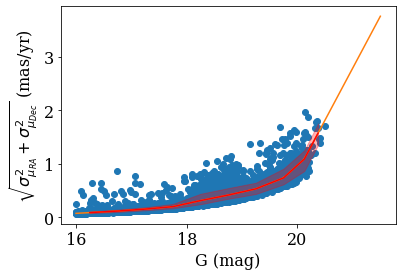

[0.07244838 3.76238137]
[0.0867681  1.57450994]
[16.   16.5  17.   17.5  18.   18.5  19.   19.5  20.   20.25 20.5 ]


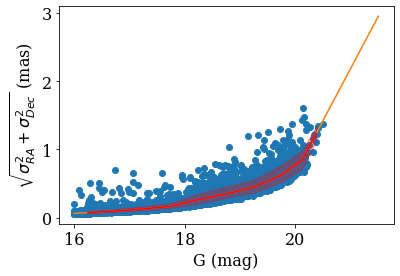

[0.06097625 2.95412698]
[0.07274291 1.23135991]


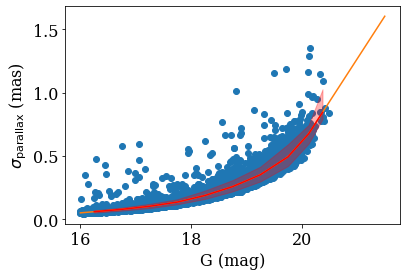

[0.05180446 1.60364866]
[0.06105864 0.84452671]


In [8]:
# x = np.copy(m31_results['gmag'])
# y = np.copy(gaia_pm_err_size)
# keep = np.isfinite(x) & np.isfinite(y) & (x > 18)
# x = x[keep]
# y = y[keep]

# def model(x, A, B, C):
#     #sigma(mag) = C+A*exp(mag/B)
#     return A*np.exp(x/B)+C

# popt, pcov = curve_fit(model, x, y, maxfev = 100000)
# A,B,C = popt
# x_vals = np.linspace(18,21.5,100)
# y_vals = model(x_vals,A,B,C)

# # n_models = 1000
# # model_draws = np.zeros((n_models,len(x_vals)))
# # for j in range(n_models):
# #     curr_A,curr_B,curr_C = stats.multivariate_normal(mean=popt,cov=pcov,allow_singular=True).rvs()
# #     model_draws[j] = model(x_vals,curr_A,curr_B,curr_C)

# # model_bounds = np.percentile(model_draws,[16,50,84],axis=0)

# plt.figure()
# plt.scatter(x,y)
# plt.plot(x_vals,y_vals,color='C1')
# # plt.plot(x_vals,model_bounds[1],color='r')
# # plt.fill_between(x_vals,model_bounds[0],model_bounds[2],color='r',alpha=0.3)
# plt.xlabel('G (mag)')
# plt.ylabel('$\sqrt{\sigma_{mu_{RA}}^2+\sigma_{mu_{Dec}}^2}$ (mas/yr)')
# plt.show()

# print(y_vals[[0,-1]])

mag_limits = (16,22)

x = np.copy(m31_results['gmag'])
y = np.copy(gaia_pm_err_size)
keep = np.isfinite(x) & np.isfinite(y) & (x > mag_limits[0])# & (y < 10)
x = x[keep]
y = y[keep]

n_bins = 3
x_bins = np.linspace(mag_limits[0],21,n_bins+1)
n_bins = 15
x_bins = np.array([16,16.5,17,17.5,18,18.5,19,19.5,20,20.25,20.5,20.75,21])
x_bins = np.array([16,16.5,17,17.5,18,18.5,19,19.5,20,20.25,20.5])
n_bins = len(x_bins)-1
x_centers = 0.5*(x_bins[1:]+x_bins[:-1])
y_bins = np.zeros((n_bins,3))
y_compare = np.zeros((len(x),3))
for j in range(n_bins):
    in_bin = (x > x_bins[j]) & (x <= x_bins[j+1])
    if np.sum(in_bin) == 0:
#         y_bins[j] = np.nan
        continue
    y_bins[j] = np.percentile(y[in_bin],[16,50,84])
    y_compare[in_bin] = y_bins[j]
    
# outliers = (y-y_compare[:,1] > 3*(y_compare[:,2]-y_compare[:,1])) | \
#             (y-y_compare[:,1] < -3*(y_compare[:,1]-y_compare[:,0]))
# keep = ~outliers
# x = x[keep]
# y = y[keep]

# y_bins = np.zeros((n_bins,3))
# y_compare = np.zeros((len(x),3))
# for j in range(n_bins):
#     in_bin = (x > x_bins[j]) & (x <= x_bins[j+1])
#     y_bins[j] = np.percentile(y[in_bin],[16,50,84])
#     y_compare[in_bin] = y_bins[j]

interp_pm_relationship = scipy.interpolate.interp1d(x_centers,y_bins[:,1],fill_value="extrapolate")

def pm_error(gmag):
#     if gmag <= x_bins[0]:
#         return y_bins[0,1]
#     elif gmag >= x_bins[-1]:
#         return y_bins[-1,1]
#     else:
#         ind = np.where((gmag > x_bins[:-1]) & (gmag <= x_bins[1:]))[0][0]
#         return y_bins[ind,1]
    return interp_pm_relationship(gmag)
#     return np.sign(gmag)*0.5

def model(x, A, B, C):
    #sigma(mag) = C+A*exp(mag/B)
    return A*np.exp(x/B)+C

popt, pcov = curve_fit(model, x, y, maxfev = 100000)
popt, pcov = curve_fit(model, x_centers, y_bins[:,1], sigma=0.5*(y_bins[:,2]-y_bins[:,0]),
                               absolute_sigma=False, maxfev = 100000, p0=popt)
A,B,C = popt
x_vals = np.linspace(mag_limits[0],21.5,100)
y_vals = model(x_vals,*popt)
y_vals = pm_error(x_vals)

# n_models = 1000
# model_draws = np.zeros((n_models,len(x_vals)))
# for j in range(n_models):
#     curr_A,curr_B,curr_C = stats.multivariate_normal(mean=popt_pos,cov=pcov_pos,allow_singular=True).rvs()
#     model_draws[j] = model(x_vals,curr_A,curr_B,curr_C)

# model_bounds = np.percentile(model_draws,[16,50,84],axis=0)
    
plt.figure()
plt.scatter(x,y)
plt.plot(x_vals,y_vals,color='C1')
# plt.plot(x_vals,model_bounds[1],color='r')
# plt.fill_between(x_vals,model_bounds[0],model_bounds[2],color='r',alpha=0.3)
plt.plot(x_centers,y_bins[:,1],color='r')
plt.fill_between(x_centers,y_bins[:,0],y_bins[:,2],color='r',alpha=0.3)
plt.xlabel('G (mag)')
plt.ylabel('$\sqrt{\sigma_{\mu_{RA}}^2+\sigma_{\mu_{Dec}}^2}$ (mas/yr)')
plt.show()

print(y_vals[[0,-1]])
print(y_bins[[0,-1],1])

x = np.copy(m31_results['gmag'])
y = np.copy(gaia_pos_err_size)
keep = np.isfinite(x) & np.isfinite(y) & (x > mag_limits[0]) & (y < 10)
x = x[keep]
y = y[keep]

n_bins = 15
x_bins = np.linspace(mag_limits[0],21.5,n_bins+1)
n_bins = 15
x_bins = np.array([16,16.5,17,17.5,18,18.5,19,19.5,20,20.25,20.5,20.75,21,21.25,21.5])
x_bins = np.array([16,16.5,17,17.5,18,18.5,19,19.5,20,20.25,20.5])
stop_bins = np.where(x_bins > x.max())[0][-1]
x_bins = x_bins[:stop_bins+1]
print(x_bins)
n_bins = len(x_bins)-1
x_centers = 0.5*(x_bins[1:]+x_bins[:-1])
y_bins = np.zeros((n_bins,3))
y_compare = np.zeros((len(x),3))
for j in range(n_bins):
    in_bin = (x > x_bins[j]) & (x <= x_bins[j+1])
    if np.sum(in_bin) == 0:
#         y_bins[j] = np.nan
        continue
    y_bins[j] = np.percentile(y[in_bin],[16,50,84])
    y_compare[in_bin] = y_bins[j]
    
outliers = (y-y_compare[:,1] > 3*(y_compare[:,2]-y_compare[:,1])) | \
            (y-y_compare[:,1] < -3*(y_compare[:,1]-y_compare[:,0]))
# keep = ~outliers
# x = x[keep]
# y = y[keep]

y_bins = np.zeros((n_bins,3))
y_compare = np.zeros((len(x),3))
for j in range(n_bins):
    in_bin = (x > x_bins[j]) & (x <= x_bins[j+1])
    if np.sum(in_bin) == 0:
#         y_bins[j] = np.nan
        continue
    y_bins[j] = np.percentile(y[in_bin],[16,50,84])
    y_compare[in_bin] = y_bins[j]

interp_pos_relationship = scipy.interpolate.interp1d(x_centers,y_bins[:,1],fill_value="extrapolate")

def pos_error(gmag):
#     if gmag <= x_bins[0]:
#         return y_bins[0,1]
#     elif gmag >= x_bins[-1]:
#         return y_bins[-1,1]
#     else:
#         ind = np.where((gmag > x_bins[:-1]) & (gmag <= x_bins[1:]))[0][0]
#         return y_bins[ind,1]
    return interp_pos_relationship(gmag)
#     return np.sign(gmag)*0.5

def model(x, A, B, C):
    #sigma(mag) = C+A*exp(mag/B)
    return A*np.exp(x/B)+C

popt_pos, pcov_pos = curve_fit(model, x, y, maxfev = 100000)
popt_pos, pcov_pos = curve_fit(model, x_centers, y_bins[:,1], sigma=0.5*(y_bins[:,2]-y_bins[:,0]),
                               absolute_sigma=False, maxfev = 100000, p0=popt_pos)
A,B,C = popt_pos
x_vals = np.linspace(mag_limits[0],21.5,100)
y_vals = model(x_vals,*popt_pos)
y_vals = pos_error(x_vals)

# n_models = 1000
# model_draws = np.zeros((n_models,len(x_vals)))
# for j in range(n_models):
#     curr_A,curr_B,curr_C = stats.multivariate_normal(mean=popt_pos,cov=pcov_pos,allow_singular=True).rvs()
#     model_draws[j] = model(x_vals,curr_A,curr_B,curr_C)

# model_bounds = np.percentile(model_draws,[16,50,84],axis=0)
    
plt.figure()
plt.scatter(x,y)
plt.plot(x_vals,y_vals,color='C1')
# plt.plot(x_vals,model_bounds[1],color='r')
# plt.fill_between(x_vals,model_bounds[0],model_bounds[2],color='r',alpha=0.3)
plt.plot(x_centers,y_bins[:,1],color='r')
plt.fill_between(x_centers,y_bins[:,0],y_bins[:,2],color='r',alpha=0.3)
plt.xlabel('G (mag)')
plt.ylabel('$\sqrt{\sigma_{RA}^2+\sigma_{Dec}^2}$ (mas)')
plt.show()

print(y_vals[[0,-1]])
print(y_bins[[0,-1],1])

x = np.copy(m31_results['gmag'])
y = np.copy(m31_results['parallax_error'])
keep = np.isfinite(x) & np.isfinite(y) & (x > mag_limits[0])# & (y < 10)
x = x[keep]
y = y[keep]

n_bins = 3
x_bins = np.linspace(mag_limits[0],21,n_bins+1)
n_bins = 15
x_bins = np.array([16,16.5,17,17.5,18,18.5,19,19.5,20,20.25,20.5,20.7,20.8,21])
x_bins = np.array([16,16.5,17,17.5,18,18.5,19,19.5,20,20.25,20.5])
n_bins = len(x_bins)-1
x_centers = 0.5*(x_bins[1:]+x_bins[:-1])
y_bins = np.zeros((n_bins,3))
y_compare = np.zeros((len(x),3))
for j in range(n_bins):
    in_bin = (x > x_bins[j]) & (x <= x_bins[j+1])
    if np.sum(in_bin) == 0:
#         y_bins[j] = np.nan
        continue
    y_bins[j] = np.percentile(y[in_bin],[16,50,84])
    y_compare[in_bin] = y_bins[j]
    
# outliers = (y-y_compare[:,1] > 3*(y_compare[:,2]-y_compare[:,1])) | \
#             (y-y_compare[:,1] < -3*(y_compare[:,1]-y_compare[:,0]))
# keep = ~outliers
# x = x[keep]
# y = y[keep]

# y_bins = np.zeros((n_bins,3))
# y_compare = np.zeros((len(x),3))
# for j in range(n_bins):
#     in_bin = (x > x_bins[j]) & (x <= x_bins[j+1])
#     y_bins[j] = np.percentile(y[in_bin],[16,50,84])
#     y_compare[in_bin] = y_bins[j]

interp_parallax_relationship = scipy.interpolate.interp1d(x_centers,y_bins[:,1],fill_value="extrapolate")

def parallax_error(gmag):
#     if gmag <= x_bins[0]:
#         return y_bins[0,1]
#     elif gmag >= x_bins[-1]:
#         return y_bins[-1,1]
#     else:
#         ind = np.where((gmag > x_bins[:-1]) & (gmag <= x_bins[1:]))[0][0]
#         return y_bins[ind,1]
    return interp_parallax_relationship(gmag)
#     return np.sign(gmag)*0.5

def model(x, A, B, C):
    #sigma(mag) = C+A*exp(mag/B)
    return A*np.exp(x/B)+C

popt_pos, pcov_pos = curve_fit(model, x, y, maxfev = 100000)
popt_pos, pcov_pos = curve_fit(model, x_centers, y_bins[:,1], sigma=0.5*(y_bins[:,2]-y_bins[:,0]),
                               absolute_sigma=False, maxfev = 100000, p0=popt_pos)
A,B,C = popt_pos
x_vals = np.linspace(mag_limits[0],21.5,100)
y_vals = model(x_vals,*popt_pos)
y_vals = parallax_error(x_vals)

# n_models = 1000
# model_draws = np.zeros((n_models,len(x_vals)))
# for j in range(n_models):
#     curr_A,curr_B,curr_C = stats.multivariate_normal(mean=popt_pos,cov=pcov_pos,allow_singular=True).rvs()
#     model_draws[j] = model(x_vals,curr_A,curr_B,curr_C)

# model_bounds = np.percentile(model_draws,[16,50,84],axis=0)
    
plt.figure()
plt.scatter(x,y)
plt.plot(x_vals,y_vals,color='C1')
# plt.plot(x_vals,model_bounds[1],color='r')
# plt.fill_between(x_vals,model_bounds[0],model_bounds[2],color='r',alpha=0.3)
plt.plot(x_centers,y_bins[:,1],color='r')
plt.fill_between(x_centers,y_bins[:,0],y_bins[:,2],color='r',alpha=0.3)
plt.xlabel('G (mag)')
plt.ylabel('$\sigma_{\mathrm{parallax}}$ (mas)')
plt.show()

print(y_vals[[0,-1]])
print(y_bins[[0,-1],1])

In [9]:
#####EXAMPLE OF MATRIX TRANFORMATION SECTION##########
#             TRANSFORMATION MATRIX: X_2 = AG*(X_1-Xo)+BG*(Y_1-Yo)+Wo
#                                    Y_2 = CG*(X_1-Xo)+DG*(Y_1-Yo)+Zo
#
#                                AG:  0.13445487019
#                                BG:  0.98645672253
#                                CG: -0.98680188642
#                                DG:  0.13332047009
#                                Xo:      2139.0912
#                                Yo:      1624.4170
#                                Wo:      4658.3364
#                                Zo:      4915.2915
#
#                    ROTATION (deg):  82.27
#                 PIXEL-SCALE RATIO:  0.99567211
#    REAL IMG PIXEL SCALE (mas/pix): 49.78360526
#
#                      MAGNITUDE ZP:  33.13
####From Jay Anderson's paper:
#   rotation = arctan(B-C,A+D)
#   pixel_scale_ratio = sqrt(A*D-B*C)
#   on_axis_skew = 0.5*(A-D)
#   off_axis_skew = 0.5*(B+C)

In [10]:
import pandas as pd

field = 'COSMOS_field'
# field = 'Fornax_dSph'
# field = 'Pal15'
# field = 'M31'

#loop over all the images in this field (including multiple images)
#and save the PM measurements for every star, only keeping the best measurement
#of the PM

outpath = f'/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/GaiaHub_results/{field}/Bayesian_PMs/'
folder_names = os.listdir(outpath)
print(f'Finding all output PMs for field {field}:')
mags_and_q_fits = []

for image_ind,image in enumerate(tqdm(folder_names,total=len(folder_names))):
    if '_' in image:
        #don't use linked images
        continue
    gaiahub_file = f'{outpath}/{image}/{image}_gaiahub_source_summaries.csv'
    if not os.path.isfile(gaiahub_file):
        continue
    gaiahub_results = pd.read_csv(gaiahub_file)
    mags_and_q_fits.extend(np.array([gaiahub_results['g_mag'].to_numpy(),\
                                     gaiahub_results['q_hst'].to_numpy()]).T)
                
print('Done\n')
mags_and_q_fits = np.array(mags_and_q_fits)
keep = (mags_and_q_fits[:,1] > 0)
mags_and_q_fits = mags_and_q_fits[keep]


  0%|          | 1/1154 [00:00<03:17,  5.83it/s]

Finding all output PMs for field COSMOS_field:


100%|██████████| 1154/1154 [00:38<00:00, 30.00it/s]

Done



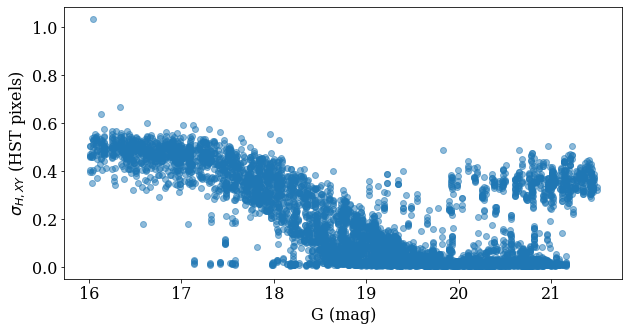

In [11]:
mags_and_pos_errs = np.copy(mags_and_q_fits)
mags_and_pos_errs[:,1] *= 0.8

plt.figure(figsize=(10,5))
plt.scatter(mags_and_pos_errs[:,0],mags_and_pos_errs[:,1]*0.8,
            alpha=0.5)
plt.ylabel(r'$\sigma_{H,XY}$ (HST pixels)')
plt.xlabel('G (mag)')
plt.show()

In [12]:
a,b,c,d = -0.38011581651, -0.91903156178, 0.91899293411, -0.38007774492

pixel_scale_ratio = np.sqrt(a*d-b*c)
rotation = np.arctan2(b-c,a+d)*180/np.pi
on_axis_skew = 0.5*(a-d)
off_axis_skew = 0.5*(b+c)
print('Pixel Scale Ratio:',pixel_scale_ratio)
print('Rotation (deg):',rotation)
print('On Axis Skew:',on_axis_skew)
print('Off Axis Skew:',off_axis_skew)

Pixel Scale Ratio: 0.9945134860058175
Rotation (deg): -112.46963132241382
On Axis Skew: -1.903579499998309e-05
Off Axis Skew: -1.931383499997885e-05


In [13]:
fake_halo_name = 'fake_halo_000'
outpath = f'/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/code/km_fake_halos/{fake_halo_name}/'

#chosen_field == 'COSMOS':
ra_center = '10:00:36.50'
dec_center = '+02:20:47.8'

field_coord = coord.SkyCoord(ra_center, dec_center, unit=(u.hourangle, u.deg))
l = field_coord.galactic.l.radian
b = field_coord.galactic.b.radian
ra_deg = field_coord.ra.deg
dec_deg = field_coord.ra.deg

new_params = np.load(f'{outpath}indv_star_params.npy')
new_param_labels = np.array(['Index','halo_mem','RA','Dec',
                  'App_Mag_G','App_Mag_B','App_Mag_R',
                  '[Fe/H]','Age','Mass','Dist.','Teff','log_g',\
                  'EEP','Lumin.','Phase',\
                  'vr','vphi_or_vz','vtheta_or_vt',\
                  'pm_l_cosb','pm_b','rad_vel_gsr','radius','logweight'])
halo_velocity_params = np.load(f'{outpath}halo_velocity_params.npy')

new_param_weights = np.exp(new_params[:,-1]-new_params[:,-1].max())
new_param_weights /= np.sum(new_param_weights)

halo_stars = (new_params[:,1] == 1)
disk_stars = ~halo_stars

halo_star_weights = np.copy(new_param_weights[halo_stars])
halo_star_weights -= halo_star_weights.max()
halo_star_weights /= np.sum(halo_star_weights)
disk_star_weights = np.copy(new_param_weights[disk_stars])
disk_star_weights -= disk_star_weights.max()
disk_star_weights /= np.sum(disk_star_weights)

chosen_halo_fraction = 0.28 #fraction of stars in magnitude range that are 
halo_star_weights *= chosen_halo_fraction
disk_star_weights *= (1-chosen_halo_fraction)
new_param_weights[halo_stars] = halo_star_weights
new_param_weights[disk_stars] = disk_star_weights

curr_coords = coord.SkyCoord(new_params[:,2],new_params[:,3], unit=(u.deg, u.deg))
curr_ls,curr_bs = curr_coords.galactic.l.deg,curr_coords.galactic.b.deg,
all_coords = SkyCoord(l=curr_ls*u.degree, b=curr_bs*u.degree, distance=new_params[:,10]*u.kpc,
                      pm_l_cosb=new_params[:,19]*u.mas/u.yr, pm_b=new_params[:,20]*u.mas/u.yr,
                      frame='galactic')
pm_ras = all_coords.icrs.pm_ra_cosdec.value/np.cos(new_params[:,3]*np.pi/180)
pm_decs = all_coords.icrs.pm_dec.value

new_param_pms = np.array([pm_ras,pm_decs]).T
new_param_pm_lbs = np.array([new_params[:,19]/np.cos(curr_bs*np.pi/180),new_params[:,20]]).T

#change back to cos form
new_param_pms[:,0] *= np.cos(new_params[:,3]*np.pi/180)
new_param_pm_lbs[:,0] *= np.cos(curr_bs*np.pi/180)

resampled_params = np.zeros_like(new_params)
chosen_inds = np.random.choice(len(new_params),p=new_param_weights,size=len(new_params))
resampled_params = np.copy(new_params[chosen_inds])
resampled_param_pms = np.copy(new_param_pms[chosen_inds])
resampled_param_pm_lbs = np.copy(new_param_pm_lbs[chosen_inds])

resampled_halo = (resampled_params[:,1] == 1)
resampled_disk = ~resampled_halo

In [14]:
print(np.sum(new_param_weights[halo_stars]),np.sum(new_param_weights[disk_stars]))

0.28 0.72


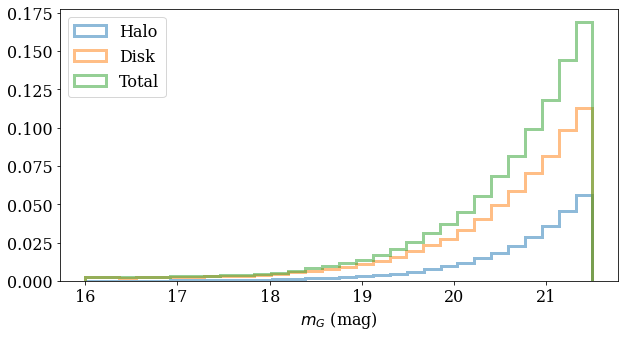

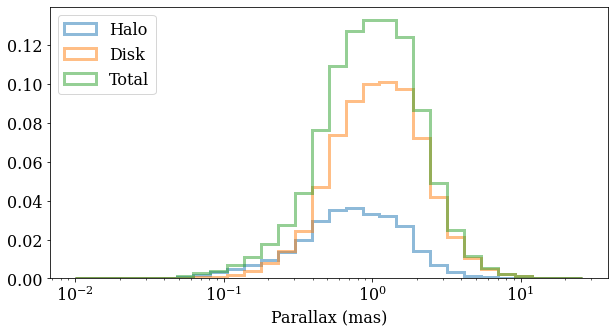

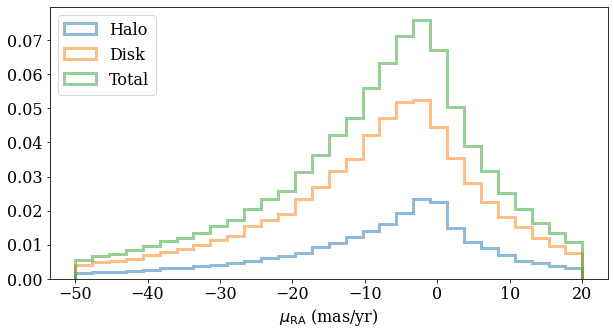

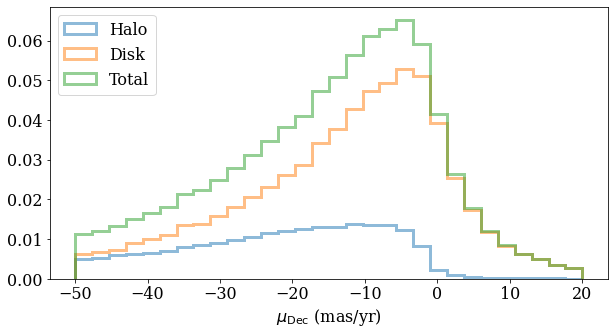

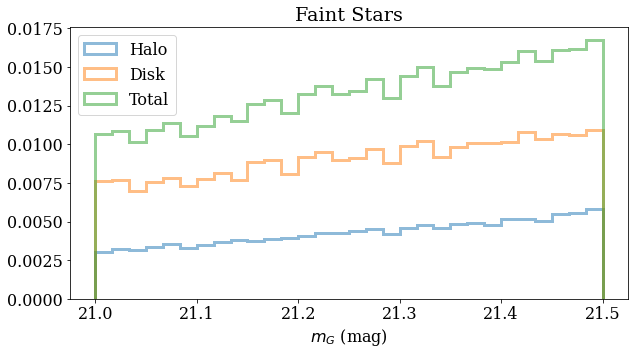

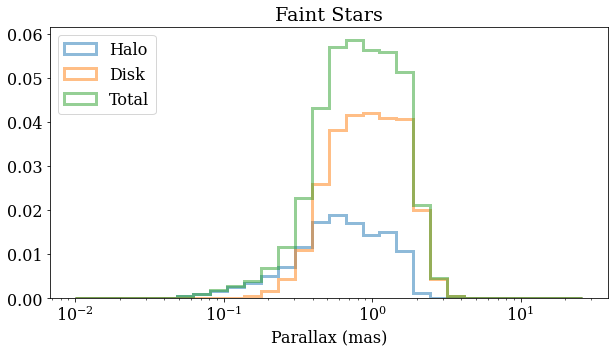

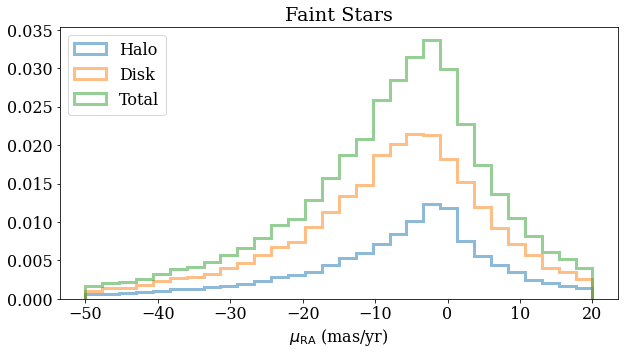

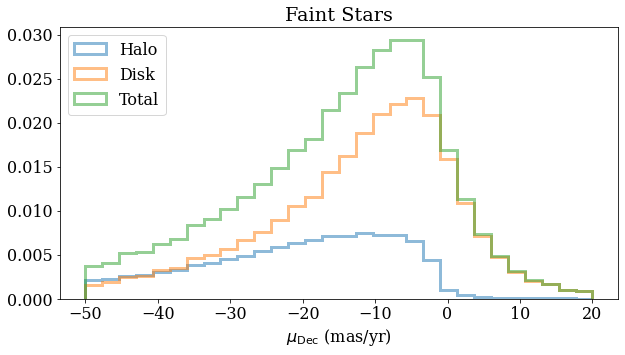

In [15]:
bins = 30
alpha = 0.5
vel_range=[-50,20]

plt.figure(figsize=(10,5))
vals = new_params[:,4]
if np.sum(halo_stars) > 0:
    plt.hist(vals[halo_stars],weights=new_param_weights[halo_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo')
if np.sum(disk_stars) > 0:
    plt.hist(vals[disk_stars],weights=new_param_weights[disk_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk')
plt.hist(vals,weights=new_param_weights,alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total')
plt.xlabel('$m_G$ (mag)')
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(10,5))
vals = 1/new_params[:,10]
# bins = np.logspace(np.log10(vals.min()),np.log10(vals.max()),30+1)
bins = np.logspace(np.log10(1e-2),np.log10(vals.max()),30+1)
if np.sum(halo_stars) > 0:
    plt.hist(vals[halo_stars],weights=new_param_weights[halo_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo')
if np.sum(disk_stars) > 0:
    plt.hist(vals[disk_stars],weights=new_param_weights[disk_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk')
plt.hist(vals,weights=new_param_weights,alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total')
plt.xlabel('Parallax (mas)')
plt.legend(loc=2)
plt.gca().set_xscale('log')
plt.show()

plt.figure(figsize=(10,5))
vals = pm_ras
bins = 30
if np.sum(halo_stars) > 0:
    plt.hist(vals[halo_stars],weights=new_param_weights[halo_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo',range=vel_range)
if np.sum(disk_stars) > 0:
    plt.hist(vals[disk_stars],weights=new_param_weights[disk_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk',range=vel_range)
plt.hist(vals,weights=new_param_weights,alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total',range=vel_range)
plt.xlabel('$\mu_{\mathrm{RA}}$ (mas/yr)')
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(10,5))
vals = pm_decs
bins = 30
if np.sum(halo_stars) > 0:
    plt.hist(vals[halo_stars],weights=new_param_weights[halo_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo',range=vel_range)
if np.sum(disk_stars) > 0:
    plt.hist(vals[disk_stars],weights=new_param_weights[disk_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk',range=vel_range)
plt.hist(vals,weights=new_param_weights,alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total',range=vel_range)
plt.xlabel('$\mu_{\mathrm{Dec}}$ (mas/yr)')
plt.legend(loc=2)
plt.show()

faint_stars = (new_params[:,4] > 21)

bins = 30
plt.figure(figsize=(10,5))
plt.title('Faint Stars')
vals = new_params[:,4]
if np.sum(halo_stars&faint_stars) > 0:
    plt.hist(vals[halo_stars&faint_stars],weights=new_param_weights[halo_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo')
if np.sum(disk_stars&faint_stars) > 0:
    plt.hist(vals[disk_stars&faint_stars],weights=new_param_weights[disk_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk')
plt.hist(vals[faint_stars],weights=new_param_weights[faint_stars],alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total')
plt.xlabel('$m_G$ (mag)')
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(10,5))
plt.title('Faint Stars')
vals = 1/new_params[:,10]
# bins = np.logspace(np.log10(vals.min()),np.log10(vals.max()),30+1)
bins = np.logspace(np.log10(1e-2),np.log10(vals.max()),30+1)
if np.sum(halo_stars&faint_stars) > 0:
    plt.hist(vals[halo_stars&faint_stars],weights=new_param_weights[halo_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo')
if np.sum(disk_stars&faint_stars) > 0:
    plt.hist(vals[disk_stars&faint_stars],weights=new_param_weights[disk_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk')
plt.hist(vals[faint_stars],weights=new_param_weights[faint_stars],alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total')
plt.xlabel('Parallax (mas)')
plt.legend(loc=2)
plt.gca().set_xscale('log')
plt.show()

plt.figure(figsize=(10,5))
plt.title('Faint Stars')
vals = pm_ras
bins = 30
if np.sum(halo_stars&faint_stars) > 0:
    plt.hist(vals[halo_stars&faint_stars],weights=new_param_weights[halo_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo',range=vel_range)
if np.sum(disk_stars&faint_stars) > 0:
    plt.hist(vals[disk_stars&faint_stars],weights=new_param_weights[disk_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk',range=vel_range)
plt.hist(vals[faint_stars],weights=new_param_weights[faint_stars],alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total',range=vel_range)
plt.xlabel('$\mu_{\mathrm{RA}}$ (mas/yr)')
plt.legend(loc=2)
plt.show()

plt.figure(figsize=(10,5))
plt.title('Faint Stars')
vals = pm_decs
bins = 30
if np.sum(halo_stars&faint_stars) > 0:
    plt.hist(vals[halo_stars&faint_stars],weights=new_param_weights[halo_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C0',label='Halo',range=vel_range)
if np.sum(disk_stars&faint_stars) > 0:
    plt.hist(vals[disk_stars&faint_stars],weights=new_param_weights[disk_stars&faint_stars],alpha=alpha,
             bins=bins,histtype='step',lw=3,color='C1',label='Disk',range=vel_range)
plt.hist(vals[faint_stars],weights=new_param_weights[faint_stars],alpha=alpha,
         bins=bins,histtype='step',lw=3,color='C2',label='Total',range=vel_range)
plt.xlabel('$\mu_{\mathrm{Dec}}$ (mas/yr)')
plt.legend(loc=2)
plt.show()

mu_RA -6.02765361572307 17.441056794842094
mu_Dec -15.434888957336844 21.36342368631623
parallax 0.9938310427592617 0.770836549099337


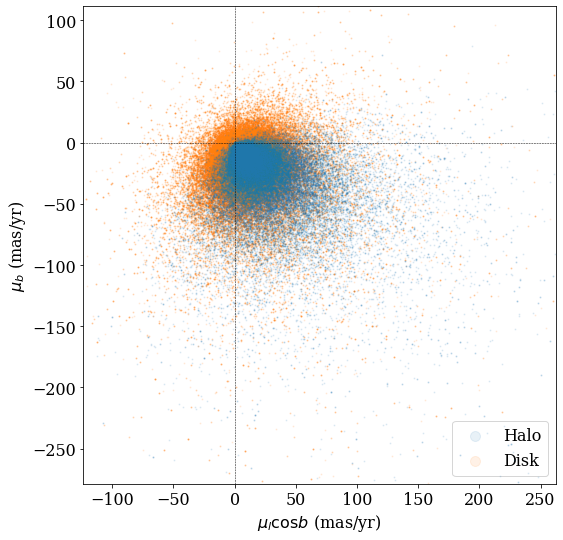

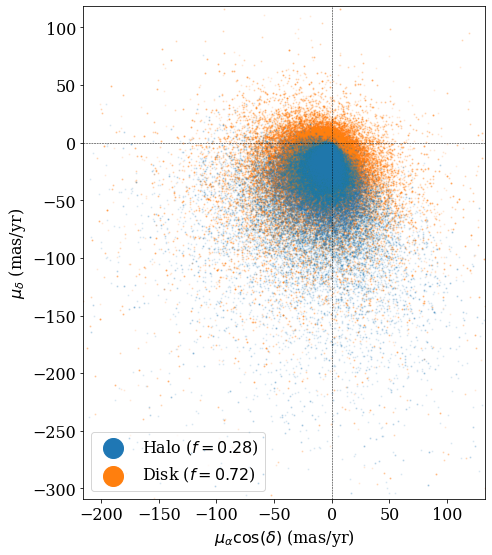

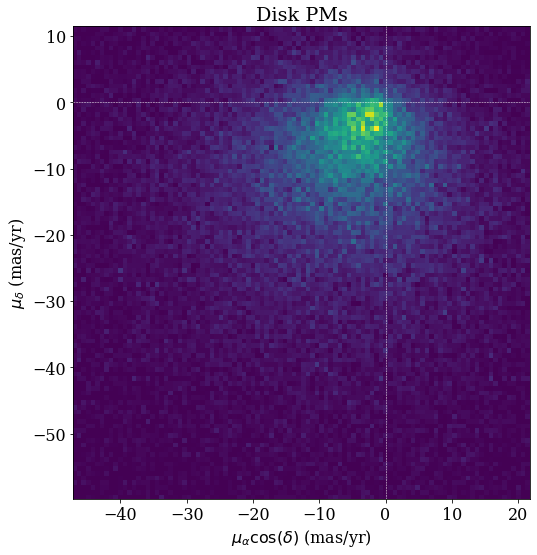

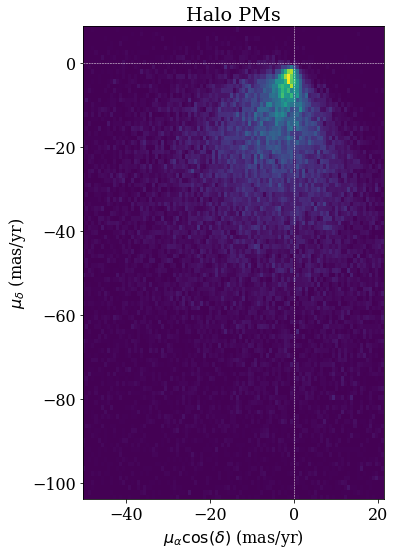

In [16]:
size = 1
alpha = 0.1

print('mu_RA',np.median(resampled_param_pms[:,0]),0.5*np.diff(np.percentile(resampled_param_pms[:,0],[16,84]))[0])
print('mu_Dec',np.median(resampled_param_pms[:,1]),0.5*np.diff(np.percentile(resampled_param_pms[:,1],[16,84]))[0])
print('parallax',np.median(1/resampled_params[:,10]),0.5*np.diff(np.percentile(1/resampled_params[:,10],[16,84]))[0])

plt.figure(figsize=(8,8))
plt.gca().set_aspect('equal')
if np.sum(resampled_halo) > 0:
    plt.scatter(resampled_param_pm_lbs[resampled_halo,0],resampled_param_pm_lbs[resampled_halo,1],
                color='C0',label='Halo',zorder=1e10,s=size,alpha=alpha)
if np.sum(resampled_disk) > 0:
    plt.scatter(resampled_param_pm_lbs[resampled_disk,0],resampled_param_pm_lbs[resampled_disk,1],
                color='C1',label='Disk',zorder=-1e10,s=size,alpha=alpha)
plt.legend(loc=4,markerscale=10)
plt.axhline(0,c='k',ls='--',lw=0.5,zorder=1e20)
plt.axvline(0,c='k',ls='--',lw=0.5,zorder=1e20)
plt.xlabel('$\mu_{l} \cos b$ (mas/yr)')
plt.ylabel('$\mu_{b}$ (mas/yr)')
bounds = np.percentile(resampled_param_pm_lbs,[16,50,84],axis=0).T
n_sigma = 10
xlim = bounds[0,1]-n_sigma*(bounds[0,1]-bounds[0,0]),bounds[0,1]+n_sigma*(bounds[0,2]-bounds[0,1])
ylim = bounds[1,1]-n_sigma*(bounds[1,1]-bounds[1,0]),bounds[1,1]+n_sigma*(bounds[1,2]-bounds[1,1])
plt.xlim(xlim);plt.ylim(ylim)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,8))
plt.gca().set_aspect('equal')
if np.sum(resampled_halo) > 0:
    plt.scatter(resampled_param_pms[resampled_halo,0],resampled_param_pms[resampled_halo,1],
                color='C0',label='Halo ($f=%.2f$)'%(chosen_halo_fraction),zorder=1e10,s=size,alpha=alpha)
if np.sum(resampled_disk) > 0:
    plt.scatter(resampled_param_pms[resampled_disk,0],resampled_param_pms[resampled_disk,1],
                color='C1',label='Disk ($f=%.2f$)'%(1-chosen_halo_fraction),zorder=-1e10,s=size,alpha=alpha)
leg = plt.legend(loc=3,markerscale=20)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.axhline(0,c='k',ls='--',lw=0.5,zorder=1e20)
plt.axvline(0,c='k',ls='--',lw=0.5,zorder=1e20)
# plt.xlabel('$\mu_{\mathrm{RA}}$ (mas/yr)')
# plt.ylabel('$\mu_{\mathrm{Dec}}$ (mas/yr)')
plt.xlabel(r'$\mu_{\alpha}\cos(\delta)$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')
bounds = np.percentile(resampled_param_pms,[16,50,84],axis=0).T
n_sigma = 10
xlim = bounds[0,1]-n_sigma*(bounds[0,1]-bounds[0,0]),bounds[0,1]+n_sigma*(bounds[0,2]-bounds[0,1])
ylim = bounds[1,1]-n_sigma*(bounds[1,1]-bounds[1,0]),bounds[1,1]+n_sigma*(bounds[1,2]-bounds[1,1])
plt.xlim(xlim);plt.ylim(ylim)
plt.tight_layout()
plt.savefig(f'{figpath}synthetic_COSMOS_VPD.png')
plt.show()

plt.figure(figsize=(8,8))
plt.gca().set_aspect('equal')
plt.title('Disk PMs')
plt.xlabel(r'$\mu_{\alpha}\cos(\delta)$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')
bounds = np.percentile(resampled_param_pms[resampled_disk],[16,50,84],axis=0).T
n_sigma = 2
xlim = bounds[0,1]-n_sigma*(bounds[0,1]-bounds[0,0]),bounds[0,1]+n_sigma*(bounds[0,2]-bounds[0,1])
ylim = bounds[1,1]-n_sigma*(bounds[1,1]-bounds[1,0]),bounds[1,1]+n_sigma*(bounds[1,2]-bounds[1,1])
plt.xlim(xlim);plt.ylim(ylim)

plt.hist2d(resampled_param_pms[resampled_disk,0],resampled_param_pms[resampled_disk,1],
           range=[xlim,ylim],bins=100)

plt.axhline(0,c='w',ls='--',lw=0.5,zorder=1e20)
plt.axvline(0,c='w',ls='--',lw=0.5,zorder=1e20)

plt.tight_layout()

plt.show()

plt.figure(figsize=(8,8))
plt.gca().set_aspect('equal')
plt.title('Halo PMs')
plt.xlabel(r'$\mu_{\alpha}\cos(\delta)$ (mas/yr)')
plt.ylabel(r'$\mu_{\delta}$ (mas/yr)')
bounds = np.percentile(resampled_param_pms[resampled_halo],[16,50,84],axis=0).T
n_sigma = 2
xlim = bounds[0,1]-n_sigma*(bounds[0,1]-bounds[0,0]),bounds[0,1]+n_sigma*(bounds[0,2]-bounds[0,1])
ylim = bounds[1,1]-n_sigma*(bounds[1,1]-bounds[1,0]),bounds[1,1]+n_sigma*(bounds[1,2]-bounds[1,1])
plt.xlim(xlim);plt.ylim(ylim)

plt.hist2d(resampled_param_pms[resampled_halo,0],resampled_param_pms[resampled_halo,1],
           range=[xlim,ylim],bins=100)

plt.axhline(0,c='w',ls='--',lw=0.5,zorder=1e20)
plt.axvline(0,c='w',ls='--',lw=0.5,zorder=1e20)

plt.tight_layout()

plt.show()

In [17]:
np.random.seed(100)
chosen_halo_star = new_params[np.random.choice(np.where(halo_stars)[0],
                                               p=new_param_weights[halo_stars]/np.sum(new_param_weights[halo_stars]))]
chosen_disk_star = new_params[np.random.choice(np.where(disk_stars)[0],
                                               p=new_param_weights[disk_stars]/np.sum(new_param_weights[disk_stars]))]

chosen_star = chosen_disk_star
# chosen_star = chosen_halo_star

ra,dec,dist = chosen_star[[2,3,10]]
dist = 0.1
dist = 1
pm_l_cosb,pm_b,vrad = chosen_star[[19,20,21]]
pm_l_cosb,pm_b,vrad = 0,0,0
curr_coord = coord.SkyCoord(ra,dec, unit=(u.deg, u.deg))
curr_l,curr_b = curr_coord.galactic.l.deg,curr_coord.galactic.b.deg,
print(curr_l,curr_b,dist,pm_l_cosb,pm_b,vrad)
print(1/dist)

236.69319801480637 42.23004721438752 1 0 0 0
1.0


In [18]:
dtime = 11.35
dtime = 11.5
dtime = 0.95
# dtime = 0.5

c = SkyCoord(l=curr_l*u.degree, b=curr_b*u.degree, distance=dist*u.kpc,
             pm_l_cosb=pm_l_cosb*u.mas/u.yr, pm_b=pm_b*u.mas/u.yr,
             radial_velocity=vrad*u.km/u.s,
             frame='galactic',
             obstime=Time('2006-01-21 05:11:23.5'))

print(c.icrs.ra.deg,c.icrs.dec.deg,c.distance.kpc,
      c.icrs.pm_ra_cosdec.value/np.cos(dec*np.pi/180),c.icrs.pm_dec.value,c.radial_velocity)
new_c = c.apply_space_motion(dt=dtime*u.year)
print()
print(new_c.icrs.ra.deg,new_c.icrs.dec.deg,new_c.distance.kpc,
      new_c.icrs.pm_ra_cosdec.value/np.cos(dec*np.pi/180),new_c.icrs.pm_dec.value,new_c.radial_velocity)
ra_change = (new_c.icrs.ra.deg-c.icrs.ra.deg)*3600*1000 #in mas
dec_change = (new_c.icrs.dec.deg-c.icrs.dec.deg)*3600*1000 #in mas
print(np.round(np.array([ra_change,dec_change])/dtime,3))

150.1520833333333 2.3466111111111405 1.0 0.0 0.0 0.0 km / s

150.1520833333333 2.3466111111111374 1.0000000000000002 0.0 0.0 0.0 km / s
[ 0. -0.]


In [19]:
c = SkyCoord(l=curr_l*u.degree, b=curr_b*u.degree, distance=dist*u.kpc,
             pm_l_cosb=pm_l_cosb*u.mas/u.yr, pm_b=pm_b*u.mas/u.yr,
             frame='galactic',
             obstime=Time('2006-01-21 05:11:23.5'))

print(c.icrs.ra.deg,c.icrs.dec.deg,c.distance.kpc,
      c.icrs.pm_ra_cosdec.value/np.cos(dec*np.pi/180),c.icrs.pm_dec.value,c.radial_velocity)
new_c = c.apply_space_motion(dt=dtime*u.year)
print()
print(new_c.icrs.ra.deg,new_c.icrs.dec.deg,new_c.distance.kpc,
      new_c.icrs.pm_ra_cosdec.value/np.cos(dec*np.pi/180),new_c.icrs.pm_dec.value,new_c.radial_velocity)
ra_change = (new_c.icrs.ra.deg-c.icrs.ra.deg)*3600*1000 #in mas
dec_change = (new_c.icrs.dec.deg-c.icrs.dec.deg)*3600*1000 #in mas
print(np.round(np.array([ra_change,dec_change])/dtime,3))

150.1520833333333 2.346611111111141 1.0 0.0 0.0 0.0 km / s

150.1520833333333 2.3466111111111374 1.0000000000000002 0.0 0.0 0.0 km / s
[ 0. -0.]


In [20]:
np.sum(new_param_weights[1/new_params[:,10] > 0.5*0.5])

0.9502624430792329

In [21]:
def delta_ra_dec_per_parallax(hst_time,gaia_time,ra,dec):
    #THIS CODE IS REPURPOSED FROM CODE FROM MELODIE KAO
    
    #choose any parallax because we will scale by it later
    parallax = 1.0*u.mas
    distance = (1/parallax.value)*u.kpc
    delta_time = (gaia_time-hst_time).to(u.year).value
    dates = hst_time+np.array([0,delta_time])*u.year
    
    sun_loc = astropy.coordinates.get_sun(dates)
    
    sun_skycoord = SkyCoord(frame='gcrs', obstime=dates,
                            ra = sun_loc.ra, dec = sun_loc.dec)
    sun_eclon = sun_skycoord.geocentrictrueecliptic.lon
    sun_eclat = sun_skycoord.geocentrictrueecliptic.lat

#     coord_gaia = SkyCoord( ra          = ra*u.deg,
#                            dec         = dec*u.deg,
#                            distance    = distance*u.kpc,
#                            obstime     = gaia_ref_epoch)

    coord_gaia = SkyCoord( ra          = ra*u.deg,
                           dec         = dec*u.deg,
                           distance    = distance,
#                            pm_ra_cosdec= c.icrs.pm_ra_cosdec,
#                            pm_dec      = c.icrs.pm_dec,
                           obstime     = gaia_time)

    # Get geocentric ecliptic coordinates of star after correcting for pm
    star_eclon = coord_gaia.geocentrictrueecliptic.lon
    star_eclat = coord_gaia.geocentrictrueecliptic.lat

    plx_delta_eclon = -parallax * np.sin(star_eclon - sun_eclon) / np.cos(star_eclat)
    plx_delta_eclat = -parallax * np.cos(star_eclon - sun_eclon) * np.sin(star_eclat)

    offset_lon = plx_delta_eclon - plx_delta_eclon[1] #the second date is Gaia
    offset_lat = plx_delta_eclat - plx_delta_eclat[1]

    offset_total = np.sqrt(np.power(offset_lon,2)+np.power(offset_lat,2))

    #### COMPUTE 	parallax and proper motion offsets in equatorial coordinates
    # Ecliptic coordinates: pm-corrected location of star + the parallax offset at each date
    coord_plx = astropy.coordinates.GeocentricTrueEcliptic(
                    lon = star_eclon + plx_delta_eclon,
                    lat = star_eclat + plx_delta_eclat)

    # Transform the pm-corrected location of the star + parallax offset at each date to ICRS coordinates (ra/dec)
    coord_plx_icrs = coord_plx.transform_to(astropy.coordinates.ICRS)
    # FIX THIS AT SOME POINT
    # WARNING: AstropyDeprecationWarning: Transforming a frame instance to a frame class 
    # (as opposed to another frame instance) will not be supported in the future.  
    # Either explicitly instantiate the target frame, or first convert the 
    # source frame instance to a `astropy.coordinates.SkyCoord` and use its
    # `transform_to()` method. [astropy.coordinates.baseframe]

    plx_delta_ra_dec = coord_gaia.spherical_offsets_to(coord_plx_icrs)
    plx_delta_ra   = plx_delta_ra_dec[0]
    plx_delta_dec  = plx_delta_ra_dec[1]

    offset_ra = plx_delta_ra - plx_delta_ra[1] #the second date is Gaia
    offset_dec = plx_delta_dec - plx_delta_dec[1]
    offset_ra_dec_total = np.sqrt(np.power(offset_ra,2)+np.power(offset_dec,2))

    offset_ra_div_para = offset_ra.to(u.mas)/parallax
    offset_dec_div_para = offset_dec.to(u.mas)/parallax
    offset_ra_dec_total_div_para = np.sqrt(np.power(offset_ra_div_para,2)+np.power(offset_dec_div_para,2))    
    
    return np.array([offset_ra_div_para.value[0],offset_dec_div_para.value[0]])

delta_t = dtime

gaia_ref_epoch = Time(2016.0, format='jyear',scale='tcb')
gaia_date = gaia_ref_epoch #Time('2016-01-01T00:00:00', format='isot', scale='utc')
hst_date = gaia_date-delta_t*u.year

offset_ra_dec_div_para = delta_ra_dec_per_parallax(hst_date,gaia_date,ra,dec)
offset_ra_dec_div_para

array([-0.23787011,  0.05185583])

1.8017931978835584 mas 0.26077002294067947 mas 1.8044686506257037 mas


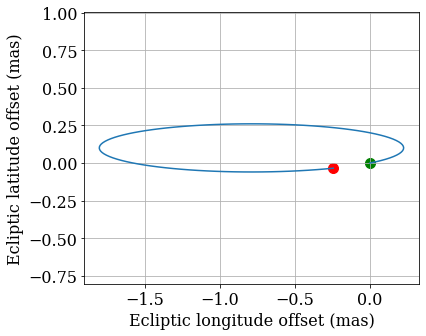

target star PARALLAX delta RA:  -0.23787 mas
target star PARALLAX delta Dec: 0.05186 mas
target star PARALLAX offset:    0.24346 mas
target star delta RA/parallax:  -0.23787
target star delta Dec/parallax: 0.05186
target star offset/parallax:    0.24346


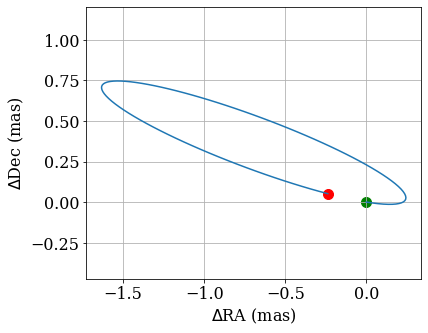

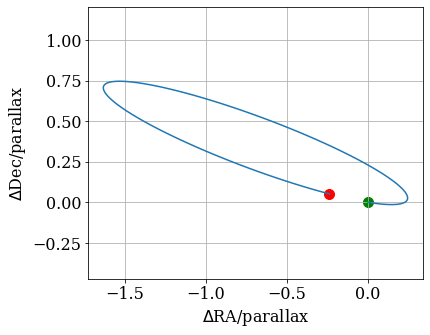

In [22]:
delta_t = dtime

gaia_ref_epoch = Time(2016.0, format='jyear',scale='tcb')
gaia_date = gaia_ref_epoch #Time('2016-01-01T00:00:00', format='isot', scale='utc')
hst_date = gaia_date-delta_t*u.year

dates = gaia_date+np.linspace(0,-delta_t,100)*u.year
# dates = gaia_date-np.array([delta_t,0])*u.year

# Get geocentric ecliptic coordinates of Sun 

sun_loc = astropy.coordinates.get_sun(dates)
sun_skycoord = SkyCoord(frame='gcrs', obstime=dates,
                        ra = sun_loc.ra, dec = sun_loc.dec)
sun_eclon = sun_skycoord.geocentrictrueecliptic.lon
sun_eclat = sun_skycoord.geocentrictrueecliptic.lat

parallax = 1/c.icrs.distance.value*u.mas #in mas
coord_j2000 = SkyCoord( ra          = c.icrs.ra.value*u.deg,
                        dec         = c.icrs.dec.value*u.deg,
#                         distance    = c.icrs.distance,
#                         pm_ra_cosdec= c.icrs.pm_ra_cosdec,
#                         pm_dec      = c.icrs.pm_dec,
                        obstime     = gaia_ref_epoch)
coord_epoch1 = coord_j2000

# Get geocentric ecliptic coordinates of star after correcting for pm
star_eclon = coord_epoch1.geocentrictrueecliptic.lon
star_eclat = coord_epoch1.geocentrictrueecliptic.lat

plx_delta_eclon = -parallax * np.sin(star_eclon - sun_eclon) / np.cos(star_eclat)
plx_delta_eclat = -parallax * np.cos(star_eclon - sun_eclon) * np.sin(star_eclat)

#### PLOT 	parallax offset ellipse in ecliptic coordinates
#### 		Robin M. Green: "...the annual path of a star due to parallax is an
####                 ellipse of semimajor axis 𝜋, semiminor axis 𝜋sin𝛽,
####                 and therefore of eccentricity cos𝛽
offset_lon = plx_delta_eclon - plx_delta_eclon[0]
offset_lat = plx_delta_eclat - plx_delta_eclat[0]

offset_total = np.sqrt(np.power(offset_lon,2)+np.power(offset_lat,2))
print(np.max(np.abs(offset_lon)),np.max(np.abs(offset_lat)),np.max(offset_total))

plt.figure(figsize=(6, 5))
# plt.plot(plx_delta_eclon.to(u.mas).value, plx_delta_eclat.to(u.mas).value)
# plt.scatter(plx_delta_eclon.to(u.mas).value[0], plx_delta_eclat.to(u.mas).value[0],color='g',s=100)
# plt.scatter(plx_delta_eclon.to(u.mas).value[-1], plx_delta_eclat.to(u.mas).value[-1],color='r',s=100)
plt.plot(offset_lon.to(u.mas).value, offset_lat.to(u.mas).value)
plt.scatter(offset_lon.to(u.mas).value[0], offset_lat.to(u.mas).value[0],color='g',s=100)
plt.scatter(offset_lon.to(u.mas).value[-1], offset_lat.to(u.mas).value[-1],color='r',s=100)
plt.axis('equal')
plt.grid(True)
plt.xlabel('Ecliptic longitude offset (mas)')
plt.ylabel('Ecliptic latitude offset (mas)')
plt.draw()
plt.show()
plt.close()

#### COMPUTE 	parallax and proper motion offsets in equatorial coordinates
# Ecliptic coordinates: pm-corrected location of star + the parallax offset at each date
coord_plx = astropy.coordinates.GeocentricTrueEcliptic(
                lon = star_eclon + plx_delta_eclon,
                lat = star_eclat + plx_delta_eclat)

# Transform the pm-corrected location of the star + parallax offset at each date to ICRS coordinates (ra/dec)
coord_plx_icrs = coord_plx.transform_to(astropy.coordinates.ICRS)
# FIX THIS AT SOME POINT
# WARNING: AstropyDeprecationWarning: Transforming a frame instance to a frame class 
# (as opposed to another frame instance) will not be supported in the future.  
# Either explicitly instantiate the target frame, or first convert the 
# source frame instance to a `astropy.coordinates.SkyCoord` and use its
# `transform_to()` method. [astropy.coordinates.baseframe]

plx_delta_ra_dec = coord_epoch1.spherical_offsets_to(coord_plx_icrs)
plx_delta_ra   = plx_delta_ra_dec[0]
plx_delta_dec  = plx_delta_ra_dec[1]

offset_ra = plx_delta_ra - plx_delta_ra[0]
offset_dec = plx_delta_dec - plx_delta_dec[0]
offset_ra_dec_total = np.sqrt(np.power(offset_ra,2)+np.power(offset_dec,2))

print( 'target star PARALLAX delta RA:  {:.5f}'.format(offset_ra[-1].to(u.mas)))
print( 'target star PARALLAX delta Dec: {:.5f}'.format(offset_dec[-1].to(u.mas)))
print( 'target star PARALLAX offset:    {:.5f}'.format(offset_ra_dec_total[-1].to(u.mas)))

offset_ra_div_para = offset_ra.to(u.mas)/parallax
offset_dec_div_para = offset_dec.to(u.mas)/parallax
offset_ra_dec_total_div_para = np.sqrt(np.power(offset_ra_div_para,2)+np.power(offset_dec_div_para,2))

print( 'target star delta RA/parallax:  {:.5f}'.format(offset_ra_div_para[-1]))
print( 'target star delta Dec/parallax: {:.5f}'.format(offset_dec_div_para[-1]))
print( 'target star offset/parallax:    {:.5f}'.format(offset_ra_dec_total_div_para[-1]))

plt.figure(figsize=(6, 5))
plt.plot(offset_ra.to(u.mas).value, offset_dec.to(u.mas).value)
plt.scatter(offset_ra.to(u.mas).value[0], offset_dec.to(u.mas).value[0],color='g',s=100)
plt.scatter(offset_ra.to(u.mas).value[-1], offset_dec.to(u.mas).value[-1],color='r',s=100)
plt.axis('equal')
plt.grid(True)
plt.xlabel(r'$\Delta$RA (mas)')
plt.ylabel(r'$\Delta$Dec (mas)')
plt.draw()
plt.show()
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(offset_ra_div_para.value, offset_dec_div_para.value)
plt.scatter(offset_ra_div_para.value[0], offset_dec_div_para.value[0],color='g',s=100)
plt.scatter(offset_ra_div_para.value[-1], offset_dec_div_para.value[-1],color='r',s=100)
plt.axis('equal')
plt.grid(True)
plt.xlabel(r'$\Delta$RA/parallax')
plt.ylabel(r'$\Delta$Dec/parallax')
plt.draw()
plt.show()
plt.close()

#delta_{RA,Dec}/parallax is a constant number for each star at a given time
#so we can use any parallax we want to calculate these vectors for each star
#and then get the offsets from parallax using the current drawn parallax and these vectors


Max offset of 0.72 mas


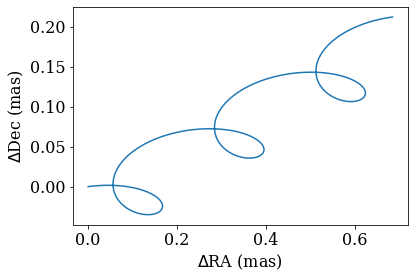

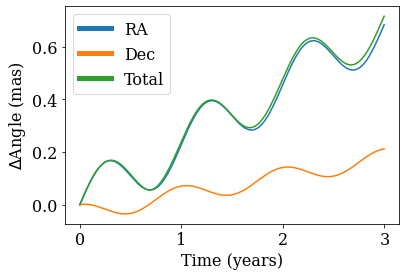

In [23]:
#model a star's parallax motion over a few years

dist = 10 #kpc
x_ang,y_ang = 179,20 #like RA,Dec
#polar coords
theta = (90-y_ang)*np.pi/180
phi = x_ang*np.pi/180

#put sun at (x,y,z) = 0
n_years = 3
times = np.arange(0,n_years,1/365) #in years
#use plane of earth's orbit to get x,y,z at each time
angles = np.linspace(0,np.pi*2*n_years,len(times))

#conversion ratios
kpc_to_au = 2.063e8
kpc_to_km = 3.086e16
year_to_sec = 365*24*3600
radian_to_mas = 180/np.pi*3600*1000

earth_dist = 1/kpc_to_au #1AU in kpc
#position of earth in the plane of it's orbit, with sun at center
plane_x = earth_dist*np.cos(angles)
plane_y = earth_dist*np.sin(angles)
plane_z = np.zeros(len(angles))

earth_norm_plane = (0,0,1) #direction of the z vector of the earth's plane
#the cross product of plane_x with plane_y has to be equal to the earth_norm_plane
# #rotate the plane of the earth's orbit
earth_x = plane_x
earth_y = plane_y
earth_z = plane_z

star_vel = (-10,-10,0) #vx,vy,vz in km/s
star_vx = (star_vel[0]*year_to_sec/kpc_to_km)
star_vy = (star_vel[1]*year_to_sec/kpc_to_km)
star_vz = (star_vel[2]*year_to_sec/kpc_to_km)
star_x = dist*np.sin(theta)*np.cos(phi)+star_vx*times
star_y = dist*np.sin(theta)*np.sin(phi)+star_vy*times
star_z = dist*np.cos(theta)+star_vz*times
# star_vel = (100,10,10) #in vrad (km/s), mu_theta (mas/yr), mu_phi (mas/yr)
# star_vx,star_vy,star_vz = 
# star_vx,star_vy,star_vz = 


star_planet_vector = np.array([star_x-earth_x,star_y-earth_y,star_z-earth_z]).T
star_planet_vector_sphere = np.zeros_like(star_planet_vector)
star_planet_vector_sphere[:,0] = np.sqrt(np.sum(np.power(star_planet_vector,2),axis=1))
star_planet_vector_sphere[:,1] = np.arccos(star_planet_vector[:,2]/star_planet_vector_sphere[:,0]) #polar angle
star_planet_vector_sphere[:,2] = np.sign(star_planet_vector[:,1])*np.arccos(star_planet_vector[:,0]/np.sqrt(np.sum(np.power(star_planet_vector[:,:2],2),axis=1)))

delta_dec = (star_planet_vector_sphere[:,1]-star_planet_vector_sphere[0,1])*radian_to_mas
delta_ra = (star_planet_vector_sphere[:,2]-star_planet_vector_sphere[0,2])*radian_to_mas
delta_total = np.sqrt(np.power(delta_ra,2)+np.power(delta_dec,2))

print(f'Max offset of {np.round(delta_total.max(),2)} mas')

plt.figure()
plt.plot(delta_ra,delta_dec)
plt.xlabel(r'$\Delta$RA (mas)')
plt.ylabel(r'$\Delta$Dec (mas)')
plt.show()

plt.figure()
plt.plot(times,delta_ra,label=r'RA')
plt.plot(times,delta_dec,label=r'Dec')
plt.plot(times,delta_total,label=r'Total')
plt.xlabel(r'Time (years)')
plt.ylabel(r'$\Delta$Angle (mas)')
leg = plt.legend(loc='best')
for line in leg.get_lines():
    line.set_linewidth(5)
plt.show()

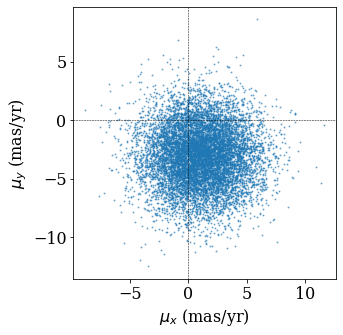

In [24]:
#sigma_v_{phi,theta} = 70 km/s at r = 24kpc gives dtheta/dt = 0.615 mas/yr


pm_center = np.array([1,-3])
# pm_center = np.array([0,0])
pm_errs = np.array([2.5,2.5])

n_draws = 10000

np.random.seed(101)

mu_draws = np.zeros((n_draws,2))
mu_draws[:,0] = np.random.randn(n_draws)*pm_errs[0]+pm_center[0]
mu_draws[:,1] = np.random.randn(n_draws)*pm_errs[1]+pm_center[1]

plt.figure(figsize=(5,5))
plt.gca().set_aspect('equal')
plt.scatter(mu_draws[:,0],mu_draws[:,1],s=1,alpha=0.5)
plt.axhline(0,c='k',lw=0.5,ls='--')
plt.axvline(0,c='k',lw=0.5,ls='--')
plt.xlabel(r'$\mu_x$ (mas/yr)')
plt.ylabel(r'$\mu_y$ (mas/yr)')
plt.show()

In [25]:
pm_size_and_errs = np.copy([new_param_pms[:,0],new_param_pms[:,1],
                            np.zeros_like(new_param_pms[:,0]),np.zeros_like(new_param_pms[:,0]),
                            new_params[:,4],new_params[:,4]]).T

poss_pm_sizes = np.sqrt(np.power(new_param_pms[:,0],2)+np.power(new_param_pms[:,1],2))

large_pms = poss_pm_sizes > 50

In [26]:
from decimal import getcontext,Decimal
from math import atan2,asin,sqrt,pow

def RADec_from_XY(X,Y,ra0,dec0,X0,Y0,pixel_scale):
    '''
    ra,dec,ra0,dec0 in degrees
    pixel_scale in mas/pixel
    X0,Y0 in pixels
    X,Y in pixels    
    
    equations from https://www.researchgate.net/publication/333841450_Astrometry_The_Foundation_for_Observational_Astronomy,
    though our dY is their Y*-1
    '''
    
    dec0_rad = dec0*np.pi/180
    ra0_rad = ra0*np.pi/180
    
    cosd0 = np.cos(dec0_rad)
    sind0 = np.sin(dec0_rad)
    
#    decimal_cosd0 = Decimal(cosd0)
#    decimal_sind0 = Decimal(sind0)
    
    dX = (X0-X)/(180/np.pi*3600*1000/pixel_scale)
    dY = (Y-Y0)/(180/np.pi*3600*1000/pixel_scale)
    
    ra_rad = np.zeros_like(X)
    dec_rad = np.zeros_like(Y)
    
    atan_args = dX,cosd0-dY*sind0
    asin_args = (sind0+dY*cosd0)/np.sqrt(1+np.power(dX,2)+np.power(dY,2))
    
    for j in range(len(X)):
#        decimal_dx = Decimal(dX[j])
#        decimal_dy = Decimal(dY[j])
#        ra_rad[j] = ra0_rad + atan2(decimal_dx,decimal_cosd0-decimal_dy*decimal_sind0)
        
        ra_rad[j] = ra0_rad + atan2(Decimal(atan_args[0][j]),Decimal(atan_args[1][j]))
        dec_rad[j] = asin(Decimal(asin_args[j]))
    
    ra = ra_rad*180/np.pi
    dec = dec_rad*180/np.pi
                
    return ra,dec

def XY_from_RADec(ra,dec,ra0,dec0,X0,Y0,pixel_scale):
    '''
    ra,dec,ra0,dec0 in degrees
    pixel_scale in mas/pixel
    X0,Y0 in pixels
    X,Y in pixels
    
    equations come from xym2pm_GH.F, after line 2047
    '''
    
    dec0_rad = dec0*np.pi/180
    dec_rad = dec*np.pi/180
    ra0_rad = ra0*np.pi/180
    ra_rad = ra*np.pi/180
    
    cosra = np.cos(ra_rad-ra0_rad)
    sinra = np.sin(ra_rad-ra0_rad)
    cosde = np.cos(dec_rad)
    sinde = np.sin(dec_rad)
    cosd0 = np.cos(dec0_rad)
    sind0 = np.sin(dec0_rad)
    
    rrrr = sind0*sinde + cosd0*cosde*cosra
    #offsets in radians
    dY = (cosd0*sinde-sind0*cosde*cosra)/rrrr
    dX = cosde*sinra/rrrr
    
    x  = cosde*np.cos(ra_rad)
    y  = cosde*np.sin(ra_rad)
    z  = sinde
    xx = cosd0*np.cos(ra0_rad)
    yy = cosd0*np.sin(ra0_rad)
    zz = sind0
    bad_cond = (x*xx + y*yy + z*zz < 0)
    dY[bad_cond] = np.pi/2
    dX[bad_cond] = np.pi/2
            
    X = X0-dX*180/np.pi*3600*1000/pixel_scale
    Y = Y0+dY*180/np.pi*3600*1000/pixel_scale
    
    return X,Y


In [27]:
show_plots = False
# show_plots = True

overwrite_previous = False
# overwrite_previous = True

# #from Fornax real data
fake_field_params = {
                     'FAKE_FIELD_01':np.array([-112.46963132241382,  0.9945134860058175,  4972.7290,  
                                               5065.2474, -1.903579499998309e-05,  -1.931383499997885e-05,
                                               2086.6321,2304.2309]),
                     'FAKE_FIELD_02':np.array([-112.46963132241382,  0.9945134860058175,  4972.7290,  
                                               5065.2474, -1.903579499998309e-05,  -1.931383499997885e-05,
                                               2086.6321,2304.2309]),
                     'FAKE_FIELD_03':np.array([-112.46963132241382,  0.9945134860058175,  4972.7290,  
                                               5065.2474, -1.903579499998309e-03,  -1.931383499997885e-03,
                                               2086.6321,2304.2309]),
                     'FAKE_FIELD_04':np.array([180,  0.9945134860058175,  4972.7290,  
                                               5065.2474, -1.903579499998309e-05,  -1.931383499997885e-05,
                                               2086.6321,2304.2309]),
                    }

x0_gaia = 5000
y0_gaia = 5000
pix_dims_gaia = (10000,10000)

#for fake_field_02, have a list of stationary points

n_star_options = np.array([5,10,15,20,25,30,40,50,75,100,150,200])[::-1]
n_star_options = np.array([4,5,6,7,8,9,10,15,20,25,50,75,100,150,200])[::-1]

# n_star_options = np.array([1000])[::-1]
# n_star_options = np.array([5,6,7,8,9,10,11,12,13,14,15])[::-1]
seed_options = np.arange(101,105+1).astype(int)
# seed_options = np.array([101]).astype(int)
# time_options = np.array([5,6,7,8,9,10,12.5,15,17.5,20])

time_options = np.array([5,7.5,10,12.5,15])[::-1]
time_options = np.sort(np.append(time_options,time_options+0.5))[::-1]
# time_options = np.array([10,11,12,13,14,15])[::-1]

#what is the uncertainty on measuring the positions? 
hst_pix_sigmas = 0.5/50 #in hst pixels from https://ui.adsabs.harvard.edu/abs/2022ApJ...933...76D/abstract

#chosen_field == 'COSMOS':
ra_center = '10:00:36.50'
dec_center = '+02:20:47.8'

# n_star_options = np.array([4,5,10,25,50,200])
# time_options = np.array([15,15.5,10,10.5])
# seed_options = np.array([101])
fake_field_params = {'FAKE_FIELD_01':fake_field_params['FAKE_FIELD_01']}

field_coord = coord.SkyCoord(ra_center, dec_center, unit=(u.hourangle, u.deg))
l = field_coord.galactic.l.radian
b = field_coord.galactic.b.radian
ra_deg = field_coord.ra.deg
dec_deg = field_coord.dec.deg

seed_per_nstar = np.maximum(5,np.round(200/n_star_options).astype(int))

time_offsets = (-0.000,0.000) #in years, from the Gaia Time (2016.0)

path = '/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/'

print('Current number of combinations:',len(fake_field_params)*np.sum(seed_per_nstar)*time_options.size)

stop_fitting = False

mag_zp = 32.40
orig_pix_scale = 50 #mas/pixel
orig_pix_ratio = orig_pix_scale

total_counter = 0

for field_ind,chosen_field in enumerate(fake_field_params):
    if stop_fitting:
        break
    
    if not os.path.isdir(f'{resultpath}{chosen_field}/'):
        os.makedirs(f'{resultpath}{chosen_field}/')
        
    field_num = int(chosen_field.split('_')[-1])
#     if field_num not in [4]:
#         continue
#     if field_num not in [3,4]:
#         continue
        
    for nstar_ind,n_star in enumerate(n_star_options):
        if stop_fitting:
            break
        nstar = n_star
        n_stars = n_star
        n_star_string = f'n{n_star:03d}'
        for time_ind,delta_time in enumerate(time_options):
            if stop_fitting:
                break
            time_string = f't{round(delta_time*10):03d}'
            
            #ensure there are at least 200 stars when summing over the seeds
#             n_seed_options = max(5,int(round(200/n_star)))
            n_seed_options = seed_per_nstar[nstar_ind]
            seed_options = np.arange(101,101+n_seed_options,1).astype(int)
            
            large_pms = poss_pm_sizes*delta_time/orig_pix_scale > 20
            
            for seed_ind,seed in enumerate(seed_options):
                if stop_fitting:
                    break
                total_counter += 1
                                    
                chosen_params = fake_field_params[chosen_field]
                rot,ratio,w0,z0,on_skew,off_skew,x0,y0 = chosen_params
                a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                det = a*d-b*c
                #inverse matrix for de-transforming
                ai,bi,ci,di = np.array([d,-b,-c,a])/det
                pix_scale = orig_pix_scale*ratio
                
                ra,dec = ra_deg,dec_deg #near M31
                
                seed_string = f's{seed:03d}'

                np.random.seed(((n_star+0)*(seed)*(field_num+1000)*int(delta_time*10+10000))%(2**32))
                
                image_name = f'FF{n_star_string}{time_string}{seed_string}'
                trans_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/{image_name}/'
                trans_file = f'{trans_path}{image_name}_6p_transformation.txt'
#                 truths = np.array([rot,ratio,w0,z0,on_skew,off_skew])
                truths = np.array([a,b,w0,z0,c,d])
    
                outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/{image_name}/'
                if (not overwrite_previous) and os.path.isfile(f'{outpath}/{image_name}_linked_images.csv'):
                    print(f'SKIPPING: {image_name} was already created.')
                    continue
                    
                print(total_counter,field_num,n_star_string,time_string,seed_string)
                
                if not os.path.isdir(trans_path):
                    os.makedirs(trans_path)
                print(trans_path)
                
                #save the truth
                truth_trans_file = f'{trans_path}{image_name}_6p_transformation_TRUTH.npy'
                np.save(f'{truth_trans_file}',np.array([a,b,c,d,x0,y0,w0,z0,rot,ratio,on_skew,off_skew]))

                mat_file = f'{trans_path}{image_name}_flc.MAT'

                #just use 4096 pixels in each dimension, with (0,0) in the center
                pix_dims = (4096,4096)
                xranges = (0,pix_dims[0])
                yranges = (0,pix_dims[1])
                
                pixel_insets = (100,100) #truncate edges XY
                xranges_gaia = x0_gaia+np.array([-0.5*pix_dims[0]+pixel_insets[0],
                                                  0.5*pix_dims[0]-pixel_insets[0]])
                yranges_gaia = y0_gaia+np.array([-0.5*pix_dims[1]+pixel_insets[1],
                                                  0.5*pix_dims[1]-pixel_insets[1]])

                with open(mat_file,'w') as f:
                    #each row is a star

                    #draw PMs and errors from real measurements, then add noise
#                     star_inds = np.random.choice(len(pm_size_and_errs),size=n_star,replace=False) 
                    temp_param_weights = np.copy(new_param_weights)
                    temp_param_weights[large_pms] = 0
                    temp_param_weights /= np.sum(temp_param_weights)
                    star_inds = np.random.choice(len(new_param_weights),
                                                 p=temp_param_weights,
                                                 size=n_star,replace=True) 

                    star_pm_and_errs = pm_size_and_errs[star_inds]
                    star_gmags = star_pm_and_errs[:,-2]
                    star_hst_mags = star_pm_and_errs[:,-1]
                    star_pm_errs = star_pm_and_errs[:,[2,3]]
                    star_pms = star_pm_and_errs[:,[0,1]]
#                     star_pms = np.array([np.random.randn(n_star)*pm_errs[0]+pm_center[0],\
#                                          np.random.randn(n_star)*pm_errs[1]+pm_center[1]]).T
                    star_pm_size = np.sqrt(np.power(star_pms[:,0],2)+np.power(star_pms[:,1],2))
#                     star_pm_dist_params = 0,0.5*np.diff(np.percentile(star_pm_size,[0.5,99.5]))[0]
                    star_pm_dist_params = np.median(star_pm_size),0.5*np.diff(np.percentile(star_pm_size,[16,84]))[0]
                    outliers = np.where((star_pm_size-star_pm_dist_params[0]) > 10*star_pm_dist_params[1])[0]

                    replace_n_star = len(outliers)
                    replace_count = 0
                    while replace_n_star > 0:
                        break
#                         replace_star_inds = np.random.choice(len(pm_size_and_errs),size=replace_n_star,replace=False)
                        replace_star_inds = np.random.choice(len(new_param_weights),
                                                                 p=temp_param_weights,
                                                                 size=replace_n_star,replace=True)
                        star_inds[outliers] = replace_star_inds

                        replace_star_pm_and_errs = pm_size_and_errs[replace_star_inds]
                        replace_star_gmags = replace_star_pm_and_errs[:,-2]
                        replace_star_hst_mags = replace_star_pm_and_errs[:,-1]
                        replace_star_pm_errs = replace_star_pm_and_errs[:,[2,3]]
                        replace_star_pms = replace_star_pm_and_errs[:,[0,1]]
#                         replace_star_pms = replace_star_pm_and_errs[:,[0,1]]+np.random.randn((2*replace_n_star)).reshape((replace_n_star,2))*replace_star_pm_errs
#                         replace_star_pms = np.array([np.random.randn(replace_n_star)*pm_errs[0]+pm_center[0],\
#                                                      np.random.randn(replace_n_star)*pm_errs[1]+pm_center[1]]).T
                        replace_star_pm_size = np.sqrt(np.power(replace_star_pms[:,0],2)+np.power(replace_star_pms[:,1],2))
                        star_pms[outliers] = np.copy(replace_star_pms)
                        star_pm_and_errs[outliers] = np.copy(replace_star_pm_and_errs)
                        star_pm_size[outliers] = np.copy(replace_star_pm_size)
                        outliers = np.where((star_pm_size-star_pm_dist_params[0]) > 10*star_pm_dist_params[1])[0]
                        replace_n_star = len(outliers)
                        replace_count += 1
#                     print(star_pm_dist_params,np.sum(outliers),replace_count)

                    star_gmags = star_pm_and_errs[:,-2]
                    star_hst_mags = star_pm_and_errs[:,-1]
                    star_pm_errs = star_pm_and_errs[:,[2,3]]
                    star_dists = new_params[star_inds,10] #in kpc
                    star_parallaxes = 1/star_dists
                    gaia_time_offsets = np.random.rand(n_star)*(time_offsets[1]-time_offsets[0])+time_offsets[0]
                    star_gaia_times = gaia_ref_epoch+gaia_time_offsets*u.year
                    star_hst_times = gaia_ref_epoch-np.ones(n_star)*delta_time*u.year
                    star_delta_times = (star_gaia_times-star_hst_times).to(u.year).value
                    
                    np.save(f'{trans_path}{image_name}_HST_Gaia_times.npy',
                            np.array([star_hst_times.value,star_gaia_times.value]).T)
                                            
                    stationary = np.zeros(len(star_inds)).astype(bool)
                    if chosen_field == 'FAKE_FIELD_02':
                        #make one of the stars a stationary source
                        n_stationary = 1
#                         n_stationary = n_star
#                         n_stationary = int(0.5*n_star)
                        stationary[:n_stationary] = True
#                     stationary[:] = True
                    star_pms[stationary] = 0.0
                    star_parallaxes[stationary] = 1e-6 #mas, corresponds to a giga-parsec distance
                    star_dists[stationary] = np.power(star_parallaxes[stationary],-1)
            
#                     plt.figure(figsize=(5,5))
#                     plt.gca().set_aspect('equal')
#                     plt.scatter(star_pms[:,0],star_pms[:,1])
#                     plt.show()
                    
                    np.save(f'{trans_path}{image_name}_true_PMs.npy',star_pms) #chosen PMs in RA,Dec (mas/year)
                    np.save(f'{trans_path}{image_name}_true_parallaxes.npy',star_parallaxes) #mas
                    np.save(f'{trans_path}{image_name}_stationary_points.npy',stationary) #booleans of whether point is stationary
                    
                    #get Gaia-measured PMs and errors for building priors
                    faint_stars = (star_gmags > 21)
#                     gaia_pm_err_sizes = model(star_gmags,*popt)
                    gaia_pm_err_sizes = pm_error(star_gmags)
                    pm_frac_ranges = [0.9,1.1] #pm_x_err/pm_y_err = frac
                    frac_draws = np.random.rand(n_star)*(pm_frac_ranges[1]-pm_frac_ranges[0])+pm_frac_ranges[0]
                    gaia_pmdec_err = gaia_pm_err_sizes*np.sqrt(1/(1+np.power(frac_draws,2)))
                    gaia_pmra_err = gaia_pmdec_err*frac_draws                  
                    
                    gaia_pm_errs = np.array([gaia_pmra_err,gaia_pmdec_err]).T
                    gaia_pms = star_pms+np.random.randn((2*n_star)).reshape((n_star,2))*gaia_pm_errs
                    #no Gaia measure for stars fainter than G=21, so give 0 pm and large uncertainty for prior
                    gaia_pms[faint_stars] = np.nan
                    gaia_pm_errs[faint_stars] = np.nan                       
                    gaia_pms_and_errs = np.array([gaia_pms,gaia_pm_errs])
                    
                    gaia_pos_err_sizes = pos_error(star_gmags)
                    pos_frac_ranges = [0.9,1.1] #x_err/y_err = frac
                    frac_draws = np.random.rand(n_star)*(pos_frac_ranges[1]-pos_frac_ranges[0])+pos_frac_ranges[0]
                    gaia_dec_err = gaia_pos_err_sizes*np.sqrt(1/(1+np.power(frac_draws,2)))
                    gaia_ra_err = gaia_dec_err*frac_draws     
                    gaia_pos_errs = np.array([gaia_ra_err,gaia_dec_err]).T
                    
                    gaia_parallax_errs = parallax_error(star_gmags)
                    #gaia data has some negative parallaxes in it
                    gaia_parallaxes = star_parallaxes+np.random.randn(n_star)*gaia_parallax_errs
                    gaia_parallaxes[faint_stars] = np.nan
                    gaia_parallax_errs[faint_stars] = np.nan
                    
#                     norm_loc = star_parallaxes
#                     norm_scale = gaia_parallax_errs
#                     norm_a, norm_b = (0 - norm_loc) / norm_scale, (np.inf - norm_loc) / norm_scale
#                     gaia_parallaxes = stats.truncated_normal(loc=norm_loc,
#                                                                  scale=norm_scale,
#                                                                  a=norm_a,b=norm_b).rvs()
                    
                    #get the true XY positions in Gaia first, then turn those back into RA,Dec 
                    #apply appropriate noise to RA,Dec, then turn back into XY in Gaia
                    #use the true RA,Dec values and times to get the parallax offsets
                    #apply PM and parallax motion to true XY Gaia, then transform to HST pixels
                    #add noise to HST positions
                    true_gaia_xy = np.zeros((n_star,2))
                    true_gaia_radec = np.zeros((n_star,2))
                    for j in range(n_star):
                        chosen_gaia_x = np.random.rand()*(xranges_gaia[1]-xranges_gaia[0])+xranges_gaia[0]
                        chosen_gaia_y = np.random.rand()*(yranges_gaia[1]-yranges_gaia[0])+yranges_gaia[0]
                        
                        true_gaia_xy[j] = chosen_gaia_x,chosen_gaia_y
                    true_gaia_radec = np.array(RADec_from_XY(true_gaia_xy[:,0],
                                                             true_gaia_xy[:,1],
                                                             ra0=ra_deg,dec0=dec_deg,
                                                             X0=x0_gaia,Y0=y0_gaia,
                                                             pixel_scale=orig_pix_scale)).T
                    np.save(f'{trans_path}{image_name}_true_Gaia_RADec.npy',true_gaia_radec) #chosen RA,Dec in J2016 (degrees)

                    true_gaia_pos_offsets = np.random.randn(n_star,2)*gaia_pos_errs
                    gaia_radec = np.copy(true_gaia_radec)
                    
                    #add the noise, but remember that the noise is in deltaRAcosDec
                    gaia_radec[:,0] += (true_gaia_pos_offsets[:,0]/np.cos(true_gaia_radec[:,1]*np.pi/180))/1000/3600
                    gaia_radec[:,1] += true_gaia_pos_offsets[:,1]/1000/3600
                    #transform the noised RA,Dec into Gaia XY
                    gaia_xy = np.array(XY_from_RADec(gaia_radec[:,0],
                                                     gaia_radec[:,1],
                                                     ra0=ra_deg,dec0=dec_deg,
                                                     X0=x0_gaia,Y0=y0_gaia,
                                                     pixel_scale=orig_pix_scale)).T
                    #get the parallax offsets using the 
                    np.save(f'{trans_path}{image_name}_true_Gaia_RADec_offsets.npy',true_gaia_pos_offsets) #chosen RA,Dec in J2016 (degrees)

                    parallax_offset_vector = np.zeros((n_star,2)) #(delta_ra/parallax,delta_dec/parallax)
                    for star_ind in range(n_star):
                        hst_date = star_hst_times[star_ind]
                        gaia_date = star_gaia_times[star_ind]
                        #negative sign to keep the proper motion and offset vectors in same direction
                        #(i.e. final-initial time)
                        parallax_offset_vector[star_ind] = -1*delta_ra_dec_per_parallax(hst_date,gaia_date,
                                                                                     true_gaia_radec[star_ind,0],
                                                                                     true_gaia_radec[star_ind,1])
                        #change offset deltaRA to deltaRA*cosDec
                        parallax_offset_vector[star_ind,0] *= np.cos(true_gaia_radec[star_ind,1]*np.pi/180)                    
                        
                    np.save(f'{trans_path}{image_name}_GaiaMeasure_PMs.npy',gaia_pms_and_errs)
                    np.save(f'{trans_path}{image_name}_GaiaMeasure_RADec_errs.npy',gaia_pos_errs)
                    np.save(f'{trans_path}{image_name}_GaiaMeasure_parallaxes.npy',
                                                np.array([gaia_parallaxes,gaia_parallax_errs]).T)
                    
                    #use parallaxes and PMs to change J2016 Gaia XY to HST image time Gaia XY
                    parallax_changes = (parallax_offset_vector*star_parallaxes[:,None])/1000/3600
                    pm_changes = star_pms*star_delta_times[:,None]/1000/3600
                    true_gaia_radec_hst = np.copy(true_gaia_radec)
                    true_gaia_radec_hst[:,0] -= (pm_changes[:,0]+\
                                                 parallax_changes[:,0])/np.cos(true_gaia_radec[:,1]*np.pi/180)
                    true_gaia_radec_hst[:,1] -= (pm_changes[:,1]+parallax_changes[:,1])
                    true_gaia_xy_hst = np.array(XY_from_RADec(true_gaia_radec_hst[:,0],
                                                              true_gaia_radec_hst[:,1],
                                                              ra0=ra_deg,dec0=dec_deg,
                                                              X0=x0_gaia,Y0=y0_gaia,
                                                              pixel_scale=orig_pix_scale)).T
                    #transform the Gaia XY at HST time, to HST XY
                    true_hst_x = ai*(true_gaia_xy_hst[:,0]-w0)+bi*(true_gaia_xy_hst[:,1]-z0)+x0
                    true_hst_y = ci*(true_gaia_xy_hst[:,0]-w0)+di*(true_gaia_xy_hst[:,1]-z0)+y0
                    true_hst_xy = np.array([true_hst_x,true_hst_y]).T
                    
                    #get appropriate HST position uncertainty, and add noise
                    hst_pix_sigmas = np.zeros(n_star)
                    for j in range(n_star):
                        curr_gmag = star_gmags[j]
                        mag_diffs = np.abs(mags_and_pos_errs[:,0]-curr_gmag)
                        mag_diff_ind = np.random.choice(np.where(mag_diffs == np.min(mag_diffs))[0])
                        hst_pix_sigmas[j] = mags_and_pos_errs[mag_diff_ind,1]
                    q_hsts = hst_pix_sigmas/0.8
                    hst_xy = true_hst_xy+np.random.randn(n_star,2)*hst_pix_sigmas[:,None]
                    
                    hst_xy_gaia = np.array((a*(hst_xy[:,0]-x0)+b*(hst_xy[:,1]-y0)+w0,\
                                            c*(hst_xy[:,0]-x0)+d*(hst_xy[:,1]-y0)+z0)).T
                    
                    all_measures = {
                                    'dX_Gaia':gaia_xy[:,0]-hst_xy_gaia[:,0],
                                    'dY_Gaia':gaia_xy[:,1]-hst_xy_gaia[:,1],
                                    'X_Gaia':gaia_xy[:,0],'Y_Gaia':gaia_xy[:,1],
                                    'X_HST':hst_xy[:,0],'Y_HST':hst_xy[:,1],
                                   }
                    
                    for j in range(n_star):
                        
                        curr_gmag = star_gmags[j]                   
                        
                        curr_star_params = np.zeros(10)*np.nan
                        curr_star_params[0] = all_measures['X_Gaia'][j]
                        curr_star_params[1] = all_measures['Y_Gaia'][j]
                        curr_star_params[2] = all_measures['X_HST'][j]
                        curr_star_params[3] = all_measures['Y_HST'][j]
                        curr_star_params[4] = star_gmags[j]
                        curr_star_params[5] = star_hst_mags[j]
                        curr_star_params[6] = all_measures['dX_Gaia'][j] 
                        curr_star_params[7] = all_measures['dY_Gaia'][j]
                        curr_star_params[8] = hst_xy_gaia[j,0]
                        curr_star_params[9] = hst_xy_gaia[j,1]
                        
                        #transform the start and stop coordinates from HST to Gaia
                        output_string = ' '.join(['%14.4f'%val for val in curr_star_params])
                        f.write(output_string+'\n')
                                            
                #lists for the .LNK file
                label_string = '# xc_hst yc_hst m_hst q_hst xr_hst yr_hst xhst_gaia yhst_gaia x_gaia y_gaia g_gaia xpm_gaia ypm_gaia dra_gaia ddec_gaia ra_gaia dec_gaia era_gaia edec_gaia pmra_gaia epmra_gaia pmdec_gaia epmdec_gaia \n'
                xc_hst = all_measures['X_HST']
                yc_hst = all_measures['Y_HST']
                m_hst = star_hst_mags
                q_hst = q_hsts
                xr_hst = hst_xy_gaia[:,0]
                yr_hst = hst_xy_gaia[:,1]
                xhst_gaia = hst_xy_gaia[:,0]
                yhst_gaia = hst_xy_gaia[:,1]
                x_gaia = gaia_xy[:,0]
                y_gaia = gaia_xy[:,1]
                g_gaia = star_gmags
                xpm_gaia = np.zeros(n_star)
                ypm_gaia = np.zeros(n_star)
                dra_gaia = np.zeros(n_star)
                ddec_gaia = np.zeros(n_star)
                ra_gaia = np.zeros(n_star)
                dec_gaia = np.zeros(n_star)
                era_gaia = np.zeros(n_star)
                edec_gaia = np.zeros(n_star)
                pmra_gaia = np.zeros(n_star)
                epmra_gaia = np.zeros(n_star)
                pmdec_gaia = np.zeros(n_star)
                epmdec_gaia = np.zeros(n_star)
                    
                lnk_file = f'{trans_path}{image_name}_flc.LNK'
                with open(lnk_file,'w') as f:
                    f.write(label_string)
                    for j in range(n_star):
                        f.write(f'{xc_hst[j]}\t')
                        f.write(f'{yc_hst[j]}\t')
                        f.write(f'{m_hst[j]}\t')
                        f.write(f'{q_hst[j]}\t')
                        f.write(f'{xr_hst[j]}\t')
                        f.write(f'{yr_hst[j]}\t')
                        f.write(f'{xhst_gaia[j]}\t')
                        f.write(f'{yhst_gaia[j]}\t')
                        f.write(f'{x_gaia[j]}\t')
                        f.write(f'{y_gaia[j]}\t')
                        f.write(f'{g_gaia[j]}\t')
                        f.write(f'{xpm_gaia[j]}\t')
                        f.write(f'{ypm_gaia[j]}\t')
                        f.write(f'{dra_gaia[j]}\t')
                        f.write(f'{ddec_gaia[j]}\t')
                        f.write(f'{ra_gaia[j]}\t')
                        f.write(f'{dec_gaia[j]}\t')
                        f.write(f'{era_gaia[j]}\t')
                        f.write(f'{edec_gaia[j]}\t')
                        f.write(f'{pmra_gaia[j]}\t')
                        f.write(f'{epmra_gaia[j]}\t')
                        f.write(f'{pmdec_gaia[j]}\t')
                        f.write(f'{epmdec_gaia[j]}\n')
                        
                    
                n_threads = 4

                poss_fixed_params = []

#                 trans_params = ['Xo','Yo','Wo','Zo','rot','pix_scale_ratio','on_axis_skew','off_axis_skew']
                trans_params = ['Xo','Yo','Wo','Zo','AG','BG','CG','DG']

            #             TRANSFORMATION MATRIX: X_2 = AG*(X_1-Xo)+BG*(Y_1-Yo)+Wo
            #                                    Y_2 = CG*(X_1-Xo)+DG*(Y_1-Yo)+Zo

                n_images = 1

                param_outputs = np.zeros((n_images,len(trans_params)))
#                 param_outputs[:,0] = x0
#                 param_outputs[:,1] = y0
#                 param_outputs[:,2] = w0
#                 param_outputs[:,3] = z0
#                 param_outputs[:,4] = rot
#                 param_outputs[:,5] = ratio
#                 param_outputs[:,6] = on_skew
#                 param_outputs[:,7] = off_skew
                param_outputs[:,0] = x0
                param_outputs[:,1] = y0
                param_outputs[:,2] = w0
                param_outputs[:,3] = z0
                param_outputs[:,4] = a
                param_outputs[:,5] = b
                param_outputs[:,6] = c
                param_outputs[:,7] = d

                n_stars = n_star

#                 delta_times = np.ones(n_stars)*delta_time
                delta_times = star_delta_times
    
#                 use_fit = (np.abs(all_measures['dX_Gaia']) < 10) & (np.abs(all_measures['dY_Gaia']) < 10)
                median_dx = np.median(all_measures['dX_Gaia'])
                median_dy = np.median(all_measures['dY_Gaia'])
                use_fit = (np.abs(all_measures['dX_Gaia']-median_dx) < 10) &\
                          (np.abs(all_measures['dY_Gaia']-median_dy) < 10)
                x,y = all_measures['X_HST'],all_measures['Y_HST']
                x_g,y_g = all_measures['X_Gaia'],all_measures['Y_Gaia']
                true_dx_g,true_dy_g = all_measures['dX_Gaia'],all_measures['dY_Gaia']
                img_nums = np.array([0]*len(x))
                gaia_ra_errs = gaia_ra_err
                gaia_dec_errs = gaia_dec_err
                not_stationary = ~stationary

                hst_covs = np.zeros((len(x),2,2)) #in mas, so remember to convert
                hst_covs[:,0,0] = np.power(hst_pix_sigmas,2)
                hst_covs[:,1,1] = np.power(hst_pix_sigmas,2)

                gaia_covs = np.zeros((len(x),2,2)) #in mas, so remember to convert
                gaia_covs[:,0,0] = np.power(gaia_ra_errs,2)
                gaia_covs[:,1,1] = np.power(gaia_dec_errs,2)

                n_im_show = min(2,n_images)
                n_param_shared = 0
                n_param_indv = 6      

                #first guess
                pos0 = []
                dimLabels = []
                #widths to explore for pos0
                pos0_widths = []
                rot_width = 0.01
                ratio_width = 1e-4
                wo_width = 0.1
                zo_width = 0.1
                skew_width = 1e-4
                trans_param_width = 1e-3
                for j in range(n_images):
#                     xo,yo,wo,zo,rot,ratio,on_skew,off_skew = param_outputs[j]
#                     pos0.extend([rot,ratio,wo,zo,on_skew,off_skew])
#                     pos0_widths.extend([rot_width,ratio_width,wo_width,zo_width,skew_width,skew_width])
#                     dimLabels.extend(['rot$_{%d}$'%(j+1),'ratio$_{%d}$'%(j+1),r'W0$_{%d}$'%(j+1),r'Z0$_{%d}$'%(j+1),'on_skew$_{%d}$'%(j+1),'off_skew$_{%d}$'%(j+1),])

                    xo,yo,wo,zo,ag,bg,cg,dg = param_outputs[j]
                    pos0.extend([ag,bg,wo,zo,cg,dg])
                    pos0_widths.extend([trans_param_width,trans_param_width,
                                        wo_width,zo_width,
                                        trans_param_width,trans_param_width,])
                    dimLabels.extend(['AG$_{%d}$'%(j+1),'BG$_{%d}$'%(j+1),
                                      r'W0$_{%d}$'%(j+1),r'Z0$_{%d}$'%(j+1),
                                      'CG$_{%d}$'%(j+1),'DG$_{%d}$'%(j+1),])
                
                pos0 = np.array(pos0)
                orig_pos0 = np.copy(pos0)
                pos0_widths = np.array(pos0_widths)

                nwalkers,ndim,nsteps = int(len(pos0)*3),len(pos0),100
                nwalkers,ndim,nsteps = int(len(pos0)*10),len(pos0),500
                nwalkers,ndim,nsteps = max(200,int(len(pos0)*10)),len(pos0),2000
                nsteps = 500
#                 nsteps = 50
            #    nwalkers,ndim,nsteps = int(len(pos0)*2),len(pos0),100

            #     pos = pos0*(1+1e-3*np.random.randn(nwalkers*ndim).reshape((nwalkers,ndim)))
                pos = pos0+np.random.randn(nwalkers*ndim).reshape((nwalkers,ndim))*pos0_widths*0.1
                burnin = int(0.7*nsteps)

                def lnpost(params):        
                    ags = params[0::n_param_indv]
                    bgs = params[1::n_param_indv]
                    w0s = params[2::n_param_indv]
                    z0s = params[3::n_param_indv]
                    cgs = params[4::n_param_indv]
                    dgs = params[5::n_param_indv]
                    rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                    ratios = np.sqrt(ags*dgs-bgs*cgs)
                    on_skews = 0.5*(ags-dgs)
                    off_skews = 0.5*(bgs+cgs)
                    
#                     rots = params[0::n_param_indv]
#                     ratios = params[1::n_param_indv]
#                     w0s = params[2::n_param_indv]
#                     z0s = params[3::n_param_indv]
#                     on_skews = params[4::n_param_indv]
#                     off_skews = params[5::n_param_indv]
                    x0s = param_outputs[:,0]
                    y0s = param_outputs[:,1]

                    if np.any(np.abs(w0s-param_outputs[:,2]) > 1000):
                        return -np.inf
                    if np.any(np.abs(z0s-param_outputs[:,3]) > 1000):
                        return -np.inf
#                     if np.any(np.abs(rots-param_outputs[:,4]) > 20):
#                         return -np.inf

                    ll = np.zeros(len(x))
                    lp = np.zeros(len(x))

                    for j in range(len(x0s)):
                        curr_img = np.where(img_nums == j)[0]
                        curr_x,curr_y = x[curr_img],y[curr_img]
                        curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]

                        x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
#                         rot,ratio = rots[j],ratios[j]
#                         on_skew,off_skew = on_skews[j],off_skews[j]
#                         a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                        
                        a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                        x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                        y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                        dx_trans = curr_x_g-x_trans
                        dy_trans = curr_y_g-y_trans

#                         if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                             a,b,c,d = -1*np.array([a,b,c,d])

#                             x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                             y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                             dx_trans = curr_x_g-x_trans
#                             dy_trans = curr_y_g-y_trans
#                         print('X',np.abs(dx_trans).min(),np.abs(dx_trans).max())
#                         print('Y',np.abs(dy_trans).min(),np.abs(dy_trans).max())
                        det = a*d-b*c
                        #inverse matrix for de-transforming
                        ai,bi,ci,di = np.array([d,-b,-c,a])/det
                        matrix = np.array([[a,b],[c,d]])
                        inv_matrix = np.array([[ai,bi],[ci,di]])

                        x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                        y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                        curr_pos_covs = gaia_covs[curr_img]/np.power(orig_pix_ratio,2)
                        final_pos_cov = np.einsum('ij,njk->nik',inv_matrix,np.einsum('nij,jk->nik',curr_pos_covs,inv_matrix.T))

                        comp_cov = hst_covs+final_pos_cov
                        comp_cov_inv = np.linalg.inv(comp_cov)

                        dpixels = np.array([x_final-curr_x,y_final-curr_y]).T

                        ll[curr_img] = -0.5*np.log(np.linalg.det(comp_cov))\
                                         -0.5*np.einsum('ki,ki->k',dpixels,np.einsum('kij,kj->ki',comp_cov_inv,dpixels))   
                    return np.sum((ll+lp)[use_fit])
                
                print('Initial MCMC Fitting of parameters using proper motions averages from priors:')

                with Pool(n_threads) as pool:
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, pool = pool)
                    for j, result in enumerate(tqdm(sampler.sample(pos, iterations=nsteps),total=nsteps,smoothing=0.1)):
                        pass

                samplerChain = sampler.chain
                samples = samplerChain[:, burnin:, :].reshape((-1, ndim))
                median_params = np.percentile(samples,50,axis=0)
                median_param_errs = np.std(samples,axis=0)
                median_covs = np.cov(samples,rowvar=False)
                np.save(f'{trans_path}{image_name}_6p_transformation_INITIAL.npy',median_params)
                np.save(f'{trans_path}{image_name}_6p_transformation_INITIAL_covs.npy',median_covs)
                
                orig_offsets = np.sqrt(np.power(true_dx_g,2)+np.power(true_dy_g,2))
                orig_xy_offsets = np.array([true_dx_g,true_dy_g]).T
                median_offset = np.zeros_like(orig_offsets)
                median_xy_offset = np.zeros_like(orig_xy_offsets)
                median_xy_offset_hst = np.zeros_like(orig_xy_offsets)

                median_param_errs = np.std(samples,axis=0)
                best_samp_ind = np.argmin(np.sum(np.power((samples-median_params)/median_param_errs,2),axis=1))
                best_sample = samples[best_samp_ind]   

                acpt_fracs = np.sum((np.sum(np.abs(samplerChain[:,:-1]-samplerChain[:,1:]),axis=2)>1e-15),axis=0)/samplerChain.shape[0]
                minKeep = burnin
                stats_vals = (acpt_fracs[minKeep:].min(),np.median(acpt_fracs[minKeep:]),np.mean(acpt_fracs[minKeep:]),acpt_fracs[minKeep:].max())

                ndim_plot = n_param_shared+n_param_indv*n_im_show
                if show_plots:
                    fig = plt.figure(figsize=[12,6])
                    gs = gridspec.GridSpec(1,2,width_ratios=[3,1],wspace=0)
                    ax0 = plt.subplot(gs[:, 0])    
                    plt.plot(np.arange(len(acpt_fracs)),acpt_fracs,lw=1,alpha=1)
                    acc_lim = plt.ylim()
                    plt.axvline(minKeep,c='r',label=f'Burnin ({burnin} steps)')
                    plt.axhline(stats_vals[1],label='Median: %.3f'%stats_vals[1],c='k',ls='--')
                    plt.axhline(stats_vals[2],label='Mean: %.3f'%stats_vals[2],c='k',ls='-')
                    plt.axhline(stats_vals[0],label='Min: %.3f\nMax: %.3f'%(stats_vals[0],stats_vals[-1]),c='grey')
                    plt.axhline(stats_vals[-1],c='grey')
                    plt.legend(loc='best')
                    ax0.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True)
                    plt.xlabel('Step Number')
                    plt.ylabel('Acceptance Fraction')
                    ax1 = plt.subplot(gs[:, 1])
                    ax1.axis('off')
                    plt.hist(acpt_fracs[minKeep:],bins=min(len(acpt_fracs)-minKeep,100),density=True,cumulative=True,histtype='step',lw=3,orientation='horizontal')
                    plt.axhline(stats_vals[1],label='Median: %.3f'%stats_vals[1],c='k',ls='--')
                    plt.axhline(stats_vals[2],label='Mean: %.3f'%stats_vals[2],c='k',ls='-')
                    plt.axhline(stats_vals[0],label='Min: %.3f\nMax: %.3f'%(stats_vals[0],stats_vals[-1]),c='grey')
                    plt.axhline(stats_vals[-1],c='grey')
                    #plt.legend(loc='best')
                    plt.ylim(acc_lim)
                    xlim = np.array(plt.xlim());xlim[-1] *= 1.15
                    plt.xlim(xlim)
                    plt.tight_layout()
                    plt.show()

                    plt.figure(figsize=[13,9/5*ndim_plot])
                    for dim in range(ndim_plot):
                        plt.subplot(ndim_plot,1,dim+1)
                        plt.plot(samplerChain[:,:,dim].T,alpha=0.25)
                        if dim != ndim_plot-1:
                            plt.xticks([])
                        else:
                            plt.xticks(np.arange(0, samplerChain.shape[1]+1, samplerChain.shape[1]/10).astype(int))
                        plt.ylabel(dimLabels[dim])
                        plt.axvline(x=burnin,lw=2,ls='--',c='r')
                        plt.axhline(truths[dim],lw=2,ls='--',c='C0')
                    plt.xlabel('Step Number')
                    #plt.tight_layout()
                    plt.show()

                corner.corner(samples[:,:ndim_plot], 
                              labels=dimLabels[:ndim_plot], 
                              quantiles=[0.16, 0.5, 0.84], show_titles=True,
                              truths=truths,
                              title_kwargs={"fontsize": 12})
                plt.savefig(f'{trans_path}{image_name}_initial_transparam_fit.png')
                if show_plots:
                    plt.show()
                else:
                    plt.close('all')

                sample_cov = np.cov(samples[:,:ndim_plot],rowvar=False)
                sample_median = np.median(samples[:,:ndim_plot],axis=0)

                n_sim = 2000
                samp_inds = np.random.choice(len(samples),n_sim,replace=False).astype(int)
                new_offset_samps = np.zeros((n_sim,len(orig_offsets)))
                new_offset_xy_samps = np.zeros((n_sim,len(orig_offsets),2))
                new_pm_xy_hst_samps = np.zeros((n_sim,len(orig_offsets),2))
                new_pm_ra_dec_samps = np.zeros((n_sim,len(orig_offsets),2))

                x0s = np.copy(param_outputs[:,0])
                y0s = np.copy(param_outputs[:,1])
                for i in range(n_sim):
                    sample = np.copy(samples[samp_inds[i]])

#                     rots = sample[n_param_shared+0::n_param_indv]
#                     ratios = sample[n_param_shared+1::n_param_indv]
#                     w0s = sample[n_param_shared+2::n_param_indv]
#                     z0s = sample[n_param_shared+3::n_param_indv]
#                     on_skews = sample[n_param_shared+4::n_param_indv]
#                     off_skews = sample[n_param_shared+5::n_param_indv]

                    ags = sample[n_param_shared+0::n_param_indv]
                    bgs = sample[n_param_shared+1::n_param_indv]
                    w0s = sample[n_param_shared+2::n_param_indv]
                    z0s = sample[n_param_shared+3::n_param_indv]
                    cgs = sample[n_param_shared+4::n_param_indv]
                    dgs = sample[n_param_shared+5::n_param_indv]
                    rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                    ratios = np.sqrt(ags*dgs-bgs*cgs)
                    on_skews = 0.5*(ags-dgs)
                    off_skews = 0.5*(bgs+cgs)

                    for j in range(len(x0s)):
                        curr_img = np.where(img_nums == j)[0]
                        curr_x,curr_y = x[curr_img],y[curr_img]
                        curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]
                        curr_times = delta_times[curr_img]

                        x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
                        rot,ratio = rots[j],ratios[j]
                        on_skew,off_skew = on_skews[j],off_skews[j]
#                         a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                        a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                        x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                        y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                        dx_trans = curr_x_g-x_trans
                        dy_trans = curr_y_g-y_trans

#                         if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                             a,b,c,d = -1*np.array([a,b,c,d])

#                             x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                             y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                             dx_trans = curr_x_g-x_trans
#                             dy_trans = curr_y_g-y_trans

                        dpix_trans = np.sqrt(np.power(dx_trans,2)+np.power(dy_trans,2))

                        det = a*d-b*c
                        #inverse matrix for de-transforming
                        ai,bi,ci,di = np.array([d,-b,-c,a])/det
                        matrix = np.array([[a,b],[c,d]])
                        inv_matrix = np.array([[ai,bi],[ci,di]])

                        x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                        y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                        dpixels = np.array([x_final-curr_x,y_final-curr_y]).T
        #                 new_offset_xy_samps[i,curr_img,0] = dx_trans
        #                 new_offset_xy_samps[i,curr_img,1] = dy_trans
        #                 new_offset_samps[i,curr_img] = np.copy(dpix_trans)
                        new_offset_xy_samps[i,curr_img,0] = dpixels[:,0]
                        new_offset_xy_samps[i,curr_img,1] = dpixels[:,1]
                        new_offset_samps[i,curr_img] = np.sqrt(np.power(dpixels[:,0],2)+np.power(dpixels[:,1],2))

                        x_detrans = x_final
                        y_detrans = y_final

                        new_pm_xy_hst_samps[i,curr_img,0] = ratio*orig_pix_ratio*(x_detrans-curr_x)/curr_times #delta_x in HST pixels
                        new_pm_xy_hst_samps[i,curr_img,1] = ratio*orig_pix_ratio*(y_detrans-curr_y)/curr_times #delta_x in HST                    

                        curr_pos_covs = hst_covs[curr_img]
                        final_pos_cov = np.einsum('ij,njk->nik',matrix,np.einsum('nij,jk->nik',curr_pos_covs,matrix.T))
                        
                        comp_cov = gaia_covs[curr_img]/np.power(orig_pix_ratio,2)+final_pos_cov
                        
                        eig_vals,eig_vects = np.linalg.eig(comp_cov)
                        eig_signs = np.sign(eig_vals)
                        eig_vals *= eig_signs
                        eig_vects[:,:,0] *= eig_signs[:,0][:,None]
                        eig_vects[:,:,1] *= eig_signs[:,1][:,None]
                        gauss_draws = np.random.randn(len(curr_x),eig_vals.shape[-1])
                        noise_draws = gauss_draws*np.sqrt(eig_vals) #pms in x,y HST
                        noise_draws = np.einsum('nij,nj->ni',eig_vects,noise_draws)
                    
                        dx_trans_noise,dy_trans_noise = noise_draws.T
#                         dx_trans_noise = np.random.randn(len(curr_x))*np.sqrt(comp_cov[:,0,0])
#                         dy_trans_noise = np.random.randn(len(curr_x))*np.sqrt(comp_cov[:,1,1])
#                         dx_trans_noise,dy_trans_noise = 0,0
                        new_pm_ra_dec_samps[i,curr_img,0] = -1*orig_pix_ratio*(dx_trans+dx_trans_noise)/curr_times #pm_RA in mas/yr
                        new_pm_ra_dec_samps[i,curr_img,1] = orig_pix_ratio*(dy_trans+dy_trans_noise)/curr_times #pm_Dec in mas/yr                                         

            #     new_offset_summary = np.percentile(new_offset_samps,[16,50,84],axis=0)
                new_offset_summary = np.percentile(np.sort(new_offset_samps,axis=1),[16,50,84],axis=0)
                new_pm_ra_dec_summary = np.percentile(new_pm_ra_dec_samps,[16,50,84],axis=0)
                
                sample = np.copy(median_params)
                
#                 rots = sample[n_param_shared+0::n_param_indv]
#                 ratios = sample[n_param_shared+1::n_param_indv]
#                 w0s = sample[n_param_shared+2::n_param_indv]
#                 z0s = sample[n_param_shared+3::n_param_indv]
#                 on_skews = sample[n_param_shared+4::n_param_indv]
#                 off_skews = sample[n_param_shared+5::n_param_indv]
                
                ags = sample[n_param_shared+0::n_param_indv]
                bgs = sample[n_param_shared+1::n_param_indv]
                w0s = sample[n_param_shared+2::n_param_indv]
                z0s = sample[n_param_shared+3::n_param_indv]
                cgs = sample[n_param_shared+4::n_param_indv]
                dgs = sample[n_param_shared+5::n_param_indv]
                rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                ratios = np.sqrt(ags*dgs-bgs*cgs)
                on_skews = 0.5*(ags-dgs)
                off_skews = 0.5*(bgs+cgs)

                median_offset_samps = np.zeros((len(orig_offsets)))
                median_offset_xy_samps = np.zeros((len(orig_offsets),2))
                median_offset_xy_samps_Gaia = np.zeros((len(orig_offsets),2))
                median_pm_xy_hst_samps = np.zeros((len(orig_offsets),2))

                for j in range(len(x0s)):
                    curr_img = np.where(img_nums == j)[0]
                    curr_x,curr_y = x[curr_img],y[curr_img]
                    curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]
                    curr_times = delta_times[curr_img]

                    x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
                    rot,ratio = rots[j],ratios[j]
                    on_skew,off_skew = on_skews[j],off_skews[j]
#                     a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                    a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                    x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                    y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                    dx_trans = curr_x_g-x_trans
                    dy_trans = curr_y_g-y_trans

#                     if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                         a,b,c,d = -1*np.array([a,b,c,d])

#                         x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                         y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                         dx_trans = curr_x_g-x_trans
#                         dy_trans = curr_y_g-y_trans

                    dpix_trans = np.sqrt(np.power(dx_trans,2)+np.power(dy_trans,2))
                    median_offset_xy_samps_Gaia[curr_img,0] = dx_trans
                    median_offset_xy_samps_Gaia[curr_img,1] = dy_trans

                    det = a*d-b*c
                    #inverse matrix for de-transforming
                    ai,bi,ci,di = np.array([d,-b,-c,a])/det
                    matrix = np.array([[a,b],[c,d]])
                    inv_matrix = np.array([[ai,bi],[ci,di]])

                    x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                    y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                    dpixels = np.array([x_final-curr_x,y_final-curr_y]).T
    #                 new_offset_xy_samps[i,curr_img,0] = dx_trans
    #                 new_offset_xy_samps[i,curr_img,1] = dy_trans
    #                 new_offset_samps[i,curr_img] = np.copy(dpix_trans)
                    median_offset_xy_samps[curr_img,0] = dpixels[:,0]
                    median_offset_xy_samps[curr_img,1] = dpixels[:,1]
                    median_offset_samps[curr_img] = np.sqrt(np.power(dpixels[:,0],2)+np.power(dpixels[:,1],2))

                    x_detrans = x_final
                    y_detrans = y_final

                    median_pm_xy_hst_samps[curr_img,0] = ratio*orig_pix_ratio*(x_detrans-curr_x)/curr_times #delta_x in HST pixels
                    median_pm_xy_hst_samps[curr_img,1] = ratio*orig_pix_ratio*(y_detrans-curr_y)/curr_times #delta_x in HST                    
                
                if show_plots:
                    plt.figure(figsize=[10,5])
                    plt.hist(orig_offsets,bins=10000,density=True,cumulative=True,histtype='step',lw=3,label='True')
                    plt.hist(new_offset_summary[1],bins=10000,density=True,cumulative=True,histtype='step',label='New Fit',lw=2)
                    plt.hist(new_offset_summary[0],bins=10000,density=True,cumulative=True,histtype='step',color='C1')
                    plt.hist(new_offset_summary[2],bins=10000,density=True,cumulative=True,histtype='step',color='C1')
#                     plt.hist(np.sqrt(np.power(median_offset_xy_samps[:,0],2)+np.power(median_pm_xy_hst_samps[:,1],2)),
#                              bins=10000,density=True,cumulative=True,histtype='step',lw=3,label='Pipeline Output')
                    xlim = plt.xlim()
                    for i in range(min(n_sim,200)):
                        plt.hist(new_offset_samps[i],bins=10000,density=True,cumulative=True,histtype='step',lw=1,alpha=0.1,color='grey',zorder=-1e10)
                    plt.xlim(xlim)
                    plt.xlabel('Residual Pixel Offset (HST Pixels)');plt.ylabel('CDF')
                    plt.legend(loc=6,bbox_to_anchor=(0.3,0.2))
                    plt.show()

                new_offsets_xy_samps_1d = np.zeros((n_sim*len(orig_offsets),2))
                new_offsets_xy_samps_1d[:,0] = np.ravel(new_offset_xy_samps[:,:,0])
                new_offsets_xy_samps_1d[:,1] = np.ravel(new_offset_xy_samps[:,:,1])
                
                final_pm_ra_decs = np.zeros((n_star,2))
                final_pm_ra_dec_covs = np.zeros((n_star,2,2))
                
                if show_plots:
                    fig = corner.corner(new_offsets_xy_samps_1d, 
                                          labels=[r'$\Delta X$',r'$\Delta Y$'], 
                                          quantiles=[0.16, 0.5, 0.84], show_titles=True,
                                          title_kwargs={"fontsize": 12},bins=30)
                    ax = fig.axes[0]
                    xlim = ax.get_xlim()
                    new_ax = ax.twinx()
                    np.median(np.ravel(new_offset_xy_samps[:,:,0]))
                    curr_x_vals = np.ravel(np.median(new_offset_xy_samps[:,:,0],axis=0))
                    curr_y_vals = np.ravel(np.median(new_offset_xy_samps[:,:,1],axis=0))
                    new_ax.hist(true_dx_g,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C0')
                    new_ax.hist(curr_y_vals,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C1')
                    new_ax.set_yticks([])
                    ax = fig.axes[3]
                    xlim = ax.get_xlim()
                    new_ax = ax.twinx()
                    new_ax.hist(true_dy_g,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C0')
                    new_ax.hist(curr_y_vals,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C1')
                    new_ax.set_yticks([])
                    ax = fig.axes[2]
                    ax.scatter(true_dy_g,true_dx_g,s=5,color='C0')
                    ax.scatter(curr_x_vals,curr_y_vals,s=2,color='C1')
                    plt.show()
                    
                    median_posterior_pms = np.median(new_pm_ra_dec_samps,axis=0)
                    posterior_pm_covs = np.zeros((len(median_posterior_pms),2,2))
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]
                        posterior_pm_covs[star_ind] = np.cov(curr_samps,rowvar=False)

                    gaia_pm_offsets = (gaia_pms-median_posterior_pms)

                    median_gaia_pms = np.nanpercentile(gaia_pm_offsets[use_fit],[16,50,84],axis=0)
                    median_gaia_pms = np.array([median_gaia_pms[1],
                                                median_gaia_pms[1]-median_gaia_pms[0],
                                                median_gaia_pms[2]-median_gaia_pms[1]])
                    #only use good gaia pms in average
                    use_vals = (gaia_pm_errs[:,0] < 50) &\
                               (gaia_pm_offsets[:,0] >= median_gaia_pms[0,0]-3*median_gaia_pms[1,0]) &\
                               (gaia_pm_offsets[:,1] >= median_gaia_pms[0,1]-3*median_gaia_pms[1,1]) &\
                               (gaia_pm_offsets[:,0] <= median_gaia_pms[0,0]+3*median_gaia_pms[2,0]) &\
                               (gaia_pm_offsets[:,1] <= median_gaia_pms[0,1]+3*median_gaia_pms[2,1])

                    ave_gaia_ivars = np.power(np.power(gaia_pm_errs[use_vals],2)+np.array([posterior_pm_covs[use_vals,0,0],
                                                                                           posterior_pm_covs[use_vals,1,1]]).T,-1)
                    ave_gaia_pms = np.sum(ave_gaia_ivars*gaia_pm_offsets[use_vals],axis=0)/np.sum(ave_gaia_ivars,axis=0)
                    # ave_gaia_pms = np.nanmean(gaia_pms[use_vals],axis=0)
                    ave_gaia_pm_errs = np.power(np.sum(ave_gaia_ivars,axis=0),-0.5)
                    if not np.all(np.isfinite(ave_gaia_pms)):
                        ave_gaia_pms = np.array([0,0])
                        ave_gaia_pm_errs = np.array([0,0])
                    #                     ave_gaia_pms[:] = 0

                    plt.figure(figsize=(7,7))
                    color = 'C0'
                    median_posterior_pms = np.median(new_pm_ra_dec_samps+ave_gaia_pms,axis=0)
                    plt.scatter(median_posterior_pms[:,0]-star_pms[:,0],
                                median_posterior_pms[:,1]-star_pms[:,1],
                                s=100,facecolor='None',edgecolor=color,alpha=0.7)
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]+ave_gaia_pms-star_pms[star_ind]
                        curr_med = np.median(curr_samps,axis=0)
                        curr_cov = np.cov(curr_samps,rowvar=False)
                        #add on uncertainty on average
                        curr_cov[0,0] += ave_gaia_pm_errs[0]**2
                        curr_cov[1,1] += ave_gaia_pm_errs[1]**2
                        final_pm_ra_decs[star_ind] = curr_med
                        final_pm_ra_dec_covs[star_ind] = curr_cov

                        curr_vals,curr_vects = np.linalg.eig(curr_cov)
                        curr_vals = np.sqrt(curr_vals)

                        err_vects = np.zeros_like(curr_vects)
                        err_vects[0] = curr_vals[0]*curr_vects[:,0]
                        err_vects[1] = curr_vals[1]*curr_vects[:,1]    

                        err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
                                    [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
                        err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
                                    [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]

                        zorder = -1e5

                        plt.plot(err1_plot[0],err1_plot[1],color=color,lw=1,alpha=0.7,zorder=zorder-2)
                        plt.plot(err2_plot[0],err2_plot[1],color=color,lw=1,alpha=0.7,zorder=zorder-1)
                    plt.axvline(0,c='k',ls='--',lw=0.5,zorder=1e10)
                    plt.axhline(0,c='k',ls='--',lw=0.5,zorder=1e10)
                    ax = plt.gca()
                    ax.set_aspect('equal')
                    plt.xlabel('$\Delta \mu_{\mathrm{RA}}$ (mas/yr)')
                    plt.ylabel('$\Delta \mu_{\mathrm{Dec}}$ (mas/yr)')
                    plt.show()
                else:
                    median_posterior_pms = np.median(new_pm_ra_dec_samps,axis=0)
                    posterior_pm_covs = np.zeros((len(median_posterior_pms),2,2))
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]
                        posterior_pm_covs[star_ind] = np.cov(curr_samps,rowvar=False)

                    gaia_pm_offsets = (gaia_pms-median_posterior_pms)

                    median_gaia_pms = np.nanpercentile(gaia_pm_offsets[use_fit],[16,50,84],axis=0)
                    median_gaia_pms = np.array([median_gaia_pms[1],
                                                median_gaia_pms[1]-median_gaia_pms[0],
                                                median_gaia_pms[2]-median_gaia_pms[1]])
                    #only use good gaia pms in average
                    use_vals = (gaia_pm_errs[:,0] < 50) &\
                               (gaia_pm_offsets[:,0] >= median_gaia_pms[0,0]-3*median_gaia_pms[1,0]) &\
                               (gaia_pm_offsets[:,1] >= median_gaia_pms[0,1]-3*median_gaia_pms[1,1]) &\
                               (gaia_pm_offsets[:,0] <= median_gaia_pms[0,0]+3*median_gaia_pms[2,0]) &\
                               (gaia_pm_offsets[:,1] <= median_gaia_pms[0,1]+3*median_gaia_pms[2,1])

                    ave_gaia_ivars = np.power(np.power(gaia_pm_errs[use_vals],2)+np.array([posterior_pm_covs[use_vals,0,0],
                                                                                           posterior_pm_covs[use_vals,1,1]]).T,-1)
                    ave_gaia_pms = np.sum(ave_gaia_ivars*gaia_pm_offsets[use_vals],axis=0)/np.sum(ave_gaia_ivars,axis=0)
                    # ave_gaia_pms = np.nanmean(gaia_pms[use_vals],axis=0)
                    ave_gaia_pm_errs = np.power(np.sum(ave_gaia_ivars,axis=0),-0.5)
                    if not np.all(np.isfinite(ave_gaia_pms)):
                        ave_gaia_pms = np.array([0,0])
                        ave_gaia_pm_errs = np.array([0,0])
                    #                     ave_gaia_pms[:] = 0

                    median_posterior_pms = np.median(new_pm_ra_dec_samps+ave_gaia_pms,axis=0)
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]+ave_gaia_pms-star_pms[star_ind]
                        curr_med = np.median(curr_samps,axis=0)
                        curr_cov = np.cov(curr_samps,rowvar=False)
                        #add on uncertainty on average
                        curr_cov[0,0] += ave_gaia_pm_errs[0]**2
                        curr_cov[1,1] += ave_gaia_pm_errs[1]**2
                        final_pm_ra_decs[star_ind] = curr_med
                        final_pm_ra_dec_covs[star_ind] = curr_cov
                
#                 rot,ratio,w0,z0,on_skew,off_skew = median_params
#                 a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)                    

                a,b,w0,z0,c,d = median_params
                rot = np.arctan2(b-c,a+d)*180/np.pi #degrees
                ratio = np.sqrt(a*d-b*c)
                on_skew = 0.5*(a-d)
                off_skew = 0.5*(b+c)
        
                x0 = x0s[0]
                y0 = y0s[0]
                
                #save the best fit median values using the observed pixel offsets, and no prior PM info
                with open(trans_file,'w') as f:
                    f.write('#### FAKE FIELD ####\n')
                    f.write('\tField_Name: %s\n'%chosen_field)
                    f.write('\tn_stars: %d\n'%n_star)
                    f.write('\tDelta_Time (years): %f\n'%delta_time)
                    f.write('\tseed: = %d\n'%seed)

                    f.write('\n#### MASTER FRAME INFO ####\n')
                    f.write('\tX_CENTER:\t5000.0\n')
                    f.write('\tY_CENTER:\t5000.0\n')
                    f.write('\tRA_CENTER:\t%f\n'%ra)
                    f.write('\tDEC_CENTER:\t%f\n'%dec)
                    f.write('\tSCALE (mas/pix):\t%f\n'%orig_pix_scale)
                    f.write('\n#### GAIA INFO ####\n')

                    f.write('\n#### NEW TRANSFORMATIONS AFTER CLIP ####\n')
                    f.write('\n')
                    #put in the transformation parameters
                    f.write('\tSTARS FOUND IN COMMON:\t%d\n'%n_star)
                    f.write('\tTRANSFORMATION MATRIX:\n\n')
                    f.write('\t\tAG: %f\n'%a)
                    f.write('\t\tBG: %f\n'%b)
                    f.write('\t\tCG: %f\n'%c)
                    f.write('\t\tDG: %f\n'%d)
                    f.write('\t\tXo: %f\n'%x0)
                    f.write('\t\tYo: %f\n'%y0)
                    f.write('\t\tWo: %f\n'%w0)
                    f.write('\t\tZo: %f\n\n'%z0)
                    f.write('\tROTATION (deg): %f\n'%rot)
                    f.write('\tPIXEL-SCALE RATIO: %f\n'%ratio)
                    f.write('\tREAL IMG PIXEL SCALE (mas/pix): %f\n\n'%(orig_pix_scale*ratio))
                    f.write('\tMAGNITUDE ZP: %f\n\n'%mag_zp)
                    f.write('\n#### SAVING MAT FILE ####\n')
                    
                outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/{image_name}/'
                if not os.path.isdir(outpath):
                    os.makedirs(outpath)
                    
                # {image_name}_gaiahub_source_summaries.csv
                gaiahub_summary = {
                    'Gaia_id':np.arange(n_star).astype(int),
                    'x_hst_err':np.nan*np.zeros(n_star),
                    'y_hst_err':np.nan*np.zeros(n_star),
                    'X_G':x_g,
                    'Y_G':y_g,
                    'X':x,
                    'Y':y,
                    'g_mag':star_gmags,
                    'mag':star_hst_mags,
                    'dX_G':all_measures['dX_Gaia'],
                    'dY_G':all_measures['dY_Gaia'],
                    'X_2':x_g-all_measures['dX_Gaia'],
                    'Y_2':y_g-all_measures['dY_Gaia'],
                    'use_for_fit':use_fit,
                    'q_hst':q_hsts,
                    'gaiahub_pm_x':final_pm_ra_decs[:,0],
                    'gaiahub_pm_y':final_pm_ra_decs[:,1],
                    'gaiahub_pm_x_err':np.sqrt(final_pm_ra_dec_covs[:,0,0]),
                    'gaiahub_pm_y_err':np.sqrt(final_pm_ra_dec_covs[:,1,1]),
                    'stationary':stationary,
                    'hst_images':[image_name]*n_star,
                    'Gaia_time':np.ones(n_star)*2016.0,
                    'ra':gaia_radec[:,0],
                    'ra_error':gaia_pos_errs[:,0],
                    'ra_dec_corr':np.zeros(n_star),
                    'ra_parallax_corr':np.zeros(n_star),
                    'ra_pmra_corr':np.zeros(n_star),
                    'ra_pmdec_corr':np.zeros(n_star),
                    'dec':gaia_radec[:,1],
                    'dec_error':gaia_pos_errs[:,1],
                    'dec_parallax_corr':np.zeros(n_star),
                    'dec_pmra_corr':np.zeros(n_star),
                    'dec_pmdec_corr':np.zeros(n_star),
                    'parallax':gaia_parallaxes,
                    'parallax_error':gaia_parallax_errs,
                    'parallax_pmra_corr':np.zeros(n_star),
                    'parallax_pmdec_corr':np.zeros(n_star),
                    'pmra':gaia_pms_and_errs[0,:,0],
                    'pmra_error':gaia_pms_and_errs[1,:,0],
                    'pmra_pmdec_corr':np.zeros(n_star),
                    'pmdec':gaia_pms_and_errs[0,:,1],
                    'pmdec_error':gaia_pms_and_errs[1,:,1]
                }
                
                gaiahub_summary_df = pd.DataFrame.from_dict(gaiahub_summary)
                gaiahub_summary_df.to_csv(f'{outpath}/{image_name}_gaiahub_source_summaries.csv',index=False)

                # {image_name}_linked_images.csv
                linked_image_summary = {
                    'image_name':[image_name],
                    'time_offset':[0],
                    'n_common_sources':[n_star]
                }
                linked_image_summary_df = pd.DataFrame.from_dict(linked_image_summary)
                linked_image_summary_df.to_csv(f'{outpath}/{image_name}_linked_images.csv',index=False)
                    
#                 if (n_star >= 20) and (show_plots):
#                     stop_fitting = True
#                     break
                    
chosen_filter = 'F814W'
chosen_instrument = 'ACS'
chosen_detector = 'WFC'
chosen_exptime = 500.0
chosen_obsid = 99999999

ra,dec = ra_deg,dec_deg
mag_zp = 32.40
rotate_mult_fact = 1
orig_pixel_scale = 50.0
x_gaia_center = 5000.0
y_gaia_center = 5000.0
gaia_mjd = 57388.5 #J2016.0 in MJD

for field_ind,chosen_field in enumerate(fake_field_params):
            
    field_num = int(chosen_field.split('_')[-1])
    
    image_names = []
    stars_per_image = []
    img_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/'
    for dir_name in os.listdir(img_path):
        if os.path.isfile(f'{img_path}/{dir_name}/{dir_name}_6p_transformation.txt'):
            image_names.append(dir_name)
            stars_per_image.append(int(dir_name.split('n')[1][0:3]))

    n_images = len(image_names)
    
    # gaiahub_image_transformation_summaries.csv
    trans_file_summary = {
        'image_name':image_names,
        'ra':[],
        'dec':[],
        'n_stars':[],
        'AG':[],
        'BG':[],
        'CG':[],
        'DG':[],
        'Xo':[],
        'Yo':[],
        'Wo':[],
        'Zo':[],
        'rot':[],
        'pix_scale_ratio':[],
        'real_img_pix_scale':[],
        'mag_zp':[],
        'on_axis_skew':[],
        'off_axis_skew':[],
        'rotate_mult_fact':rotate_mult_fact*np.ones(n_images),
        'orig_rot':[],
        'orig_pixel_scale':[],
        'x_gaia_center':[],
        'y_gaia_center':[],
        'obsid':[chosen_obsid]*n_images,
        'exptime':[chosen_exptime]*n_images,
        'instrument':[chosen_instrument]*n_images,
        'detector':[chosen_detector]*n_images,
        'filter':[chosen_filter]*n_images,
        'HST_time':[],
    }    
    
    for image in image_names:
        with open(f'{img_path}/{image}/{image}_6p_transformation.txt','r') as f:
            lines = f.readlines()
        for line in lines:
            line = line.strip()
            if 'n_stars' in line:
                n_stars = int(line.split(':')[1])
            elif 'Delta_Time' in line:
                dtime = float(line.split(':')[1])
            elif 'seed' in line:
                seed = int(line.split('=')[1])
            elif 'X_CENTER' in line:
                x_center = float(line.split(':')[1])
            elif 'Y_CENTER' in line:
                y_center = float(line.split(':')[1])
            elif 'RA_CENTER' in line:
                ra_center = float(line.split(':')[1])
            elif 'DEC_CENTER' in line:
                dec_center = float(line.split(':')[1])
            elif ('SCALE (mas/pix)' in line) and ('REAL IMG' not in line):
                orig_pix_scale = float(line.split(':')[1])
            elif 'AG:' in line:
                ag = float(line.split(':')[1])
            elif 'BG:' in line:
                bg = float(line.split(':')[1])
            elif 'CG:' in line:
                cg = float(line.split(':')[1])
            elif 'DG:' in line:
                dg = float(line.split(':')[1])
            elif 'Xo' in line:
                x0 = float(line.split(':')[1])
            elif 'Yo' in line:
                y0 = float(line.split(':')[1])
            elif 'Wo' in line:
                w0 = float(line.split(':')[1])
            elif 'Zo' in line:
                z0 = float(line.split(':')[1])
            elif 'ROTATION (deg)' in line:
                rot = float(line.split(':')[1])
            elif 'PIXEL-SCALE RATIO' in line:
                ratio = float(line.split(':')[1])
            elif 'REAL IMG PIXEL SCALE (mas/pix)' in line:
                real_pix_scale = float(line.split(':')[1])
            elif 'MAGNITUDE ZP' in line:
                mag_zp = float(line.split(':')[1])
                
        hst_time = (gaia_mjd-dtime*365.25) #in MJD
        on_skew = 0.5*(ag-dg)
        off_skew = 0.5*(bg+cg)

        trans_file_summary['n_stars'].append(n_stars)
        trans_file_summary['HST_time'].append(hst_time)
        trans_file_summary['x_gaia_center'].append(x_center)
        trans_file_summary['y_gaia_center'].append(y_center)
        trans_file_summary['ra'].append(ra_center)
        trans_file_summary['dec'].append(dec_center)
        trans_file_summary['orig_pixel_scale'].append(orig_pix_scale)
        trans_file_summary['AG'].append(ag)
        trans_file_summary['BG'].append(bg)
        trans_file_summary['CG'].append(cg)
        trans_file_summary['DG'].append(dg)
        trans_file_summary['Xo'].append(x0)
        trans_file_summary['Yo'].append(y0)
        trans_file_summary['Wo'].append(w0)
        trans_file_summary['Zo'].append(z0)
        
        trans_file_summary['rot'].append(rot)
        trans_file_summary['pix_scale_ratio'].append(ratio)
        trans_file_summary['real_img_pix_scale'].append(real_pix_scale)
        trans_file_summary['mag_zp'].append(mag_zp)
        trans_file_summary['on_axis_skew'].append(on_skew)
        trans_file_summary['off_axis_skew'].append(off_skew)
        trans_file_summary['orig_rot'].append(rot)
    #loop over the images in the current fake field's directory,
    #read in their best guesses, then save the outputs
        
    outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/'
    trans_file_summary_df = pd.DataFrame.from_dict(trans_file_summary)
    trans_file_summary_df.to_csv(f'{outpath}/gaiahub_image_transformation_summaries.csv',index=False)





Current number of combinations: 2750
SKIPPING: FFn200t155s101 was already created.
SKIPPING: FFn200t155s102 was already created.
SKIPPING: FFn200t155s103 was already created.
SKIPPING: FFn200t155s104 was already created.
SKIPPING: FFn200t155s105 was already created.
SKIPPING: FFn200t150s101 was already created.
SKIPPING: FFn200t150s102 was already created.
SKIPPING: FFn200t150s103 was already created.
SKIPPING: FFn200t150s104 was already created.
SKIPPING: FFn200t150s105 was already created.
SKIPPING: FFn200t130s101 was already created.
SKIPPING: FFn200t130s102 was already created.
SKIPPING: FFn200t130s103 was already created.
SKIPPING: FFn200t130s104 was already created.
SKIPPING: FFn200t130s105 was already created.
SKIPPING: FFn200t125s101 was already created.
SKIPPING: FFn200t125s102 was already created.
SKIPPING: FFn200t125s103 was already created.
SKIPPING: FFn200t125s104 was already created.
SKIPPING: FFn200t125s105 was already created.
SKIPPING: FFn200t105s101 was already create

SKIPPING: FFn075t080s101 was already created.
SKIPPING: FFn075t080s102 was already created.
SKIPPING: FFn075t080s103 was already created.
SKIPPING: FFn075t080s104 was already created.
SKIPPING: FFn075t080s105 was already created.
SKIPPING: FFn075t075s101 was already created.
SKIPPING: FFn075t075s102 was already created.
SKIPPING: FFn075t075s103 was already created.
SKIPPING: FFn075t075s104 was already created.
SKIPPING: FFn075t075s105 was already created.
SKIPPING: FFn075t055s101 was already created.
SKIPPING: FFn075t055s102 was already created.
SKIPPING: FFn075t055s103 was already created.
SKIPPING: FFn075t055s104 was already created.
SKIPPING: FFn075t055s105 was already created.
SKIPPING: FFn075t050s101 was already created.
SKIPPING: FFn075t050s102 was already created.
SKIPPING: FFn075t050s103 was already created.
SKIPPING: FFn075t050s104 was already created.
SKIPPING: FFn075t050s105 was already created.
SKIPPING: FFn050t155s101 was already created.
SKIPPING: FFn050t155s102 was alrea

SKIPPING: FFn015t100s105 was already created.
SKIPPING: FFn015t100s106 was already created.
SKIPPING: FFn015t100s107 was already created.
SKIPPING: FFn015t100s108 was already created.
SKIPPING: FFn015t100s109 was already created.
SKIPPING: FFn015t100s110 was already created.
SKIPPING: FFn015t100s111 was already created.
SKIPPING: FFn015t100s112 was already created.
SKIPPING: FFn015t100s113 was already created.
SKIPPING: FFn015t080s101 was already created.
SKIPPING: FFn015t080s102 was already created.
SKIPPING: FFn015t080s103 was already created.
SKIPPING: FFn015t080s104 was already created.
SKIPPING: FFn015t080s105 was already created.
SKIPPING: FFn015t080s106 was already created.
SKIPPING: FFn015t080s107 was already created.
SKIPPING: FFn015t080s108 was already created.
SKIPPING: FFn015t080s109 was already created.
SKIPPING: FFn015t080s110 was already created.
SKIPPING: FFn015t080s111 was already created.
SKIPPING: FFn015t080s112 was already created.
SKIPPING: FFn015t080s113 was alrea

SKIPPING: FFn007t125s106 was already created.
SKIPPING: FFn007t125s107 was already created.
SKIPPING: FFn007t125s108 was already created.
SKIPPING: FFn007t125s109 was already created.
SKIPPING: FFn007t125s110 was already created.
SKIPPING: FFn007t125s111 was already created.
SKIPPING: FFn007t125s112 was already created.
SKIPPING: FFn007t125s113 was already created.
SKIPPING: FFn007t125s114 was already created.
SKIPPING: FFn007t125s115 was already created.
SKIPPING: FFn007t125s116 was already created.
SKIPPING: FFn007t125s117 was already created.
SKIPPING: FFn007t125s118 was already created.
SKIPPING: FFn007t125s119 was already created.
SKIPPING: FFn007t125s120 was already created.
SKIPPING: FFn007t125s121 was already created.
SKIPPING: FFn007t125s122 was already created.
SKIPPING: FFn007t125s123 was already created.
SKIPPING: FFn007t125s124 was already created.
SKIPPING: FFn007t125s125 was already created.
SKIPPING: FFn007t125s126 was already created.
SKIPPING: FFn007t125s127 was alrea

SKIPPING: FFn004t125s132 was already created.
SKIPPING: FFn004t125s133 was already created.
SKIPPING: FFn004t125s134 was already created.
SKIPPING: FFn004t125s135 was already created.
SKIPPING: FFn004t125s136 was already created.
SKIPPING: FFn004t125s137 was already created.
SKIPPING: FFn004t125s138 was already created.
SKIPPING: FFn004t125s139 was already created.
SKIPPING: FFn004t125s140 was already created.
SKIPPING: FFn004t125s141 was already created.
SKIPPING: FFn004t125s142 was already created.
SKIPPING: FFn004t125s143 was already created.
SKIPPING: FFn004t125s144 was already created.
SKIPPING: FFn004t125s145 was already created.
SKIPPING: FFn004t125s146 was already created.
SKIPPING: FFn004t125s147 was already created.
SKIPPING: FFn004t125s148 was already created.
SKIPPING: FFn004t125s149 was already created.
SKIPPING: FFn004t125s150 was already created.
SKIPPING: FFn004t105s101 was already created.
SKIPPING: FFn004t105s102 was already created.
SKIPPING: FFn004t105s103 was alrea

In [28]:
chosen_filter = 'F814W'
chosen_instrument = 'ACS'
chosen_detector = 'WFC'
chosen_exptime = 500.0
chosen_obsid = 99999999

ra,dec = ra_deg,dec_deg
mag_zp = 32.40
rotate_mult_fact = 1
orig_pixel_scale = 50.0
x_gaia_center = 5000.0
y_gaia_center = 5000.0
gaia_mjd = 57388.5 #J2016.0 in MJD

for field_ind,chosen_field in enumerate(fake_field_params):
            
    field_num = int(chosen_field.split('_')[-1])
    
    image_names = []
    stars_per_image = []
    img_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/'
    for dir_name in os.listdir(img_path):
        if os.path.isfile(f'{img_path}/{dir_name}/{dir_name}_6p_transformation.txt'):
            image_names.append(dir_name)
            stars_per_image.append(int(dir_name.split('n')[1][0:3]))

    n_images = len(image_names)
    
    # gaiahub_image_transformation_summaries.csv
    trans_file_summary = {
        'image_name':image_names,
        'ra':[],
        'dec':[],
        'n_stars':[],
        'AG':[],
        'BG':[],
        'CG':[],
        'DG':[],
        'Xo':[],
        'Yo':[],
        'Wo':[],
        'Zo':[],
        'rot':[],
        'pix_scale_ratio':[],
        'real_img_pix_scale':[],
        'mag_zp':[],
        'on_axis_skew':[],
        'off_axis_skew':[],
        'rotate_mult_fact':rotate_mult_fact*np.ones(n_images),
        'orig_rot':[],
        'orig_pixel_scale':[],
        'x_gaia_center':[],
        'y_gaia_center':[],
        'obsid':[chosen_obsid]*n_images,
        'exptime':[chosen_exptime]*n_images,
        'instrument':[chosen_instrument]*n_images,
        'detector':[chosen_detector]*n_images,
        'filter':[chosen_filter]*n_images,
        'HST_time':[],
    }    
    
    for image in image_names:
        with open(f'{img_path}/{image}/{image}_6p_transformation.txt','r') as f:
            lines = f.readlines()
        for line in lines:
            line = line.strip()
            if 'n_stars' in line:
                n_stars = int(line.split(':')[1])
            elif 'Delta_Time' in line:
                dtime = float(line.split(':')[1])
            elif 'seed' in line:
                seed = int(line.split('=')[1])
            elif 'X_CENTER' in line:
                x_center = float(line.split(':')[1])
            elif 'Y_CENTER' in line:
                y_center = float(line.split(':')[1])
            elif 'RA_CENTER' in line:
                ra_center = float(line.split(':')[1])
            elif 'DEC_CENTER' in line:
                dec_center = float(line.split(':')[1])
            elif ('SCALE (mas/pix)' in line) and ('REAL IMG' not in line):
                orig_pix_scale = float(line.split(':')[1])
            elif 'AG:' in line:
                ag = float(line.split(':')[1])
            elif 'BG:' in line:
                bg = float(line.split(':')[1])
            elif 'CG:' in line:
                cg = float(line.split(':')[1])
            elif 'DG:' in line:
                dg = float(line.split(':')[1])
            elif 'Xo' in line:
                x0 = float(line.split(':')[1])
            elif 'Yo' in line:
                y0 = float(line.split(':')[1])
            elif 'Wo' in line:
                w0 = float(line.split(':')[1])
            elif 'Zo' in line:
                z0 = float(line.split(':')[1])
            elif 'ROTATION (deg)' in line:
                rot = float(line.split(':')[1])
            elif 'PIXEL-SCALE RATIO' in line:
                ratio = float(line.split(':')[1])
            elif 'REAL IMG PIXEL SCALE (mas/pix)' in line:
                real_pix_scale = float(line.split(':')[1])
            elif 'MAGNITUDE ZP' in line:
                mag_zp = float(line.split(':')[1])
                
        print(image,ag,bg,cg,dg)
                
        hst_time = (gaia_mjd-dtime*365.25) #in MJD
        on_skew = 0.5*(ag-dg)
        off_skew = 0.5*(bg+cg)

        trans_file_summary['n_stars'].append(n_stars)
        trans_file_summary['HST_time'].append(hst_time)
        trans_file_summary['x_gaia_center'].append(x_center)
        trans_file_summary['y_gaia_center'].append(y_center)
        trans_file_summary['ra'].append(ra_center)
        trans_file_summary['dec'].append(dec_center)
        trans_file_summary['orig_pixel_scale'].append(orig_pix_scale)
        trans_file_summary['AG'].append(ag)
        trans_file_summary['BG'].append(bg)
        trans_file_summary['CG'].append(cg)
        trans_file_summary['DG'].append(dg)
        trans_file_summary['Xo'].append(x0)
        trans_file_summary['Yo'].append(y0)
        trans_file_summary['Wo'].append(w0)
        trans_file_summary['Zo'].append(z0)
        
        trans_file_summary['rot'].append(rot)
        trans_file_summary['pix_scale_ratio'].append(ratio)
        trans_file_summary['real_img_pix_scale'].append(real_pix_scale)
        trans_file_summary['mag_zp'].append(mag_zp)
        trans_file_summary['on_axis_skew'].append(on_skew)
        trans_file_summary['off_axis_skew'].append(off_skew)
        trans_file_summary['orig_rot'].append(rot)
    #loop over the images in the current fake field's directory,
    #read in their best guesses, then save the outputs
        
    outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/'
    trans_file_summary_df = pd.DataFrame.from_dict(trans_file_summary)
    trans_file_summary_df.to_csv(f'{outpath}/gaiahub_image_transformation_summaries.csv',index=False)

FFn200t150s101 -0.380281 -0.918958 0.918809 -0.380893
FFn005t155s110 -0.384858 -0.919439 0.911283 -0.38368
FFn005t155s111 -0.380773 -0.924947 0.920944 -0.37986
FFn005t155s112 -0.375303 -0.91395 0.923036 -0.380777
FFn005t155s113 -0.38009 -0.91793 0.917182 -0.38598
FFn050t150s101 -0.379723 -0.919561 0.918016 -0.380385
FFn005t155s114 -0.377704 -0.916949 0.934627 -0.368329
FFn005t155s115 -0.378725 -0.922776 0.918832 -0.38101
FFn005t155s116 -0.38702 -0.919838 0.918077 -0.378457
FFn005t155s117 -0.383427 -0.917329 0.918007 -0.381232
FFn010t150s101 -0.378483 -0.915001 0.926052 -0.379327
FFn010t155s101 -0.379192 -0.912564 0.919103 -0.382247
FFn010t100s101 -0.381738 -0.918533 0.918577 -0.379614
FFn010t105s101 -0.379994 -0.918711 0.920751 -0.384438
FFn025t150s101 -0.380963 -0.922405 0.919972 -0.383026
FFn025t155s101 -0.381418 -0.918573 0.919578 -0.378975
FFn025t100s101 -0.37928 -0.91954 0.917077 -0.378819
FFn025t105s101 -0.377449 -0.918637 0.918828 -0.37923
FFn050t155s101 -0.380472 -0.920335 0.92

FFn100t075s102 -0.379884 -0.91911 0.918595 -0.379918
FFn100t075s103 -0.380379 -0.918258 0.918143 -0.380336
FFn100t075s104 -0.380186 -0.919258 0.918463 -0.380135
FFn100t075s105 -0.379764 -0.919093 0.919137 -0.380267
FFn100t055s101 -0.380114 -0.91945 0.918959 -0.379927
FFn100t055s102 -0.380236 -0.919318 0.917933 -0.37993
FFn100t055s103 -0.380207 -0.919364 0.918697 -0.379359
FFn100t055s104 -0.379357 -0.91923 0.918455 -0.379912
FFn100t055s105 -0.38013 -0.919095 0.919524 -0.379799
FFn100t050s101 -0.379852 -0.918661 0.918902 -0.379982
FFn100t050s102 -0.380841 -0.918953 0.91885 -0.379578
FFn100t050s103 -0.379902 -0.918935 0.918572 -0.380943
FFn100t050s104 -0.380184 -0.919222 0.918976 -0.379772
FFn100t050s105 -0.380024 -0.919535 0.919286 -0.380109
FFn075t155s101 -0.380275 -0.919063 0.918587 -0.379595
FFn075t155s102 -0.378854 -0.919019 0.919038 -0.381225
FFn075t155s103 -0.379513 -0.918708 0.917346 -0.380117
FFn075t155s104 -0.380461 -0.919 0.920122 -0.380126
FFn075t155s105 -0.379935 -0.918453 0.

FFn020t130s101 -0.379874 -0.919609 0.922461 -0.377887
FFn020t130s102 -0.3796 -0.91872 0.916099 -0.381882
FFn020t130s103 -0.379869 -0.919694 0.918918 -0.382647
FFn020t130s104 -0.379213 -0.920668 0.917538 -0.382588
FFn020t130s105 -0.380278 -0.92006 0.919963 -0.382743
FFn020t130s106 -0.380181 -0.9171 0.918608 -0.382689
FFn020t130s107 -0.380557 -0.918994 0.919353 -0.380563
FFn020t130s108 -0.382124 -0.919496 0.916613 -0.3824
FFn020t130s109 -0.381397 -0.918953 0.919792 -0.379823
FFn020t130s110 -0.382014 -0.918814 0.918293 -0.382314
FFn020t125s101 -0.380508 -0.920074 0.918684 -0.383071
FFn020t125s102 -0.376411 -0.919585 0.917794 -0.375996
FFn020t125s103 -0.379705 -0.914342 0.918059 -0.376945
FFn020t125s104 -0.377197 -0.921578 0.915951 -0.383265
FFn020t125s105 -0.38319 -0.920438 0.915579 -0.380272
FFn020t125s106 -0.381594 -0.919832 0.918767 -0.378781
FFn020t125s107 -0.380696 -0.920157 0.91582 -0.378864
FFn020t125s108 -0.380702 -0.918154 0.914478 -0.379776
FFn020t125s109 -0.386631 -0.916328 0.9

FFn015t055s105 -0.382304 -0.919444 0.920426 -0.379724
FFn015t055s106 -0.378246 -0.919324 0.918379 -0.379869
FFn015t055s107 -0.379656 -0.91909 0.919346 -0.379324
FFn015t055s108 -0.379663 -0.919243 0.918888 -0.380426
FFn015t055s109 -0.379714 -0.919617 0.918436 -0.38392
FFn015t055s110 -0.379489 -0.919456 0.917141 -0.380914
FFn015t055s111 -0.380758 -0.919748 0.921453 -0.379686
FFn015t055s112 -0.382094 -0.919984 0.922959 -0.377133
FFn015t055s113 -0.380873 -0.918636 0.921578 -0.379159
FFn015t050s101 -0.380244 -0.919792 0.919215 -0.379668
FFn015t050s102 -0.383051 -0.917433 0.919992 -0.38135
FFn015t050s103 -0.380362 -0.918982 0.917491 -0.380298
FFn015t050s104 -0.380199 -0.919235 0.918434 -0.382305
FFn015t050s105 -0.380861 -0.919807 0.919104 -0.380601
FFn015t050s106 -0.381112 -0.917248 0.918992 -0.380547
FFn015t050s107 -0.378298 -0.91869 0.919463 -0.380322
FFn015t050s108 -0.38072 -0.919195 0.918981 -0.380546
FFn015t050s109 -0.379874 -0.920008 0.918789 -0.379173
FFn015t050s110 -0.381153 -0.91807

FFn010t075s120 -0.380066 -0.918576 0.919501 -0.379338
FFn010t055s101 -0.373233 -0.917136 0.917215 -0.380342
FFn010t055s102 -0.380573 -0.917822 0.917978 -0.377164
FFn010t055s103 -0.377378 -0.917 0.917034 -0.381077
FFn010t055s104 -0.37849 -0.917936 0.917985 -0.3807
FFn010t055s105 -0.381667 -0.920263 0.917096 -0.379652
FFn010t055s106 -0.374948 -0.920958 0.911726 -0.381058
FFn010t055s107 -0.379638 -0.918788 0.918936 -0.379736
FFn010t055s108 -0.38129 -0.919338 0.918998 -0.380786
FFn010t055s109 -0.379543 -0.92337 0.917729 -0.379748
FFn010t055s110 -0.379267 -0.918665 0.918542 -0.381943
FFn010t055s111 -0.378308 -0.916581 0.921794 -0.378533
FFn010t055s112 -0.381894 -0.916017 0.919448 -0.38129
FFn010t055s113 -0.382299 -0.919486 0.916874 -0.380642
FFn010t055s114 -0.380124 -0.918992 0.919413 -0.3811
FFn010t055s115 -0.381851 -0.920577 0.917692 -0.383244
FFn010t055s116 -0.37982 -0.920092 0.919033 -0.379054
FFn010t055s117 -0.379625 -0.919868 0.918508 -0.379585
FFn010t055s118 -0.380718 -0.918971 0.918

FFn009t075s105 -0.381647 -0.920543 0.917627 -0.376786
FFn009t075s106 -0.378232 -0.915995 0.917197 -0.384602
FFn009t075s107 -0.383965 -0.915068 0.923426 -0.383732
FFn009t075s108 -0.376514 -0.919119 0.917255 -0.377968
FFn009t075s109 -0.384419 -0.924478 0.918093 -0.379754
FFn009t075s110 -0.379416 -0.916216 0.916369 -0.379341
FFn009t075s111 -0.379087 -0.91594 0.915342 -0.378698
FFn009t075s112 -0.38002 -0.917893 0.918631 -0.379305
FFn009t075s113 -0.379514 -0.920447 0.920888 -0.379836
FFn009t075s114 -0.381559 -0.919104 0.919142 -0.378355
FFn009t075s115 -0.381401 -0.918521 0.916979 -0.382744
FFn009t075s116 -0.385409 -0.919254 0.918484 -0.386074
FFn009t075s117 -0.380258 -0.919736 0.919347 -0.379355
FFn009t075s118 -0.379884 -0.919941 0.921592 -0.381842
FFn009t075s119 -0.37797 -0.917435 0.920883 -0.38097
FFn009t075s120 -0.375334 -0.918343 0.920253 -0.380931
FFn009t075s121 -0.379715 -0.919023 0.916598 -0.379524
FFn009t075s122 -0.378507 -0.919693 0.918088 -0.379718
FFn009t055s101 -0.378418 -0.9193

FFn007t150s111 -0.378317 -0.924173 0.915937 -0.372352
FFn007t150s112 -0.37466 -0.914235 0.918832 -0.37992
FFn007t150s113 -0.381721 -0.920955 0.921996 -0.381005
FFn007t150s114 -0.376484 -0.920766 0.918962 -0.377165
FFn007t150s115 -0.359121 -0.920285 0.900062 -0.375184
FFn007t150s116 -0.377994 -0.925101 0.918467 -0.381369
FFn007t150s117 -0.385377 -0.917296 0.916662 -0.377727
FFn007t150s118 -0.379852 -0.914196 0.917436 -0.372785
FFn007t150s119 -0.38117 -0.91627 0.917388 -0.381734
FFn007t150s120 -0.379652 -0.907687 0.918052 -0.390181
FFn007t150s121 -0.379981 -0.917436 0.918909 -0.37993
FFn007t150s122 -0.381276 -0.918029 0.926708 -0.375223
FFn007t150s123 -0.381134 -0.918541 0.918045 -0.380711
FFn007t150s124 -0.380313 -0.919484 0.920413 -0.379172
FFn007t150s125 -0.380278 -0.920465 0.919078 -0.378458
FFn007t150s126 -0.379188 -0.918725 0.920517 -0.379739
FFn007t150s127 -0.375951 -0.914702 0.917653 -0.384398
FFn007t150s128 -0.380571 -0.917677 0.918839 -0.382539
FFn007t150s129 -0.375172 -0.91586

FFn006t130s120 -0.377463 -0.917427 0.919612 -0.37993
FFn006t130s121 -0.37359 -0.923327 0.923084 -0.380724
FFn006t130s122 -0.387578 -0.919366 0.916787 -0.377081
FFn006t130s123 -0.3817 -0.916854 0.920864 -0.382821
FFn006t130s124 -0.374976 -0.92146 0.917185 -0.380542
FFn006t130s125 -0.37531 -0.911657 0.916958 -0.382776
FFn006t130s126 -0.381677 -0.921617 0.918596 -0.379495
FFn006t130s127 -0.391636 -0.910832 0.925679 -0.390264
FFn006t130s128 -0.382828 -0.918414 0.918636 -0.378472
FFn006t130s129 -0.380321 -0.915691 0.917549 -0.372066
FFn006t130s130 -0.37837 -0.916907 0.919725 -0.381937
FFn006t130s131 -0.372408 -0.920448 0.923888 -0.381515
FFn006t130s132 -0.380684 -0.921232 0.926427 -0.379475
FFn006t130s133 -0.380669 -0.921489 0.920777 -0.379465
FFn006t125s101 -0.36927 -0.929108 0.924433 -0.387554
FFn006t125s102 -0.380403 -0.917401 0.921951 -0.379096
FFn006t125s103 -0.379589 -0.918038 0.921184 -0.377516
FFn006t125s104 -0.380426 -0.918818 0.920922 -0.380491
FFn006t125s105 -0.376979 -0.917392 0

FFn006t055s103 -0.381804 -0.918151 0.920114 -0.380815
FFn006t055s104 -0.381773 -0.921517 0.921303 -0.379832
FFn006t055s105 -0.375469 -0.915387 0.916014 -0.378778
FFn006t055s106 -0.379494 -0.918362 0.918709 -0.378739
FFn006t055s107 -0.380503 -0.918189 0.917474 -0.376585
FFn006t055s108 -0.382433 -0.91909 0.919191 -0.381415
FFn006t055s109 -0.380309 -0.920261 0.920434 -0.376323
FFn006t055s110 -0.380429 -0.918988 0.919506 -0.379345
FFn006t055s111 -0.38127 -0.920784 0.917507 -0.382646
FFn006t055s112 -0.381688 -0.916963 0.9208 -0.382564
FFn006t055s113 -0.37935 -0.918655 0.918552 -0.380868
FFn006t055s114 -0.378195 -0.919714 0.922048 -0.381644
FFn006t055s115 -0.38268 -0.922655 0.920259 -0.377098
FFn006t055s116 -0.37616 -0.926775 0.91836 -0.377068
FFn006t055s117 -0.379658 -0.919674 0.918213 -0.379166
FFn006t055s118 -0.378029 -0.92059 0.920538 -0.380539
FFn006t055s119 -0.3794 -0.916351 0.917975 -0.383122
FFn006t055s120 -0.38684 -0.923952 0.922937 -0.372432
FFn006t055s121 -0.382036 -0.920257 0.914

FFn005t130s129 -0.376039 -0.921518 0.924922 -0.382691
FFn005t130s130 -0.379463 -0.920342 0.91722 -0.38562
FFn005t130s131 -0.378518 -0.922933 0.918744 -0.380978
FFn005t130s132 -0.377083 -0.916967 0.916223 -0.380537
FFn005t130s133 -0.378451 -0.918759 0.918139 -0.380379
FFn005t130s134 -0.375353 -0.925051 0.922314 -0.384179
FFn005t130s135 -0.378474 -0.917956 0.918593 -0.374252
FFn005t130s136 -0.379091 -0.917198 0.918933 -0.38014
FFn005t130s137 -0.381617 -0.922058 0.918934 -0.379325
FFn005t130s138 -0.382325 -0.914864 0.914811 -0.377566
FFn005t130s139 -0.378889 -0.919832 0.915256 -0.387212
FFn005t130s140 -0.381779 -0.912971 0.913675 -0.3728
FFn005t125s101 -0.37987 -0.917238 0.916971 -0.378162
FFn005t125s102 -0.395907 -1.421711 0.909691 -0.631988
FFn005t125s103 -0.378072 -0.922876 0.91857 -0.379578
FFn005t125s104 -0.379821 -0.917502 0.91887 -0.385118
FFn005t125s105 -0.385994 -0.918396 0.917575 -0.38997
FFn005t125s106 -0.37468 -0.91747 0.918865 -0.383744
FFn005t125s107 -0.378334 -0.919527 0.91

FFn005t075s115 -0.383057 -0.917696 0.910038 -0.381507
FFn005t075s116 -0.379845 -0.916966 0.92003 -0.384197
FFn005t075s117 -0.379886 -0.92041 0.916966 -0.377241
FFn005t075s118 -0.377172 -0.918241 0.919908 -0.378632
FFn005t075s119 -0.374034 -0.916824 0.914511 -0.382135
FFn005t075s120 -0.378876 -0.921149 0.911985 -0.381287
FFn005t075s121 -0.380203 -0.917684 0.919153 -0.379959
FFn005t075s122 -0.378986 -0.920033 0.917693 -0.381484
FFn005t075s123 -0.375684 -0.918285 0.918535 -0.376725
FFn005t075s124 -0.378179 -0.918344 0.92085 -0.379517
FFn005t075s125 -0.378825 -0.920106 0.922553 -0.375778
FFn005t075s126 -0.379806 -0.919056 0.913877 -0.38316
FFn005t075s127 -0.381686 -0.917756 0.91887 -0.38033
FFn005t075s128 -0.378797 -0.92012 0.918498 -0.379631
FFn005t075s129 -0.385328 -0.917636 0.917853 -0.379891
FFn005t075s130 -0.387885 -0.909179 0.925763 -0.389682
FFn005t075s131 -0.380494 -0.920141 0.919552 -0.379617
FFn005t075s132 -0.38199 -0.920591 0.916641 -0.382348
FFn005t075s133 -0.393574 -0.925481 0

FFn004t150s131 -0.425125 -0.839951 0.925608 -0.389613
FFn004t150s132 -0.389259 -0.937313 0.919743 -0.382104
FFn004t150s133 -0.380416 -0.921655 0.917455 -0.377677
FFn004t150s134 -0.366125 -0.892763 0.926856 -0.368242
FFn004t150s135 -0.381133 -0.917984 0.921619 -0.390264
FFn004t150s136 -0.373942 -0.917445 0.927148 -0.387802
FFn004t150s137 -0.37548 -0.921232 0.922477 -0.380329
FFn004t150s138 -0.381686 -0.918259 0.922427 -0.382416
FFn004t150s139 -0.379787 -0.9187 0.919575 -0.383151
FFn004t150s140 -0.379019 -0.922431 0.911886 -0.381837
FFn004t150s141 -0.383635 -0.919053 0.918951 -0.381378
FFn004t150s142 -0.377995 -0.915455 0.905726 -0.391864
FFn004t150s143 -0.38075 -0.922396 0.922423 -0.383367
FFn004t150s144 -0.377801 -0.917635 0.922004 -0.384298
FFn004t150s145 -0.379545 -0.918268 0.920149 -0.378904
FFn004t150s146 -0.379774 -0.913959 0.91736 -0.371662
FFn004t150s147 -0.377327 -0.919924 0.916783 -0.378035
FFn004t150s148 -0.370172 -0.924214 0.920611 -0.381428
FFn004t150s149 -0.761996 -1.25601

FFn004t075s121 -0.381635 -0.918735 0.914608 -0.382407
FFn004t075s122 -0.381497 -0.916005 0.910566 -0.366835
FFn004t075s123 -0.381249 -0.918217 0.917096 -0.379081
FFn004t075s124 -0.379959 -0.91985 0.918916 -0.380064
FFn004t075s125 -0.384883 -0.922344 0.927095 -0.379528
FFn004t075s126 -0.379539 -0.919706 0.919329 -0.379569
FFn004t075s127 -0.380422 -0.918785 0.918946 -0.38123
FFn004t075s128 -0.374146 -0.923978 0.914785 -0.377457
FFn004t075s129 -0.386202 -0.910904 0.921854 -0.381749
FFn004t075s130 -0.381062 -0.917835 0.917147 -0.378283
FFn004t075s131 -0.379712 -0.925279 0.918227 -0.388684
FFn004t075s132 -0.379657 -0.918362 0.917838 -0.383529
FFn004t075s133 -0.379667 -0.920358 0.923439 -0.38337
FFn004t075s134 -0.388676 -0.904888 0.915622 -0.373472
FFn004t075s135 -0.375177 -0.917517 0.919327 -0.383538
FFn004t075s136 -0.38118 -0.917686 0.918689 -0.380017
FFn004t075s137 -0.382662 -0.921186 0.91908 -0.380302
FFn004t075s138 -0.380239 -0.919064 0.915816 -0.380525
FFn004t075s139 -0.37438 -0.914821

In [29]:
import os
import numpy as np

field = 'Fornax_dSph'

im_names = ['j8fnezfmq',\
            'j8fnezfrq',\
            'j8fnf0fxq',\
            'j8fnf0g2q',\
            'j8hoonf2q',\
            'j8hooofaq']

image_params = {}
for im_ind,im_name in enumerate(im_names):
    test_path = f'/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/GaiaHub_results/{field}/HST/mastDownload/HST/{im_name}/'
    fname = f'{test_path}{im_name}_flc_6p_transformation.txt'

    with open(fname,'r') as f:
        lines = f.readlines()

    stop_skipping = False
    for line in lines:
        if ('NEW TRANSFORMATIONS AFTER CLIP' not in line) and (not stop_skipping):
            continue
        else:
            stop_skipping = True
        if 'AG:' in line:
            ag = float(line.strip().split(':')[-1])
        if 'BG:' in line:
            bg = float(line.strip().split(':')[-1])
        if 'CG:' in line:
            cg = float(line.strip().split(':')[-1])        
        if 'DG:' in line:
            dg = float(line.strip().split(':')[-1])        
        if 'Xo:' in line:
            x0 = float(line.strip().split(':')[-1])        
        if 'Yo:' in line:
            y0 = float(line.strip().split(':')[-1])        
        if 'Wo:' in line:
            w0 = float(line.strip().split(':')[-1])        
        if 'Zo:' in line:
            z0 = float(line.strip().split(':')[-1])        
        if 'ROTATION (deg):' in line:
            rot = float(line.strip().split(':')[-1])        
        if 'PIXEL-SCALE RATIO:' in line:
            ratio = float(line.strip().split(':')[-1]) 

    on_skew = 0.5*(ag-dg)
    off_skew = 0.5*(bg+cg)

    im_num = 'im%02d'%(im_ind+1)
    
    image_params[im_num] = np.array([rot,ratio,w0,z0,on_skew,off_skew,x0,y0])

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 22 12:31:47 2023

@author: kevinm
"""

show_plots = False
# show_plots = True

overwrite_previous = False
# overwrite_previous = True

x0_gaia = 5000
y0_gaia = 5000
pix_dims_gaia = (10000,10000)

#for fake_field_02, have a list of stationary points

n_star_options = np.array([5,10,15,20,25,30,40,50,75,100,150,200])[::-1]
n_star_options = np.array([4,5,6,7,8,9,10,15,20,25,50,75,100,150,200])[::-1]
n_star_options = np.array([5,10,15,20,50,100,150,200])[::-1]

# n_star_options = np.array([1000])[::-1]
# n_star_options = np.array([5,6,7,8,9,10,11,12,13,14,15])[::-1]
seed_options = np.arange(101,105+1).astype(int)
# seed_options = np.array([101]).astype(int)
# time_options = np.array([5,6,7,8,9,10,12.5,15,17.5,20])

time_options = np.array([5,10,12.5,15])[::-1]
# time_options = np.array([10,11,12,13,14,15])[::-1]

#what is the uncertainty on measuring the positions? 
hst_pix_sigmas = 0.5/50 #in hst pixels from https://ui.adsabs.harvard.edu/abs/2022ApJ...933...76D/abstract

#chosen_field == 'COSMOS':
ra_center = '10:00:36.50'
dec_center = '+02:20:47.8'

#make multiple observations of the same set of stars to test the _MULTI pipeline
#Base the transformation parameters off of the Fornax images


#rot,ratio,w0,z0,on_skew,off_skew,x0,y0 = chosen_params
chosen_field = 'FAKE_FIELD_05'
hst_image_offsets = np.linspace(0,1,len(im_names))*(1/365.25) #time between hst observations, years
hst_image_offsets = np.arange(0,len(im_names),1)*(500/3600/24/365.25) #~500 seconds between observations

chosen_field = 'FAKE_FIELD_06'
hst_image_offsets = np.linspace(0,1,len(im_names))*4.5 #time between hst observations, years

field_coord = coord.SkyCoord(ra_center, dec_center, unit=(u.hourangle, u.deg))
l = field_coord.galactic.l.radian
b = field_coord.galactic.b.radian
ra_deg = field_coord.ra.deg
dec_deg = field_coord.dec.deg

seed_per_nstar = np.maximum(5,np.round(200/n_star_options).astype(int))

# n_star_options = np.array([200])[::-1]
# time_options = np.array([15])
# seed_per_nstar = np.array([1])

time_offsets = (-0.000,0.000) #in years, from the Gaia Time (2016.0)

path = '/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/'

print('Current number of combinations:',np.sum(seed_per_nstar)*time_options.size*hst_image_offsets.size)

stop_fitting = False

mag_zp = 32.40
orig_pix_scale = 50 #mas/pixel
orig_pix_ratio = orig_pix_scale

if not os.path.isdir(f'{path}{chosen_field}/'):
    os.makedirs(f'{path}{chosen_field}/')

field_num = int(chosen_field.split('_')[-1])

#just use 4096 pixels in each dimension, with (0,0) in the center
pix_dims = (4096,4096)
xranges = (0,pix_dims[0])
yranges = (0,pix_dims[1])

pixel_insets = (100,100) #truncate edges XY
xranges_gaia = x0_gaia+np.array([-0.5*pix_dims[0]+pixel_insets[0],
                                  0.5*pix_dims[0]-pixel_insets[0]])
yranges_gaia = y0_gaia+np.array([-0.5*pix_dims[1]+pixel_insets[1],
                                  0.5*pix_dims[1]-pixel_insets[1]])

total_counter = 0

for nstar_ind,n_star in enumerate(n_star_options):
    nstar = n_star
    n_stars = n_star
    n_star_string = f'n{n_star:03d}'
    for time_ind,delta_time in enumerate(time_options):
        time_string = f't{round(delta_time*10):03d}'

        #ensure there are at least 200 stars when summing over the seeds
        n_seed_options = seed_per_nstar[nstar_ind]
        seed_options = np.arange(101,101+n_seed_options,1).astype(int)
        
        large_pms = (poss_pm_sizes*delta_time/orig_pix_scale > 20)
        
        for seed_ind,seed in enumerate(seed_options):
            seed_string = f's{seed:03d}'
            np.random.seed(((n_star+0)*seed*(field_num+1000)*int(delta_time*10+10000))%(2**32))
            #each row is a star

            #draw PMs and errors from real measurements, then add noise
#                     star_inds = np.random.choice(len(pm_size_and_errs),size=n_star,replace=False) 


            temp_param_weights = np.copy(new_param_weights)
            temp_param_weights[large_pms] = 0
            temp_param_weights /= np.sum(temp_param_weights)
            star_inds = np.random.choice(len(new_param_weights),
                                         p=temp_param_weights,
                                         size=n_star,replace=True) 
            
            star_pm_and_errs = pm_size_and_errs[star_inds]
            star_gmags = star_pm_and_errs[:,-2]
            star_hst_mags = star_pm_and_errs[:,-1]
            star_pm_errs = star_pm_and_errs[:,[2,3]]
            star_pms = star_pm_and_errs[:,[0,1]]
#                     star_pms = np.array([np.random.randn(n_star)*pm_errs[0]+pm_center[0],\
#                                          np.random.randn(n_star)*pm_errs[1]+pm_center[1]]).T
            star_pm_size = np.sqrt(np.power(star_pms[:,0],2)+np.power(star_pms[:,1],2))
#                     star_pm_dist_params = 0,0.5*np.diff(np.percentile(star_pm_size,[0.5,99.5]))[0]
            star_pm_dist_params = np.median(star_pm_size),0.5*np.diff(np.percentile(star_pm_size,[16,84]))[0]
            outliers = np.where((star_pm_size-star_pm_dist_params[0]) > 10*star_pm_dist_params[1])[0]

            replace_n_star = len(outliers)
            replace_count = 0
            while replace_n_star > 0:
                break
#                         replace_star_inds = np.random.choice(len(pm_size_and_errs),size=replace_n_star,replace=False)
                replace_star_inds = np.random.choice(len(new_param_weights),
                                                         p=temp_param_weights,
                                                         size=replace_n_star,replace=True)
                star_inds[outliers] = replace_star_inds

                replace_star_pm_and_errs = pm_size_and_errs[replace_star_inds]
                replace_star_gmags = replace_star_pm_and_errs[:,-2]
                replace_star_hst_mags = replace_star_pm_and_errs[:,-1]
                replace_star_pm_errs = replace_star_pm_and_errs[:,[2,3]]
                replace_star_pms = replace_star_pm_and_errs[:,[0,1]]
#                         replace_star_pms = replace_star_pm_and_errs[:,[0,1]]+np.random.randn((2*replace_n_star)).reshape((replace_n_star,2))*replace_star_pm_errs
#                         replace_star_pms = np.array([np.random.randn(replace_n_star)*pm_errs[0]+pm_center[0],\
#                                                      np.random.randn(replace_n_star)*pm_errs[1]+pm_center[1]]).T
                replace_star_pm_size = np.sqrt(np.power(replace_star_pms[:,0],2)+np.power(replace_star_pms[:,1],2))
                star_pms[outliers] = np.copy(replace_star_pms)
                star_pm_and_errs[outliers] = np.copy(replace_star_pm_and_errs)
                star_pm_size[outliers] = np.copy(replace_star_pm_size)
                outliers = np.where((star_pm_size-star_pm_dist_params[0]) > 10*star_pm_dist_params[1])[0]
                replace_n_star = len(outliers)
                replace_count += 1
#                     print(star_pm_dist_params,np.sum(outliers),replace_count)

            star_gmags = star_pm_and_errs[:,-2]
            star_hst_mags = star_pm_and_errs[:,-1]
            star_pm_errs = star_pm_and_errs[:,[2,3]]
            star_dists = new_params[star_inds,10] #in kpc
            star_parallaxes = 1/star_dists
            gaia_time_offsets = np.random.rand(n_star)*(time_offsets[1]-time_offsets[0])+time_offsets[0]
            star_gaia_times = gaia_ref_epoch+gaia_time_offsets*u.year
            
                                    
            stationary = np.zeros(len(star_inds)).astype(bool)
            if chosen_field == 'FAKE_FIELD_02':
                #make one of the stars a stationary source
                n_stationary = 1
#                         n_stationary = n_star
#                         n_stationary = int(0.5*n_star)
                stationary[:n_stationary] = True
#                     stationary[:] = True
            star_pms[stationary] = 0.0
            star_parallaxes[stationary] = 1e-6 #mas, corresponds to a giga-parsec distance
            star_dists[stationary] = np.power(star_parallaxes[stationary],-1)
    
#                     plt.figure(figsize=(5,5))
#                     plt.gca().set_aspect('equal')
#                     plt.scatter(star_pms[:,0],star_pms[:,1])
#                     plt.show()
            
            
            #get Gaia-measured PMs and errors for building priors
            faint_stars = (star_gmags > 21)
#                     gaia_pm_err_sizes = model(star_gmags,*popt)
            gaia_pm_err_sizes = pm_error(star_gmags)
            pm_frac_ranges = [0.9,1.1] #pm_x_err/pm_y_err = frac
            frac_draws = np.random.rand(n_star)*(pm_frac_ranges[1]-pm_frac_ranges[0])+pm_frac_ranges[0]
            gaia_pmdec_err = gaia_pm_err_sizes*np.sqrt(1/(1+np.power(frac_draws,2)))
            gaia_pmra_err = gaia_pmdec_err*frac_draws                  
            
            gaia_pm_errs = np.array([gaia_pmra_err,gaia_pmdec_err]).T
            gaia_pms = star_pms+np.random.randn((2*n_star)).reshape((n_star,2))*gaia_pm_errs
            #no Gaia measure for stars fainter than G=21, so give 0 pm and large uncertainty for prior
            gaia_pms[faint_stars] = np.nan
            gaia_pm_errs[faint_stars] = np.nan                       
            gaia_pms_and_errs = np.array([gaia_pms,gaia_pm_errs])
            
            gaia_pos_err_sizes = pos_error(star_gmags)
            pos_frac_ranges = [0.9,1.1] #x_err/y_err = frac
            frac_draws = np.random.rand(n_star)*(pos_frac_ranges[1]-pos_frac_ranges[0])+pos_frac_ranges[0]
            gaia_dec_err = gaia_pos_err_sizes*np.sqrt(1/(1+np.power(frac_draws,2)))
            gaia_ra_err = gaia_dec_err*frac_draws     
            gaia_pos_errs = np.array([gaia_ra_err,gaia_dec_err]).T
            
            gaia_parallax_errs = parallax_error(star_gmags)
            #gaia data has some negative parallaxes in it
            gaia_parallaxes = star_parallaxes+np.random.randn(n_star)*gaia_parallax_errs
            gaia_parallaxes[faint_stars] = np.nan
            gaia_parallax_errs[faint_stars] = np.nan
            
#                     norm_loc = star_parallaxes
#                     norm_scale = gaia_parallax_errs
#                     norm_a, norm_b = (0 - norm_loc) / norm_scale, (np.inf - norm_loc) / norm_scale
#                     gaia_parallaxes = stats.truncated_normal(loc=norm_loc,
#                                                                  scale=norm_scale,
#                                                                  a=norm_a,b=norm_b).rvs()
            
            #get the true XY positions in Gaia first, then turn those back into RA,Dec 
            #apply appropriate noise to RA,Dec, then turn back into XY in Gaia
            #use the true RA,Dec values and times to get the parallax offsets
            #apply PM and parallax motion to true XY Gaia, then transform to HST pixels
            #add noise to HST positions
            true_gaia_xy = np.zeros((n_star,2))
            true_gaia_radec = np.zeros((n_star,2))
            for j in range(n_star):
                chosen_gaia_x = np.random.rand()*(xranges_gaia[1]-xranges_gaia[0])+xranges_gaia[0]
                chosen_gaia_y = np.random.rand()*(yranges_gaia[1]-yranges_gaia[0])+yranges_gaia[0]
                
                true_gaia_xy[j] = chosen_gaia_x,chosen_gaia_y
            true_gaia_radec = np.array(RADec_from_XY(true_gaia_xy[:,0],
                                                     true_gaia_xy[:,1],
                                                     ra0=ra_deg,dec0=dec_deg,
                                                     X0=x0_gaia,Y0=y0_gaia,
                                                     pixel_scale=orig_pix_scale)).T

            true_gaia_pos_offsets = np.random.randn(n_star,2)*gaia_pos_errs
            gaia_radec = np.copy(true_gaia_radec)
            
            #add the noise, but remember that the noise is in deltaRAcosDec
            gaia_radec[:,0] += (true_gaia_pos_offsets[:,0]/np.cos(true_gaia_radec[:,1]*np.pi/180))/1000/3600
            gaia_radec[:,1] += true_gaia_pos_offsets[:,1]/1000/3600
            #transform the noised RA,Dec into Gaia XY
            gaia_xy = np.array(XY_from_RADec(gaia_radec[:,0],
                                             gaia_radec[:,1],
                                             ra0=ra_deg,dec0=dec_deg,
                                             X0=x0_gaia,Y0=y0_gaia,
                                             pixel_scale=orig_pix_scale)).T
                                             
            for im_ind,hst_image_name in enumerate(image_params):
                total_counter += 1
                chosen_params = image_params[hst_image_name]
                rot,ratio,w0,z0,on_skew,off_skew,x0,y0 = chosen_params
                a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                det = a*d-b*c
                #inverse matrix for de-transforming
                ai,bi,ci,di = np.array([d,-b,-c,a])/det
                mag_zp = 32.40
                orig_pix_scale = 50 #mas/year
                orig_pix_ratio = orig_pix_scale
                pix_scale = orig_pix_scale*ratio

                star_hst_times = gaia_ref_epoch-np.ones(n_star)*delta_time*u.year+hst_image_offsets[im_ind]*u.year
                star_delta_times = (star_gaia_times-star_hst_times).to(u.year).value
                median_delta_time = np.median(star_delta_times)
                
                image_name = f'{hst_image_name}{n_star_string}{time_string}{seed_string}'
                trans_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/{image_name}/'
                trans_file = f'{trans_path}{image_name}_6p_transformation.txt'
#                 truths = np.array([rot,ratio,w0,z0,on_skew,off_skew])
                truths = np.array([a,b,w0,z0,c,d])
                
                outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/{image_name}/'
                if (not overwrite_previous) and os.path.isfile(f'{outpath}/{image_name}_linked_images.csv'):
                    print(f'SKIPPING: {image_name} was already created.')
                    continue

                if not os.path.isdir(trans_path):
                    os.makedirs(trans_path)
                print(total_counter,field_num,n_star_string,time_string,seed_string)
                print(trans_path)
                                             
                truth_trans_file = f'{trans_path}{image_name}_6p_transformation_TRUTH.npy'
                np.save(f'{truth_trans_file}',np.array([a,b,c,d,x0,y0,w0,z0,rot,ratio,on_skew,off_skew]))
                
                #get the parallax offsets using the 
                np.save(f'{trans_path}{image_name}_HST_Gaia_times.npy',
                        np.array([star_hst_times.value,star_gaia_times.value]).T)
                np.save(f'{trans_path}{image_name}_true_Gaia_RADec.npy',true_gaia_radec) #chosen RA,Dec in J2016 (degrees)
                np.save(f'{trans_path}{image_name}_true_PMs.npy',star_pms) #chosen PMs in RA,Dec (mas/year)
                np.save(f'{trans_path}{image_name}_true_parallaxes.npy',star_parallaxes) #mas
                np.save(f'{trans_path}{image_name}_stationary_points.npy',stationary) #booleans of whether point is stationary
                np.save(f'{trans_path}{image_name}_true_Gaia_RADec_offsets.npy',true_gaia_pos_offsets) #chosen RA,Dec in J2016 (degrees)
                
                
                ra,dec = ra_deg,dec_deg #near M31
                
                mat_file = f'{trans_path}{image_name}_flc.MAT'

                #just use 4096 pixels in each dimension, with (0,0) in the center
                pix_dims = (4096,4096)
                xranges = (0,pix_dims[0])
                yranges = (0,pix_dims[1])
                
                pixel_insets = (100,100) #truncate edges XY
                xranges_gaia = x0_gaia+np.array([-0.5*pix_dims[0]+pixel_insets[0],
                                                  0.5*pix_dims[0]-pixel_insets[0]])
                yranges_gaia = y0_gaia+np.array([-0.5*pix_dims[1]+pixel_insets[1],
                                                  0.5*pix_dims[1]-pixel_insets[1]])

                parallax_offset_vector = np.zeros((n_star,2)) #(delta_ra/parallax,delta_dec/parallax)
                for star_ind in range(n_star):
                    hst_date = star_hst_times[star_ind]
                    gaia_date = star_gaia_times[star_ind]
                    #negative sign to keep the proper motion and offset vectors in same direction
                    #(i.e. final-initial time)
                    parallax_offset_vector[star_ind] = -1*delta_ra_dec_per_parallax(hst_date,gaia_date,
                                                                                 true_gaia_radec[star_ind,0],
                                                                                 true_gaia_radec[star_ind,1])
                    #change offset deltaRA to deltaRA*cosDec
                    parallax_offset_vector[star_ind,0] *= np.cos(true_gaia_radec[star_ind,1]*np.pi/180)                    
                    
                np.save(f'{trans_path}{image_name}_GaiaMeasure_PMs.npy',gaia_pms_and_errs)
                np.save(f'{trans_path}{image_name}_GaiaMeasure_RADec_errs.npy',gaia_pos_errs)
                np.save(f'{trans_path}{image_name}_GaiaMeasure_parallaxes.npy',
                                            np.array([gaia_parallaxes,gaia_parallax_errs]).T)
                
                #use parallaxes and PMs to change J2016 Gaia XY to HST image time Gaia XY
                parallax_changes = (parallax_offset_vector*star_parallaxes[:,None])/1000/3600
                pm_changes = star_pms*star_delta_times[:,None]/1000/3600
                true_gaia_radec_hst = np.copy(true_gaia_radec)
                true_gaia_radec_hst[:,0] -= (pm_changes[:,0]+\
                                             parallax_changes[:,0])/np.cos(true_gaia_radec[:,1]*np.pi/180)
                true_gaia_radec_hst[:,1] -= (pm_changes[:,1]+parallax_changes[:,1])
                true_gaia_xy_hst = np.array(XY_from_RADec(true_gaia_radec_hst[:,0],
                                                          true_gaia_radec_hst[:,1],
                                                          ra0=ra_deg,dec0=dec_deg,
                                                          X0=x0_gaia,Y0=y0_gaia,
                                                          pixel_scale=orig_pix_scale)).T
                #transform the Gaia XY at HST time, to HST XY
                true_hst_x = ai*(true_gaia_xy_hst[:,0]-w0)+bi*(true_gaia_xy_hst[:,1]-z0)+x0
                true_hst_y = ci*(true_gaia_xy_hst[:,0]-w0)+di*(true_gaia_xy_hst[:,1]-z0)+y0
                true_hst_xy = np.array([true_hst_x,true_hst_y]).T
                
                #get appropriate HST position uncertainty, and add noise
                hst_pix_sigmas = np.zeros(n_star)
                for j in range(n_star):
                    curr_gmag = star_gmags[j]
                    mag_diffs = np.abs(mags_and_pos_errs[:,0]-curr_gmag)
                    mag_diff_ind = np.random.choice(np.where(mag_diffs == np.min(mag_diffs))[0])
                    hst_pix_sigmas[j] = mags_and_pos_errs[mag_diff_ind,1]
                q_hsts = hst_pix_sigmas/0.8
                hst_xy = true_hst_xy+np.random.randn(n_star,2)*hst_pix_sigmas[:,None]
                
                hst_xy_gaia = np.array((a*(hst_xy[:,0]-x0)+b*(hst_xy[:,1]-y0)+w0,\
                                        c*(hst_xy[:,0]-x0)+d*(hst_xy[:,1]-y0)+z0)).T
                
                all_measures = {
                                'dX_Gaia':gaia_xy[:,0]-hst_xy_gaia[:,0],
                                'dY_Gaia':gaia_xy[:,1]-hst_xy_gaia[:,1],
                                'X_Gaia':gaia_xy[:,0],'Y_Gaia':gaia_xy[:,1],
                                'X_HST':hst_xy[:,0],'Y_HST':hst_xy[:,1],
                               }
    
                with open(mat_file,'w') as f:
                    #each row is a star
                    
                    for j in range(n_star):
                        
                        curr_gmag = star_gmags[j]                        
                        curr_star_params = np.zeros(10)*np.nan
                        curr_star_params[0] = all_measures['X_Gaia'][j]
                        curr_star_params[1] = all_measures['Y_Gaia'][j]
                        curr_star_params[2] = all_measures['X_HST'][j]
                        curr_star_params[3] = all_measures['Y_HST'][j]
                        curr_star_params[4] = star_gmags[j]
                        curr_star_params[5] = star_hst_mags[j]
                        curr_star_params[6] = all_measures['dX_Gaia'][j] 
                        curr_star_params[7] = all_measures['dY_Gaia'][j]
                        curr_star_params[8] = hst_xy_gaia[j,0]
                        curr_star_params[9] = hst_xy_gaia[j,1]
                        
                        #transform the start and stop coordinates from HST to Gaia
                        output_string = ' '.join(['%14.4f'%val for val in curr_star_params])
                        f.write(output_string+'\n')
                                            
                #lists for the .LNK file
                label_string = '# xc_hst yc_hst m_hst q_hst xr_hst yr_hst xhst_gaia yhst_gaia x_gaia y_gaia g_gaia xpm_gaia ypm_gaia dra_gaia ddec_gaia ra_gaia dec_gaia era_gaia edec_gaia pmra_gaia epmra_gaia pmdec_gaia epmdec_gaia \n'
                xc_hst = all_measures['X_HST']
                yc_hst = all_measures['Y_HST']
                m_hst = star_hst_mags
                q_hst = q_hsts
                xr_hst = hst_xy_gaia[:,0]
                yr_hst = hst_xy_gaia[:,1]
                xhst_gaia = hst_xy_gaia[:,0]
                yhst_gaia = hst_xy_gaia[:,1]
                x_gaia = gaia_xy[:,0]
                y_gaia = gaia_xy[:,1]
                g_gaia = star_gmags
                xpm_gaia = np.zeros(n_star)
                ypm_gaia = np.zeros(n_star)
                dra_gaia = np.zeros(n_star)
                ddec_gaia = np.zeros(n_star)
                ra_gaia = np.zeros(n_star)
                dec_gaia = np.zeros(n_star)
                era_gaia = np.zeros(n_star)
                edec_gaia = np.zeros(n_star)
                pmra_gaia = np.zeros(n_star)
                epmra_gaia = np.zeros(n_star)
                pmdec_gaia = np.zeros(n_star)
                epmdec_gaia = np.zeros(n_star)
                    
                lnk_file = f'{trans_path}{image_name}_flc.LNK'
                with open(lnk_file,'w') as f:
                    f.write(label_string)
                    for j in range(n_star):
                        f.write(f'{xc_hst[j]}\t')
                        f.write(f'{yc_hst[j]}\t')
                        f.write(f'{m_hst[j]}\t')
                        f.write(f'{q_hst[j]}\t')
                        f.write(f'{xr_hst[j]}\t')
                        f.write(f'{yr_hst[j]}\t')
                        f.write(f'{xhst_gaia[j]}\t')
                        f.write(f'{yhst_gaia[j]}\t')
                        f.write(f'{x_gaia[j]}\t')
                        f.write(f'{y_gaia[j]}\t')
                        f.write(f'{g_gaia[j]}\t')
                        f.write(f'{xpm_gaia[j]}\t')
                        f.write(f'{ypm_gaia[j]}\t')
                        f.write(f'{dra_gaia[j]}\t')
                        f.write(f'{ddec_gaia[j]}\t')
                        f.write(f'{ra_gaia[j]}\t')
                        f.write(f'{dec_gaia[j]}\t')
                        f.write(f'{era_gaia[j]}\t')
                        f.write(f'{edec_gaia[j]}\t')
                        f.write(f'{pmra_gaia[j]}\t')
                        f.write(f'{epmra_gaia[j]}\t')
                        f.write(f'{pmdec_gaia[j]}\t')
                        f.write(f'{epmdec_gaia[j]}\n')
                        
                    
                n_threads = 4

                poss_fixed_params = []

#                 trans_params = ['Xo','Yo','Wo','Zo','rot','pix_scale_ratio','on_axis_skew','off_axis_skew']
                trans_params = ['Xo','Yo','Wo','Zo','AG','BG','CG','DG']

            #             TRANSFORMATION MATRIX: X_2 = AG*(X_1-Xo)+BG*(Y_1-Yo)+Wo
            #                                    Y_2 = CG*(X_1-Xo)+DG*(Y_1-Yo)+Zo

                n_images = 1

                param_outputs = np.zeros((n_images,len(trans_params)))
#                 param_outputs[:,0] = x0
#                 param_outputs[:,1] = y0
#                 param_outputs[:,2] = w0
#                 param_outputs[:,3] = z0
#                 param_outputs[:,4] = rot
#                 param_outputs[:,5] = ratio
#                 param_outputs[:,6] = on_skew
#                 param_outputs[:,7] = off_skew
                param_outputs[:,0] = x0
                param_outputs[:,1] = y0
                param_outputs[:,2] = w0
                param_outputs[:,3] = z0
                param_outputs[:,4] = a
                param_outputs[:,5] = b
                param_outputs[:,6] = c
                param_outputs[:,7] = d

                n_stars = n_star

#                 delta_times = np.ones(n_stars)*delta_time
                delta_times = star_delta_times
    
#                 use_fit = (np.abs(all_measures['dX_Gaia']) < 10) & (np.abs(all_measures['dY_Gaia']) < 10)
                median_dx = np.median(all_measures['dX_Gaia'])
                median_dy = np.median(all_measures['dY_Gaia'])
                use_fit = (np.abs(all_measures['dX_Gaia']-median_dx) < 10) &\
                          (np.abs(all_measures['dY_Gaia']-median_dy) < 10)
                x,y = all_measures['X_HST'],all_measures['Y_HST']
                x_g,y_g = all_measures['X_Gaia'],all_measures['Y_Gaia']
                true_dx_g,true_dy_g = all_measures['dX_Gaia'],all_measures['dY_Gaia']
                img_nums = np.array([0]*len(x))
                gaia_ra_errs = gaia_ra_err
                gaia_dec_errs = gaia_dec_err
                not_stationary = ~stationary

                hst_covs = np.zeros((len(x),2,2)) #in mas, so remember to convert
                hst_covs[:,0,0] = np.power(hst_pix_sigmas,2)
                hst_covs[:,1,1] = np.power(hst_pix_sigmas,2)

                gaia_covs = np.zeros((len(x),2,2)) #in mas, so remember to convert
                gaia_covs[:,0,0] = np.power(gaia_ra_errs,2)
                gaia_covs[:,1,1] = np.power(gaia_dec_errs,2)

                n_im_show = min(2,n_images)
                n_param_shared = 0
                n_param_indv = 6      

                #first guess
                pos0 = []
                dimLabels = []
                #widths to explore for pos0
                pos0_widths = []
                rot_width = 0.01
                ratio_width = 1e-4
                wo_width = 0.1
                zo_width = 0.1
                skew_width = 1e-4
                trans_param_width = 1e-3
                for j in range(n_images):
#                     xo,yo,wo,zo,rot,ratio,on_skew,off_skew = param_outputs[j]
#                     pos0.extend([rot,ratio,wo,zo,on_skew,off_skew])
#                     pos0_widths.extend([rot_width,ratio_width,wo_width,zo_width,skew_width,skew_width])
#                     dimLabels.extend(['rot$_{%d}$'%(j+1),'ratio$_{%d}$'%(j+1),r'W0$_{%d}$'%(j+1),r'Z0$_{%d}$'%(j+1),'on_skew$_{%d}$'%(j+1),'off_skew$_{%d}$'%(j+1),])

                    xo,yo,wo,zo,ag,bg,cg,dg = param_outputs[j]
                    pos0.extend([ag,bg,wo,zo,cg,dg])
                    pos0_widths.extend([trans_param_width,trans_param_width,
                                        wo_width,zo_width,
                                        trans_param_width,trans_param_width,])
                    dimLabels.extend(['AG$_{%d}$'%(j+1),'BG$_{%d}$'%(j+1),
                                      r'W0$_{%d}$'%(j+1),r'Z0$_{%d}$'%(j+1),
                                      'CG$_{%d}$'%(j+1),'DG$_{%d}$'%(j+1),])
                
                pos0 = np.array(pos0)
                orig_pos0 = np.copy(pos0)
                pos0_widths = np.array(pos0_widths)

                nwalkers,ndim,nsteps = int(len(pos0)*3),len(pos0),100
                nwalkers,ndim,nsteps = int(len(pos0)*10),len(pos0),500
                nwalkers,ndim,nsteps = max(200,int(len(pos0)*10)),len(pos0),2000
                nsteps = 500
#                 nsteps = 50
            #    nwalkers,ndim,nsteps = int(len(pos0)*2),len(pos0),100

            #     pos = pos0*(1+1e-3*np.random.randn(nwalkers*ndim).reshape((nwalkers,ndim)))
                pos = pos0+np.random.randn(nwalkers*ndim).reshape((nwalkers,ndim))*pos0_widths*0.1
                burnin = int(0.7*nsteps)

                def lnpost(params):        
                    ags = params[0::n_param_indv]
                    bgs = params[1::n_param_indv]
                    w0s = params[2::n_param_indv]
                    z0s = params[3::n_param_indv]
                    cgs = params[4::n_param_indv]
                    dgs = params[5::n_param_indv]
                    rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                    ratios = np.sqrt(ags*dgs-bgs*cgs)
                    on_skews = 0.5*(ags-dgs)
                    off_skews = 0.5*(bgs+cgs)
                    
#                     rots = params[0::n_param_indv]
#                     ratios = params[1::n_param_indv]
#                     w0s = params[2::n_param_indv]
#                     z0s = params[3::n_param_indv]
#                     on_skews = params[4::n_param_indv]
#                     off_skews = params[5::n_param_indv]
                    x0s = param_outputs[:,0]
                    y0s = param_outputs[:,1]

                    if np.any(np.abs(w0s-param_outputs[:,2]) > 1000):
                        return -np.inf
                    if np.any(np.abs(z0s-param_outputs[:,3]) > 1000):
                        return -np.inf
#                     if np.any(np.abs(rots-param_outputs[:,4]) > 20):
#                         return -np.inf

                    ll = np.zeros(len(x))
                    lp = np.zeros(len(x))

                    for j in range(len(x0s)):
                        curr_img = np.where(img_nums == j)[0]
                        curr_x,curr_y = x[curr_img],y[curr_img]
                        curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]

                        x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
#                         rot,ratio = rots[j],ratios[j]
#                         on_skew,off_skew = on_skews[j],off_skews[j]
#                         a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                        
                        a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                        x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                        y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                        dx_trans = curr_x_g-x_trans
                        dy_trans = curr_y_g-y_trans

#                         if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                             a,b,c,d = -1*np.array([a,b,c,d])

#                             x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                             y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                             dx_trans = curr_x_g-x_trans
#                             dy_trans = curr_y_g-y_trans
#                         print('X',np.abs(dx_trans).min(),np.abs(dx_trans).max())
#                         print('Y',np.abs(dy_trans).min(),np.abs(dy_trans).max())
                        det = a*d-b*c
                        #inverse matrix for de-transforming
                        ai,bi,ci,di = np.array([d,-b,-c,a])/det
                        matrix = np.array([[a,b],[c,d]])
                        inv_matrix = np.array([[ai,bi],[ci,di]])

                        x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                        y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                        curr_pos_covs = gaia_covs[curr_img]/np.power(orig_pix_ratio,2)
                        final_pos_cov = np.einsum('ij,njk->nik',inv_matrix,np.einsum('nij,jk->nik',curr_pos_covs,inv_matrix.T))

                        comp_cov = hst_covs+final_pos_cov
                        comp_cov_inv = np.linalg.inv(comp_cov)

                        dpixels = np.array([x_final-curr_x,y_final-curr_y]).T

                        ll[curr_img] = -0.5*np.log(np.linalg.det(comp_cov))\
                                         -0.5*np.einsum('ki,ki->k',dpixels,np.einsum('kij,kj->ki',comp_cov_inv,dpixels))   
                    return np.sum((ll+lp)[use_fit])
                
                print('Initial MCMC Fitting of parameters using proper motions averages from priors:')

                with Pool(n_threads) as pool:
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, pool = pool)
                    for j, result in enumerate(tqdm(sampler.sample(pos, iterations=nsteps),total=nsteps,smoothing=0.1)):
                        pass

                samplerChain = sampler.chain
                samples = samplerChain[:, burnin:, :].reshape((-1, ndim))
                median_params = np.percentile(samples,50,axis=0)
                median_param_errs = np.std(samples,axis=0)
                median_covs = np.cov(samples,rowvar=False)
                np.save(f'{trans_path}{image_name}_6p_transformation_INITIAL.npy',median_params)
                np.save(f'{trans_path}{image_name}_6p_transformation_INITIAL_covs.npy',median_covs)
                
                orig_offsets = np.sqrt(np.power(true_dx_g,2)+np.power(true_dy_g,2))
                orig_xy_offsets = np.array([true_dx_g,true_dy_g]).T
                median_offset = np.zeros_like(orig_offsets)
                median_xy_offset = np.zeros_like(orig_xy_offsets)
                median_xy_offset_hst = np.zeros_like(orig_xy_offsets)

                median_param_errs = np.std(samples,axis=0)
                best_samp_ind = np.argmin(np.sum(np.power((samples-median_params)/median_param_errs,2),axis=1))
                best_sample = samples[best_samp_ind]   

                acpt_fracs = np.sum((np.sum(np.abs(samplerChain[:,:-1]-samplerChain[:,1:]),axis=2)>1e-15),axis=0)/samplerChain.shape[0]
                minKeep = burnin
                stats_vals = (acpt_fracs[minKeep:].min(),np.median(acpt_fracs[minKeep:]),np.mean(acpt_fracs[minKeep:]),acpt_fracs[minKeep:].max())

                ndim_plot = n_param_shared+n_param_indv*n_im_show
                if show_plots:
                    fig = plt.figure(figsize=[12,6])
                    gs = gridspec.GridSpec(1,2,width_ratios=[3,1],wspace=0)
                    ax0 = plt.subplot(gs[:, 0])    
                    plt.plot(np.arange(len(acpt_fracs)),acpt_fracs,lw=1,alpha=1)
                    acc_lim = plt.ylim()
                    plt.axvline(minKeep,c='r',label=f'Burnin ({burnin} steps)')
                    plt.axhline(stats_vals[1],label='Median: %.3f'%stats_vals[1],c='k',ls='--')
                    plt.axhline(stats_vals[2],label='Mean: %.3f'%stats_vals[2],c='k',ls='-')
                    plt.axhline(stats_vals[0],label='Min: %.3f\nMax: %.3f'%(stats_vals[0],stats_vals[-1]),c='grey')
                    plt.axhline(stats_vals[-1],c='grey')
                    plt.legend(loc='best')
                    ax0.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True)
                    plt.xlabel('Step Number')
                    plt.ylabel('Acceptance Fraction')
                    ax1 = plt.subplot(gs[:, 1])
                    ax1.axis('off')
                    plt.hist(acpt_fracs[minKeep:],bins=min(len(acpt_fracs)-minKeep,100),density=True,cumulative=True,histtype='step',lw=3,orientation='horizontal')
                    plt.axhline(stats_vals[1],label='Median: %.3f'%stats_vals[1],c='k',ls='--')
                    plt.axhline(stats_vals[2],label='Mean: %.3f'%stats_vals[2],c='k',ls='-')
                    plt.axhline(stats_vals[0],label='Min: %.3f\nMax: %.3f'%(stats_vals[0],stats_vals[-1]),c='grey')
                    plt.axhline(stats_vals[-1],c='grey')
                    #plt.legend(loc='best')
                    plt.ylim(acc_lim)
                    xlim = np.array(plt.xlim());xlim[-1] *= 1.15
                    plt.xlim(xlim)
                    plt.tight_layout()
                    plt.show()

                    plt.figure(figsize=[13,9/5*ndim_plot])
                    for dim in range(ndim_plot):
                        plt.subplot(ndim_plot,1,dim+1)
                        plt.plot(samplerChain[:,:,dim].T,alpha=0.25)
                        if dim != ndim_plot-1:
                            plt.xticks([])
                        else:
                            plt.xticks(np.arange(0, samplerChain.shape[1]+1, samplerChain.shape[1]/10).astype(int))
                        plt.ylabel(dimLabels[dim])
                        plt.axvline(x=burnin,lw=2,ls='--',c='r')
                        plt.axhline(truths[dim],lw=2,ls='--',c='C0')
                    plt.xlabel('Step Number')
                    #plt.tight_layout()
                    plt.show()

                corner.corner(samples[:,:ndim_plot], 
                              labels=dimLabels[:ndim_plot], 
                              quantiles=[0.16, 0.5, 0.84], show_titles=True,
                              truths=truths,
                              title_kwargs={"fontsize": 12})
                plt.savefig(f'{trans_path}{image_name}_initial_transparam_fit.png')
                if show_plots:
                    plt.show()
                else:
                    plt.close('all')

                sample_cov = np.cov(samples[:,:ndim_plot],rowvar=False)
                sample_median = np.median(samples[:,:ndim_plot],axis=0)

                n_sim = 2000
                samp_inds = np.random.choice(len(samples),n_sim,replace=False).astype(int)
                new_offset_samps = np.zeros((n_sim,len(orig_offsets)))
                new_offset_xy_samps = np.zeros((n_sim,len(orig_offsets),2))
                new_pm_xy_hst_samps = np.zeros((n_sim,len(orig_offsets),2))
                new_pm_ra_dec_samps = np.zeros((n_sim,len(orig_offsets),2))

                x0s = np.copy(param_outputs[:,0])
                y0s = np.copy(param_outputs[:,1])
                for i in range(n_sim):
                    sample = np.copy(samples[samp_inds[i]])

#                     rots = sample[n_param_shared+0::n_param_indv]
#                     ratios = sample[n_param_shared+1::n_param_indv]
#                     w0s = sample[n_param_shared+2::n_param_indv]
#                     z0s = sample[n_param_shared+3::n_param_indv]
#                     on_skews = sample[n_param_shared+4::n_param_indv]
#                     off_skews = sample[n_param_shared+5::n_param_indv]

                    ags = sample[n_param_shared+0::n_param_indv]
                    bgs = sample[n_param_shared+1::n_param_indv]
                    w0s = sample[n_param_shared+2::n_param_indv]
                    z0s = sample[n_param_shared+3::n_param_indv]
                    cgs = sample[n_param_shared+4::n_param_indv]
                    dgs = sample[n_param_shared+5::n_param_indv]
                    rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                    ratios = np.sqrt(ags*dgs-bgs*cgs)
                    on_skews = 0.5*(ags-dgs)
                    off_skews = 0.5*(bgs+cgs)

                    for j in range(len(x0s)):
                        curr_img = np.where(img_nums == j)[0]
                        curr_x,curr_y = x[curr_img],y[curr_img]
                        curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]
                        curr_times = delta_times[curr_img]

                        x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
                        rot,ratio = rots[j],ratios[j]
                        on_skew,off_skew = on_skews[j],off_skews[j]
#                         a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                        a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                        x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                        y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                        dx_trans = curr_x_g-x_trans
                        dy_trans = curr_y_g-y_trans

#                         if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                             a,b,c,d = -1*np.array([a,b,c,d])

#                             x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                             y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                             dx_trans = curr_x_g-x_trans
#                             dy_trans = curr_y_g-y_trans

                        dpix_trans = np.sqrt(np.power(dx_trans,2)+np.power(dy_trans,2))

                        det = a*d-b*c
                        #inverse matrix for de-transforming
                        ai,bi,ci,di = np.array([d,-b,-c,a])/det
                        matrix = np.array([[a,b],[c,d]])
                        inv_matrix = np.array([[ai,bi],[ci,di]])

                        x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                        y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                        dpixels = np.array([x_final-curr_x,y_final-curr_y]).T
        #                 new_offset_xy_samps[i,curr_img,0] = dx_trans
        #                 new_offset_xy_samps[i,curr_img,1] = dy_trans
        #                 new_offset_samps[i,curr_img] = np.copy(dpix_trans)
                        new_offset_xy_samps[i,curr_img,0] = dpixels[:,0]
                        new_offset_xy_samps[i,curr_img,1] = dpixels[:,1]
                        new_offset_samps[i,curr_img] = np.sqrt(np.power(dpixels[:,0],2)+np.power(dpixels[:,1],2))

                        x_detrans = x_final
                        y_detrans = y_final

                        new_pm_xy_hst_samps[i,curr_img,0] = ratio*orig_pix_ratio*(x_detrans-curr_x)/curr_times #delta_x in HST pixels
                        new_pm_xy_hst_samps[i,curr_img,1] = ratio*orig_pix_ratio*(y_detrans-curr_y)/curr_times #delta_x in HST                    

                        curr_pos_covs = hst_covs[curr_img]
                        final_pos_cov = np.einsum('ij,njk->nik',matrix,np.einsum('nij,jk->nik',curr_pos_covs,matrix.T))
                        
                        comp_cov = gaia_covs[curr_img]/np.power(orig_pix_ratio,2)+final_pos_cov
                        
                        eig_vals,eig_vects = np.linalg.eig(comp_cov)
                        eig_signs = np.sign(eig_vals)
                        eig_vals *= eig_signs
                        eig_vects[:,:,0] *= eig_signs[:,0][:,None]
                        eig_vects[:,:,1] *= eig_signs[:,1][:,None]
                        gauss_draws = np.random.randn(len(curr_x),eig_vals.shape[-1])
                        noise_draws = gauss_draws*np.sqrt(eig_vals) #pms in x,y HST
                        noise_draws = np.einsum('nij,nj->ni',eig_vects,noise_draws)
                    
                        dx_trans_noise,dy_trans_noise = noise_draws.T
#                         dx_trans_noise = np.random.randn(len(curr_x))*np.sqrt(comp_cov[:,0,0])
#                         dy_trans_noise = np.random.randn(len(curr_x))*np.sqrt(comp_cov[:,1,1])
#                         dx_trans_noise,dy_trans_noise = 0,0
                        new_pm_ra_dec_samps[i,curr_img,0] = -1*orig_pix_ratio*(dx_trans+dx_trans_noise)/curr_times #pm_RA in mas/yr
                        new_pm_ra_dec_samps[i,curr_img,1] = orig_pix_ratio*(dy_trans+dy_trans_noise)/curr_times #pm_Dec in mas/yr                                         

            #     new_offset_summary = np.percentile(new_offset_samps,[16,50,84],axis=0)
                new_offset_summary = np.percentile(np.sort(new_offset_samps,axis=1),[16,50,84],axis=0)
                new_pm_ra_dec_summary = np.percentile(new_pm_ra_dec_samps,[16,50,84],axis=0)
                
                sample = np.copy(median_params)
                
#                 rots = sample[n_param_shared+0::n_param_indv]
#                 ratios = sample[n_param_shared+1::n_param_indv]
#                 w0s = sample[n_param_shared+2::n_param_indv]
#                 z0s = sample[n_param_shared+3::n_param_indv]
#                 on_skews = sample[n_param_shared+4::n_param_indv]
#                 off_skews = sample[n_param_shared+5::n_param_indv]
                
                ags = sample[n_param_shared+0::n_param_indv]
                bgs = sample[n_param_shared+1::n_param_indv]
                w0s = sample[n_param_shared+2::n_param_indv]
                z0s = sample[n_param_shared+3::n_param_indv]
                cgs = sample[n_param_shared+4::n_param_indv]
                dgs = sample[n_param_shared+5::n_param_indv]
                rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                ratios = np.sqrt(ags*dgs-bgs*cgs)
                on_skews = 0.5*(ags-dgs)
                off_skews = 0.5*(bgs+cgs)

                median_offset_samps = np.zeros((len(orig_offsets)))
                median_offset_xy_samps = np.zeros((len(orig_offsets),2))
                median_offset_xy_samps_Gaia = np.zeros((len(orig_offsets),2))
                median_pm_xy_hst_samps = np.zeros((len(orig_offsets),2))

                for j in range(len(x0s)):
                    curr_img = np.where(img_nums == j)[0]
                    curr_x,curr_y = x[curr_img],y[curr_img]
                    curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]
                    curr_times = delta_times[curr_img]

                    x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
                    rot,ratio = rots[j],ratios[j]
                    on_skew,off_skew = on_skews[j],off_skews[j]
#                     a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                    a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                    x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                    y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                    dx_trans = curr_x_g-x_trans
                    dy_trans = curr_y_g-y_trans

#                     if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                         a,b,c,d = -1*np.array([a,b,c,d])

#                         x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                         y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                         dx_trans = curr_x_g-x_trans
#                         dy_trans = curr_y_g-y_trans

                    dpix_trans = np.sqrt(np.power(dx_trans,2)+np.power(dy_trans,2))
                    median_offset_xy_samps_Gaia[curr_img,0] = dx_trans
                    median_offset_xy_samps_Gaia[curr_img,1] = dy_trans

                    det = a*d-b*c
                    #inverse matrix for de-transforming
                    ai,bi,ci,di = np.array([d,-b,-c,a])/det
                    matrix = np.array([[a,b],[c,d]])
                    inv_matrix = np.array([[ai,bi],[ci,di]])

                    x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                    y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                    dpixels = np.array([x_final-curr_x,y_final-curr_y]).T
    #                 new_offset_xy_samps[i,curr_img,0] = dx_trans
    #                 new_offset_xy_samps[i,curr_img,1] = dy_trans
    #                 new_offset_samps[i,curr_img] = np.copy(dpix_trans)
                    median_offset_xy_samps[curr_img,0] = dpixels[:,0]
                    median_offset_xy_samps[curr_img,1] = dpixels[:,1]
                    median_offset_samps[curr_img] = np.sqrt(np.power(dpixels[:,0],2)+np.power(dpixels[:,1],2))

                    x_detrans = x_final
                    y_detrans = y_final

                    median_pm_xy_hst_samps[curr_img,0] = ratio*orig_pix_ratio*(x_detrans-curr_x)/curr_times #delta_x in HST pixels
                    median_pm_xy_hst_samps[curr_img,1] = ratio*orig_pix_ratio*(y_detrans-curr_y)/curr_times #delta_x in HST                    
                
                if show_plots:
                    plt.figure(figsize=[10,5])
                    plt.hist(orig_offsets,bins=10000,density=True,cumulative=True,histtype='step',lw=3,label='True')
                    plt.hist(new_offset_summary[1],bins=10000,density=True,cumulative=True,histtype='step',label='New Fit',lw=2)
                    plt.hist(new_offset_summary[0],bins=10000,density=True,cumulative=True,histtype='step',color='C1')
                    plt.hist(new_offset_summary[2],bins=10000,density=True,cumulative=True,histtype='step',color='C1')
#                     plt.hist(np.sqrt(np.power(median_offset_xy_samps[:,0],2)+np.power(median_pm_xy_hst_samps[:,1],2)),
#                              bins=10000,density=True,cumulative=True,histtype='step',lw=3,label='Pipeline Output')
                    xlim = plt.xlim()
                    for i in range(min(n_sim,200)):
                        plt.hist(new_offset_samps[i],bins=10000,density=True,cumulative=True,histtype='step',lw=1,alpha=0.1,color='grey',zorder=-1e10)
                    plt.xlim(xlim)
                    plt.xlabel('Residual Pixel Offset (HST Pixels)');plt.ylabel('CDF')
                    plt.legend(loc=6,bbox_to_anchor=(0.3,0.2))
                    plt.show()

                new_offsets_xy_samps_1d = np.zeros((n_sim*len(orig_offsets),2))
                new_offsets_xy_samps_1d[:,0] = np.ravel(new_offset_xy_samps[:,:,0])
                new_offsets_xy_samps_1d[:,1] = np.ravel(new_offset_xy_samps[:,:,1])
                
                final_pm_ra_decs = np.zeros((n_star,2))
                final_pm_ra_dec_covs = np.zeros((n_star,2,2))
                
                if show_plots:
                    fig = corner.corner(new_offsets_xy_samps_1d, 
                                          labels=[r'$\Delta X$',r'$\Delta Y$'], 
                                          quantiles=[0.16, 0.5, 0.84], show_titles=True,
                                          title_kwargs={"fontsize": 12},bins=30)
                    ax = fig.axes[0]
                    xlim = ax.get_xlim()
                    new_ax = ax.twinx()
                    np.median(np.ravel(new_offset_xy_samps[:,:,0]))
                    curr_x_vals = np.ravel(np.median(new_offset_xy_samps[:,:,0],axis=0))
                    curr_y_vals = np.ravel(np.median(new_offset_xy_samps[:,:,1],axis=0))
                    new_ax.hist(true_dx_g,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C0')
                    new_ax.hist(curr_y_vals,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C1')
                    new_ax.set_yticks([])
                    ax = fig.axes[3]
                    xlim = ax.get_xlim()
                    new_ax = ax.twinx()
                    new_ax.hist(true_dy_g,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C0')
                    new_ax.hist(curr_y_vals,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C1')
                    new_ax.set_yticks([])
                    ax = fig.axes[2]
                    ax.scatter(true_dy_g,true_dx_g,s=5,color='C0')
                    ax.scatter(curr_x_vals,curr_y_vals,s=2,color='C1')
                    plt.show()
                    
                    median_posterior_pms = np.median(new_pm_ra_dec_samps,axis=0)
                    posterior_pm_covs = np.zeros((len(median_posterior_pms),2,2))
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]
                        posterior_pm_covs[star_ind] = np.cov(curr_samps,rowvar=False)

                    gaia_pm_offsets = (gaia_pms-median_posterior_pms)

                    median_gaia_pms = np.nanpercentile(gaia_pm_offsets[use_fit],[16,50,84],axis=0)
                    median_gaia_pms = np.array([median_gaia_pms[1],
                                                median_gaia_pms[1]-median_gaia_pms[0],
                                                median_gaia_pms[2]-median_gaia_pms[1]])
                    #only use good gaia pms in average
                    use_vals = (gaia_pm_errs[:,0] < 50) &\
                               (gaia_pm_offsets[:,0] >= median_gaia_pms[0,0]-3*median_gaia_pms[1,0]) &\
                               (gaia_pm_offsets[:,1] >= median_gaia_pms[0,1]-3*median_gaia_pms[1,1]) &\
                               (gaia_pm_offsets[:,0] <= median_gaia_pms[0,0]+3*median_gaia_pms[2,0]) &\
                               (gaia_pm_offsets[:,1] <= median_gaia_pms[0,1]+3*median_gaia_pms[2,1])

                    ave_gaia_ivars = np.power(np.power(gaia_pm_errs[use_vals],2)+np.array([posterior_pm_covs[use_vals,0,0],
                                                                                           posterior_pm_covs[use_vals,1,1]]).T,-1)
                    ave_gaia_pms = np.sum(ave_gaia_ivars*gaia_pm_offsets[use_vals],axis=0)/np.sum(ave_gaia_ivars,axis=0)
                    # ave_gaia_pms = np.nanmean(gaia_pms[use_vals],axis=0)
                    ave_gaia_pm_errs = np.power(np.sum(ave_gaia_ivars,axis=0),-0.5)
                    if not np.all(np.isfinite(ave_gaia_pms)):
                        ave_gaia_pms = np.array([0,0])
                        ave_gaia_pm_errs = np.array([0,0])
                    #                     ave_gaia_pms[:] = 0

                    plt.figure(figsize=(7,7))
                    color = 'C0'
                    median_posterior_pms = np.median(new_pm_ra_dec_samps+ave_gaia_pms,axis=0)
                    plt.scatter(median_posterior_pms[:,0]-star_pms[:,0],
                                median_posterior_pms[:,1]-star_pms[:,1],
                                s=100,facecolor='None',edgecolor=color,alpha=0.7)
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]+ave_gaia_pms-star_pms[star_ind]
                        curr_med = np.median(curr_samps,axis=0)
                        curr_cov = np.cov(curr_samps,rowvar=False)
                        #add on uncertainty on average
                        curr_cov[0,0] += ave_gaia_pm_errs[0]**2
                        curr_cov[1,1] += ave_gaia_pm_errs[1]**2
                        final_pm_ra_decs[star_ind] = curr_med
                        final_pm_ra_dec_covs[star_ind] = curr_cov

                        curr_vals,curr_vects = np.linalg.eig(curr_cov)
                        curr_vals = np.sqrt(curr_vals)

                        err_vects = np.zeros_like(curr_vects)
                        err_vects[0] = curr_vals[0]*curr_vects[:,0]
                        err_vects[1] = curr_vals[1]*curr_vects[:,1]    

                        err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
                                    [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
                        err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
                                    [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]

                        zorder = -1e5

                        plt.plot(err1_plot[0],err1_plot[1],color=color,lw=1,alpha=0.7,zorder=zorder-2)
                        plt.plot(err2_plot[0],err2_plot[1],color=color,lw=1,alpha=0.7,zorder=zorder-1)
                    plt.axvline(0,c='k',ls='--',lw=0.5,zorder=1e10)
                    plt.axhline(0,c='k',ls='--',lw=0.5,zorder=1e10)
                    ax = plt.gca()
                    ax.set_aspect('equal')
                    plt.xlabel('$\Delta \mu_{\mathrm{RA}}$ (mas/yr)')
                    plt.ylabel('$\Delta \mu_{\mathrm{Dec}}$ (mas/yr)')
                    plt.show()
                else:
                    median_posterior_pms = np.median(new_pm_ra_dec_samps,axis=0)
                    posterior_pm_covs = np.zeros((len(median_posterior_pms),2,2))
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]
                        posterior_pm_covs[star_ind] = np.cov(curr_samps,rowvar=False)

                    gaia_pm_offsets = (gaia_pms-median_posterior_pms)

                    median_gaia_pms = np.nanpercentile(gaia_pm_offsets[use_fit],[16,50,84],axis=0)
                    median_gaia_pms = np.array([median_gaia_pms[1],
                                                median_gaia_pms[1]-median_gaia_pms[0],
                                                median_gaia_pms[2]-median_gaia_pms[1]])
                    #only use good gaia pms in average
                    use_vals = (gaia_pm_errs[:,0] < 50) &\
                               (gaia_pm_offsets[:,0] >= median_gaia_pms[0,0]-3*median_gaia_pms[1,0]) &\
                               (gaia_pm_offsets[:,1] >= median_gaia_pms[0,1]-3*median_gaia_pms[1,1]) &\
                               (gaia_pm_offsets[:,0] <= median_gaia_pms[0,0]+3*median_gaia_pms[2,0]) &\
                               (gaia_pm_offsets[:,1] <= median_gaia_pms[0,1]+3*median_gaia_pms[2,1])

                    ave_gaia_ivars = np.power(np.power(gaia_pm_errs[use_vals],2)+np.array([posterior_pm_covs[use_vals,0,0],
                                                                                           posterior_pm_covs[use_vals,1,1]]).T,-1)
                    ave_gaia_pms = np.sum(ave_gaia_ivars*gaia_pm_offsets[use_vals],axis=0)/np.sum(ave_gaia_ivars,axis=0)
                    # ave_gaia_pms = np.nanmean(gaia_pms[use_vals],axis=0)
                    ave_gaia_pm_errs = np.power(np.sum(ave_gaia_ivars,axis=0),-0.5)
                    if not np.all(np.isfinite(ave_gaia_pms)):
                        ave_gaia_pms = np.array([0,0])
                        ave_gaia_pm_errs = np.array([0,0])
                    #                     ave_gaia_pms[:] = 0

                    median_posterior_pms = np.median(new_pm_ra_dec_samps+ave_gaia_pms,axis=0)
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]+ave_gaia_pms-star_pms[star_ind]
                        curr_med = np.median(curr_samps,axis=0)
                        curr_cov = np.cov(curr_samps,rowvar=False)
                        #add on uncertainty on average
                        curr_cov[0,0] += ave_gaia_pm_errs[0]**2
                        curr_cov[1,1] += ave_gaia_pm_errs[1]**2
                        final_pm_ra_decs[star_ind] = curr_med
                        final_pm_ra_dec_covs[star_ind] = curr_cov

                
#                 rot,ratio,w0,z0,on_skew,off_skew = median_params
#                 a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)                    

                a,b,w0,z0,c,d = median_params
                rot = np.arctan2(b-c,a+d)*180/np.pi #degrees
                ratio = np.sqrt(a*d-b*c)
                on_skew = 0.5*(a-d)
                off_skew = 0.5*(b+c)
        
                x0 = x0s[0]
                y0 = y0s[0]
                
                #save the best fit median values using the observed pixel offsets, and no prior PM info
                with open(trans_file,'w') as f:
                    f.write('#### FAKE FIELD ####\n')
                    f.write('\tField_Name: %s\n'%chosen_field)
                    f.write('\tn_stars: %d\n'%n_star)
                    f.write('\tDelta_Time (years): %f\n'%median_delta_time)
                    f.write('\tseed: = %d\n'%seed)

                    f.write('\n#### MASTER FRAME INFO ####\n')
                    f.write('\tX_CENTER:\t5000.0\n')
                    f.write('\tY_CENTER:\t5000.0\n')
                    f.write('\tRA_CENTER:\t%f\n'%ra)
                    f.write('\tDEC_CENTER:\t%f\n'%dec)
                    f.write('\tSCALE (mas/pix):\t%f\n'%orig_pix_scale)
                    f.write('\n#### GAIA INFO ####\n')

                    f.write('\n#### NEW TRANSFORMATIONS AFTER CLIP ####\n')
                    f.write('\n')
                    #put in the transformation parameters
                    f.write('\tSTARS FOUND IN COMMON:\t%d\n'%n_star)
                    f.write('\tTRANSFORMATION MATRIX:\n\n')
                    f.write('\t\tAG: %f\n'%a)
                    f.write('\t\tBG: %f\n'%b)
                    f.write('\t\tCG: %f\n'%c)
                    f.write('\t\tDG: %f\n'%d)
                    f.write('\t\tXo: %f\n'%x0)
                    f.write('\t\tYo: %f\n'%y0)
                    f.write('\t\tWo: %f\n'%w0)
                    f.write('\t\tZo: %f\n\n'%z0)
                    f.write('\tROTATION (deg): %f\n'%rot)
                    f.write('\tPIXEL-SCALE RATIO: %f\n'%ratio)
                    f.write('\tREAL IMG PIXEL SCALE (mas/pix): %f\n\n'%(orig_pix_scale*ratio))
                    f.write('\tMAGNITUDE ZP: %f\n\n'%mag_zp)
                    f.write('\n#### SAVING MAT FILE ####\n')
                    
                outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/{image_name}/'
                if not os.path.isdir(outpath):
                    os.makedirs(outpath)
                    
                # {image_name}_linked_images.csv
                linked_image_summary = {
                    'image_name':[],
                    'time_offset':[],
                    'n_common_sources':[n_star]*len(image_params)
                }
                for other_im_ind,other_hst_image_name in enumerate(image_params):
                    other_image_name = f'{other_hst_image_name}{n_star_string}{time_string}{seed_string}'
                    linked_image_summary['image_name'].append(other_image_name)
                    linked_image_summary['time_offset'].append(hst_image_offsets[other_im_ind]-hst_image_offsets[im_ind])
                    
                linked_image_summary_df = pd.DataFrame.from_dict(linked_image_summary)
                linked_image_summary_df.to_csv(f'{outpath}/{image_name}_linked_images.csv',index=False)
                    
                all_image_names = ' '.join(linked_image_summary['image_name'])
                # {image_name}_gaiahub_source_summaries.csv
                gaiahub_summary = {
                    'Gaia_id':np.arange(n_star).astype(int),
                    'x_hst_err':np.nan*np.zeros(n_star),
                    'y_hst_err':np.nan*np.zeros(n_star),
                    'X_G':x_g,
                    'Y_G':y_g,
                    'X':x,
                    'Y':y,
                    'g_mag':star_gmags,
                    'mag':star_hst_mags,
                    'dX_G':all_measures['dX_Gaia'],
                    'dY_G':all_measures['dY_Gaia'],
                    'X_2':x_g-all_measures['dX_Gaia'],
                    'Y_2':y_g-all_measures['dY_Gaia'],
                    'use_for_fit':use_fit,
                    'q_hst':q_hsts,
                    'gaiahub_pm_x':final_pm_ra_decs[:,0],
                    'gaiahub_pm_y':final_pm_ra_decs[:,1],
                    'gaiahub_pm_x_err':np.sqrt(final_pm_ra_dec_covs[:,0,0]),
                    'gaiahub_pm_y_err':np.sqrt(final_pm_ra_dec_covs[:,1,1]),
                    'stationary':stationary,
                    'hst_images':[all_image_names]*n_star,
                    'Gaia_time':np.ones(n_star)*2016.0,
                    'ra':gaia_radec[:,0],
                    'ra_error':gaia_pos_errs[:,0],
                    'ra_dec_corr':np.zeros(n_star),
                    'ra_parallax_corr':np.zeros(n_star),
                    'ra_pmra_corr':np.zeros(n_star),
                    'ra_pmdec_corr':np.zeros(n_star),
                    'dec':gaia_radec[:,1],
                    'dec_error':gaia_pos_errs[:,1],
                    'dec_parallax_corr':np.zeros(n_star),
                    'dec_pmra_corr':np.zeros(n_star),
                    'dec_pmdec_corr':np.zeros(n_star),
                    'parallax':gaia_parallaxes,
                    'parallax_error':gaia_parallax_errs,
                    'parallax_pmra_corr':np.zeros(n_star),
                    'parallax_pmdec_corr':np.zeros(n_star),
                    'pmra':gaia_pms_and_errs[0,:,0],
                    'pmra_error':gaia_pms_and_errs[1,:,0],
                    'pmra_pmdec_corr':np.zeros(n_star),
                    'pmdec':gaia_pms_and_errs[0,:,1],
                    'pmdec_error':gaia_pms_and_errs[1,:,1]
                }
                
                gaiahub_summary_df = pd.DataFrame.from_dict(gaiahub_summary)
                gaiahub_summary_df.to_csv(f'{outpath}/{image_name}_gaiahub_source_summaries.csv',index=False)
                    
#                 if (n_star >= 20) and (show_plots):
#                     stop_fitting = True
#                     break
                    
chosen_filter = 'F814W'
chosen_instrument = 'ACS'
chosen_detector = 'WFC'
chosen_exptime = 500.0
chosen_obsid = 99999999

ra,dec = ra_deg,dec_deg
mag_zp = 32.40
rotate_mult_fact = 1
orig_pixel_scale = 50.0
x_gaia_center = 5000.0
y_gaia_center = 5000.0
gaia_mjd = 57388.5 #J2016.0 in MJD
            
field_num = int(chosen_field.split('_')[-1])

image_names = []
stars_per_image = []
img_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/'
for dir_name in os.listdir(img_path):
    if os.path.isfile(f'{img_path}/{dir_name}/{dir_name}_6p_transformation.txt'):
        image_names.append(dir_name)
        stars_per_image.append(int(dir_name.split('n')[1][0:3]))

n_images = len(image_names)

# gaiahub_image_transformation_summaries.csv
trans_file_summary = {
    'image_name':image_names,
    'ra':[],
    'dec':[],
    'n_stars':[],
    'AG':[],
    'BG':[],
    'CG':[],
    'DG':[],
    'Xo':[],
    'Yo':[],
    'Wo':[],
    'Zo':[],
    'rot':[],
    'pix_scale_ratio':[],
    'real_img_pix_scale':[],
    'mag_zp':[],
    'on_axis_skew':[],
    'off_axis_skew':[],
    'rotate_mult_fact':rotate_mult_fact*np.ones(n_images),
    'orig_rot':[],
    'orig_pixel_scale':[],
    'x_gaia_center':[],
    'y_gaia_center':[],
    'obsid':[chosen_obsid]*n_images,
    'exptime':[chosen_exptime]*n_images,
    'instrument':[chosen_instrument]*n_images,
    'detector':[chosen_detector]*n_images,
    'filter':[chosen_filter]*n_images,
    'HST_time':[],
}    

for image in image_names:
    with open(f'{img_path}/{image}/{image}_6p_transformation.txt','r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        if 'n_stars' in line:
            n_stars = int(line.split(':')[1])
        elif 'Delta_Time' in line:
            dtime = float(line.split(':')[1])
        elif 'seed' in line:
            seed = int(line.split('=')[1])
        elif 'X_CENTER' in line:
            x_center = float(line.split(':')[1])
        elif 'Y_CENTER' in line:
            y_center = float(line.split(':')[1])
        elif 'RA_CENTER' in line:
            ra_center = float(line.split(':')[1])
        elif 'DEC_CENTER' in line:
            dec_center = float(line.split(':')[1])
        elif ('SCALE (mas/pix)' in line) and ('REAL IMG' not in line):
            orig_pix_scale = float(line.split(':')[1])
        elif 'AG:' in line:
            ag = float(line.split(':')[1])
        elif 'BG:' in line:
            bg = float(line.split(':')[1])
        elif 'CG:' in line:
            cg = float(line.split(':')[1])
        elif 'DG:' in line:
            dg = float(line.split(':')[1])
        elif 'Xo' in line:
            x0 = float(line.split(':')[1])
        elif 'Yo' in line:
            y0 = float(line.split(':')[1])
        elif 'Wo' in line:
            w0 = float(line.split(':')[1])
        elif 'Zo' in line:
            z0 = float(line.split(':')[1])
        elif 'ROTATION (deg)' in line:
            rot = float(line.split(':')[1])
        elif 'PIXEL-SCALE RATIO' in line:
            ratio = float(line.split(':')[1])
        elif 'REAL IMG PIXEL SCALE (mas/pix)' in line:
            real_pix_scale = float(line.split(':')[1])
        elif 'MAGNITUDE ZP' in line:
            mag_zp = float(line.split(':')[1])

    hst_time = (gaia_mjd-dtime*365.25) #in MJD
    on_skew = 0.5*(ag-dg)
    off_skew = 0.5*(bg+cg)

    trans_file_summary['n_stars'].append(n_stars)
    trans_file_summary['HST_time'].append(hst_time)
    trans_file_summary['x_gaia_center'].append(x_center)
    trans_file_summary['y_gaia_center'].append(y_center)
    trans_file_summary['ra'].append(ra_center)
    trans_file_summary['dec'].append(dec_center)
    trans_file_summary['orig_pixel_scale'].append(orig_pix_scale)
    trans_file_summary['AG'].append(ag)
    trans_file_summary['BG'].append(bg)
    trans_file_summary['CG'].append(cg)
    trans_file_summary['DG'].append(dg)
    trans_file_summary['Xo'].append(x0)
    trans_file_summary['Yo'].append(y0)
    trans_file_summary['Wo'].append(w0)
    trans_file_summary['Zo'].append(z0)

    trans_file_summary['rot'].append(rot)
    trans_file_summary['pix_scale_ratio'].append(ratio)
    trans_file_summary['real_img_pix_scale'].append(real_pix_scale)
    trans_file_summary['mag_zp'].append(mag_zp)
    trans_file_summary['on_axis_skew'].append(on_skew)
    trans_file_summary['off_axis_skew'].append(off_skew)
    trans_file_summary['orig_rot'].append(rot)
#loop over the images in the current fake field's directory,
#read in their best guesses, then save the outputs

outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/'
trans_file_summary_df = pd.DataFrame.from_dict(trans_file_summary)
trans_file_summary_df.to_csv(f'{outpath}/gaiahub_image_transformation_summaries.csv',index=False)

Current number of combinations: 2472
SKIPPING: im01n200t150s101 was already created.
SKIPPING: im02n200t150s101 was already created.
SKIPPING: im03n200t150s101 was already created.
SKIPPING: im04n200t150s101 was already created.
SKIPPING: im05n200t150s101 was already created.
SKIPPING: im06n200t150s101 was already created.
SKIPPING: im01n200t150s102 was already created.
SKIPPING: im02n200t150s102 was already created.
SKIPPING: im03n200t150s102 was already created.
SKIPPING: im04n200t150s102 was already created.
SKIPPING: im05n200t150s102 was already created.
SKIPPING: im06n200t150s102 was already created.
SKIPPING: im01n200t150s103 was already created.
SKIPPING: im02n200t150s103 was already created.
SKIPPING: im03n200t150s103 was already created.
SKIPPING: im04n200t150s103 was already created.
SKIPPING: im05n200t150s103 was already created.
SKIPPING: im06n200t150s103 was already created.
SKIPPING: im01n200t150s104 was already created.
SKIPPING: im02n200t150s104 was already created.
SKI

SKIPPING: im03n150t100s103 was already created.
SKIPPING: im04n150t100s103 was already created.
SKIPPING: im05n150t100s103 was already created.
SKIPPING: im06n150t100s103 was already created.
SKIPPING: im01n150t100s104 was already created.
SKIPPING: im02n150t100s104 was already created.
SKIPPING: im03n150t100s104 was already created.
SKIPPING: im04n150t100s104 was already created.
SKIPPING: im05n150t100s104 was already created.
SKIPPING: im06n150t100s104 was already created.
SKIPPING: im01n150t100s105 was already created.
SKIPPING: im02n150t100s105 was already created.
SKIPPING: im03n150t100s105 was already created.
SKIPPING: im04n150t100s105 was already created.
SKIPPING: im05n150t100s105 was already created.
SKIPPING: im06n150t100s105 was already created.
SKIPPING: im01n150t050s101 was already created.
SKIPPING: im02n150t050s101 was already created.
SKIPPING: im03n150t050s101 was already created.
SKIPPING: im04n150t050s101 was already created.
SKIPPING: im05n150t050s101 was already c

SKIPPING: im05n050t150s104 was already created.
SKIPPING: im06n050t150s104 was already created.
SKIPPING: im01n050t150s105 was already created.
SKIPPING: im02n050t150s105 was already created.
SKIPPING: im03n050t150s105 was already created.
SKIPPING: im04n050t150s105 was already created.
SKIPPING: im05n050t150s105 was already created.
SKIPPING: im06n050t150s105 was already created.
SKIPPING: im01n050t125s101 was already created.
SKIPPING: im02n050t125s101 was already created.
SKIPPING: im03n050t125s101 was already created.
SKIPPING: im04n050t125s101 was already created.
SKIPPING: im05n050t125s101 was already created.
SKIPPING: im06n050t125s101 was already created.
SKIPPING: im01n050t125s102 was already created.
SKIPPING: im02n050t125s102 was already created.
SKIPPING: im03n050t125s102 was already created.
SKIPPING: im04n050t125s102 was already created.
SKIPPING: im05n050t125s102 was already created.
SKIPPING: im06n050t125s102 was already created.
SKIPPING: im01n050t125s103 was already c

SKIPPING: im06n020t125s110 was already created.
SKIPPING: im01n020t100s101 was already created.
SKIPPING: im02n020t100s101 was already created.
SKIPPING: im03n020t100s101 was already created.
SKIPPING: im04n020t100s101 was already created.
SKIPPING: im05n020t100s101 was already created.
SKIPPING: im06n020t100s101 was already created.
SKIPPING: im01n020t100s102 was already created.
SKIPPING: im02n020t100s102 was already created.
SKIPPING: im03n020t100s102 was already created.
SKIPPING: im04n020t100s102 was already created.
SKIPPING: im05n020t100s102 was already created.
SKIPPING: im06n020t100s102 was already created.
SKIPPING: im01n020t100s103 was already created.
SKIPPING: im02n020t100s103 was already created.
SKIPPING: im03n020t100s103 was already created.
SKIPPING: im04n020t100s103 was already created.
SKIPPING: im05n020t100s103 was already created.
SKIPPING: im06n020t100s103 was already created.
SKIPPING: im01n020t100s104 was already created.
SKIPPING: im02n020t100s104 was already c

SKIPPING: im04n015t150s109 was already created.
SKIPPING: im05n015t150s109 was already created.
SKIPPING: im06n015t150s109 was already created.
SKIPPING: im01n015t150s110 was already created.
SKIPPING: im02n015t150s110 was already created.
SKIPPING: im03n015t150s110 was already created.
SKIPPING: im04n015t150s110 was already created.
SKIPPING: im05n015t150s110 was already created.
SKIPPING: im06n015t150s110 was already created.
SKIPPING: im01n015t150s111 was already created.
SKIPPING: im02n015t150s111 was already created.
SKIPPING: im03n015t150s111 was already created.
SKIPPING: im04n015t150s111 was already created.
SKIPPING: im05n015t150s111 was already created.
SKIPPING: im06n015t150s111 was already created.
SKIPPING: im01n015t150s112 was already created.
SKIPPING: im02n015t150s112 was already created.
SKIPPING: im03n015t150s112 was already created.
SKIPPING: im04n015t150s112 was already created.
SKIPPING: im05n015t150s112 was already created.
SKIPPING: im06n015t150s112 was already c

SKIPPING: im01n015t100s112 was already created.
SKIPPING: im02n015t100s112 was already created.
SKIPPING: im03n015t100s112 was already created.
SKIPPING: im04n015t100s112 was already created.
SKIPPING: im05n015t100s112 was already created.
SKIPPING: im06n015t100s112 was already created.
SKIPPING: im01n015t100s113 was already created.
SKIPPING: im02n015t100s113 was already created.
SKIPPING: im03n015t100s113 was already created.
SKIPPING: im04n015t100s113 was already created.
SKIPPING: im05n015t100s113 was already created.
SKIPPING: im06n015t100s113 was already created.
SKIPPING: im01n015t050s101 was already created.
SKIPPING: im02n015t050s101 was already created.
SKIPPING: im03n015t050s101 was already created.
SKIPPING: im04n015t050s101 was already created.
SKIPPING: im05n015t050s101 was already created.
SKIPPING: im06n015t050s101 was already created.
SKIPPING: im01n015t050s102 was already created.
SKIPPING: im02n015t050s102 was already created.
SKIPPING: im03n015t050s102 was already c

SKIPPING: im06n010t150s115 was already created.
SKIPPING: im01n010t150s116 was already created.
SKIPPING: im02n010t150s116 was already created.
SKIPPING: im03n010t150s116 was already created.
SKIPPING: im04n010t150s116 was already created.
SKIPPING: im05n010t150s116 was already created.
SKIPPING: im06n010t150s116 was already created.
SKIPPING: im01n010t150s117 was already created.
SKIPPING: im02n010t150s117 was already created.
SKIPPING: im03n010t150s117 was already created.
SKIPPING: im04n010t150s117 was already created.
SKIPPING: im05n010t150s117 was already created.
SKIPPING: im06n010t150s117 was already created.
SKIPPING: im01n010t150s118 was already created.
SKIPPING: im02n010t150s118 was already created.
SKIPPING: im03n010t150s118 was already created.
SKIPPING: im04n010t150s118 was already created.
SKIPPING: im05n010t150s118 was already created.
SKIPPING: im06n010t150s118 was already created.
SKIPPING: im01n010t150s119 was already created.
SKIPPING: im02n010t150s119 was already c

SKIPPING: im04n010t100s105 was already created.
SKIPPING: im05n010t100s105 was already created.
SKIPPING: im06n010t100s105 was already created.
SKIPPING: im01n010t100s106 was already created.
SKIPPING: im02n010t100s106 was already created.
SKIPPING: im03n010t100s106 was already created.
SKIPPING: im04n010t100s106 was already created.
SKIPPING: im05n010t100s106 was already created.
SKIPPING: im06n010t100s106 was already created.
SKIPPING: im01n010t100s107 was already created.
SKIPPING: im02n010t100s107 was already created.
SKIPPING: im03n010t100s107 was already created.
SKIPPING: im04n010t100s107 was already created.
SKIPPING: im05n010t100s107 was already created.
SKIPPING: im06n010t100s107 was already created.
SKIPPING: im01n010t100s108 was already created.
SKIPPING: im02n010t100s108 was already created.
SKIPPING: im03n010t100s108 was already created.
SKIPPING: im04n010t100s108 was already created.
SKIPPING: im05n010t100s108 was already created.
SKIPPING: im06n010t100s108 was already c

SKIPPING: im03n010t050s117 was already created.
SKIPPING: im04n010t050s117 was already created.
SKIPPING: im05n010t050s117 was already created.
SKIPPING: im06n010t050s117 was already created.
SKIPPING: im01n010t050s118 was already created.
SKIPPING: im02n010t050s118 was already created.
SKIPPING: im03n010t050s118 was already created.
SKIPPING: im04n010t050s118 was already created.
SKIPPING: im05n010t050s118 was already created.
SKIPPING: im06n010t050s118 was already created.
SKIPPING: im01n010t050s119 was already created.
SKIPPING: im02n010t050s119 was already created.
SKIPPING: im03n010t050s119 was already created.
SKIPPING: im04n010t050s119 was already created.
SKIPPING: im05n010t050s119 was already created.
SKIPPING: im06n010t050s119 was already created.
SKIPPING: im01n010t050s120 was already created.
SKIPPING: im02n010t050s120 was already created.
SKIPPING: im03n010t050s120 was already created.
SKIPPING: im04n010t050s120 was already created.
SKIPPING: im05n010t050s120 was already c

SKIPPING: im01n005t150s127 was already created.
SKIPPING: im02n005t150s127 was already created.
SKIPPING: im03n005t150s127 was already created.
SKIPPING: im04n005t150s127 was already created.
SKIPPING: im05n005t150s127 was already created.
SKIPPING: im06n005t150s127 was already created.
SKIPPING: im01n005t150s128 was already created.
SKIPPING: im02n005t150s128 was already created.
SKIPPING: im03n005t150s128 was already created.
SKIPPING: im04n005t150s128 was already created.
SKIPPING: im05n005t150s128 was already created.
SKIPPING: im06n005t150s128 was already created.
SKIPPING: im01n005t150s129 was already created.
SKIPPING: im02n005t150s129 was already created.
SKIPPING: im03n005t150s129 was already created.
SKIPPING: im04n005t150s129 was already created.
SKIPPING: im05n005t150s129 was already created.
SKIPPING: im06n005t150s129 was already created.
SKIPPING: im01n005t150s130 was already created.
SKIPPING: im02n005t150s130 was already created.
SKIPPING: im03n005t150s130 was already c

SKIPPING: im02n005t125s117 was already created.
SKIPPING: im03n005t125s117 was already created.
SKIPPING: im04n005t125s117 was already created.
SKIPPING: im05n005t125s117 was already created.
SKIPPING: im06n005t125s117 was already created.
SKIPPING: im01n005t125s118 was already created.
SKIPPING: im02n005t125s118 was already created.
SKIPPING: im03n005t125s118 was already created.
SKIPPING: im04n005t125s118 was already created.
SKIPPING: im05n005t125s118 was already created.
SKIPPING: im06n005t125s118 was already created.
SKIPPING: im01n005t125s119 was already created.
SKIPPING: im02n005t125s119 was already created.
SKIPPING: im03n005t125s119 was already created.
SKIPPING: im04n005t125s119 was already created.
SKIPPING: im05n005t125s119 was already created.
SKIPPING: im06n005t125s119 was already created.
SKIPPING: im01n005t125s120 was already created.
SKIPPING: im02n005t125s120 was already created.
SKIPPING: im03n005t125s120 was already created.
SKIPPING: im04n005t125s120 was already c

Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:42<00:00, 11.74it/s]


1879 6 n005 t125 s122
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im01n005t125s122/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:46<00:00, 10.79it/s]


1880 6 n005 t125 s122
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im02n005t125s122/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:42<00:00, 11.76it/s]


1881 6 n005 t125 s122
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im03n005t125s122/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [06:46<00:00,  1.23it/s]


1882 6 n005 t125 s122
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im04n005t125s122/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [06:24<00:00,  1.30it/s]


1883 6 n005 t125 s122
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im05n005t125s122/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [05:37<00:00,  1.48it/s]


1884 6 n005 t125 s122
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im06n005t125s122/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [09:17<00:00,  1.11s/it]


1885 6 n005 t125 s123
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im01n005t125s123/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [06:54<00:00,  1.21it/s]


1886 6 n005 t125 s123
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im02n005t125s123/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [07:15<00:00,  1.15it/s]


1887 6 n005 t125 s123
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im03n005t125s123/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [07:03<00:00,  1.18it/s]


1888 6 n005 t125 s123
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im04n005t125s123/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:27<00:00, 18.08it/s]


1889 6 n005 t125 s123
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im05n005t125s123/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:33<00:00, 14.71it/s]


1890 6 n005 t125 s123
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im06n005t125s123/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:32<00:00, 15.62it/s]


1891 6 n005 t125 s124
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im01n005t125s124/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:27<00:00, 18.46it/s]


1892 6 n005 t125 s124
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im02n005t125s124/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


1893 6 n005 t125 s124
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im03n005t125s124/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


1894 6 n005 t125 s124
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im04n005t125s124/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [05:10<00:00,  1.61it/s]


1895 6 n005 t125 s124
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im05n005t125s124/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [05:30<00:00,  1.51it/s]


1896 6 n005 t125 s124
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im06n005t125s124/
Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:41<00:00, 12.10it/s]


1897 6 n005 t125 s125
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im01n005t125s125/
Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:24<00:00, 20.67it/s]


1898 6 n005 t125 s125
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im02n005t125s125/
Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:23<00:00, 21.37it/s]


1899 6 n005 t125 s125
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im03n005t125s125/


Initial MCMC Fitting of parameters using proper motions averages from priors:


100%|██████████| 500/500 [00:23<00:00, 21.16it/s]


1900 6 n005 t125 s125
/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/FAKE_FIELD_06/HST/mastDownload/HST/im04n005t125s125/


Initial MCMC Fitting of parameters using proper motions averages from priors:


 21%|██        | 104/500 [01:37<07:10,  1.09s/it]

In [ ]:
asdfasdfasdfasdfasdfasdfasdf

In [ ]:
chosen_filter = 'F814W'
chosen_instrument = 'ACS'
chosen_detector = 'WFC'
chosen_exptime = 500.0
chosen_obsid = 99999999

ra,dec = ra_deg,dec_deg
mag_zp = 32.40
rotate_mult_fact = 1
orig_pixel_scale = 50.0
x_gaia_center = 5000.0
y_gaia_center = 5000.0
gaia_mjd = 57388.5 #J2016.0 in MJD
            
field_num = int(chosen_field.split('_')[-1])

image_names = []
stars_per_image = []
img_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/'
for dir_name in os.listdir(img_path):
    if os.path.isfile(f'{img_path}/{dir_name}/{dir_name}_6p_transformation.txt'):
        image_names.append(dir_name)
        stars_per_image.append(int(dir_name.split('n')[1][0:3]))
n_images = len(image_names)

# gaiahub_image_transformation_summaries.csv
trans_file_summary = {
    'image_name':image_names,
    'ra':[],
    'dec':[],
    'n_stars':[],
    'AG':[],
    'BG':[],
    'CG':[],
    'DG':[],
    'Xo':[],
    'Yo':[],
    'Wo':[],
    'Zo':[],
    'rot':[],
    'pix_scale_ratio':[],
    'real_img_pix_scale':[],
    'mag_zp':[],
    'on_axis_skew':[],
    'off_axis_skew':[],
    'rotate_mult_fact':rotate_mult_fact*np.ones(n_images),
    'orig_rot':[],
    'orig_pixel_scale':[],
    'x_gaia_center':[],
    'y_gaia_center':[],
    'obsid':[chosen_obsid]*n_images,
    'exptime':[chosen_exptime]*n_images,
    'instrument':[chosen_instrument]*n_images,
    'detector':[chosen_detector]*n_images,
    'filter':[chosen_filter]*n_images,
    'HST_time':[],
}    

for image in image_names:
    with open(f'{img_path}/{image}/{image}_6p_transformation.txt','r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        if 'n_stars' in line:
            n_stars = int(line.split(':')[1])
        elif 'Delta_Time' in line:
            dtime = float(line.split(':')[1])
        elif 'seed' in line:
            seed = int(line.split('=')[1])
        elif 'X_CENTER' in line:
            x_center = float(line.split(':')[1])
        elif 'Y_CENTER' in line:
            y_center = float(line.split(':')[1])
        elif 'RA_CENTER' in line:
            ra_center = float(line.split(':')[1])
        elif 'DEC_CENTER' in line:
            dec_center = float(line.split(':')[1])
        elif ('SCALE (mas/pix)' in line) and ('REAL IMG' not in line):
            orig_pix_scale = float(line.split(':')[1])
        elif 'AG:' in line:
            ag = float(line.split(':')[1])
        elif 'BG:' in line:
            bg = float(line.split(':')[1])
        elif 'CG:' in line:
            cg = float(line.split(':')[1])
        elif 'DG:' in line:
            dg = float(line.split(':')[1])
        elif 'Xo' in line:
            x0 = float(line.split(':')[1])
        elif 'Yo' in line:
            y0 = float(line.split(':')[1])
        elif 'Wo' in line:
            w0 = float(line.split(':')[1])
        elif 'Zo' in line:
            z0 = float(line.split(':')[1])
        elif 'ROTATION (deg)' in line:
            rot = float(line.split(':')[1])
        elif 'PIXEL-SCALE RATIO' in line:
            ratio = float(line.split(':')[1])
        elif 'REAL IMG PIXEL SCALE (mas/pix)' in line:
            real_pix_scale = float(line.split(':')[1])
        elif 'MAGNITUDE ZP' in line:
            mag_zp = float(line.split(':')[1])

    hst_time = (gaia_mjd-dtime*365.25) #in MJD
    on_skew = 0.5*(ag-dg)
    off_skew = 0.5*(bg+cg)

    trans_file_summary['n_stars'].append(n_stars)
    trans_file_summary['HST_time'].append(hst_time)
    trans_file_summary['x_gaia_center'].append(x_center)
    trans_file_summary['y_gaia_center'].append(y_center)
    trans_file_summary['ra'].append(ra_center)
    trans_file_summary['dec'].append(dec_center)
    trans_file_summary['orig_pixel_scale'].append(orig_pix_scale)
    trans_file_summary['AG'].append(ag)
    trans_file_summary['BG'].append(bg)
    trans_file_summary['CG'].append(cg)
    trans_file_summary['DG'].append(dg)
    trans_file_summary['Xo'].append(x0)
    trans_file_summary['Yo'].append(y0)
    trans_file_summary['Wo'].append(w0)
    trans_file_summary['Zo'].append(z0)

    trans_file_summary['rot'].append(rot)
    trans_file_summary['pix_scale_ratio'].append(ratio)
    trans_file_summary['real_img_pix_scale'].append(real_pix_scale)
    trans_file_summary['mag_zp'].append(mag_zp)
    trans_file_summary['on_axis_skew'].append(on_skew)
    trans_file_summary['off_axis_skew'].append(off_skew)
    trans_file_summary['orig_rot'].append(rot)
#loop over the images in the current fake field's directory,
#read in their best guesses, then save the outputs

outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/'
trans_file_summary_df = pd.DataFrame.from_dict(trans_file_summary)
trans_file_summary_df.to_csv(f'{outpath}/gaiahub_image_transformation_summaries.csv',index=False)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Jul 22 12:31:47 2023

@author: kevinm
"""

show_plots = False
# show_plots = True

overwrite_previous = False
# overwrite_previous = True

x0_gaia = roman_npixels[0]*0.5
y0_gaia = roman_npixels[1]*0.5
pix_dims_gaia = roman_npixels

#for fake_field_02, have a list of stationary points

n_star_options = np.array([10*18])[::-1]

# n_star_options = np.array([1000])[::-1]
# n_star_options = np.array([5,6,7,8,9,10,11,12,13,14,15])[::-1]
seed_options = np.arange(101,105+1).astype(int)
# seed_options = np.array([101]).astype(int)
# time_options = np.array([5,6,7,8,9,10,12.5,15,17.5,20])

time_options = -1*(np.array([0,0.5,-0.5])+2025-2016)
# time_options = np.array([10,11,12,13,14,15])[::-1]

#what is the uncertainty on measuring the positions? 
hst_pix_sigmas = roman_centroid_uncertainty/roman_ratio #in hst pixels 

#chosen_field == 'COSMOS':
ra_center = '10:00:36.50'
dec_center = '+02:20:47.8'

#make multiple observations of the same set of stars to test the _MULTI pipeline
#Base the transformation parameters off of the Fornax images

chosen_field = 'FAKE_ROMAN_01'
hst_image_offsets = np.array([0,2,5]) #Years between Roman campaigns

field_coord = coord.SkyCoord(ra_center, dec_center, unit=(u.hourangle, u.deg))
l = field_coord.galactic.l.radian
b = field_coord.galactic.b.radian
ra_deg = field_coord.ra.deg
dec_deg = field_coord.dec.deg

seed_per_nstar = np.maximum(5,np.round(200/n_star_options).astype(int))

# n_star_options = np.array([200])[::-1]
# time_options = np.array([15])
# seed_per_nstar = np.array([1])

time_offsets = (-0.000,0.000) #in years, from the Gaia Time (2016.0)

path = '/Volumes/Kevin_Astro/Astronomy/HST_Gaia_PMs/FAKE_GaiaHub_results/'

print('Current number of combinations:',np.sum(seed_per_nstar)*time_options.size*hst_image_offsets.size)

stop_fitting = False

mag_zp = 32.40
orig_pix_scale = roman_ratio #mas/pixel
orig_pix_ratio = orig_pix_scale

if not os.path.isdir(f'{path}{chosen_field}/'):
    os.makedirs(f'{path}{chosen_field}/')

field_num = int(chosen_field.split('_')[-1])

#just use 4096 pixels in each dimension, with (0,0) in the center
pix_dims = roman_npixels
xranges = (0,pix_dims[0])
yranges = (0,pix_dims[1])

pixel_insets = (100,100) #truncate edges XY
xranges_gaia = x0_gaia+np.array([-0.5*pix_dims[0]+pixel_insets[0],
                                  0.5*pix_dims[0]-pixel_insets[0]])
yranges_gaia = y0_gaia+np.array([-0.5*pix_dims[1]+pixel_insets[1],
                                  0.5*pix_dims[1]-pixel_insets[1]])

total_counter = 0

for nstar_ind,n_star in enumerate(n_star_options):
    nstar = n_star
    n_stars = n_star
    n_star_string = f'n{n_star:03d}'
    for time_ind,delta_time in enumerate(time_options):
        time_string = f't{round(abs(delta_time)*10):03d}'
        if time_ind == 2:
            #then give offsets in time of 1/3 year
            hst_image_offsets = np.array([0,2+1/3,5+2/3])
        else:
            hst_image_offsets = np.array([0,2,5])

        #ensure there are at least 200 stars when summing over the seeds
        n_seed_options = seed_per_nstar[nstar_ind]
        seed_options = np.arange(101,101+n_seed_options,1).astype(int)
        
        large_pms = (poss_pm_sizes*delta_time/orig_pix_scale > 20)
        
        for seed_ind,seed in enumerate(seed_options):
            seed_string = f's{seed:03d}'
            np.random.seed(((n_star+0)*seed*(field_num+1000)*int(delta_time*10+10000))%(2**32))
            #each row is a star

            #draw PMs and errors from real measurements, then add noise
#                     star_inds = np.random.choice(len(pm_size_and_errs),size=n_star,replace=False) 


            temp_param_weights = np.copy(new_param_weights)
            temp_param_weights[large_pms] = 0
            temp_param_weights /= np.sum(temp_param_weights)
            star_inds = np.random.choice(len(new_param_weights),
                                         p=temp_param_weights,
                                         size=n_star,replace=True) 
            
            star_pm_and_errs = pm_size_and_errs[star_inds]
            star_gmags = star_pm_and_errs[:,-2]
            star_hst_mags = star_pm_and_errs[:,-1]
            star_pm_errs = star_pm_and_errs[:,[2,3]]
            star_pms = star_pm_and_errs[:,[0,1]]
#                     star_pms = np.array([np.random.randn(n_star)*pm_errs[0]+pm_center[0],\
#                                          np.random.randn(n_star)*pm_errs[1]+pm_center[1]]).T
            star_pm_size = np.sqrt(np.power(star_pms[:,0],2)+np.power(star_pms[:,1],2))
#                     star_pm_dist_params = 0,0.5*np.diff(np.percentile(star_pm_size,[0.5,99.5]))[0]
            star_pm_dist_params = np.median(star_pm_size),0.5*np.diff(np.percentile(star_pm_size,[16,84]))[0]
            outliers = np.where((star_pm_size-star_pm_dist_params[0]) > 10*star_pm_dist_params[1])[0]

            replace_n_star = len(outliers)
            replace_count = 0
            while replace_n_star > 0:
                break
#                         replace_star_inds = np.random.choice(len(pm_size_and_errs),size=replace_n_star,replace=False)
                replace_star_inds = np.random.choice(len(new_param_weights),
                                                         p=temp_param_weights,
                                                         size=replace_n_star,replace=True)
                star_inds[outliers] = replace_star_inds

                replace_star_pm_and_errs = pm_size_and_errs[replace_star_inds]
                replace_star_gmags = replace_star_pm_and_errs[:,-2]
                replace_star_hst_mags = replace_star_pm_and_errs[:,-1]
                replace_star_pm_errs = replace_star_pm_and_errs[:,[2,3]]
                replace_star_pms = replace_star_pm_and_errs[:,[0,1]]
#                         replace_star_pms = replace_star_pm_and_errs[:,[0,1]]+np.random.randn((2*replace_n_star)).reshape((replace_n_star,2))*replace_star_pm_errs
#                         replace_star_pms = np.array([np.random.randn(replace_n_star)*pm_errs[0]+pm_center[0],\
#                                                      np.random.randn(replace_n_star)*pm_errs[1]+pm_center[1]]).T
                replace_star_pm_size = np.sqrt(np.power(replace_star_pms[:,0],2)+np.power(replace_star_pms[:,1],2))
                star_pms[outliers] = np.copy(replace_star_pms)
                star_pm_and_errs[outliers] = np.copy(replace_star_pm_and_errs)
                star_pm_size[outliers] = np.copy(replace_star_pm_size)
                outliers = np.where((star_pm_size-star_pm_dist_params[0]) > 10*star_pm_dist_params[1])[0]
                replace_n_star = len(outliers)
                replace_count += 1
#                     print(star_pm_dist_params,np.sum(outliers),replace_count)

            star_gmags = star_pm_and_errs[:,-2]
            star_hst_mags = star_pm_and_errs[:,-1]
            star_pm_errs = star_pm_and_errs[:,[2,3]]
            star_dists = new_params[star_inds,10] #in kpc
            star_parallaxes = 1/star_dists
            gaia_time_offsets = np.random.rand(n_star)*(time_offsets[1]-time_offsets[0])+time_offsets[0]
            star_gaia_times = gaia_ref_epoch+gaia_time_offsets*u.year
                                    
            stationary = np.zeros(len(star_inds)).astype(bool)
            if chosen_field == 'FAKE_FIELD_02':
                #make one of the stars a stationary source
                n_stationary = 1
#                         n_stationary = n_star
#                         n_stationary = int(0.5*n_star)
                stationary[:n_stationary] = True
#                     stationary[:] = True
            star_pms[stationary] = 0.0
            star_parallaxes[stationary] = 1e-6 #mas, corresponds to a giga-parsec distance
            star_dists[stationary] = np.power(star_parallaxes[stationary],-1)
    
#                     plt.figure(figsize=(5,5))
#                     plt.gca().set_aspect('equal')
#                     plt.scatter(star_pms[:,0],star_pms[:,1])
#                     plt.show()
            
            
            #get Gaia-measured PMs and errors for building priors
            faint_stars = (star_gmags > 21)
#                     gaia_pm_err_sizes = model(star_gmags,*popt)
            gaia_pm_err_sizes = pm_error(star_gmags)
            pm_frac_ranges = [0.9,1.1] #pm_x_err/pm_y_err = frac
            frac_draws = np.random.rand(n_star)*(pm_frac_ranges[1]-pm_frac_ranges[0])+pm_frac_ranges[0]
            gaia_pmdec_err = gaia_pm_err_sizes*np.sqrt(1/(1+np.power(frac_draws,2)))
            gaia_pmra_err = gaia_pmdec_err*frac_draws                  
            
            gaia_pm_errs = np.array([gaia_pmra_err,gaia_pmdec_err]).T
            gaia_pms = star_pms+np.random.randn((2*n_star)).reshape((n_star,2))*gaia_pm_errs
            #no Gaia measure for stars fainter than G=21, so give 0 pm and large uncertainty for prior
            gaia_pms[faint_stars] = np.nan
            gaia_pm_errs[faint_stars] = np.nan                       
            gaia_pms_and_errs = np.array([gaia_pms,gaia_pm_errs])
            
            gaia_pos_err_sizes = pos_error(star_gmags)
            pos_frac_ranges = [0.9,1.1] #x_err/y_err = frac
            frac_draws = np.random.rand(n_star)*(pos_frac_ranges[1]-pos_frac_ranges[0])+pos_frac_ranges[0]
            gaia_dec_err = gaia_pos_err_sizes*np.sqrt(1/(1+np.power(frac_draws,2)))
            gaia_ra_err = gaia_dec_err*frac_draws     
            gaia_pos_errs = np.array([gaia_ra_err,gaia_dec_err]).T
            
            gaia_parallax_errs = parallax_error(star_gmags)
            #gaia data has some negative parallaxes in it
            gaia_parallaxes = star_parallaxes+np.random.randn(n_star)*gaia_parallax_errs
            gaia_parallaxes[faint_stars] = np.nan
            gaia_parallax_errs[faint_stars] = np.nan
            
#                     norm_loc = star_parallaxes
#                     norm_scale = gaia_parallax_errs
#                     norm_a, norm_b = (0 - norm_loc) / norm_scale, (np.inf - norm_loc) / norm_scale
#                     gaia_parallaxes = stats.truncated_normal(loc=norm_loc,
#                                                                  scale=norm_scale,
#                                                                  a=norm_a,b=norm_b).rvs()
            
            #get the true XY positions in Gaia first, then turn those back into RA,Dec 
            #apply appropriate noise to RA,Dec, then turn back into XY in Gaia
            #use the true RA,Dec values and times to get the parallax offsets
            #apply PM and parallax motion to true XY Gaia, then transform to HST pixels
            #add noise to HST positions
            true_gaia_xy = np.zeros((n_star,2))
            true_gaia_radec = np.zeros((n_star,2))
            for j in range(n_star):
                chosen_gaia_x = np.random.rand()*(xranges_gaia[1]-xranges_gaia[0])+xranges_gaia[0]
                chosen_gaia_y = np.random.rand()*(yranges_gaia[1]-yranges_gaia[0])+yranges_gaia[0]
                
                true_gaia_xy[j] = chosen_gaia_x,chosen_gaia_y
            true_gaia_radec = np.array(RADec_from_XY(true_gaia_xy[:,0],
                                                     true_gaia_xy[:,1],
                                                     ra0=ra_deg,dec0=dec_deg,
                                                     X0=x0_gaia,Y0=y0_gaia,
                                                     pixel_scale=orig_pix_scale)).T

            true_gaia_pos_offsets = np.random.randn(n_star,2)*gaia_pos_errs
            gaia_radec = np.copy(true_gaia_radec)
            
            #add the noise, but remember that the noise is in deltaRAcosDec
            gaia_radec[:,0] += (true_gaia_pos_offsets[:,0]/np.cos(true_gaia_radec[:,1]*np.pi/180))/1000/3600
            gaia_radec[:,1] += true_gaia_pos_offsets[:,1]/1000/3600
            #transform the noised RA,Dec into Gaia XY
            gaia_xy = np.array(XY_from_RADec(gaia_radec[:,0],
                                             gaia_radec[:,1],
                                             ra0=ra_deg,dec0=dec_deg,
                                             X0=x0_gaia,Y0=y0_gaia,
                                             pixel_scale=orig_pix_scale)).T
                                             
            for im_ind,hst_image_name in enumerate(image_params):
                if im_ind >= len(hst_image_offsets):
                    continue
                    
                total_counter += 1
                chosen_params = image_params[hst_image_name]
                rot,ratio,w0,z0,on_skew,off_skew,x0,y0 = chosen_params
                a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                det = a*d-b*c
                #inverse matrix for de-transforming
                ai,bi,ci,di = np.array([d,-b,-c,a])/det
                pix_scale = orig_pix_scale*ratio

                star_hst_times = gaia_ref_epoch-np.ones(n_star)*delta_time*u.year+hst_image_offsets[im_ind]*u.year
                star_delta_times = (star_gaia_times-star_hst_times).to(u.year).value
                median_delta_time = np.median(star_delta_times)
                
                image_name = f'{hst_image_name}{n_star_string}{time_string}{seed_string}'
                trans_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/{image_name}/'
                trans_file = f'{trans_path}{image_name}_6p_transformation.txt'
#                 truths = np.array([rot,ratio,w0,z0,on_skew,off_skew])
                truths = np.array([a,b,w0,z0,c,d])
                
                outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/{image_name}/'
                if (not overwrite_previous) and os.path.isfile(f'{outpath}/{image_name}_linked_images.csv'):
                    print(f'SKIPPING: {image_name} was already created.')
                    continue

                if not os.path.isdir(trans_path):
                    os.makedirs(trans_path)
                print(total_counter,field_num,n_star_string,time_string,seed_string)
                print(trans_path)
                                             
                truth_trans_file = f'{trans_path}{image_name}_6p_transformation_TRUTH.npy'
                np.save(f'{truth_trans_file}',np.array([a,b,c,d,x0,y0,w0,z0,rot,ratio,on_skew,off_skew]))
                
                #get the parallax offsets using the 
                np.save(f'{trans_path}{image_name}_HST_Gaia_times.npy',
                        np.array([star_hst_times.value,star_gaia_times.value]).T)
                np.save(f'{trans_path}{image_name}_true_Gaia_RADec.npy',true_gaia_radec) #chosen RA,Dec in J2016 (degrees)
                np.save(f'{trans_path}{image_name}_true_PMs.npy',star_pms) #chosen PMs in RA,Dec (mas/year)
                np.save(f'{trans_path}{image_name}_true_parallaxes.npy',star_parallaxes) #mas
                np.save(f'{trans_path}{image_name}_stationary_points.npy',stationary) #booleans of whether point is stationary
                np.save(f'{trans_path}{image_name}_true_Gaia_RADec_offsets.npy',true_gaia_pos_offsets) #chosen RA,Dec in J2016 (degrees)
                
                ra,dec = ra_deg,dec_deg #near M31
                
                mat_file = f'{trans_path}{image_name}_flc.MAT'

                parallax_offset_vector = np.zeros((n_star,2)) #(delta_ra/parallax,delta_dec/parallax)
                for star_ind in range(n_star):
                    hst_date = star_hst_times[star_ind]
                    gaia_date = star_gaia_times[star_ind]
                    #negative sign to keep the proper motion and offset vectors in same direction
                    #(i.e. final-initial time)
                    parallax_offset_vector[star_ind] = -1*delta_ra_dec_per_parallax(hst_date,gaia_date,
                                                                                 true_gaia_radec[star_ind,0],
                                                                                 true_gaia_radec[star_ind,1])
                    #change offset deltaRA to deltaRA*cosDec
                    parallax_offset_vector[star_ind,0] *= np.cos(true_gaia_radec[star_ind,1]*np.pi/180)                    
                    
                np.save(f'{trans_path}{image_name}_GaiaMeasure_PMs.npy',gaia_pms_and_errs)
                np.save(f'{trans_path}{image_name}_GaiaMeasure_RADec_errs.npy',gaia_pos_errs)
                np.save(f'{trans_path}{image_name}_GaiaMeasure_parallaxes.npy',
                                            np.array([gaia_parallaxes,gaia_parallax_errs]).T)
                
                #use parallaxes and PMs to change J2016 Gaia XY to HST image time Gaia XY
                parallax_changes = (parallax_offset_vector*star_parallaxes[:,None])/1000/3600
                pm_changes = star_pms*star_delta_times[:,None]/1000/3600
                true_gaia_radec_hst = np.copy(true_gaia_radec)
                true_gaia_radec_hst[:,0] -= (pm_changes[:,0]+\
                                             parallax_changes[:,0])/np.cos(true_gaia_radec[:,1]*np.pi/180)
                true_gaia_radec_hst[:,1] -= (pm_changes[:,1]+parallax_changes[:,1])
                true_gaia_xy_hst = np.array(XY_from_RADec(true_gaia_radec_hst[:,0],
                                                          true_gaia_radec_hst[:,1],
                                                          ra0=ra_deg,dec0=dec_deg,
                                                          X0=x0_gaia,Y0=y0_gaia,
                                                          pixel_scale=orig_pix_scale)).T
                #transform the Gaia XY at HST time, to HST XY
                true_hst_x = ai*(true_gaia_xy_hst[:,0]-w0)+bi*(true_gaia_xy_hst[:,1]-z0)+x0
                true_hst_y = ci*(true_gaia_xy_hst[:,0]-w0)+di*(true_gaia_xy_hst[:,1]-z0)+y0
                true_hst_xy = np.array([true_hst_x,true_hst_y]).T
                
                #get appropriate HST position uncertainty, and add noise
                hst_pix_sigmas = np.ones(n_star)*roman_centroid_uncertainty/roman_ratio
                q_hsts = hst_pix_sigmas/0.8
                hst_xy = true_hst_xy+np.random.randn(n_star,2)*hst_pix_sigmas[:,None]
                
                hst_xy_gaia = np.array((a*(hst_xy[:,0]-x0)+b*(hst_xy[:,1]-y0)+w0,\
                                        c*(hst_xy[:,0]-x0)+d*(hst_xy[:,1]-y0)+z0)).T
                
                all_measures = {
                                'dX_Gaia':gaia_xy[:,0]-hst_xy_gaia[:,0],
                                'dY_Gaia':gaia_xy[:,1]-hst_xy_gaia[:,1],
                                'X_Gaia':gaia_xy[:,0],'Y_Gaia':gaia_xy[:,1],
                                'X_HST':hst_xy[:,0],'Y_HST':hst_xy[:,1],
                               }
    
                with open(mat_file,'w') as f:
                    #each row is a star
                    
                    for j in range(n_star):
                        
                        curr_gmag = star_gmags[j]                        
                        curr_star_params = np.zeros(10)*np.nan
                        curr_star_params[0] = all_measures['X_Gaia'][j]
                        curr_star_params[1] = all_measures['Y_Gaia'][j]
                        curr_star_params[2] = all_measures['X_HST'][j]
                        curr_star_params[3] = all_measures['Y_HST'][j]
                        curr_star_params[4] = star_gmags[j]
                        curr_star_params[5] = star_hst_mags[j]
                        curr_star_params[6] = all_measures['dX_Gaia'][j] 
                        curr_star_params[7] = all_measures['dY_Gaia'][j]
                        curr_star_params[8] = hst_xy_gaia[j,0]
                        curr_star_params[9] = hst_xy_gaia[j,1]
                        
                        #transform the start and stop coordinates from HST to Gaia
                        output_string = ' '.join(['%14.4f'%val for val in curr_star_params])
                        f.write(output_string+'\n')
                                            
                #lists for the .LNK file
                label_string = '# xc_hst yc_hst m_hst q_hst xr_hst yr_hst xhst_gaia yhst_gaia x_gaia y_gaia g_gaia xpm_gaia ypm_gaia dra_gaia ddec_gaia ra_gaia dec_gaia era_gaia edec_gaia pmra_gaia epmra_gaia pmdec_gaia epmdec_gaia \n'
                xc_hst = all_measures['X_HST']
                yc_hst = all_measures['Y_HST']
                m_hst = star_hst_mags
                q_hst = q_hsts
                xr_hst = hst_xy_gaia[:,0]
                yr_hst = hst_xy_gaia[:,1]
                xhst_gaia = hst_xy_gaia[:,0]
                yhst_gaia = hst_xy_gaia[:,1]
                x_gaia = gaia_xy[:,0]
                y_gaia = gaia_xy[:,1]
                g_gaia = star_gmags
                xpm_gaia = np.zeros(n_star)
                ypm_gaia = np.zeros(n_star)
                dra_gaia = np.zeros(n_star)
                ddec_gaia = np.zeros(n_star)
                ra_gaia = np.zeros(n_star)
                dec_gaia = np.zeros(n_star)
                era_gaia = np.zeros(n_star)
                edec_gaia = np.zeros(n_star)
                pmra_gaia = np.zeros(n_star)
                epmra_gaia = np.zeros(n_star)
                pmdec_gaia = np.zeros(n_star)
                epmdec_gaia = np.zeros(n_star)
                    
                lnk_file = f'{trans_path}{image_name}_flc.LNK'
                with open(lnk_file,'w') as f:
                    f.write(label_string)
                    for j in range(n_star):
                        f.write(f'{xc_hst[j]}\t')
                        f.write(f'{yc_hst[j]}\t')
                        f.write(f'{m_hst[j]}\t')
                        f.write(f'{q_hst[j]}\t')
                        f.write(f'{xr_hst[j]}\t')
                        f.write(f'{yr_hst[j]}\t')
                        f.write(f'{xhst_gaia[j]}\t')
                        f.write(f'{yhst_gaia[j]}\t')
                        f.write(f'{x_gaia[j]}\t')
                        f.write(f'{y_gaia[j]}\t')
                        f.write(f'{g_gaia[j]}\t')
                        f.write(f'{xpm_gaia[j]}\t')
                        f.write(f'{ypm_gaia[j]}\t')
                        f.write(f'{dra_gaia[j]}\t')
                        f.write(f'{ddec_gaia[j]}\t')
                        f.write(f'{ra_gaia[j]}\t')
                        f.write(f'{dec_gaia[j]}\t')
                        f.write(f'{era_gaia[j]}\t')
                        f.write(f'{edec_gaia[j]}\t')
                        f.write(f'{pmra_gaia[j]}\t')
                        f.write(f'{epmra_gaia[j]}\t')
                        f.write(f'{pmdec_gaia[j]}\t')
                        f.write(f'{epmdec_gaia[j]}\n')
                        
                    
                n_threads = 4

                poss_fixed_params = []

#                 trans_params = ['Xo','Yo','Wo','Zo','rot','pix_scale_ratio','on_axis_skew','off_axis_skew']
                trans_params = ['Xo','Yo','Wo','Zo','AG','BG','CG','DG']

            #             TRANSFORMATION MATRIX: X_2 = AG*(X_1-Xo)+BG*(Y_1-Yo)+Wo
            #                                    Y_2 = CG*(X_1-Xo)+DG*(Y_1-Yo)+Zo

                n_images = 1

                param_outputs = np.zeros((n_images,len(trans_params)))
#                 param_outputs[:,0] = x0
#                 param_outputs[:,1] = y0
#                 param_outputs[:,2] = w0
#                 param_outputs[:,3] = z0
#                 param_outputs[:,4] = rot
#                 param_outputs[:,5] = ratio
#                 param_outputs[:,6] = on_skew
#                 param_outputs[:,7] = off_skew
                param_outputs[:,0] = x0
                param_outputs[:,1] = y0
                param_outputs[:,2] = w0
                param_outputs[:,3] = z0
                param_outputs[:,4] = a
                param_outputs[:,5] = b
                param_outputs[:,6] = c
                param_outputs[:,7] = d

                n_stars = n_star

#                 delta_times = np.ones(n_stars)*delta_time
                delta_times = star_delta_times
    
#                 use_fit = (np.abs(all_measures['dX_Gaia']) < 10) & (np.abs(all_measures['dY_Gaia']) < 10)
                median_dx = np.median(all_measures['dX_Gaia'])
                median_dy = np.median(all_measures['dY_Gaia'])
                use_fit = (np.abs(all_measures['dX_Gaia']-median_dx) < 10) &\
                          (np.abs(all_measures['dY_Gaia']-median_dy) < 10)
                x,y = all_measures['X_HST'],all_measures['Y_HST']
                x_g,y_g = all_measures['X_Gaia'],all_measures['Y_Gaia']
                true_dx_g,true_dy_g = all_measures['dX_Gaia'],all_measures['dY_Gaia']
                img_nums = np.array([0]*len(x))
                gaia_ra_errs = gaia_ra_err
                gaia_dec_errs = gaia_dec_err
                not_stationary = ~stationary

                hst_covs = np.zeros((len(x),2,2)) #in mas, so remember to convert
                hst_covs[:,0,0] = np.power(hst_pix_sigmas,2)
                hst_covs[:,1,1] = np.power(hst_pix_sigmas,2)

                gaia_covs = np.zeros((len(x),2,2)) #in mas, so remember to convert
                gaia_covs[:,0,0] = np.power(gaia_ra_errs,2)
                gaia_covs[:,1,1] = np.power(gaia_dec_errs,2)

                n_im_show = min(2,n_images)
                n_param_shared = 0
                n_param_indv = 6      

                #first guess
                pos0 = []
                dimLabels = []
                #widths to explore for pos0
                pos0_widths = []
                rot_width = 0.01
                ratio_width = 1e-4
                wo_width = 0.1
                zo_width = 0.1
                skew_width = 1e-4
                trans_param_width = 1e-3
                for j in range(n_images):
#                     xo,yo,wo,zo,rot,ratio,on_skew,off_skew = param_outputs[j]
#                     pos0.extend([rot,ratio,wo,zo,on_skew,off_skew])
#                     pos0_widths.extend([rot_width,ratio_width,wo_width,zo_width,skew_width,skew_width])
#                     dimLabels.extend(['rot$_{%d}$'%(j+1),'ratio$_{%d}$'%(j+1),r'W0$_{%d}$'%(j+1),r'Z0$_{%d}$'%(j+1),'on_skew$_{%d}$'%(j+1),'off_skew$_{%d}$'%(j+1),])

                    xo,yo,wo,zo,ag,bg,cg,dg = param_outputs[j]
                    pos0.extend([ag,bg,wo,zo,cg,dg])
                    pos0_widths.extend([trans_param_width,trans_param_width,
                                        wo_width,zo_width,
                                        trans_param_width,trans_param_width,])
                    dimLabels.extend(['AG$_{%d}$'%(j+1),'BG$_{%d}$'%(j+1),
                                      r'W0$_{%d}$'%(j+1),r'Z0$_{%d}$'%(j+1),
                                      'CG$_{%d}$'%(j+1),'DG$_{%d}$'%(j+1),])
                
                pos0 = np.array(pos0)
                orig_pos0 = np.copy(pos0)
                pos0_widths = np.array(pos0_widths)

                nwalkers,ndim,nsteps = int(len(pos0)*3),len(pos0),100
                nwalkers,ndim,nsteps = int(len(pos0)*10),len(pos0),500
                nwalkers,ndim,nsteps = max(200,int(len(pos0)*10)),len(pos0),2000
                nsteps = 500
#                 nsteps = 50
            #    nwalkers,ndim,nsteps = int(len(pos0)*2),len(pos0),100

            #     pos = pos0*(1+1e-3*np.random.randn(nwalkers*ndim).reshape((nwalkers,ndim)))
                pos = pos0+np.random.randn(nwalkers*ndim).reshape((nwalkers,ndim))*pos0_widths*0.1
                burnin = int(0.7*nsteps)

                def lnpost(params):        
                    ags = params[0::n_param_indv]
                    bgs = params[1::n_param_indv]
                    w0s = params[2::n_param_indv]
                    z0s = params[3::n_param_indv]
                    cgs = params[4::n_param_indv]
                    dgs = params[5::n_param_indv]
                    rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                    ratios = np.sqrt(ags*dgs-bgs*cgs)
                    on_skews = 0.5*(ags-dgs)
                    off_skews = 0.5*(bgs+cgs)
                    
#                     rots = params[0::n_param_indv]
#                     ratios = params[1::n_param_indv]
#                     w0s = params[2::n_param_indv]
#                     z0s = params[3::n_param_indv]
#                     on_skews = params[4::n_param_indv]
#                     off_skews = params[5::n_param_indv]
                    x0s = param_outputs[:,0]
                    y0s = param_outputs[:,1]

                    if np.any(np.abs(w0s-param_outputs[:,2]) > 1000):
                        return -np.inf
                    if np.any(np.abs(z0s-param_outputs[:,3]) > 1000):
                        return -np.inf
#                     if np.any(np.abs(rots-param_outputs[:,4]) > 20):
#                         return -np.inf

                    ll = np.zeros(len(x))
                    lp = np.zeros(len(x))

                    for j in range(len(x0s)):
                        curr_img = np.where(img_nums == j)[0]
                        curr_x,curr_y = x[curr_img],y[curr_img]
                        curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]

                        x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
#                         rot,ratio = rots[j],ratios[j]
#                         on_skew,off_skew = on_skews[j],off_skews[j]
#                         a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                        
                        a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                        x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                        y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                        dx_trans = curr_x_g-x_trans
                        dy_trans = curr_y_g-y_trans

#                         if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                             a,b,c,d = -1*np.array([a,b,c,d])

#                             x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                             y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                             dx_trans = curr_x_g-x_trans
#                             dy_trans = curr_y_g-y_trans
#                         print('X',np.abs(dx_trans).min(),np.abs(dx_trans).max())
#                         print('Y',np.abs(dy_trans).min(),np.abs(dy_trans).max())
                        det = a*d-b*c
                        #inverse matrix for de-transforming
                        ai,bi,ci,di = np.array([d,-b,-c,a])/det
                        matrix = np.array([[a,b],[c,d]])
                        inv_matrix = np.array([[ai,bi],[ci,di]])

                        x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                        y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                        curr_pos_covs = gaia_covs[curr_img]/np.power(orig_pix_ratio,2)
                        final_pos_cov = np.einsum('ij,njk->nik',inv_matrix,np.einsum('nij,jk->nik',curr_pos_covs,inv_matrix.T))

                        comp_cov = hst_covs+final_pos_cov
                        comp_cov_inv = np.linalg.inv(comp_cov)

                        dpixels = np.array([x_final-curr_x,y_final-curr_y]).T

                        ll[curr_img] = -0.5*np.log(np.linalg.det(comp_cov))\
                                         -0.5*np.einsum('ki,ki->k',dpixels,np.einsum('kij,kj->ki',comp_cov_inv,dpixels))   
                    return np.sum((ll+lp)[use_fit])
                
                print('Initial MCMC Fitting of parameters using proper motions averages from priors:')

                with Pool(n_threads) as pool:
                    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, pool = pool)
                    for j, result in enumerate(tqdm(sampler.sample(pos, iterations=nsteps),total=nsteps,smoothing=0.1)):
                        pass

                samplerChain = sampler.chain
                samples = samplerChain[:, burnin:, :].reshape((-1, ndim))
                median_params = np.percentile(samples,50,axis=0)
                median_param_errs = np.std(samples,axis=0)
                median_covs = np.cov(samples,rowvar=False)
                np.save(f'{trans_path}{image_name}_6p_transformation_INITIAL.npy',median_params)
                np.save(f'{trans_path}{image_name}_6p_transformation_INITIAL_covs.npy',median_covs)
                
                orig_offsets = np.sqrt(np.power(true_dx_g,2)+np.power(true_dy_g,2))
                orig_xy_offsets = np.array([true_dx_g,true_dy_g]).T
                median_offset = np.zeros_like(orig_offsets)
                median_xy_offset = np.zeros_like(orig_xy_offsets)
                median_xy_offset_hst = np.zeros_like(orig_xy_offsets)

                median_param_errs = np.std(samples,axis=0)
                best_samp_ind = np.argmin(np.sum(np.power((samples-median_params)/median_param_errs,2),axis=1))
                best_sample = samples[best_samp_ind]   

                acpt_fracs = np.sum((np.sum(np.abs(samplerChain[:,:-1]-samplerChain[:,1:]),axis=2)>1e-15),axis=0)/samplerChain.shape[0]
                minKeep = burnin
                stats_vals = (acpt_fracs[minKeep:].min(),np.median(acpt_fracs[minKeep:]),np.mean(acpt_fracs[minKeep:]),acpt_fracs[minKeep:].max())

                ndim_plot = n_param_shared+n_param_indv*n_im_show
                if show_plots:
                    fig = plt.figure(figsize=[12,6])
                    gs = gridspec.GridSpec(1,2,width_ratios=[3,1],wspace=0)
                    ax0 = plt.subplot(gs[:, 0])    
                    plt.plot(np.arange(len(acpt_fracs)),acpt_fracs,lw=1,alpha=1)
                    acc_lim = plt.ylim()
                    plt.axvline(minKeep,c='r',label=f'Burnin ({burnin} steps)')
                    plt.axhline(stats_vals[1],label='Median: %.3f'%stats_vals[1],c='k',ls='--')
                    plt.axhline(stats_vals[2],label='Mean: %.3f'%stats_vals[2],c='k',ls='-')
                    plt.axhline(stats_vals[0],label='Min: %.3f\nMax: %.3f'%(stats_vals[0],stats_vals[-1]),c='grey')
                    plt.axhline(stats_vals[-1],c='grey')
                    plt.legend(loc='best')
                    ax0.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True)
                    plt.xlabel('Step Number')
                    plt.ylabel('Acceptance Fraction')
                    ax1 = plt.subplot(gs[:, 1])
                    ax1.axis('off')
                    plt.hist(acpt_fracs[minKeep:],bins=min(len(acpt_fracs)-minKeep,100),density=True,cumulative=True,histtype='step',lw=3,orientation='horizontal')
                    plt.axhline(stats_vals[1],label='Median: %.3f'%stats_vals[1],c='k',ls='--')
                    plt.axhline(stats_vals[2],label='Mean: %.3f'%stats_vals[2],c='k',ls='-')
                    plt.axhline(stats_vals[0],label='Min: %.3f\nMax: %.3f'%(stats_vals[0],stats_vals[-1]),c='grey')
                    plt.axhline(stats_vals[-1],c='grey')
                    #plt.legend(loc='best')
                    plt.ylim(acc_lim)
                    xlim = np.array(plt.xlim());xlim[-1] *= 1.15
                    plt.xlim(xlim)
                    plt.tight_layout()
                    plt.show()

                    plt.figure(figsize=[13,9/5*ndim_plot])
                    for dim in range(ndim_plot):
                        plt.subplot(ndim_plot,1,dim+1)
                        plt.plot(samplerChain[:,:,dim].T,alpha=0.25)
                        if dim != ndim_plot-1:
                            plt.xticks([])
                        else:
                            plt.xticks(np.arange(0, samplerChain.shape[1]+1, samplerChain.shape[1]/10).astype(int))
                        plt.ylabel(dimLabels[dim])
                        plt.axvline(x=burnin,lw=2,ls='--',c='r')
                        plt.axhline(truths[dim],lw=2,ls='--',c='C0')
                    plt.xlabel('Step Number')
                    #plt.tight_layout()
                    plt.show()

                corner.corner(samples[:,:ndim_plot], 
                              labels=dimLabels[:ndim_plot], 
                              quantiles=[0.16, 0.5, 0.84], show_titles=True,
                              truths=truths,
                              title_kwargs={"fontsize": 12})
                plt.savefig(f'{trans_path}{image_name}_initial_transparam_fit.png')
                if show_plots:
                    plt.show()
                else:
                    plt.close('all')

                sample_cov = np.cov(samples[:,:ndim_plot],rowvar=False)
                sample_median = np.median(samples[:,:ndim_plot],axis=0)

                n_sim = 2000
                samp_inds = np.random.choice(len(samples),n_sim,replace=False).astype(int)
                new_offset_samps = np.zeros((n_sim,len(orig_offsets)))
                new_offset_xy_samps = np.zeros((n_sim,len(orig_offsets),2))
                new_pm_xy_hst_samps = np.zeros((n_sim,len(orig_offsets),2))
                new_pm_ra_dec_samps = np.zeros((n_sim,len(orig_offsets),2))

                x0s = np.copy(param_outputs[:,0])
                y0s = np.copy(param_outputs[:,1])
                for i in range(n_sim):
                    sample = np.copy(samples[samp_inds[i]])

#                     rots = sample[n_param_shared+0::n_param_indv]
#                     ratios = sample[n_param_shared+1::n_param_indv]
#                     w0s = sample[n_param_shared+2::n_param_indv]
#                     z0s = sample[n_param_shared+3::n_param_indv]
#                     on_skews = sample[n_param_shared+4::n_param_indv]
#                     off_skews = sample[n_param_shared+5::n_param_indv]

                    ags = sample[n_param_shared+0::n_param_indv]
                    bgs = sample[n_param_shared+1::n_param_indv]
                    w0s = sample[n_param_shared+2::n_param_indv]
                    z0s = sample[n_param_shared+3::n_param_indv]
                    cgs = sample[n_param_shared+4::n_param_indv]
                    dgs = sample[n_param_shared+5::n_param_indv]
                    rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                    ratios = np.sqrt(ags*dgs-bgs*cgs)
                    on_skews = 0.5*(ags-dgs)
                    off_skews = 0.5*(bgs+cgs)

                    for j in range(len(x0s)):
                        curr_img = np.where(img_nums == j)[0]
                        curr_x,curr_y = x[curr_img],y[curr_img]
                        curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]
                        curr_times = delta_times[curr_img]

                        x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
                        rot,ratio = rots[j],ratios[j]
                        on_skew,off_skew = on_skews[j],off_skews[j]
#                         a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                        a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                        x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                        y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                        dx_trans = curr_x_g-x_trans
                        dy_trans = curr_y_g-y_trans

#                         if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                             a,b,c,d = -1*np.array([a,b,c,d])

#                             x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                             y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                             dx_trans = curr_x_g-x_trans
#                             dy_trans = curr_y_g-y_trans

                        dpix_trans = np.sqrt(np.power(dx_trans,2)+np.power(dy_trans,2))

                        det = a*d-b*c
                        #inverse matrix for de-transforming
                        ai,bi,ci,di = np.array([d,-b,-c,a])/det
                        matrix = np.array([[a,b],[c,d]])
                        inv_matrix = np.array([[ai,bi],[ci,di]])

                        x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                        y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                        dpixels = np.array([x_final-curr_x,y_final-curr_y]).T
        #                 new_offset_xy_samps[i,curr_img,0] = dx_trans
        #                 new_offset_xy_samps[i,curr_img,1] = dy_trans
        #                 new_offset_samps[i,curr_img] = np.copy(dpix_trans)
                        new_offset_xy_samps[i,curr_img,0] = dpixels[:,0]
                        new_offset_xy_samps[i,curr_img,1] = dpixels[:,1]
                        new_offset_samps[i,curr_img] = np.sqrt(np.power(dpixels[:,0],2)+np.power(dpixels[:,1],2))

                        x_detrans = x_final
                        y_detrans = y_final

                        new_pm_xy_hst_samps[i,curr_img,0] = ratio*orig_pix_ratio*(x_detrans-curr_x)/curr_times #delta_x in HST pixels
                        new_pm_xy_hst_samps[i,curr_img,1] = ratio*orig_pix_ratio*(y_detrans-curr_y)/curr_times #delta_x in HST                    

                        curr_pos_covs = hst_covs[curr_img]
                        final_pos_cov = np.einsum('ij,njk->nik',matrix,np.einsum('nij,jk->nik',curr_pos_covs,matrix.T))
                        
                        comp_cov = gaia_covs[curr_img]/np.power(orig_pix_ratio,2)+final_pos_cov
                        
                        eig_vals,eig_vects = np.linalg.eig(comp_cov)
                        eig_signs = np.sign(eig_vals)
                        eig_vals *= eig_signs
                        eig_vects[:,:,0] *= eig_signs[:,0][:,None]
                        eig_vects[:,:,1] *= eig_signs[:,1][:,None]
                        gauss_draws = np.random.randn(len(curr_x),eig_vals.shape[-1])
                        noise_draws = gauss_draws*np.sqrt(eig_vals) #pms in x,y HST
                        noise_draws = np.einsum('nij,nj->ni',eig_vects,noise_draws)
                    
                        dx_trans_noise,dy_trans_noise = noise_draws.T
#                         dx_trans_noise = np.random.randn(len(curr_x))*np.sqrt(comp_cov[:,0,0])
#                         dy_trans_noise = np.random.randn(len(curr_x))*np.sqrt(comp_cov[:,1,1])
#                         dx_trans_noise,dy_trans_noise = 0,0
                        new_pm_ra_dec_samps[i,curr_img,0] = -1*orig_pix_ratio*(dx_trans+dx_trans_noise)/curr_times #pm_RA in mas/yr
                        new_pm_ra_dec_samps[i,curr_img,1] = orig_pix_ratio*(dy_trans+dy_trans_noise)/curr_times #pm_Dec in mas/yr                                         

            #     new_offset_summary = np.percentile(new_offset_samps,[16,50,84],axis=0)
                new_offset_summary = np.percentile(np.sort(new_offset_samps,axis=1),[16,50,84],axis=0)
                new_pm_ra_dec_summary = np.percentile(new_pm_ra_dec_samps,[16,50,84],axis=0)
                
                sample = np.copy(median_params)
                
#                 rots = sample[n_param_shared+0::n_param_indv]
#                 ratios = sample[n_param_shared+1::n_param_indv]
#                 w0s = sample[n_param_shared+2::n_param_indv]
#                 z0s = sample[n_param_shared+3::n_param_indv]
#                 on_skews = sample[n_param_shared+4::n_param_indv]
#                 off_skews = sample[n_param_shared+5::n_param_indv]
                
                ags = sample[n_param_shared+0::n_param_indv]
                bgs = sample[n_param_shared+1::n_param_indv]
                w0s = sample[n_param_shared+2::n_param_indv]
                z0s = sample[n_param_shared+3::n_param_indv]
                cgs = sample[n_param_shared+4::n_param_indv]
                dgs = sample[n_param_shared+5::n_param_indv]
                rots = np.arctan2(bgs-cgs,ags+dgs)*180/np.pi #degrees
                ratios = np.sqrt(ags*dgs-bgs*cgs)
                on_skews = 0.5*(ags-dgs)
                off_skews = 0.5*(bgs+cgs)

                median_offset_samps = np.zeros((len(orig_offsets)))
                median_offset_xy_samps = np.zeros((len(orig_offsets),2))
                median_offset_xy_samps_Gaia = np.zeros((len(orig_offsets),2))
                median_pm_xy_hst_samps = np.zeros((len(orig_offsets),2))

                for j in range(len(x0s)):
                    curr_img = np.where(img_nums == j)[0]
                    curr_x,curr_y = x[curr_img],y[curr_img]
                    curr_x_g,curr_y_g = x_g[curr_img],y_g[curr_img]
                    curr_times = delta_times[curr_img]

                    x0,y0,w0,z0 = x0s[j],y0s[j],w0s[j],z0s[j]
                    rot,ratio = rots[j],ratios[j]
                    on_skew,off_skew = on_skews[j],off_skews[j]
#                     a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)
                    a,b,c,d = ags[j],bgs[j],cgs[j],dgs[j]

                    x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
                    y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

                    dx_trans = curr_x_g-x_trans
                    dy_trans = curr_y_g-y_trans

#                     if np.any(np.abs(dx_trans) > 100) or np.any(np.abs(dy_trans) > 100):
#                         a,b,c,d = -1*np.array([a,b,c,d])

#                         x_trans = a*(curr_x-x0)+b*(curr_y-y0)+w0
#                         y_trans = c*(curr_x-x0)+d*(curr_y-y0)+z0

#                         dx_trans = curr_x_g-x_trans
#                         dy_trans = curr_y_g-y_trans

                    dpix_trans = np.sqrt(np.power(dx_trans,2)+np.power(dy_trans,2))
                    median_offset_xy_samps_Gaia[curr_img,0] = dx_trans
                    median_offset_xy_samps_Gaia[curr_img,1] = dy_trans

                    det = a*d-b*c
                    #inverse matrix for de-transforming
                    ai,bi,ci,di = np.array([d,-b,-c,a])/det
                    matrix = np.array([[a,b],[c,d]])
                    inv_matrix = np.array([[ai,bi],[ci,di]])

                    x_final = ai*(curr_x_g-w0)+bi*(curr_y_g-z0)+x0 #HST final position
                    y_final = ci*(curr_x_g-w0)+di*(curr_y_g-z0)+y0

                    dpixels = np.array([x_final-curr_x,y_final-curr_y]).T
    #                 new_offset_xy_samps[i,curr_img,0] = dx_trans
    #                 new_offset_xy_samps[i,curr_img,1] = dy_trans
    #                 new_offset_samps[i,curr_img] = np.copy(dpix_trans)
                    median_offset_xy_samps[curr_img,0] = dpixels[:,0]
                    median_offset_xy_samps[curr_img,1] = dpixels[:,1]
                    median_offset_samps[curr_img] = np.sqrt(np.power(dpixels[:,0],2)+np.power(dpixels[:,1],2))

                    x_detrans = x_final
                    y_detrans = y_final

                    median_pm_xy_hst_samps[curr_img,0] = ratio*orig_pix_ratio*(x_detrans-curr_x)/curr_times #delta_x in HST pixels
                    median_pm_xy_hst_samps[curr_img,1] = ratio*orig_pix_ratio*(y_detrans-curr_y)/curr_times #delta_x in HST                    
                
                if show_plots:
                    plt.figure(figsize=[10,5])
                    plt.hist(orig_offsets,bins=10000,density=True,cumulative=True,histtype='step',lw=3,label='True')
                    plt.hist(new_offset_summary[1],bins=10000,density=True,cumulative=True,histtype='step',label='New Fit',lw=2)
                    plt.hist(new_offset_summary[0],bins=10000,density=True,cumulative=True,histtype='step',color='C1')
                    plt.hist(new_offset_summary[2],bins=10000,density=True,cumulative=True,histtype='step',color='C1')
#                     plt.hist(np.sqrt(np.power(median_offset_xy_samps[:,0],2)+np.power(median_pm_xy_hst_samps[:,1],2)),
#                              bins=10000,density=True,cumulative=True,histtype='step',lw=3,label='Pipeline Output')
                    xlim = plt.xlim()
                    for i in range(min(n_sim,200)):
                        plt.hist(new_offset_samps[i],bins=10000,density=True,cumulative=True,histtype='step',lw=1,alpha=0.1,color='grey',zorder=-1e10)
                    plt.xlim(xlim)
                    plt.xlabel('Residual Pixel Offset (HST Pixels)');plt.ylabel('CDF')
                    plt.legend(loc=6,bbox_to_anchor=(0.3,0.2))
                    plt.show()

                new_offsets_xy_samps_1d = np.zeros((n_sim*len(orig_offsets),2))
                new_offsets_xy_samps_1d[:,0] = np.ravel(new_offset_xy_samps[:,:,0])
                new_offsets_xy_samps_1d[:,1] = np.ravel(new_offset_xy_samps[:,:,1])
                
                final_pm_ra_decs = np.zeros((n_star,2))
                final_pm_ra_dec_covs = np.zeros((n_star,2,2))
                
                if show_plots:
                    fig = corner.corner(new_offsets_xy_samps_1d, 
                                          labels=[r'$\Delta X$',r'$\Delta Y$'], 
                                          quantiles=[0.16, 0.5, 0.84], show_titles=True,
                                          title_kwargs={"fontsize": 12},bins=30)
                    ax = fig.axes[0]
                    xlim = ax.get_xlim()
                    new_ax = ax.twinx()
                    np.median(np.ravel(new_offset_xy_samps[:,:,0]))
                    curr_x_vals = np.ravel(np.median(new_offset_xy_samps[:,:,0],axis=0))
                    curr_y_vals = np.ravel(np.median(new_offset_xy_samps[:,:,1],axis=0))
                    new_ax.hist(true_dx_g,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C0')
                    new_ax.hist(curr_y_vals,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C1')
                    new_ax.set_yticks([])
                    ax = fig.axes[3]
                    xlim = ax.get_xlim()
                    new_ax = ax.twinx()
                    new_ax.hist(true_dy_g,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C0')
                    new_ax.hist(curr_y_vals,density=True,alpha=0.75,
                            range=xlim,bins=10,histtype='step',lw=2,color='C1')
                    new_ax.set_yticks([])
                    ax = fig.axes[2]
                    ax.scatter(true_dy_g,true_dx_g,s=5,color='C0')
                    ax.scatter(curr_x_vals,curr_y_vals,s=2,color='C1')
                    plt.show()
                    
                    median_posterior_pms = np.median(new_pm_ra_dec_samps,axis=0)
                    posterior_pm_covs = np.zeros((len(median_posterior_pms),2,2))
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]
                        posterior_pm_covs[star_ind] = np.cov(curr_samps,rowvar=False)

                    gaia_pm_offsets = (gaia_pms-median_posterior_pms)

                    median_gaia_pms = np.nanpercentile(gaia_pm_offsets[use_fit],[16,50,84],axis=0)
                    median_gaia_pms = np.array([median_gaia_pms[1],
                                                median_gaia_pms[1]-median_gaia_pms[0],
                                                median_gaia_pms[2]-median_gaia_pms[1]])
                    #only use good gaia pms in average
                    use_vals = (gaia_pm_errs[:,0] < 50) &\
                               (gaia_pm_offsets[:,0] >= median_gaia_pms[0,0]-3*median_gaia_pms[1,0]) &\
                               (gaia_pm_offsets[:,1] >= median_gaia_pms[0,1]-3*median_gaia_pms[1,1]) &\
                               (gaia_pm_offsets[:,0] <= median_gaia_pms[0,0]+3*median_gaia_pms[2,0]) &\
                               (gaia_pm_offsets[:,1] <= median_gaia_pms[0,1]+3*median_gaia_pms[2,1])

                    ave_gaia_ivars = np.power(np.power(gaia_pm_errs[use_vals],2)+np.array([posterior_pm_covs[use_vals,0,0],
                                                                                           posterior_pm_covs[use_vals,1,1]]).T,-1)
                    ave_gaia_pms = np.sum(ave_gaia_ivars*gaia_pm_offsets[use_vals],axis=0)/np.sum(ave_gaia_ivars,axis=0)
                    # ave_gaia_pms = np.nanmean(gaia_pms[use_vals],axis=0)
                    ave_gaia_pm_errs = np.power(np.sum(ave_gaia_ivars,axis=0),-0.5)
                    if not np.all(np.isfinite(ave_gaia_pms)):
                        ave_gaia_pms = np.array([0,0])
                        ave_gaia_pm_errs = np.array([0,0])
                    #                     ave_gaia_pms[:] = 0

                    plt.figure(figsize=(7,7))
                    color = 'C0'
                    median_posterior_pms = np.median(new_pm_ra_dec_samps+ave_gaia_pms,axis=0)
                    plt.scatter(median_posterior_pms[:,0]-star_pms[:,0],
                                median_posterior_pms[:,1]-star_pms[:,1],
                                s=100,facecolor='None',edgecolor=color,alpha=0.7)
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]+ave_gaia_pms-star_pms[star_ind]
                        curr_med = np.median(curr_samps,axis=0)
                        curr_cov = np.cov(curr_samps,rowvar=False)
                        #add on uncertainty on average
                        curr_cov[0,0] += ave_gaia_pm_errs[0]**2
                        curr_cov[1,1] += ave_gaia_pm_errs[1]**2
                        final_pm_ra_decs[star_ind] = curr_med
                        final_pm_ra_dec_covs[star_ind] = curr_cov

                        curr_vals,curr_vects = np.linalg.eig(curr_cov)
                        curr_vals = np.sqrt(curr_vals)

                        err_vects = np.zeros_like(curr_vects)
                        err_vects[0] = curr_vals[0]*curr_vects[:,0]
                        err_vects[1] = curr_vals[1]*curr_vects[:,1]    

                        err1_plot = [curr_med[0]-err_vects[0,0],curr_med[0]+err_vects[0,0]],\
                                    [curr_med[1]-err_vects[0,1],curr_med[1]+err_vects[0,1]]
                        err2_plot = [curr_med[0]-err_vects[1,0],curr_med[0]+err_vects[1,0]],\
                                    [curr_med[1]-err_vects[1,1],curr_med[1]+err_vects[1,1]]

                        zorder = -1e5

                        plt.plot(err1_plot[0],err1_plot[1],color=color,lw=1,alpha=0.7,zorder=zorder-2)
                        plt.plot(err2_plot[0],err2_plot[1],color=color,lw=1,alpha=0.7,zorder=zorder-1)
                    plt.axvline(0,c='k',ls='--',lw=0.5,zorder=1e10)
                    plt.axhline(0,c='k',ls='--',lw=0.5,zorder=1e10)
                    ax = plt.gca()
                    ax.set_aspect('equal')
                    plt.xlabel('$\Delta \mu_{\mathrm{RA}}$ (mas/yr)')
                    plt.ylabel('$\Delta \mu_{\mathrm{Dec}}$ (mas/yr)')
                    plt.show()
                else:
                    median_posterior_pms = np.median(new_pm_ra_dec_samps,axis=0)
                    posterior_pm_covs = np.zeros((len(median_posterior_pms),2,2))
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]
                        posterior_pm_covs[star_ind] = np.cov(curr_samps,rowvar=False)

                    gaia_pm_offsets = (gaia_pms-median_posterior_pms)

                    median_gaia_pms = np.nanpercentile(gaia_pm_offsets[use_fit],[16,50,84],axis=0)
                    median_gaia_pms = np.array([median_gaia_pms[1],
                                                median_gaia_pms[1]-median_gaia_pms[0],
                                                median_gaia_pms[2]-median_gaia_pms[1]])
                    #only use good gaia pms in average
                    use_vals = (gaia_pm_errs[:,0] < 50) &\
                               (gaia_pm_offsets[:,0] >= median_gaia_pms[0,0]-3*median_gaia_pms[1,0]) &\
                               (gaia_pm_offsets[:,1] >= median_gaia_pms[0,1]-3*median_gaia_pms[1,1]) &\
                               (gaia_pm_offsets[:,0] <= median_gaia_pms[0,0]+3*median_gaia_pms[2,0]) &\
                               (gaia_pm_offsets[:,1] <= median_gaia_pms[0,1]+3*median_gaia_pms[2,1])

                    ave_gaia_ivars = np.power(np.power(gaia_pm_errs[use_vals],2)+np.array([posterior_pm_covs[use_vals,0,0],
                                                                                           posterior_pm_covs[use_vals,1,1]]).T,-1)
                    ave_gaia_pms = np.sum(ave_gaia_ivars*gaia_pm_offsets[use_vals],axis=0)/np.sum(ave_gaia_ivars,axis=0)
                    # ave_gaia_pms = np.nanmean(gaia_pms[use_vals],axis=0)
                    ave_gaia_pm_errs = np.power(np.sum(ave_gaia_ivars,axis=0),-0.5)
                    if not np.all(np.isfinite(ave_gaia_pms)):
                        ave_gaia_pms = np.array([0,0])
                        ave_gaia_pm_errs = np.array([0,0])
                    #                     ave_gaia_pms[:] = 0

                    median_posterior_pms = np.median(new_pm_ra_dec_samps+ave_gaia_pms,axis=0)
                    for star_ind in range(len(median_posterior_pms)):
                        curr_samps = new_pm_ra_dec_samps[:,star_ind]+ave_gaia_pms-star_pms[star_ind]
                        curr_med = np.median(curr_samps,axis=0)
                        curr_cov = np.cov(curr_samps,rowvar=False)
                        #add on uncertainty on average
                        curr_cov[0,0] += ave_gaia_pm_errs[0]**2
                        curr_cov[1,1] += ave_gaia_pm_errs[1]**2
                        final_pm_ra_decs[star_ind] = curr_med
                        final_pm_ra_dec_covs[star_ind] = curr_cov

                
#                 rot,ratio,w0,z0,on_skew,off_skew = median_params
#                 a,b,c,d = get_matrix_params(on_skew,off_skew,ratio,rot)                    

                a,b,w0,z0,c,d = median_params
                rot = np.arctan2(b-c,a+d)*180/np.pi #degrees
                ratio = np.sqrt(a*d-b*c)
                on_skew = 0.5*(a-d)
                off_skew = 0.5*(b+c)
        
                x0 = x0s[0]
                y0 = y0s[0]
                
                #save the best fit median values using the observed pixel offsets, and no prior PM info
                with open(trans_file,'w') as f:
                    f.write('#### FAKE FIELD ####\n')
                    f.write('\tField_Name: %s\n'%chosen_field)
                    f.write('\tn_stars: %d\n'%n_star)
                    f.write('\tDelta_Time (years): %f\n'%median_delta_time)
                    f.write('\tseed: = %d\n'%seed)

                    f.write('\n#### MASTER FRAME INFO ####\n')
                    f.write('\tX_CENTER:\t5000.0\n')
                    f.write('\tY_CENTER:\t5000.0\n')
                    f.write('\tRA_CENTER:\t%f\n'%ra)
                    f.write('\tDEC_CENTER:\t%f\n'%dec)
                    f.write('\tSCALE (mas/pix):\t%f\n'%orig_pix_scale)
                    f.write('\n#### GAIA INFO ####\n')

                    f.write('\n#### NEW TRANSFORMATIONS AFTER CLIP ####\n')
                    f.write('\n')
                    #put in the transformation parameters
                    f.write('\tSTARS FOUND IN COMMON:\t%d\n'%n_star)
                    f.write('\tTRANSFORMATION MATRIX:\n\n')
                    f.write('\t\tAG: %f\n'%a)
                    f.write('\t\tBG: %f\n'%b)
                    f.write('\t\tCG: %f\n'%c)
                    f.write('\t\tDG: %f\n'%d)
                    f.write('\t\tXo: %f\n'%x0)
                    f.write('\t\tYo: %f\n'%y0)
                    f.write('\t\tWo: %f\n'%w0)
                    f.write('\t\tZo: %f\n\n'%z0)
                    f.write('\tROTATION (deg): %f\n'%rot)
                    f.write('\tPIXEL-SCALE RATIO: %f\n'%ratio)
                    f.write('\tREAL IMG PIXEL SCALE (mas/pix): %f\n\n'%(orig_pix_scale*ratio))
                    f.write('\tMAGNITUDE ZP: %f\n\n'%mag_zp)
                    f.write('\n#### SAVING MAT FILE ####\n')
                    
                outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/{image_name}/'
                if not os.path.isdir(outpath):
                    os.makedirs(outpath)
                    
                # {image_name}_linked_images.csv
                linked_image_summary = {
                    'image_name':[],
                    'time_offset':[],
                    'n_common_sources':[n_star]*len(hst_image_offsets)
                }
                for other_im_ind,other_hst_image_name in enumerate(image_params):
                    if other_im_ind >= len(hst_image_offsets):
                        continue

                    other_image_name = f'{other_hst_image_name}{n_star_string}{time_string}{seed_string}'
                    linked_image_summary['image_name'].append(other_image_name)
                    linked_image_summary['time_offset'].append(hst_image_offsets[other_im_ind]-hst_image_offsets[im_ind])
                    
                linked_image_summary_df = pd.DataFrame.from_dict(linked_image_summary)
                linked_image_summary_df.to_csv(f'{outpath}/{image_name}_linked_images.csv',index=False)
                    
                all_image_names = ' '.join(linked_image_summary['image_name'])
                # {image_name}_gaiahub_source_summaries.csv
                gaiahub_summary = {
                    'Gaia_id':np.arange(n_star).astype(int),
                    'x_hst_err':np.nan*np.zeros(n_star),
                    'y_hst_err':np.nan*np.zeros(n_star),
                    'X_G':x_g,
                    'Y_G':y_g,
                    'X':x,
                    'Y':y,
                    'g_mag':star_gmags,
                    'mag':star_hst_mags,
                    'dX_G':all_measures['dX_Gaia'],
                    'dY_G':all_measures['dY_Gaia'],
                    'X_2':x_g-all_measures['dX_Gaia'],
                    'Y_2':y_g-all_measures['dY_Gaia'],
                    'use_for_fit':use_fit,
                    'q_hst':q_hsts,
                    'gaiahub_pm_x':final_pm_ra_decs[:,0],
                    'gaiahub_pm_y':final_pm_ra_decs[:,1],
                    'gaiahub_pm_x_err':np.sqrt(final_pm_ra_dec_covs[:,0,0]),
                    'gaiahub_pm_y_err':np.sqrt(final_pm_ra_dec_covs[:,1,1]),
                    'stationary':stationary,
                    'hst_images':[all_image_names]*n_star,
                    'Gaia_time':np.ones(n_star)*2016.0,
                    'ra':gaia_radec[:,0],
                    'ra_error':gaia_pos_errs[:,0],
                    'ra_dec_corr':np.zeros(n_star),
                    'ra_parallax_corr':np.zeros(n_star),
                    'ra_pmra_corr':np.zeros(n_star),
                    'ra_pmdec_corr':np.zeros(n_star),
                    'dec':gaia_radec[:,1],
                    'dec_error':gaia_pos_errs[:,1],
                    'dec_parallax_corr':np.zeros(n_star),
                    'dec_pmra_corr':np.zeros(n_star),
                    'dec_pmdec_corr':np.zeros(n_star),
                    'parallax':gaia_parallaxes,
                    'parallax_error':gaia_parallax_errs,
                    'parallax_pmra_corr':np.zeros(n_star),
                    'parallax_pmdec_corr':np.zeros(n_star),
                    'pmra':gaia_pms_and_errs[0,:,0],
                    'pmra_error':gaia_pms_and_errs[1,:,0],
                    'pmra_pmdec_corr':np.zeros(n_star),
                    'pmdec':gaia_pms_and_errs[0,:,1],
                    'pmdec_error':gaia_pms_and_errs[1,:,1]
                }
                
                gaiahub_summary_df = pd.DataFrame.from_dict(gaiahub_summary)
                gaiahub_summary_df.to_csv(f'{outpath}/{image_name}_gaiahub_source_summaries.csv',index=False)
                    
#                 if (n_star >= 20) and (show_plots):
#                     stop_fitting = True
#                     break
                    
chosen_filter = 'F814W'
chosen_instrument = 'ROMAN'
chosen_detector = 'WFC'
chosen_exptime = 500.0
chosen_obsid = 99999999

ra,dec = ra_deg,dec_deg
mag_zp = 32.40
rotate_mult_fact = 1
gaia_mjd = 57388.5 #J2016.0 in MJD
            
field_num = int(chosen_field.split('_')[-1])

image_names = []
stars_per_image = []
img_path = f'{resultpath}{chosen_field}/HST/mastDownload/HST/'
for dir_name in os.listdir(img_path):
    if os.path.isfile(f'{img_path}/{dir_name}/{dir_name}_6p_transformation.txt'):
        image_names.append(dir_name)
        stars_per_image.append(int(dir_name.split('n')[1][0:3]))

n_images = len(image_names)

# gaiahub_image_transformation_summaries.csv
trans_file_summary = {
    'image_name':image_names,
    'ra':[],
    'dec':[],
    'n_stars':[],
    'AG':[],
    'BG':[],
    'CG':[],
    'DG':[],
    'Xo':[],
    'Yo':[],
    'Wo':[],
    'Zo':[],
    'rot':[],
    'pix_scale_ratio':[],
    'real_img_pix_scale':[],
    'mag_zp':[],
    'on_axis_skew':[],
    'off_axis_skew':[],
    'rotate_mult_fact':rotate_mult_fact*np.ones(n_images),
    'orig_rot':[],
    'orig_pixel_scale':[],
    'x_gaia_center':[],
    'y_gaia_center':[],
    'obsid':[chosen_obsid]*n_images,
    'exptime':[chosen_exptime]*n_images,
    'instrument':[chosen_instrument]*n_images,
    'detector':[chosen_detector]*n_images,
    'filter':[chosen_filter]*n_images,
    'HST_time':[],
}    

for image in image_names:
    with open(f'{img_path}/{image}/{image}_6p_transformation.txt','r') as f:
        lines = f.readlines()
    for line in lines:
        line = line.strip()
        if 'n_stars' in line:
            n_stars = int(line.split(':')[1])
        elif 'Delta_Time' in line:
            dtime = float(line.split(':')[1])
        elif 'seed' in line:
            seed = int(line.split('=')[1])
        elif 'X_CENTER' in line:
            x_center = float(line.split(':')[1])
        elif 'Y_CENTER' in line:
            y_center = float(line.split(':')[1])
        elif 'RA_CENTER' in line:
            ra_center = float(line.split(':')[1])
        elif 'DEC_CENTER' in line:
            dec_center = float(line.split(':')[1])
        elif ('SCALE (mas/pix)' in line) and ('REAL IMG' not in line):
            orig_pix_scale = float(line.split(':')[1])
        elif 'AG:' in line:
            ag = float(line.split(':')[1])
        elif 'BG:' in line:
            bg = float(line.split(':')[1])
        elif 'CG:' in line:
            cg = float(line.split(':')[1])
        elif 'DG:' in line:
            dg = float(line.split(':')[1])
        elif 'Xo' in line:
            x0 = float(line.split(':')[1])
        elif 'Yo' in line:
            y0 = float(line.split(':')[1])
        elif 'Wo' in line:
            w0 = float(line.split(':')[1])
        elif 'Zo' in line:
            z0 = float(line.split(':')[1])
        elif 'ROTATION (deg)' in line:
            rot = float(line.split(':')[1])
        elif 'PIXEL-SCALE RATIO' in line:
            ratio = float(line.split(':')[1])
        elif 'REAL IMG PIXEL SCALE (mas/pix)' in line:
            real_pix_scale = float(line.split(':')[1])
        elif 'MAGNITUDE ZP' in line:
            mag_zp = float(line.split(':')[1])

    hst_time = (gaia_mjd-dtime*365.25) #in MJD
    on_skew = 0.5*(ag-dg)
    off_skew = 0.5*(bg+cg)

    trans_file_summary['n_stars'].append(n_stars)
    trans_file_summary['HST_time'].append(hst_time)
    trans_file_summary['x_gaia_center'].append(x_center)
    trans_file_summary['y_gaia_center'].append(y_center)
    trans_file_summary['ra'].append(ra_center)
    trans_file_summary['dec'].append(dec_center)
    trans_file_summary['orig_pixel_scale'].append(orig_pix_scale)
    trans_file_summary['AG'].append(ag)
    trans_file_summary['BG'].append(bg)
    trans_file_summary['CG'].append(cg)
    trans_file_summary['DG'].append(dg)
    trans_file_summary['Xo'].append(x0)
    trans_file_summary['Yo'].append(y0)
    trans_file_summary['Wo'].append(w0)
    trans_file_summary['Zo'].append(z0)

    trans_file_summary['rot'].append(rot)
    trans_file_summary['pix_scale_ratio'].append(ratio)
    trans_file_summary['real_img_pix_scale'].append(real_pix_scale)
    trans_file_summary['mag_zp'].append(mag_zp)
    trans_file_summary['on_axis_skew'].append(on_skew)
    trans_file_summary['off_axis_skew'].append(off_skew)
    trans_file_summary['orig_rot'].append(rot)
#loop over the images in the current fake field's directory,
#read in their best guesses, then save the outputs

outpath = f'{resultpath}{chosen_field}/Bayesian_PMs/'
trans_file_summary_df = pd.DataFrame.from_dict(trans_file_summary)
trans_file_summary_df.to_csv(f'{outpath}/gaiahub_image_transformation_summaries.csv',index=False)

# Statistics

Using the Gaia-measured values for star number $i$, which has a prior PM of $(\mu_{x,i}',\mu_{y,i}')$, a prior parallax of $\mathrm{plx}_i'$, a prior initial pixel position of $(x_{H,i}'(t),y_{H,i}'(t))$ in the HST image, and a prior final pixel position of $(x_{G,i}'(t+\Delta t),y_{G,i}'(t+\Delta t))$ in the Gaia image:

$$\mathrm{pixel~scale~ratio} = \sqrt{ad-bc}$$
$$\theta = \arctan{\left(\frac{b-c}{a+d}\right)}$$
$$\mathrm{on~axis~skew} = \frac{1}{2}(a-d)$$
$$\mathrm{off~axis~skew} = \frac{1}{2}(b+c)$$
$$\mathrm{HST~pixel~scale} = \mathrm{HST~PS} = 50~\mathrm{mas~yr}^{-1} \cdot\left(\mathrm{pixel~scale~ratio}\right) $$

$$\pmb R = \left(\begin{matrix}
a&b\\
c&d\\
\end{matrix}\right)$$

$$\pmb R_{inv} = \pmb R^{-1} = \frac{1}{ad-bc}\left(\begin{matrix}
d&-b\\
-c&a\\
\end{matrix}\right)$$

Properties of star $i$:

$$\mathrm{parallax}_i = \mathrm{plx}_i \sim \mathcal{N}\left( \mathrm{plx}'_i, \sigma_{\mathrm{plx},i}\right)$$
$$\vec{\Delta \mathrm{plx}_i} = \frac{1}{\mathrm{plx}}\left(\begin{matrix}\Delta \mathrm{RA}_i\\ \Delta \mathrm{Dec}_i\\\end{matrix}\right) = \mathrm{ORBIT~FUNCTION}(t,t+\Delta t)$$

$$\left(\begin{matrix}\mu_{\mathrm{RA},i}\\\mu_{\mathrm{Dec},i}\\\end{matrix}\right) \sim \mathcal{N}\left(\left(\begin{matrix}\mu_{\mathrm{RA},i}'\\\mu_{\mathrm{Dec},i}'\\\end{matrix}\right), \pmb V_{\mu,\mathrm{RA,Dec},i}\right)$$

$$\left(\begin{matrix}\mu_{x,G,i}\\\mu_{y,G,i}\\\end{matrix}\right) = \left(\begin{matrix}
-1&0\\
0&1\\
\end{matrix}\right)\left(\begin{matrix}\mu_{\mathrm{RA},i}\\\mu_{\mathrm{Dec},i}\\\end{matrix}\right)$$

$$\left(\begin{matrix}\mu_{x,i}\\\mu_{y,i}\\\end{matrix}\right) \sim \mathcal{N}\left(\pmb R_{inv}\cdot \left(\begin{matrix}
-1&0\\
0&1\\
\end{matrix}\right)\cdot \left(\begin{matrix}\mu_{\mathrm{RA},i}\\\mu_{\mathrm{Dec},i}\\\end{matrix}\right), \pmb V_{\mu,i} =  \pmb R_{inv}\cdot \pmb V_{\mu,\mathrm{RA,Dec},i}\cdot \pmb R_{inv}^T\right)$$


$$x_{H,i}(t) \sim \mathcal{N}\left( x_{H,i}'(t), \sigma_{H,x,i}\right)$$
$$y_{H,i}(t) \sim \mathcal{N}\left( y_{H,i}'(t), \sigma_{H,y,i}\right)$$

$$x_{H,i}(t+\Delta t) = x_{H,i}'(t)+\frac{1}{\mathrm{HST~PS}} \times \left( \mathrm{plx}'_i \times \frac{\Delta \mathrm{x}_i}{\mathrm{plx}}+\mu_{x,i}'\times \Delta t \right) $$
$$y_{H,i}(t+\Delta t) = y_{H,i}'(t)+\frac{1}{\mathrm{HST~PS}} \times \left( \mathrm{plx}'_i \times \frac{\Delta \mathrm{y}_i}{\mathrm{plx}}+\mu_{y,i}'\times \Delta t \right) $$

$$
\left(\begin{matrix}
x_{G,i}'(t+\Delta t)\\
y_{G,i}'(t+\Delta t)\\
\end{matrix}\right) = \pmb R \cdot \left(\begin{matrix}
x_{H,i}'(t+\Delta t) - X_0\\
y_{H,i}'(t+\Delta t) - Y_0\\
\end{matrix}\right) + \left(\begin{matrix}
W_0\\
Z_0\\
\end{matrix}\right)
$$

$$x_{G,i}(t+\Delta t) \sim \mathcal{N}(x_{G,i}'(t+\Delta t),\sigma_{G,x,i})$$
$$y_{G,i}(t+\Delta t) \sim \mathcal{N}(y_{G,i}'(t+\Delta t),\sigma_{G,y,i})$$

$$
\left(\begin{matrix}
x_{H,i}(t+\Delta t)\\
y_{H,i}(t+\Delta t)\\
\end{matrix}\right) \sim \mathcal{N}_2\left(\vec \mu =  \pmb R_{inv} \cdot \left(\begin{matrix}
x_{G,i}(t+\Delta t) - W_0\\
y_{G,i}(t+\Delta t) - Z_0\\
\end{matrix}\right) + \left(\begin{matrix}
X_0\\
Y_0\\
\end{matrix}\right), 
\pmb V = \pmb V_{GH,i} = \pmb R_{inv} \cdot \left(\begin{matrix}
\sigma_{G,x,i}^2 & 0\\
0              & \sigma_{G,y,i}^2\\
\end{matrix}\right) \cdot \pmb R_{inv}^T \right)
$$

We arrive at the following likelihood distribution:

$$p(x_{H,i}, y_{H,i}, x_{G,i}, y_{G,i} | a,b,c,d,W_0,Z_0,\mu_{x,i},\mu_{y,i},\mathrm{plx}_i) = \mathcal{N}_2\left( \left(\begin{matrix}
x_{H,i}(t+\Delta t) - x_{H,i}(t)\\
y_{H,i}(t+\Delta t) - y_{H,i}(t)\\
\end{matrix}\right) | \vec \mu = \frac{1}{\mathrm{HST~PS}} \cdot \left(\begin{matrix}
\mu_{x,i}\cdot \Delta t + \mathrm{plx}'_i \times \frac{\Delta \mathrm{x}_i}{\mathrm{plx}}\\
\mu_{y,i}\cdot \Delta t + \mathrm{plx}'_i \times \frac{\Delta \mathrm{y}_i}{\mathrm{plx}}\\
\end{matrix}\right), 
\pmb V = \pmb V_{T,i} = \pmb V_{GH,i} + \left(\begin{matrix}
\sigma_{H,x,i}^2 & 0\\
0              & \sigma_{H,y,i}^2\\
\end{matrix}\right) \right)$$

From Bayes' Rule, we have the following posterior:

$$p(a,b,c,d,W_0,Z_0, \vec \mu_{x}, \vec \mu_{y}, \vec{\mathrm{plx}} | \vec x_H, \vec y_H, \vec x_G \vec y_G) \propto p(a,b,c,d,W_0,Z_0) \cdot  p(\vec \mu_{x}, \vec \mu_{y}) \cdot p(\vec{\mathrm{plx}}) \cdot p(\vec x_H, \vec y_H, \vec x_G \vec y_G | a,b,c,d,W_0,Z_0, \vec \mu_{x}, \vec \mu_{y}, \vec{\mathrm{plx}})
$$
$$\propto p(a,b,c,d,W_0,Z_0) \cdot \prod_{i=1}^{n_*} p(\mu_{x,i},\mu_{y,i})\cdot p(\mathrm{plx}_i) \cdot p(x_{H,i},y_{H,i},x_{G,i},y_{G,i} | a,b,c,d,W_0,Z_0, \mu_{x,i}, \mu_{y,i}, \mathrm{plx}_i)$$

Posterior full conditional on $(\mu_{x,i},\mu_{y,i})$:
$$p(\mu_{x,i},\mu_{y,i} | \mathrm{plx}_i, \dots) \propto \mathcal{N}_2\left( \left(\begin{matrix}
\mu_{x,i}\\
\mu_{y,i}\\
\end{matrix}\right) | \vec \mu = \vec \mu_{i}' = \left(\begin{matrix}
\mu_{x,i}'\\
\mu_{y,i}'\\
\end{matrix}\right),
\pmb V = \pmb V_{\mu,i} = \left(\begin{matrix}
\omega_{x,i}^2 & 0\\
0              & \omega_{y,i}^2\\
\end{matrix}\right) \right)
\cdot \mathcal{N}_2\left( \left(\begin{matrix}
x_{H,i}(t+\Delta t) - x_{H,i}(t) - \frac{\mathrm{plx}'_i}{\mathrm{HST~PS}} \times \frac{\Delta \mathrm{x}_i}{\mathrm{plx}}\\
y_{H,i}(t+\Delta t) - y_{H,i}(t) - \frac{\mathrm{plx}'_i}{\mathrm{HST~PS}} \times \frac{\Delta \mathrm{y}_i}{\mathrm{plx}}\\
\end{matrix}\right) | \vec \mu = \frac{\Delta t}{\mathrm{HST~PS}} \cdot \left(\begin{matrix}
\mu_{x,i}\\
\mu_{y,i}\\
\end{matrix}\right), 
\pmb V = \pmb V_{T,i} \right)$$

$$\propto \mathcal{N}_2\left( \left(\begin{matrix}
\mu_{x,i}\\
\mu_{y,i}\\
\end{matrix}\right) | \vec \mu = \vec \mu_{i}',
\pmb V = \pmb V_{\mu,i} \right)
\cdot \mathcal{N}_2\left( \left(\begin{matrix}
\mu_{x,i}\\
\mu_{y,i}\\
\end{matrix}\right) | \vec \mu = \vec \mu_{T,i} = \frac{\mathrm{HST~PS}}{\Delta t} \cdot \left(\begin{matrix}
x_{H,i}(t+\Delta t) - x_{H,i}(t)-\frac{\mathrm{plx}'_i}{\mathrm{HST~PS}} \times \frac{\Delta \mathrm{x}_i}{\mathrm{plx}}\\
y_{H,i}(t+\Delta t) - y_{H,i}(t)-\frac{\mathrm{plx}'_i}{\mathrm{HST~PS}} \times \frac{\Delta \mathrm{y}_i}{\mathrm{plx}}\\
\end{matrix}\right), 
\pmb V = \left(\frac{\mathrm{HST~PS}}{\Delta t}\right)^2 \pmb V_{T,i} \right)$$

$$\propto \mathcal{N}_2\left( \left(\begin{matrix}
\mu_{x,i}\\
\mu_{y,i}\\
\end{matrix}\right) | \pmb V = \pmb \Sigma = \left[\pmb V_{\mu,i}^{-1}+\left(\frac{\mathrm{HST~PS}}{\Delta t}\right)^{-2} \pmb V_{T,i}^{-1} \right]^{-1}, \vec \mu = \pmb \Sigma \cdot \left[\pmb V_{\mu,i}^{-1} \vec \mu_{i}'+\left(\frac{\mathrm{HST~PS}}{\Delta t}\right)^{-2} \pmb V_{T,i}^{-1} \vec \mu_{T,i}\right]
 \right)$$
which looks like a weighted average using the measured pixel offsets and the prior on the proper motion. 

Posterior full conditional on $\mathrm{plx}_i$:
$$p(\mathrm{plx}_i | \mu_{x,i},\mu_{y,i}, \dots) \sim \mathcal{N}\left( \mathrm{plx}'_i, \sigma_{\mathrm{plx},i}\right) \cdot \mathcal{N}_2\left( \vec{\Delta p_i} = \left(\begin{matrix}
x_{H,i}(t+\Delta t) - x_{H,i}(t) - \mu_{x,i}\times \frac{\Delta t}{\mathrm{HST~PS}}\\
y_{H,i}(t+\Delta t) - y_{H,i}(t) - \mu_{y,i} \times \frac{\Delta t}{\mathrm{HST~PS}}\\
\end{matrix}\right) | \vec \mu = \frac{\mathrm{plx}'_i}{\mathrm{HST~PS}}\times \vec{\Delta \mathrm{plx}_i}= \frac{\mathrm{plx}'_i}{\mathrm{HST~PS}}\times \left(\begin{matrix}
\frac{\Delta \mathrm{x}_i}{\mathrm{plx}}\\
\frac{\Delta \mathrm{y}_i}{\mathrm{plx}}\\
\end{matrix}\right), 
\pmb V = \pmb V_{T,i} \right)$$

$$\propto \mathcal{N}\left( \mathrm{plx}'_i, \sigma_{\mathrm{plx},i}\right) \cdot \mathcal{N}\left(\mathrm{plx}_i | \sigma^2 = \sigma_{p,i}^2 = (\mathrm{HST~PS})^2 \times \left[\vec{\Delta \mathrm{plx}_i}^T  \pmb V_{T,i}^{-1} \vec{\Delta \mathrm{plx}_i}\right]^{-1}, \mu = \mu_{p,i}= \frac{\sigma_{p,i}^2}{\mathrm{HST~PS}} \times \left[\vec{\Delta p_i}^T \pmb V_{T,i}^{-1} \vec{\Delta \mathrm{plx}_i} \right] \right)$$

$$\propto \mathcal{N}\left(\mathrm{plx}_i | \sigma^2 = \left[ \sigma_{p,i}^{-2} + \sigma_{\mathrm{plx},i}^{-2} \right]^{-1}, \mu = \sigma^{2}\times \left[\frac{\mu_{p,i}}{\sigma_{p,i}^{2}}+ \frac{\mathrm{plx}'_i}{\sigma_{\mathrm{plx},i}^2} \right] \right)$$

We can be more efficient if we get the posterior full conditional on $\mathrm{plx}_i$ that doesn't depend on $\vec\mu_i$. We can do this by remembering:
$$p(\mathrm{plx}_i | \dots) = \frac{p(\vec \mu_i,\mathrm{plx}_i | \dots)}{p(\vec \mu_i | \mathrm{plx}_i, \dots)}$$
and that this is true for any choice of $\vec \mu_i$, so we choose it to be the expectation of it's posterior full conditional so that $p(\vec \mu_i | \mathrm{plx}_i, \dots)$ is a constant that we can ignore, and then:
$$p(\mathrm{plx}_i | \dots) \propto p(\mathrm{plx}_i, \vec \mu_i=\hat \mu_i | \dots)\\
 \propto \mathcal{N}\left(\mathrm{plx}_i | \sigma^2 = \left[\sigma_{1,i}^{-2} + \sigma_{2,i}^{-2} + \sigma_{3,i}^{-2} \right]^{-1}, \mu = \sigma^2 \times \left[\frac{\mu_{1,i}}{\sigma_{1,i}^2} + \frac{\mu_{2,i}}{\sigma_{2,i}^2} + \frac{\mu_{3,i}}{\sigma_{3,i}^2} \right] \right)$$
where 
$$\sigma_{1,i}^2 = \sigma_{\mathrm{plx},i}^2$$
$$\mu_{1,i} = \mathrm{plx}_i'$$

$$\vec a_{2,i} = \frac{1}{\mathrm{HST~PS}}\cdot \frac{\Delta t}{\mathrm{HST~PS}} \hat{\pmb \Sigma_{i}}\cdot \pmb V_{T,i}^{-1} \cdot \vec{\Delta \mathrm{plx}_i}$$
$$\vec b_{2,i} = \hat{\pmb \Sigma_{i}}\cdot \pmb V_{\mu,i}^{-1} \cdot \vec \mu_{i}'-\vec \mu_{i}' + \frac{\Delta t}{\mathrm{HST~PS}} \hat{\pmb \Sigma_{i}}\cdot \pmb V_{T,i}^{-1} \cdot \vec{\Delta d_i}$$
$$\sigma_{2,i}^2 = \left[\vec{a_{2,i}}^T \cdot \pmb V_{\mu,i}^{-1} \cdot \vec{a_{2,i}} \right]^{-1}$$
$$\mu_{2,i} = \sigma_{2,i}^2\times \left[\vec{a_{2,i}}^T \cdot \pmb V_{\mu,i}^{-1} \cdot \vec{b_{2,i}} \right]$$

$$\vec a_{3,i} = \frac{1}{\mathrm{HST~PS}} \left[\vec{\Delta \mathrm{plx}_i} - \left( \frac{\Delta t}{\mathrm{HST~PS}}\right)^2\hat{\pmb \Sigma_{i}}\cdot \pmb V_{T,i}^{-1} \cdot \vec{\Delta \mathrm{plx}_i} \right]$$
$$\vec b_{3,i} = \vec{\Delta d_{i}}- \left( \frac{\Delta t}{\mathrm{HST~PS}}\right)^2\hat{\pmb \Sigma_{i}}\cdot \pmb V_{T,i}^{-1} \cdot \vec{\Delta d_i} - \frac{\Delta t}{\mathrm{HST~PS}} \hat{\pmb \Sigma_{i}}\cdot \pmb V_{\mu,i}^{-1} \cdot \vec{\mu_i}' $$
$$\sigma_{3,i}^2 = \left[\vec{a_{3,i}}^T \cdot \pmb V_{T,i}^{-1} \cdot \vec{a_{3,i}} \right]^{-1}$$
$$\mu_{3,i} = \sigma_{3,i}^2\times \left[\vec{a_{3,i}}^T \cdot \pmb V_{T,i}^{-1} \cdot \vec{b_{3,i}} \right]$$

For a given set of transformation parameters, we can draw samples directly from $p(\vec \mu, \vec{\mathrm{plx}} | \mathrm{trans~params}, \dots)$, and then we can measure
$$p(\mathrm{trans~params} | \dots) = \frac{p(\mathrm{trans~params}, \vec \mu, \vec{\mathrm{plx} | \dots)}}{p(\vec \mu, \vec{\mathrm{plx}} | \mathrm{trans~params}, \dots)}$$
and in this way, we can use fewer MCMC walkers. 

At each iteration:
* Draw $(a,b,c,d,W_0,Z_0)$ samples and accept new samples using MH algorithm;
* Draw $\vec \mu_i$ vectors for each star by Gibbs sampling
* Also add in the appropriate math to include the effects of parallax

# Statistics

Using the Gaia-measured values for star number $i$, which has a prior PM of $(\mu_{x,i}',\mu_{y,i}')$, a prior parallax of $\mathrm{plx}_i'$, a prior initial pixel position of $(x_{H,i}'(t),y_{H,i}'(t))$ in the HST image, and a prior final pixel position of $(x_{G,i}'(t+\Delta t),y_{G,i}'(t+\Delta t))$ in the Gaia image:

$$\mathrm{pixel~scale~ratio} = \sqrt{ad-bc}$$
$$\theta = \arctan{\left(\frac{b-c}{a+d}\right)}$$
$$\mathrm{on~axis~skew} = \frac{1}{2}(a-d)$$
$$\mathrm{off~axis~skew} = \frac{1}{2}(b+c)$$
$$\mathrm{HST~pixel~scale} = \mathrm{HST~PS} = 50~\mathrm{mas~yr}^{-1} \cdot\left(\mathrm{pixel~scale~ratio}\right) $$

$$\pmb R = \left(\begin{matrix}
a&b\\
c&d\\
\end{matrix}\right)$$

To convert between vectors/matrices in RA, Dec to vectors in Gaia's $(x,y)$ (still in units of mas):
$$\pmb A_{M2G} = \left(\begin{matrix}
-1&0\\
0&1\\
\end{matrix}\right)$$
and 
$$\pmb A_{M2G,~inv} =\pmb A_{M2G}^{-1} = \pmb A_{M2G}$$

Properties of star $i$:

$$\mathrm{parallax}_i = \mathrm{plx}_i \sim \mathcal{N}\left( \mathrm{plx}'_i, \sigma_{\mathrm{plx},i}\right)$$
$$\vec{\Delta \mathrm{plx}_i} = \frac{1}{\mathrm{plx}}\left(\begin{matrix}\Delta \mathrm{RA}_i\\ \Delta \mathrm{Dec}_i\\\end{matrix}\right) = \mathrm{ORBIT~FUNCTION}(t,t+\Delta t)$$

$$\vec \mu_{i} = \left(\begin{matrix}\mu_{\mathrm{RA},i}\\\mu_{\mathrm{Dec},i}\\\end{matrix}\right) \sim \mathcal{N}\left(\left(\begin{matrix}\mu_{\mathrm{RA},i}'\\\mu_{\mathrm{Dec},i}'\\\end{matrix}\right), \pmb V_{\mu,i}\right)$$

$$\left(\begin{matrix}\mu_{x,G,i}\\\mu_{y,G,i}\\\end{matrix}\right) = \pmb A_{M2G} \cdot\left(\begin{matrix}\mu_{\mathrm{RA},i}\\\mu_{\mathrm{Dec},i}\\\end{matrix}\right)$$

$$\left(\begin{matrix}x_{H,i}(t)\\y_{H,i}(t)\\\end{matrix}\right) \sim \mathcal{N}\left(\left(\begin{matrix}x_{H,i}'(t)\\y_{H,i}'(t)\\\end{matrix}\right), \pmb V_{H,i}\right)$$

$$\left(\begin{matrix}x_{G,i}(t+\Delta t)\\y_{G,i}(t+\Delta t)\\\end{matrix}\right) \sim \mathcal{N}\left(\left(\begin{matrix}x_{G,i}'(t+\Delta t)\\y_{G,i}'(t+\Delta t)\\\end{matrix}\right), \pmb V_{G,i}\right)$$

$$\left(\begin{matrix}x_{G,i}(t)\\y_{G,i}(t)\\\end{matrix}\right) \sim \mathcal{N}\left(\pmb R \cdot \left(\begin{matrix}x_{H,i}'(t)-X_0\\y_{H,i}'(t)-Y_0\\\end{matrix}\right)+\left(\begin{matrix}W_0\\Z_0\\\end{matrix}\right),\pmb R \cdot  \pmb V_{H,i} \cdot\pmb R^T  \right)$$

$$\vec{\Delta d_{G,i}} = \left(\begin{matrix}x_{G,i}(t+\Delta t)-x_{G,i}(t)\\y_{G,i}(t+\Delta t)-y_{G,i}(t)\\\end{matrix}\right) \sim \mathcal{N}\left(\vec{\Delta d_{G,i}}' = \left(\begin{matrix}x_{G,i}'(t+\Delta t)\\y_{G,i}'(t+\Delta t)\\\end{matrix}\right)-\pmb R \cdot \left(\begin{matrix}x_{H,i}'(t)-X_0\\y_{H,i}'(t)-Y_0\\\end{matrix}\right)-\left(\begin{matrix}W_0\\Z_0\\\end{matrix}\right), \pmb V_{d,i}= \pmb V_{G,i}+\pmb R \cdot  \pmb V_{H,i} \cdot\pmb R^T\right)$$

$$\vec{\Delta d_{G,i}} = \frac{1}{\mathrm{HST~PS}} \cdot \pmb A_{M2G} \cdot \left(\vec \mu_i\cdot \Delta t + \mathrm{plx}_i \cdot \vec{\Delta \mathrm{plx}_i}\right)$$

This gives the following likelihood:

$$p(x_{H,i}, y_{H,i}, x_{G,i}, y_{G,i} | a,b,c,d,W_0,Z_0,\vec \mu_{i},\mathrm{plx}_i) = \mathcal{N}_2\left( \vec{\Delta d_{G,i}} | \vec \mu = \frac{1}{\mathrm{HST~PS}} \cdot \pmb A_{M2G} \cdot \left(\vec \mu_i\cdot \Delta t + \mathrm{plx}_i \cdot \vec{\Delta \mathrm{plx}_i}\right), 
\pmb V = \pmb V_{d,i} \right)$$

From Bayes' Rule, we have the following posterior:

$$p(a,b,c,d,W_0,Z_0, \vec \mu, \vec{\mathrm{plx}} | \vec x_H, \vec y_H, \vec x_G \vec y_G) \propto p(a,b,c,d,W_0,Z_0) \cdot  p(\vec \mu) \cdot p(\vec{\mathrm{plx}}) \cdot p(\vec x_H, \vec y_H, \vec x_G \vec y_G | a,b,c,d,W_0,Z_0, \vec \mu, \vec{\mathrm{plx}})
$$
$$\propto p(a,b,c,d,W_0,Z_0) \cdot \prod_{i=1}^{n_*} p(\vec \mu_{i})\cdot p(\mathrm{plx}_i) \cdot p(x_{H,i},y_{H,i},x_{G,i},y_{G,i} | a,b,c,d,W_0,Z_0, \vec \mu_{i}, \mathrm{plx}_i)$$

Define the total motion of the star $i$ (in mas) to observation $j$ to be:
$$\vec{\Delta m_{ij}} = \left(\pmb I_{2x2}\cdot \mathrm{plx_i} \right)\cdot \vec{\Delta \mathrm{plx}_{ij}} + \left( \pmb I_{2x2}\cdot \Delta t_j\right) \cdot \vec \mu_i - \vec{\Delta \theta_{i}}$$
$$= \pmb{\mathrm{plx_i}}\cdot \vec{\Delta \mathrm{plx}_{ij}} + \pmb{\Delta t_j} \cdot \vec \mu_i - \vec{\Delta \theta_{i}}$$

Then we have:
$$\vec{\Delta d_{ij}} \sim \mathcal{N}\left(\pmb J_{ij} \cdot \vec{\Delta m_{ij}}, \pmb V_{d,ij}\right)$$
where $\pmb J_{ij}$ is the jacobian that transforms RA,Dec offsets into offsets in planar XY (and ideally also accounts for the effect of moving from one epoch to another).

Then we have the posterior full conditional $\vec{\Delta m_{ij}}$:
$$p\left(\vec \mu_i, \mathrm{plx}_i, \vec{\Delta \theta_i} | \vec{\mathrm{transform~params}}, \dots \right) \propto p\left(\mathrm{plx}_i\right)\cdot p\left(\vec \mu_i \right)\cdot p\left(\vec{\Delta \theta_i}\right)\cdot \prod_{j=1}^{n_{im}} \mathcal{N}\left(\vec{\Delta d_{ij}}-\pmb J_{ij} \cdot \vec{\Delta m_{ij}}, \pmb V_{d,ij} | \mathrm{transform~params}_j\right)$$
$$\propto p\left(\mathrm{plx}_i\right)\cdot p\left(\vec \mu_i \right)\cdot p\left(\vec{\Delta \theta_i}\right)\cdot \prod_{j=1}^{n_{im}} \mathcal{N}\left(\vec{\Delta m_{ij}} - \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}}, \pmb J_{ij}^{-1} \cdot \pmb V_{d,ij} \cdot \pmb J_{ij}^{T,-1} \right)$$
$$\propto \exp\left(-\frac{1}{2\sigma_{\mathrm{plx},i}^2}\left(\mathrm{plx}_i-\mathrm{plx}'_i\right)^2 - \frac{1}{2}\left(\vec \mu_i-\vec \mu'_i\right)^T\cdot\pmb V^{-1}_{\mu,i} \cdot \left(\vec \mu_i-\vec \mu'_i\right) - \frac{1}{2}\left(\vec{\Delta \theta_i}-\vec{\Delta \theta_i}'\right)^T\cdot\pmb V^{-1}_{\theta,i} \cdot \left(\vec{\Delta \theta_i}-\vec{\Delta \theta_i}'\right)\right) \cdot \\ \exp\left(\sum_{j=1}^{n_{im}} -\frac{1}{2} \left(\vec{\Delta m_{ij}} - \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right)^T \cdot \pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\vec{\Delta m_{ij}} - \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right) \right)$$


Because the math is much easier, we will assume that there is no prior correlation between the components of $\vec{\Delta m_{ij}}$. We know this isn't true because Gaia measures correlations between these parameters, and this will cause our priors to be more diffuse than they could be. In the future, we should do the proper math to include the correlation.

Because of it's lack of coefficients, it is easiest to solve for the posterior full conditional on $\vec{\Delta \theta_i}$ first:
$$\left(\vec{\Delta \theta_i} | \vec\mu_i, \mathrm{plx}_i,\dots \right) \sim \mathcal{N}\left( \pmb \Sigma_{\theta,i} = \left[\pmb V^{-1}_{\theta,i}+ \sum_{j=1}^{n_{im}} \pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij}\right]^{-1}, \\ 
\vec \mu_{\theta,i} = \pmb \Sigma_{\theta,i}\cdot\left[\pmb V^{-1}_{\theta,i}\cdot \vec{\Delta \theta}'_{i} + \sum_{j=1}^{n_{im}} \pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\pmb{\mathrm{plx}_i} \cdot \vec{\Delta \mathrm{plx}_{ij}}+ \pmb{\Delta t_{j}}\cdot \vec\mu_i  - \pmb J^{-1}_{ij}\cdot \vec{\Delta d_{ij}}\right) \right]\right)$$

With this equation in hand, and using $$p(\vec\mu_i, \mathrm{plx}_i | \dots) = \frac{p(\vec \mu_i, \mathrm{plx}_i, \vec{\Delta \theta_i} | \dots)}{p(\vec{\Delta \theta_i}| \vec\mu_i, \mathrm{plx}_i, \dots)},$$
we can plug in $\vec{\Delta \theta_i} = \vec \mu_{\theta,i}$ in to $p\left(\vec \mu_i, \mathrm{plx}_i, \vec{\Delta \theta_i} | \dots \right)$ to get $p(\vec\mu_i, \mathrm{plx}_i | \dots)$. This works out to:
$$p(\vec\mu_i, \mathrm{plx}_i | \dots) \propto \exp\left(-\frac{1}{2\sigma_{\mathrm{plx},i}^2}\left(\mathrm{plx}_i-\mathrm{plx}'_i\right)^2 - \frac{1}{2}\left(\vec \mu_i-\vec \mu'_i\right)^T\cdot\pmb V^{-1}_{\mu,i} \cdot \left(\vec \mu_i-\vec \mu'_i\right) - \frac{1}{2}\left(\vec \mu_{\theta,i}-\vec{\Delta \theta_i}'\right)^T\cdot\pmb V^{-1}_{\theta,i} \cdot \left(\vec \mu_{\theta,i}-\vec{\Delta \theta_i}'\right)\right) \cdot \\ \exp\left(-\frac{1}{2}\sum_{j=1}^{n_{im}}  \left(\pmb{\mathrm{plx_i}} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \pmb{\Delta t_{j}}\cdot\vec \mu_i - \vec \mu_{\theta,i} - \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right)^T \cdot \pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\pmb{\mathrm{plx_i}} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \pmb{\Delta t_{j}}\cdot\vec \mu_i - \vec \mu_{\theta,i} - \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right) \right)$$

The next easiest term to solve for is $\vec \mu_i$. If we rewrite $\vec \mu_{\theta,i}$ to be in terms of $\vec \mu_i$, then we get:
$$\pmb A_{\mu,i} = \left[ \pmb \Sigma_{\theta,i} \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \Delta t_{j} \right]$$
$$\vec B_{\mu,i} = \pmb \Sigma_{\theta,i} \cdot \left[\sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} -\pmb V_{\theta,i}^{-1}\cdot \vec{\Delta \theta_i'}  - \mathrm{plx}_i  \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \vec{\Delta \mathrm{plx}_{ij}}\right]$$

$$\vec \mu_{\theta,i} = \pmb A_{\mu,i} \cdot \vec \mu_i - \vec B_{\mu,i}$$

Then we have: 
$$\mathcal{N}\left(\vec \mu_{\theta,i}-\vec{\Delta\theta_i}', \pmb V_{\theta,i} \right) \implies \mathcal{N}\left(\vec \mu_i | \pmb \Sigma_{\mu,\theta,i} = \left[ \pmb A_{\mu,i}^{T} \cdot \pmb V_{\theta,i}^{-1} \cdot \pmb A_{\mu,i} \right]^{-1} , \vec \mu_{\mu,\theta,i} = \pmb A_{\mu,i}^{-1} \cdot \left[\vec{\Delta\theta_i}'+\vec B_{\mu,i}\right]  \right)$$

Similarly, we can define:
$$\pmb C_{\mu,ij} = \pmb{\Delta t_j} - \pmb A_{\mu,i}$$
$$\vec{D_{\mu,ij}} = \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}} - \vec B_{\mu,i} - \pmb{\mathrm{plx}_i} \cdot \vec{\Delta \mathrm{plx}_{ij}} $$


$$\vec{\Delta m_{ij}}-\pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}} = \pmb C_{\mu,ij} \cdot \vec \mu_i - \vec D_{\mu,ij}$$


So that we have: 
$$\mathcal{N}\left(\vec{\Delta m_{ij}}- \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}}, \left[ \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1} \cdot  \pmb J_{ij} \right]^{-1} \right) \implies \mathcal{N}\left(\vec \mu_i | \pmb \Sigma_{\mu,d,ij} = \left[  \pmb C_{\mu,ij}^T \cdot \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1} \cdot  \pmb J_{ij} \cdot \pmb C_{\mu,ij} \right]^{-1} , \vec \mu_{\mu,d,ij} = \pmb C_{\mu,ij}^{-1} \cdot \vec D_{\mu,ij}  \right)$$

and we find that the posterior full conditional is:
$$p(\vec \mu_i |\mathrm{plx}_i \dots) \propto 
\mathcal{N}\left(\vec \mu_i'-\vec\mu_i, \pmb V_{\mu,i}\right) \cdot 
\mathcal{N}\left(\vec\mu_i-\hat \mu_{\mu}, \pmb{\hat V_{\mu}}\right) \cdot 
\mathcal{N}\left(\vec \mu_i | \pmb \Sigma_{\mu,\theta,i} = \left[ \pmb A_{\mu,i}^{T} \cdot \pmb V_{\theta,i}^{-1} \cdot \pmb A_{\mu,i} \right]^{-1} , \vec \mu_{\mu,\theta,i} = \pmb A_{\mu,i}^{-1} \cdot \left[\vec{\Delta\theta_i}'+\vec B_{\mu,i}\right]  \right) \cdot
\prod_{j=1}^{n_{im}}\mathcal{N}\left(\vec \mu_i | \pmb \Sigma_{\mu,d,ij} = \left[\pmb C_{\mu,ij}^T \cdot \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1} \cdot  \pmb J_{ij} \cdot \pmb C_{\mu,ij} \right]^{-1} , \vec \mu_{\mu,d,ij} = \pmb C_{\mu,ij}^{-1} \cdot \vec D_{\mu,ij}  \right)
$$

Where we have also added in a (fairly diffuse) population prior on the $\vec\mu_i$ values (e.g. $\vec \mu_i \sim \mathcal{N}\left(\hat \mu_{\mu}, \pmb{\hat V_{\mu}} \right)$).


Which looks like a multiplication of a bunch of MVNs with respect to $\mu_i$. So we arrive at the following:
$$p(\vec \mu_i |\mathrm{plx}_i \dots) \propto 
\mathcal{N}\left(
\pmb\Sigma_{\mu,i} = \left[\pmb V_{\mu,i}^{-1} + \pmb{\hat V_{\mu}}^{-1} +\pmb \Sigma_{\mu,\theta,i}^{-1}+\sum_{j=1}^{n_{im}} \pmb \Sigma_{\mu,d,ij}^{-1} \right]^{-1},\\
\vec \mu_{\mu,i} = \pmb\Sigma_{\mu,i} \cdot \left[ \pmb V_{\mu,i}^{-1}\cdot \vec \mu_i' + \pmb{\hat V_{\mu}}^{-1}\cdot  \hat \mu_{\mu}+\pmb \Sigma_{\mu,\theta,i}^{-1} \cdot \vec \mu_{\mu,\theta,i} +\sum_{j=1}^{n_{im}} \pmb \Sigma_{\mu,d,ij}^{-1} \cdot \pmb C_{\mu,ij}^{-1} \cdot \vec D_{\mu,ij}\right] \right)
$$

Using the same arguments as before, we can plug $\vec \mu_i = \vec \mu_{\mu,i}$ into $p\left(\vec \mu_i, \mathrm{plx}_i | \dots \right)$ to get $p\left(\mathrm{plx}_i | \dots \right)$:
$$p(\mathrm{plx}_i | \dots) \propto \exp\left(-\frac{1}{2\sigma_{\mathrm{plx},i}^2}\left(\mathrm{plx}_i-\mathrm{plx}'_i\right)^2 - \frac{1}{2}\left(\vec \mu_{\mu,i}-\vec \mu'_i\right)^T\cdot\pmb V^{-1}_{\mu,i} \cdot \left(\mu_{\mu,i}-\vec \mu'_i\right) - \frac{1}{2}\left(\vec \mu_{\theta,i}-\vec{\Delta \theta_i}'\right)^T\cdot\pmb V^{-1}_{\theta,i} \cdot \left(\vec \mu_{\theta,i}-\vec{\Delta \theta_i}'\right)\right) \cdot \\ \exp\left(\sum_{j=1}^{n_{im}} -\frac{1}{2} \left(\pmb{\mathrm{plx_i}} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \pmb{\Delta t_{j}}\cdot\mu_{\mu,i} - \vec \mu_{\theta,i} - \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right)^T \cdot \pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\pmb{\mathrm{plx_i}} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \pmb{\Delta t_{j}}\cdot\mu_{\mu,i} - \vec \mu_{\theta,i} - \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right) \right)$$


Using the same arguments as before, we can plug $\vec \mu_i = \vec \mu_{\mu,i}$ into $p\left(\vec \mu_i, \mathrm{plx}_i | \dots \right)$ to get $p\left(\mathrm{plx}_i | \dots \right)$:
$$p(\mathrm{plx}_i | \dots) \propto \exp\left(-\frac{1}{2\sigma_{\mathrm{plx},i}^2}\left(\mathrm{plx}_i-\mathrm{plx}'_i\right)^2 - \frac{1}{2}\left(\vec \mu_{\mu,i}-\vec \mu'_i\right)^T\cdot\pmb V^{-1}_{\mu,i} \cdot \left(\mu_{\mu,i}-\vec \mu'_i\right) - \frac{1}{2}\left(\vec \mu_{\theta,i}-\vec{\Delta \theta_i}'\right)^T\cdot\pmb V^{-1}_{\theta,i} \cdot \left(\vec \mu_{\theta,i}-\vec{\Delta \theta_i}'\right)\right) \cdot \\ \exp\left(\sum_{j=1}^{n_{im}} -\frac{1}{2(\mathrm{PS})^2} \left(\pmb{\mathrm{plx_i}} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \pmb{\Delta t_{j}}\cdot\mu_{\mu,i} - \vec \mu_{\theta,i} - (\mathrm{PS})\cdot\pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right)^T \cdot \pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\pmb{\mathrm{plx_i}} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \pmb{\Delta t_{j}}\cdot\mu_{\mu,i} - \vec \mu_{\theta,i} - (\mathrm{PS})\cdot\pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right) \right)$$

We can rewrite the definition of $\vec \mu_{\mu,i}$ to be more helpful:
$$\vec \mu_{\mu,i} = \pmb \Sigma_{\mu,i}\cdot \left[\pmb V_{\mu,i}^{-1}\cdot \vec \mu_i' + \pmb A_{\mu,i}^T \cdot \pmb V_{\theta,i}^{-1}\cdot \left[ \vec{\Delta\theta}'_i - \pmb \Sigma_{\theta,i}\cdot \left\{ \pmb V_{\theta,i}^{-1}\cdot \vec{\Delta\theta}'_i+\frac{1}{(\mathrm{PS})^2} \sum_{j=1}^{n_{im}}\pmb J^T_{ij}\cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij}\cdot \left( \pmb{\mathrm{plx}_i} \cdot \vec{\Delta \mathrm{plx}}_i- (\mathrm{PS})\cdot\pmb J^{-1}_{ij} \cdot \vec{\Delta d}_{ij}\right)\right\} \right] + \frac{1}{(\mathrm{PS})^2}\sum_{j=1}^{n_{im}} \pmb C_{\mu,ij}^T \cdot \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1} \cdot \pmb J_{ij}\cdot \left[ (\mathrm{PS})\cdot \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}} + \pmb\Sigma_{\theta,i}\cdot \pmb V^{-1}_{\theta,i}\cdot \vec{\Delta \theta}'_i - \pmb{\mathrm{plx}_i} \cdot \vec{\Delta \mathrm{plx}_{ij}} +\frac{1}{(\mathrm{PS})^2}\pmb \Sigma_{\theta,i} \cdot \sum_{j=1}^{n_{im}}\left(\pmb J_{ij}^{T} \cdot \pmb V_{d,ij}^{-1} \cdot \pmb J_{ij} \cdot \left\{\pmb{\mathrm{plx}_i}\cdot \vec{\Delta \mathrm{plx}_{ij}}-(\mathrm{PS})\cdot \pmb J_{ij}^{-1}\vec{\Delta d_{ij}}\right\}\right) \right] \right]$$

Let's rewrite $\vec B_{\mu,i}$ with $\mathrm{plx}_i$ in mind to get:
$$\vec B_{\mu,i} = \pmb \Sigma_{\theta,i} \cdot \left[\frac{1}{(\mathrm{PS})^2}  \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot (\mathrm{PS})\cdot \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} -\pmb V_{\theta,i}^{-1}\cdot \vec{\Delta \theta_i'}  - \mathrm{plx}_i \cdot \frac{1}{(\mathrm{PS})^2}  \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \vec{\Delta \mathrm{plx}_{ij}}\right]\\
$$
$$ = \pmb \Sigma_{\theta,i} \cdot \left[\frac{1}{(\mathrm{PS})^2} \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot (\mathrm{PS})\cdot \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} -\pmb V_{\theta,i}^{-1}\cdot \vec{\Delta \theta_i'}\right] - \mathrm{plx}_i \cdot \pmb \Sigma_{\theta,i} \cdot \frac{1}{(\mathrm{PS})^2}  \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \vec{\Delta \mathrm{plx}_{ij}}\\
= \mathrm{plx}_i \cdot \vec{A_{\mathrm{plx},\mu,i}} - \vec{B_{\mathrm{plx},\mu,i}}$$

where
$$\vec{A_{\mathrm{plx},\mu,i}} = -\pmb \Sigma_{\theta,i} \cdot \frac{1}{(\mathrm{PS})^2}  \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \vec{\Delta \mathrm{plx}_{ij}}$$
$$\vec{B_{\mathrm{plx},\mu,i}} = \pmb \Sigma_{\theta,i} \cdot \left[\pmb V_{\theta,i}^{-1}\cdot \vec{\Delta \theta_i'} - \frac{1}{(\mathrm{PS})^2} \cdot \sum_{j=1}^{n_{im}} \pmb J_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot (\mathrm{PS})\cdot \pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}} \right]$$


This gets us to:
$$\vec \mu_{\mu,i} = \pmb\Sigma_{\mu,i} \cdot \left[ \pmb V_{\mu,i}^{-1}\cdot \vec \mu_i' + \pmb{\hat V_{\mu}}^{-1}\cdot  \hat \mu_{\mu} + \pmb \Sigma_{\mu,\theta,i}^{-1} \cdot \pmb A_{\mu,i}^{-1} \cdot \left(\vec{\Delta \theta_i}' + \mathrm{plx}_i \cdot \vec{A_{\mathrm{plx},\mu,i}} - \vec{B_{\mathrm{plx},\mu,i}} \right) \\
-\sum_{j=1}^{n_{im}} \pmb \Sigma_{\mu,d,ij}^{-1} \cdot \pmb C_{\mu,ij}^{-1} \cdot \left( \mathrm{plx}_i \cdot \vec{A_{\mathrm{plx},\mu,i}} - \vec{B_{\mathrm{plx},\mu,i}} + \mathrm{plx}_i \cdot \vec{\Delta \mathrm{plx}_{ij}} -(\mathrm{PS}) \cdot \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}}  \right) \right]$$


$$\vec \mu_{\mu,i} = 
\mathrm{plx}_i \cdot \pmb\Sigma_{\mu,i} \cdot \left[\pmb \Sigma_{\mu,\theta,i}^{-1} \cdot \pmb A_{\mu,i}^{-1} \cdot \vec{A_{\mathrm{plx},\mu,i}} -\sum_{j=1}^{n_{im}} \pmb \Sigma_{\mu,d,ij}^{-1} \cdot \pmb C_{\mu,ij}^{-1} \cdot \left(  \vec{A_{\mathrm{plx},\mu,i}} + \vec{\Delta \mathrm{plx}_{ij}}   \right)\right]\\
+\pmb\Sigma_{\mu,i} \cdot \left[\pmb V_{\mu,i}^{-1}\cdot \vec \mu_i' + \pmb{\hat V_{\mu}}^{-1}\cdot  \hat \mu_{\mu}+ \pmb \Sigma_{\mu,\theta,i}^{-1} \cdot \pmb A_{\mu,i}^{-1}\cdot  \left( \vec{\Delta \theta_i}' - \vec{B_{\mathrm{plx},\mu,i}}\right) +\sum_{j=1}^{n_{im}} \pmb \Sigma_{\mu,d,ij}^{-1} \cdot \pmb C_{\mu,ij}^{-1} \cdot \left( \vec{B_{\mathrm{plx},\mu,i}} +(\mathrm{PS}) \cdot \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}}  \right)\right] \\
= \mathrm{plx}_i \cdot \vec C_{\mathrm{plx},\mu,i} - \vec D_{\mathrm{plx},\mu,i}$$

where
$$\vec C_{\mathrm{plx},\mu,i} = \pmb\Sigma_{\mu,i} \cdot \left[\pmb \Sigma_{\mu,\theta,i}^{-1} \cdot \pmb A_{\mu,i}^{-1} \cdot \vec{A_{\mathrm{plx},\mu,i}} -\sum_{j=1}^{n_{im}} \pmb \Sigma_{\mu,d,ij}^{-1} \cdot \pmb C_{\mu,ij}^{-1} \cdot \left(  \vec{A_{\mathrm{plx},\mu,i}} + \vec{\Delta \mathrm{plx}_{ij}}   \right)\right]$$
$$\vec D_{\mathrm{plx},\mu,i} = -\pmb\Sigma_{\mu,i} \cdot \left[\pmb V_{\mu,i}^{-1}\cdot \vec \mu_i' + \pmb{\hat V_{\mu}}^{-1}\cdot  \hat \mu_{\mu}+ \pmb \Sigma_{\mu,\theta,i}^{-1} \cdot \pmb A_{\mu,i}^{-1}\cdot  \left( \vec{\Delta \theta_i}' - \vec{B_{\mathrm{plx},\mu,i}}\right) +\sum_{j=1}^{n_{im}} \pmb \Sigma_{\mu,d,ij}^{-1} \cdot \pmb C_{\mu,ij}^{-1} \cdot \left( \vec{B_{\mathrm{plx},\mu,i}} +(\mathrm{PS}) \cdot \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}}  \right)\right]$$

Similarly, we can rewrite $\vec \mu_{\theta,i}$ as:
$$\vec \mu_{\theta,i} = \pmb \Sigma_{\theta,i}\cdot\left[\pmb V^{-1}_{\theta,i}\cdot \vec{\Delta \theta}'_{i} + \sum_{j=1}^{n_{im}} \frac{1}{(\mathrm{PS})^2}\pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\mathrm{plx}_i \cdot \vec{\Delta \mathrm{plx}_{ij}}+ \pmb{\Delta t_{j}}\cdot \left(\mathrm{plx}_i\cdot \vec{C_{\mathrm{plx},\mu,i}}-\vec{D_{\mathrm{plx},\mu,i}} \right)  -(\mathrm{PS}) \cdot \pmb J^{-1}_{ij}\cdot \vec{\Delta d_{ij}}\right) \right]$$
$$= 
\mathrm{plx}_i\cdot \pmb \Sigma_{\theta,i}\cdot\left[\sum_{j=1}^{n_{im}} \frac{1}{(\mathrm{PS})^2}\pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\vec{\Delta \mathrm{plx}_{ij}}+ \Delta t_{j}\cdot \vec{C_{\mathrm{plx},\mu,i}}\right) \right]\\
-\pmb \Sigma_{\theta,i}\cdot\left[\sum_{j=1}^{n_{im}} \frac{1}{(\mathrm{PS})^2}\pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\Delta t_{j}\cdot \vec{D_{\mathrm{plx},\mu,i}}  +(\mathrm{PS}) \cdot \pmb J^{-1}_{ij}\cdot \vec{\Delta d_{ij}}\right) -\pmb V^{-1}_{\theta,i}\cdot \vec{\Delta \theta}'_{i} \right]\\
= \mathrm{plx}_i\cdot\vec{E_{\mathrm{plx},\theta,i}}-\vec{F_{\mathrm{plx},\theta,i}}$$
where 
$$\vec{E_{\mathrm{plx},\theta,i}} = \pmb \Sigma_{\theta,i}\cdot\left[\sum_{j=1}^{n_{im}} \frac{1}{(\mathrm{PS})^2}\pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\vec{\Delta \mathrm{plx}_{ij}}+ \Delta t_{j}\cdot \vec{C_{\mathrm{plx},\mu,i}}\right) \right]$$
$$\vec{F_{\mathrm{plx},\theta,i}} = \pmb \Sigma_{\theta,i}\cdot\left[\sum_{j=1}^{n_{im}} \frac{1}{(\mathrm{PS})^2}\pmb J_{ij}^{T} \cdot \pmb V^{-1}_{d,ij} \cdot \pmb J_{ij} \cdot \left(\Delta t_{j}\cdot \vec{D_{\mathrm{plx},\mu,i}}  +(\mathrm{PS}) \cdot \pmb J^{-1}_{ij}\cdot \vec{\Delta d_{ij}}\right) -\pmb V^{-1}_{\theta,i}\cdot \vec{\Delta \theta}'_{i} \right]$$

Similarly, we can rewrite $\vec{\Delta m_{ij}}-(\mathrm{PS})\cdot \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}}$:

$$\vec{\Delta m_{ij}}-(\mathrm{PS})\cdot \pmb J_{ij}^{-1} \cdot \vec{\Delta d_{ij}} 
= \mathrm{plx_i} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \Delta t_{j}\cdot\vec \mu_i - \vec \mu_{\theta,i} - (\mathrm{PS})\cdot\pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}}\\
= \mathrm{plx_i} \cdot \vec{\Delta \mathrm{plx}_{ij}} + \Delta t_{j}\cdot\left(\mathrm{plx}_i\cdot \vec{C_{\mathrm{plx},\mu,i}}-\vec{D_{\mathrm{plx},\mu,i}}\right) - \left(\mathrm{plx}_i\cdot \vec{E_{\mathrm{plx},\theta,i}}-\vec{F_{\mathrm{plx},\theta,i}}\right) - (\mathrm{PS})\cdot\pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}}\\
= \mathrm{plx_i} \cdot \left[\vec{\Delta \mathrm{plx}_{ij}} +\Delta t_{j}\cdot \vec{C_{\mathrm{plx},\mu,i}} -\vec{E_{\mathrm{plx},\theta,i}}\right] - \left[\Delta t_{j}\cdot \vec{D_{\mathrm{plx},\mu,i}} - \vec{F_{\mathrm{plx},\theta,i}} + (\mathrm{PS})\cdot\pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}}\right]\\
=\mathrm{plx_i} \cdot G_{\mathrm{plx},d,ij} - \vec H_{\mathrm{plx},d,ij}$$
where:
$$\vec G_{\mathrm{plx},d,ij} = \left[\vec{\Delta \mathrm{plx}_{ij}} +\Delta t_{j}\cdot \vec{C_{\mathrm{plx},\mu,i}} -\vec{E_{\mathrm{plx},\theta,i}}\right]$$
$$\vec H_{\mathrm{plx},d,ij} = \left[\Delta t_{j}\cdot \vec{D_{\mathrm{plx},\mu,i}} - \vec{F_{\mathrm{plx},\theta,i}} + (\mathrm{PS})\cdot\pmb J_{ij}^{-1}\cdot \vec{\Delta d_{ij}}\right] $$

Finally, we can make use of the following relationship to deal with the MVNs that contain the $\mathrm{plx}_i$ factors:
$$\mathcal{N}\left(a\cdot \vec X-\vec Y ,\pmb V\right)\implies \mathcal{N}\left(a | \sigma^2 = \left[\vec X^T \cdot \pmb V^{-1} \cdot \vec X \right], \mu = \sigma^2\cdot \left[\vec X^T \cdot \pmb V^{-1} \cdot \vec Y\right] \right)$$ to arrive at:
$$p(\mathrm{plx}_i | \dots) \propto 
\mathcal{N}\left(\mathrm{plx}_i | \hat\sigma_{\mathrm{plx}}^2, \hat{\mathrm{plx}} \right) \cdot \mathcal{N}\left(\mathrm{plx}_i | \sigma^2_{\mathrm{plx},i}, \mathrm{plx}'_i\right) \cdot \\
\mathcal{N}\left(\mathrm{plx}_i | \sigma^2_{\mathrm{plx},\mu,i} = \left[\vec C_{\mathrm{plx},\mu,i}^T \cdot \pmb V_{\mu,i}^{-1} \cdot \vec C_{\mathrm{plx},\mu,i} \right]^{-1}, \mu_{\mathrm{plx},\mu,i} = \sigma^2_{\mathrm{plx},\mu,i} \cdot \left[\vec C_{\mathrm{plx},\mu,i}^T \cdot \pmb V_{\mu,i}^{-1} \cdot \left(\vec D_{\mathrm{plx},\mu,i}+\vec\mu_i' \right)\right] \right) \cdot \\
\mathcal{N}\left(\mathrm{plx}_i | \sigma^2_{\mathrm{plx},\mu,i} = \left[\vec C_{\mathrm{plx},\hat\mu,i}^T \cdot \pmb{\hat V_{\mu}}^{-1} \cdot \vec C_{\mathrm{plx},\mu,i} \right]^{-1}, \mu_{\mathrm{plx},\hat\mu,i} = \sigma^2_{\mathrm{plx},\mu,i} \cdot \left[\vec C_{\mathrm{plx},\mu,i}^T \cdot \pmb{\hat V_{\mu}}^{-1} \cdot \left(\vec D_{\mathrm{plx},\mu,i}+\hat \mu_{\mu} \right)\right] \right) \cdot \\
\mathcal{N}\left(\mathrm{plx}_i | \sigma^2_{\mathrm{plx},\theta,i} = \left[\vec E_{\mathrm{plx},\theta,i}^T \cdot \pmb V_{\theta,i}^{-1} \cdot \vec E_{\mathrm{plx},\theta,i} \right]^{-1}, \mu_{\mathrm{plx},\theta,i} = \sigma^2_{\mathrm{plx},\theta,i} \cdot \left[\vec E_{\mathrm{plx},\theta,i}^T \cdot \pmb V_{\theta,i}^{-1} \cdot \left(\vec F_{\mathrm{plx},\theta,i} +\vec{\Delta \theta_i}'\right)\right] \right) \cdot \\
\prod_{j=1}^{n_{im}} \mathcal{N}\left(\mathrm{plx}_i | \sigma^2_{\mathrm{plx},d,ij} = \left[\vec G_{\mathrm{plx},d,ij}^T \cdot \pmb J_{ij}^{T} \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \vec G_{\mathrm{plx},d,ij} \right]^{-1}, \mu_{\mathrm{plx},d,ij} = \sigma^2_{\mathrm{plx},d,ij} \cdot \left[ \vec G_{\mathrm{plx},d,ij}^T \cdot \pmb J_{ij}^{T} \cdot \pmb V_{d,ij}^{-1}\cdot \pmb J_{ij} \cdot \vec H_{\mathrm{plx},d,ij} \right] \right)
$$
Where we have also added in a (fairly diffuse) population prior on the $\mathrm{plx}_i$ values (e.g. $\mathrm{plx}_i \sim \mathcal{N}\left(\hat{\mathrm{plx}}, \hat\sigma_{\mathrm{plx}}^2 \right)$).


This ultimately works out to:
$$p(\mathrm{plx}_i | \dots) = 
\mathcal{N}\left(\hat{\sigma_{\mathrm{plx},i}}^2 = \left[ \hat\sigma_{\mathrm{plx}}^{-2}+\sigma^{-2}_{\mathrm{plx},i} + \sigma^{-2}_{\mathrm{plx},\theta,i} + \sigma^{-2}_{\mathrm{plx},\mu,i} + \sigma^{-2}_{\mathrm{plx},\hat\mu,i} + \sum_{j=1}^{n_{im}} \sigma^{-2}_{\mathrm{plx},d,ij}\right]^{-1}, \\
\hat{\mu_{\mathrm{plx},i}} = \hat{\sigma_{\mathrm{plx},i}}^2 \cdot \left[ \hat\sigma_{\mathrm{plx}}^{-2} \cdot \hat{\mathrm{plx}}+ \sigma^{-2}_{\mathrm{plx},i}\cdot \mathrm{plx}_i' + \sigma^{-2}_{\mathrm{plx},\theta,i}\cdot\mu_{\mathrm{plx},\theta,i} + \sigma^{-2}_{\mathrm{plx},\mu,i}\cdot\mu_{\mathrm{plx},\mu,i} + \sigma^{-2}_{\mathrm{plx},\hat\mu,i}\cdot\mu_{\mathrm{plx},\hat\mu,i} + \sum_{j=1}^{n_{im}} \sigma^{-2}_{\mathrm{plx},d,ij} \cdot \mu_{\mathrm{plx},d,ij}\right] \right)
$$

Now that we have $p(\mathrm{plx}_i | \dots)$ and $p(\vec \mu_i | \mathrm{plx}_i, \dots)$ and $p(\vec{\Delta \theta_i} | \vec \mu_i, \mathrm{plx}_i, \dots)$, we can do the following steps for a given set of transformation parameters:
* draw samples of $\mathrm{plx}_i$
* then use those $\mathrm{plx}_i$ samples to draw samples from $\left( \vec \mu_i | \mathrm{plx}_i \right)$
* then use those $\left( \vec \mu_i, \mathrm{plx}_i \right)$ samples to draw samples from $\left( \vec{\Delta \theta_i} | \vec \mu_i, \mathrm{plx}_i \right)$
* calculate the posterior probability of the transformation parameters using: $$p(\vec{\mathrm{transform~params}} | \dots) = \frac{p(\vec{\mathrm{transform~params}}, \pmb{\vec \mu}, \vec{\mathrm{plx}}, \pmb{\vec{\Delta \theta}} | \dots)}{\prod_{j=1}^{n_{im}} p(\vec \mu_i, \mathrm{plx}_i, \vec{\Delta \theta_i} | \vec{\mathrm{transform~params}},\dots)}$$

Posterior full conditional on $\vec \mu_i$:
$$p(\vec \mu_{i} | \mathrm{plx}_i, \dots) \propto \mathcal{N}_2\left( \vec \mu_{i} | \vec \mu_{i}',
\pmb V_{\mu,i}  \right)
\cdot \mathcal{N}_2\left( \vec{\Delta d}_{G,i} - \frac{1}{\mathrm{HST~PS}}\mathrm{plx}_i \cdot \pmb A_{M2G} \cdot \vec{\Delta \mathrm{plx}_i} | \vec \mu = \frac{\Delta t}{\mathrm{HST~PS}} \cdot \pmb A_{M2G} \cdot \vec \mu_i, 
\pmb V = \pmb V_{d,i} \right)$$

$$\propto \mathcal{N}_2\left( \vec \mu_{i} | \vec \mu_{i}',
\pmb V_{\mu,i}  \right)
\cdot \mathcal{N}_2\left( \vec \mu_i | \vec \mu = \vec \mu_{d,\mu,i} = \frac{\mathrm{HST~PS}}{\Delta t} \cdot \left( \pmb A_{M2G}\cdot \vec{\Delta d}_{G,i} - \frac{1}{\mathrm{HST~PS}}\mathrm{plx}_i \cdot \vec{\Delta \mathrm{plx}_i} \right), 
\pmb V = \left(\frac{\mathrm{HST~PS}}{\Delta t}\right)^2 \pmb V_{d,\mu,i} \right)$$
where $$\pmb V_{d,\mu,i} = \pmb A_{M2G}\cdot \pmb V_{d,i} \cdot \pmb A_{M2G} $$

$$\propto \mathcal{N}_2\left( \vec \mu_{i} | \pmb V = \hat{\pmb \Sigma_i} = \left[\pmb V_{\mu,i}^{-1}+\left(\frac{\mathrm{HST~PS}}{\Delta t}\right)^{-2} \pmb V_{d,\mu,i}^{-1} \right]^{-1}, \vec \mu  = \hat \mu_i= \hat{\pmb \Sigma_i} \cdot \left[ \pmb V_{\mu,i}^{-1} \cdot \vec \mu_{i}'+\left(\frac{\mathrm{HST~PS}}{\Delta t}\right)^{-2} \pmb V_{d,\mu,i}^{-1} \cdot \vec \mu_{d,\mu,i}\right]
 \right)$$
which looks like a weighted average using the measured pixel offsets and the prior on the proper motion. 

Similarly, the posterior full conditional on $\mathrm{plx}_i$:
$$p(\mathrm{plx}_i | \vec \mu_{i}, \dots) \sim \mathcal{N}\left( \mathrm{plx}'_i, \sigma_{\mathrm{plx},i}\right) \cdot \mathcal{N}_2\left( \vec{\Delta p_i} =  \vec{\Delta d}_{G,i} - \frac{\Delta t}{\mathrm{HST~PS}} \pmb A_{M2G} \cdot \vec \mu_i | \vec \mu = \frac{\mathrm{plx}_i}{\mathrm{HST~PS}}\pmb A_{M2G} \cdot \vec{\Delta \mathrm{plx}_i}, 
\pmb V = \pmb V_{d,i} \right)$$

$$\propto \mathcal{N}\left( \mathrm{plx}'_i, \sigma_{\mathrm{plx},i}\right) \cdot \mathcal{N}\left(\mathrm{plx}_i | \sigma^2 = \sigma_{p,i}^2 = (\mathrm{HST~PS})^2 \cdot \left[\vec{\Delta \mathrm{plx}_i}^T \cdot \pmb V_{d,\mu,i}^{-1} \cdot \vec{\Delta \mathrm{plx}_i}\right]^{-1}, \mu = \mu_{p,i}= \frac{\sigma_{p,i}^2}{\mathrm{HST~PS}} \cdot \left[\vec{\Delta p_i}^T \cdot \pmb V_{d,\mu,i}^{-1} \cdot \pmb A_{M2G} \cdot \vec{\Delta \mathrm{plx}_i} \right] \right)$$

$$\propto \mathcal{N}\left(\mathrm{plx}_i | \sigma^2 = \left[ \sigma_{p,i}^{-2} + \sigma_{\mathrm{plx},i}^{-2} \right]^{-1}, \mu = \sigma^{2}\cdot \left[\frac{\mu_{p,i}}{\sigma_{p,i}^{2}}+ \frac{\mathrm{plx}'_i}{\sigma_{\mathrm{plx},i}^2} \right] \right)$$

We can be more efficient if we get the posterior full conditional on $\mathrm{plx}_i$ that doesn't depend on $\vec\mu_i$. We can do this by remembering:
$$p(\mathrm{plx}_i | \dots) = \frac{p(\vec \mu_i,\mathrm{plx}_i | \dots)}{p(\vec \mu_i | \mathrm{plx}_i, \dots)}$$
and that this is true for any choice of $\vec \mu_i$, so we choose it to be the expectation of it's posterior full conditional so that $p(\vec \mu_i | \mathrm{plx}_i, \dots)$ just contributes a few new terms that depend on $\mathrm{plx}_i$, and then:
$$p(\mathrm{plx}_i | \dots) \propto p(\mathrm{plx}_i, \vec \mu_i=\hat \mu_i | \dots)\\
 \propto \mathcal{N}\left(\mathrm{plx}_i | \sigma^2 = \left[\sigma_{1,i}^{-2} + \sigma_{2,i}^{-2} + \sigma_{3,i}^{-2} \right]^{-1}, \mu = \sigma^2 \cdot \left[\frac{\mu_{1,i}}{\sigma_{1,i}^2} + \frac{\mu_{2,i}}{\sigma_{2,i}^2} + \frac{\mu_{3,i}}{\sigma_{3,i}^2} \right] \right)$$
where 
$$\sigma_{1,i}^2 = \sigma_{\mathrm{plx},i}^2$$
$$\mu_{1,i} = \mathrm{plx}_i'$$

$$\vec a_{2,i} = \frac{1}{\mathrm{HST~PS}}\cdot \frac{\Delta t}{\mathrm{HST~PS}} \hat{\pmb \Sigma_{i}}\cdot \pmb V_{d,\mu,i}^{-1} \cdot \vec{\Delta \mathrm{plx}_i}$$
$$\vec b_{2,i} = \hat{\pmb \Sigma_{i}}\cdot \pmb V_{\mu,i}^{-1} \cdot \vec \mu_{i}'-\vec \mu_{i}' + \frac{\Delta t}{\mathrm{HST~PS}} \hat{\pmb \Sigma_{i}}\cdot \pmb V_{d,\mu,i}^{-1} \cdot\pmb A_{M2G,~inv}\cdot \vec{\Delta d}_{G,i} $$
$$\sigma_{2,i}^2 = \left[\vec{a_{2,i}}^T \cdot \pmb V_{\mu,i}^{-1} \cdot \vec{a_{2,i}} \right]^{-1}$$
$$\mu_{2,i} = \sigma_{2,i}^2\cdot \left[\vec{a_{2,i}}^T \cdot \pmb V_{\mu,i}^{-1} \cdot \vec{b_{2,i}} \right]$$

$$\vec a_{3,i} = \frac{1}{\mathrm{HST~PS}} \left[\pmb A_{M2G}\cdot \vec{\Delta \mathrm{plx}_i} - \left( \frac{\Delta t}{\mathrm{HST~PS}}\right)^2 \pmb A_{M2G}\cdot \hat{\pmb \Sigma_{i}}\cdot \pmb V_{d,\mu,i}^{-1} \cdot \vec{\Delta \mathrm{plx}_i} \right]$$
$$\vec b_{3,i} = \vec{\Delta d_{i}}- \left( \frac{\Delta t}{\mathrm{HST~PS}}\right)^2\pmb A_{M2G}\cdot\hat{\pmb \Sigma_{i}}\cdot \pmb V_{d,\mu,i}^{-1} \cdot \pmb A_{M2G}\cdot \vec{\Delta d_i} - \frac{\Delta t}{\mathrm{HST~PS}} \pmb A_{M2G}\cdot\hat{\pmb \Sigma_{i}}\cdot \pmb V_{\mu,i}^{-1} \cdot \vec{\mu_i}' $$
$$\sigma_{3,i}^2 = \left[\vec{a_{3,i}}^T \cdot \pmb V_{d,i}^{-1} \cdot \vec{a_{3,i}} \right]^{-1}$$
$$\mu_{3,i} = \sigma_{3,i}^2\cdot \left[\vec{a_{3,i}}^T \cdot \pmb V_{d,i}^{-1} \cdot \vec{b_{3,i}} \right]$$

For a given set of transformation parameters, we can draw samples directly from $p(\vec \mu, \vec{\mathrm{plx}} | \mathrm{trans~params}, \dots)$, and then we can measure
$$p(\mathrm{trans~params} | \dots) = \frac{p(\mathrm{trans~params}, \vec \mu, \vec{\mathrm{plx} | \dots)}}{p(\vec \mu, \vec{\mathrm{plx}} | \mathrm{trans~params}, \dots)}$$
and in this way, we can use fewer MCMC walkers. 

Transformation relationship:
$$\mathrm{transform~params} = \vec T = (a,b,c,d,W_0,Z_0)$$

$$\mathrm{HST-Gaia~Offset}_i = \left(\begin{matrix}x_{G,i}(t+\Delta t)\\y_{G,i}(t+\Delta t)\\\end{matrix}\right) - \left[ \left(\begin{matrix}
a&b\\
c&d\\
\end{matrix}\right) \cdot \left(\begin{matrix}x_{H,i}(t)-X_0\\y_{H,i}(t)-Y_0\\\end{matrix}\right)+\left(\begin{matrix}W_0\\Z_0\\\end{matrix}\right)\right]$$

The likelihood is given as:
$$\mathrm{Observed~HST-Gaia~Offset}_i\sim \mathcal{N}_2 \left(\mathrm{offset~from~Gaia~Position}+\mathrm{offset~from~PM}_i+\mathrm{offset~from~parallax}_i, \pmb V_{\mathrm{data},i} \right)$$

The priors come from Gaia (where they exist) as:
$$\left( \begin{matrix} \Delta \mathrm{RA}_i\\ \Delta \mathrm{Dec}_i\end{matrix}\right) = \vec{\Delta\theta_i} \sim \mathcal{N}_2 \left(\left( \begin{matrix} 0 \\ 0 \end{matrix}\right), \pmb V_{\mathrm{Gaia~Pos},i} \right)$$

$$\mathrm{PM}_i = \vec \mu_i \sim \mathcal{N}_2 \left(\mathrm{Gaia~PM}_i, \pmb V_{\mathrm{Gaia~PM},i} \right)$$

$$\mathrm{parallax}_i = \mathrm{plx}_i \sim \mathcal{N} \left(\mathrm{Gaia~parallax}_i, \sigma^2_{\mathrm{Gaia~parallax},i}\right)$$

The posterior distribution is then: 
$$p(\vec T, \vec{\Delta\theta}, \vec \mu, \vec{\mathrm{plx}} | \vec x_H, \vec y_H, \vec x_G \vec y_G) \propto p(\vec T) \cdot \prod_{i=1}^{n_*} p(\vec{\Delta\theta_i}) \cdot p(\vec \mu_{i})\cdot p(\mathrm{plx}_i) \cdot p(x_{H,i},y_{H,i},x_{G,i},y_{G,i} | \vec T, \vec{\Delta\theta_i}, \vec \mu_{i}, \mathrm{plx}_i)$$

Because of the conjugacy between the priors and likelihood, we are able to quickly get samples of $\left(\vec{\Delta\theta_i}, \vec \mu_{i}, \mathrm{plx}_i | \vec T, \mathrm{data}\right)$ directly from the posterior conditional distributions without requiring the slow step of MCMC sampling. 

We can quickly evaluate $$p\left(\vec T | \mathrm{data}\right) = \frac{p\left(\vec T, \vec{\Delta\theta}, \vec \mu, \vec{\mathrm{plx}} | \mathrm{data}\right)}{p\left(\vec{\Delta\theta}, \vec \mu, \vec{\mathrm{plx}} | \vec T, \mathrm{data}\right)}$$ and find the tranformation parameters using MCMC. 

We start by defining the star index number $i\in\left\{1,\dots,n_*\right\}$ and the image index number $j\in\left\{1,\dots,n_{im}\right\}$. 

The scaling/transformation matrix for image $j$ is:
$$\pmb R_{j} =\left(\begin{matrix}
a_j & b_j\\
c_j & d_j\\
\end{matrix}\right)$$
such that we can change the XY location of pixels in HST into an XY location of pixels in Gaia with:
$$\vec x_{HG,ij} = \pmb R_j \cdot \vec x_{H,ij} + \vec W_j$$
which has a data covariance matrix of:
$$\pmb V_{d,ij} = \pmb R_j \cdot V_{H,ij} \cdot \pmb R_j^T$$
and then we define the following to help with the math later:
$$\vec{\Delta d_{ij}} = \vec x_{G,ij}-\pmb R_j \cdot \vec x_{H,ij}$$

The vector of values that can cause a star's initial position to be different from it's final position is given by:
$$\vec v_i = \left( \begin{matrix}\Delta\mathrm{RA}_i\\ \Delta\mathrm{Dec}_i\\ \mu_{\mathrm{RA},i}\\ \mu_{\mathrm{Dec},i}\\ \mathrm{plx}_i\end{matrix}\right)$$
which has the following prior distribution from Gaia measurements
$$\vec v_i \sim \mathcal{N}\left(\vec v_{G,i}, \pmb V_{G,i} \right)$$

The relationship between the target's position in Gaia and HST is given by:
$$\vec{\Delta d}_{ij} -\vec{W}_{j} - \pmb A_{ij} \cdot \pmb B_{ij} \cdot \vec v_{i} = \vec 0$$
where $$\pmb B_{ij} =\left(\begin{matrix}
1 & 0 & \Delta t_{ij} & 0 & \Delta \mathrm{RA}_{\mathrm{plx},ij} \\
0 & 1 & 0 &\Delta t_{ij} & \Delta \mathrm{Dec}_{\mathrm{plx},ij} \\
\end{matrix}\right)$$
and $\pmb A_{ij}$ is the jacobian that allows the transformation from mas in RA and Dec to "Gaia Pixels" (i.e. it includes the transformation from polar to planar coordinates, and then includes the pixel scale factor). Ideally, this will also include the effect of moving from one epoch to another (e.g. J2016 of Gaia to the observation time of the HST image).

The full posterior distribution is then:
$$p(\mathrm{transform~params},\vec W_1,\dots,\vec W_{n_{im}},\vec v_{1},\dots,\vec v_{n_*} | \mathrm{data}, \mathrm{Gaia~measures}) \propto p(\mathrm{transform~params})\prod_{j=1}^{n_{im}} p(\vec W_j) \prod_{i=1}^{n_*} p(\vec v_{i}) p(\mathrm{data}_{ij} | \mathrm{transform~params}, W_{j}, \vec v_i)$$

We get the posterior full conditionals on the $\vec v_i$ vectors as follows:
$$\left(\vec v_i | \mathrm{transform~params}_j, \vec W_j\right) \sim \mathcal{N}\left( \pmb \Sigma_{i} = \left( \pmb V_{G,i}^{-1} +  \sum_{j}^{n_{im}}\pmb B_{ij}^T \cdot \pmb A_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb A_{ij}^T\cdot \pmb B_{ij}^T\right)^{-1}, \hat v_i = \pmb \Sigma_i \cdot \left(\pmb V_{G,i}^{-1}\cdot \vec v_{G,i} + \sum_{j}^{n_{im}}\pmb B_{ij}^T \cdot \pmb A_{ij}^T\cdot \pmb V_{d,ij}^{-1}\left[ \vec{\Delta d_{ij}} - \vec W_{j}\right] \right) \right)$$

The posterior full conditional on $\vec W_j$ is then:
$$p\left(\vec W_1, \cdots \vec W_{n_{im}} | \mathrm{transform~params}, \vec v_1,\dots, \vec v_{n_*}\right) = \frac{p\left(\vec W_1, \cdots \vec W_{n_{im}}, \vec v_1, \dots, \vec v_{n_*} | \mathrm{transform~params} \right)}{p\left(\vec v_1, \dots, \vec v_{n_*} | \mathrm{transform~params}, \vec W_1, \cdots \vec W_{n_{im}}\right)}$$
and since this is true for any choice of $\vec v_i$, we can choose $\vec v_i = \hat v_i$, which makes the denominator a constant that we can ignore (all the $\vec W_j$ terms cancel out), and we only need to evaluate the numerator with $\vec v_i = \hat v_i$:
$$p\left(\vec W_1, \cdots \vec W_{n_{im}} | \mathrm{transform~params}, \vec v_1,\dots, \vec v_{n_*}\right) \propto p\left(\vec W_1, \cdots \vec W_{n_{im}}, \hat v_1, \dots, \hat v_{n_*} | \mathrm{transform~params} \right)$$
$$\propto \prod_{j=1}^{n_{im}} p(\vec W_j) \prod_{i=1}^{n_*} \mathcal{N}\left(\vec{\Delta d_{ij}} - \vec W_j - \pmb A_{ij} \cdot \pmb B_{ij} \cdot \hat v_i, \pmb V_{d,ij} | \mathrm{transform~params}_j \right)$$
$$\propto \prod_{j=1}^{n_{im}} p(\vec W_j) \prod_{i=1}^{n_*} \mathcal{N}\left(\vec{\Delta d_{ij}} - \pmb A_{ij} \cdot \pmb B_{ij}\cdot\pmb \Sigma_i \cdot \left[ \sum_{k=1}^{n_{im}} \pmb B_{ik}^T \cdot \pmb A_{ik}^T \cdot \pmb V_{d,ik}^{-1} \cdot \vec{\Delta d_{ik}} \right] - \pmb A_{ij} \cdot \pmb B_{ij}\cdot\pmb \Sigma_i \cdot \pmb V_{d,ij}^{-1} \cdot \vec v_{G,i} - \pmb A_{ij} \cdot \pmb B_{ij}\cdot\pmb \Sigma_i \cdot \left[ \sum_{k=1,k\neq j}^{n_{im}} \pmb B_{ik}^T\cdot \pmb A_{ik}^T \cdot \pmb V_{d,ik}^{-1} \cdot \vec W_k\right]- \left[\pmb I_{2x2}+\pmb A_{ij} \cdot \pmb B_{ij}\cdot \pmb \Sigma_i \cdot \pmb B_{ij}^T \cdot \pmb A_{ij}^T \cdot \pmb V_{d,ij}^{-1} \right] \cdot \vec W_j, \pmb V_{d,ij} | \mathrm{transform~params}_j \right)$$

To make the math a little easier, we define:
$$\vec{\Delta_{ij}} = \vec{\Delta d_{ij}} - \pmb A_{ij} \cdot \pmb B_{ij}\cdot\pmb \Sigma_i \cdot \left[ \sum_{k=1}^{n_{im}} \pmb B_{ik}^T \cdot \pmb A_{ik}^T \cdot \pmb V_{d,ik}^{-1} \cdot \vec{\Delta d_{ik}} \right] - \pmb A_{ij} \cdot \pmb B_{ij}\cdot\pmb \Sigma_i \cdot \pmb V_{d,ij}^{-1} \cdot \vec v_{G,i}$$
and
$$\pmb G_{ij} = \left(\pmb A_{i1} \cdot \pmb B_{i1}\cdot \pmb \Sigma_i \cdot\pmb B_{i1}^T\cdot \pmb A_{i1}^T \cdot \pmb V_{d,i1}^{-1}, \dots, \left[\pmb I_{2x2}+\pmb A_{ij} \cdot \pmb B_{ij}\cdot \pmb \Sigma_i \cdot \pmb B_{ij}^T \cdot \pmb A_{ij}^T \cdot \pmb V_{d,ij}^{-1}\right],\dots,  \pmb A_{in_{im}} \cdot \pmb B_{in_{im}}\cdot \pmb \Sigma_i \cdot \pmb B_{in_{im}}^T\cdot \pmb A_{in_{im}}^T \cdot \pmb V_{d,in_{im}}^{-1} \right)$$
and $$\vec W^T = \left(\vec W_1^T,\dots \vec W_{n_{im}}^T \right)$$

The posterior full conditional on $\vec W_j$ is then:
$$ \propto p(\vec W) \prod_{j=1}^{n_{im}}  \prod_{i=1}^{n_*} \mathcal{N}\left(\pmb G_{ij}\cdot\vec W -\vec{\Delta_{ij}}, \pmb V_{d,ij} | \mathrm{transform~params}_j \right)$$

We choose to use a flat (or infinitely large covariance MVN) prior on $\vec W$), such that we end up with:
$$p(\vec W | \vec{\mathrm{transform~params}}) = \mathcal{N}\left(\pmb \Sigma_W = \left[\sum_{j=1}^{n_{im}}\sum_{i=1}^{n_*} \pmb G_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \pmb G_{ij} \right]^{-1}, \vec \mu_W = \pmb \Sigma_W \cdot \left[ \sum_{j=1}^{n_{im}}\sum_{i=1}^{n_*} \pmb G_{ij}^T \cdot \pmb V_{d,ij}^{-1}\cdot \vec{\Delta_{ij}} \right]\right)$$

With these equations, we can draw samples of the transformation parameters using MCMC, then immediately draw the corresponding samples of $\vec W_j$, and then draw the samples of $\vec v_i$. We can then use these samples to measure the posterior probability of the transformation parameters to get to the next MCMC step.

Here is the best steps so far:
* Use the first outputs from GaiaHub to transform the distribution on each star's $\vec x_{HST}$ to $\vec {\mathrm{RA,~Dec}}$ (using the transformation parameters and the center RA, Dec of the HST image), so that the comparison with Gaia priors can be in physical units
* During the fitting, use the currently-drawn transformation parameters to get new coordinates of in $\vec {\mathrm{RA,~Dec}}$, using the same covariance matrix as before (this is the main assumption)
* Do Gibbs sampling to get samples of $\vec v$ for each star (posterior is multivariate normal), then update $W_0,Z_0$ (posterior is multivariate normal), then update the transformation parameters (posterior is Wishart distribution, https://en.wikipedia.org/wiki/Wishart_distribution)
* This should go much faster than MCMC sampling

For the transformation matrix parameters, the posterior distribution will be a Wishart on $\pmb R\cdot \pmb V \cdot \pmb R^T$, so after getting a sample, we will need to solve for the different parameters of the transformation:
$$\pmb R\cdot \pmb V \cdot \pmb R^T = \pmb \Sigma$$

$$\left(\begin{matrix}
a & b \\
c & d \\
\end{matrix}\right) \cdot \left(\begin{matrix}
v_{1}^2 & \rho_v v_1 v_2 \\
\rho_v v_1 v_2 & v_2^2 \\
\end{matrix}\right) \cdot \left(\begin{matrix}
a & c \\
b & d \\
\end{matrix}\right) = \left(\begin{matrix}
\sigma_{1}^2 & \rho_\sigma \sigma_1 \sigma_2 \\
\rho_\sigma \sigma_1 \sigma_2 & \sigma_2^2 \\
\end{matrix}\right)$$

$$\left(\begin{matrix}
a^2 v_{1}^2 + 2ab \rho_v v_1 v_2 + b^2 v_2^2 & ac v_{1}^2 + \rho_v v_1 v_2 (ad+bc) + bd v_2^2 \\
ac v_{1}^2 + \rho_v v_1 v_2 (ad+bc) + bd v_2^2 &  c^2 v_{1}^2 + 2cd \rho_v v_1 v_2 + d^2 v_2^2\\
\end{matrix}\right) = \left(\begin{matrix}
\sigma_{1}^2 & \rho_\sigma \sigma_1 \sigma_2 \\
\rho_\sigma \sigma_1 \sigma_2 & \sigma_2^2 \\
\end{matrix}\right)$$

$$\left(\begin{matrix}
a^2 v_{1}^2 + 2ab \rho_v v_1 v_2 + b^2 v_2^2-\sigma_{1}^2 & ac v_{1}^2 + \rho_v v_1 v_2 (ad+bc) + bd v_2^2 -\rho_\sigma \sigma_1 \sigma_2\\
ac v_{1}^2 + \rho_v v_1 v_2 (ad+bc) + bd v_2^2 -\rho_\sigma \sigma_1 \sigma_2&  c^2 v_{1}^2 + 2cd \rho_v v_1 v_2 + d^2 v_2^2-\sigma_2^2\\
\end{matrix}\right) = 0\cdot \pmb I_{2x2}$$

$$\left(\begin{matrix}
a^2 & 2ab   & b^2 \\
ac  & ad+bc & bd  \\
c^2 & 2cd   & d^2
\end{matrix}\right) \cdot \left(\begin{matrix}
v_{1}^2\\
\rho_v v_1 v_2\\
v_{2}^2
\end{matrix}\right) = \left(\begin{matrix}
\sigma_{1}^2\\
\rho_\sigma \sigma_1 \sigma_2\\
\sigma_{2}^2
\end{matrix}\right)$$


To transform RA,Dec ($\alpha,\delta$) into radians in plane of the detector, we use the center of the image ($\alpha_0,\delta_0$) as follows:
$$X = \frac{\cos(\delta)\sin(\alpha-\alpha_0)}{\cos(\delta_0)\cos(\delta)\cos(\alpha-\alpha_0)+\sin(\delta)\sin{\delta_0}}$$

$$Y = \frac{\sin(\delta_0)\cos(\delta)\cos(\alpha-\alpha_0)-\cos(\delta_0\sin(\delta))}{\cos(\delta_0)\cos(\delta)\cos(\alpha-\alpha_0)+\sin(\delta)\sin{\delta_0}}$$

When we need to apply offsets, we have to use the following:
$$\left(\begin{matrix}
\Delta X \\
\Delta Y \\
\end{matrix}\right) = \left(\begin{matrix}
\frac{dX}{d\alpha} & \frac{dX}{d\delta} \\
\frac{dY}{d\alpha} & \frac{dY}{d\delta} \\
\end{matrix}\right)\cdot \left(\begin{matrix}
\Delta \alpha \\
\Delta \delta \\
\end{matrix}\right)$$

In [ ]:
import numpy as np

c1,c12,c2 = 0.1**2,0.1*0.7*0.9,0.7**2
sigma_mat = np.array([[c1,c12],[c12,c2]])
v1,v12,v2 = 5**2,5*0.2*(-0.6),0.2**2
v_mat = np.array([[v1,v12],[v12,v2]])

v_vect = np.array([v1,v12,v2])
v_vect_inv = np.array([1/v1,1/v12,1/v2])/len(v_vect)
new_mat = np.einsum('i,j->ij',v_vect,v_vect_inv)

#np.dot(np.array([c1,c12,c2]),np.linalg.inv(new_mat))

In [ ]:
import numpy as np

#positions in degrees
ra0 = 315
dec0 = 45 
ratio = 50 #mas/pixel
offset_ra = -2000*ratio/1000/3600
offset_dec = 1000*ratio/1000/3600
ra = ra0+offset_ra
dec = dec0+offset_dec
#motion values
time = 15 #years
delta_ra = (80*time)/1000/3600
delta_dec = (-20*time)/1000/3600

#offset of position we expect for bad stars 
delta_ra = (3)/1000/3600
delta_dec = (3)/1000/3600

#change to radians
ra *= np.pi/180
ra0 *= np.pi/180
dec *= np.pi/180
dec0 *= np.pi/180
delta_ra *= np.pi/180
delta_dec *= np.pi/180

ra_max = ra0+(2048*ratio/1000/3600)*np.pi/180
ra_min = ra0-(2048*ratio/1000/3600)*np.pi/180
dec_max = dec0+(2048*ratio/1000/3600)*np.pi/180
dec_min = dec0-(2048*ratio/1000/3600)*np.pi/180

denom = np.cos(dec0)*np.cos(dec)*np.cos(ra-ra0)+np.sin(dec)*np.sin(dec0)
if np.isinf(denom):
    denom = np.sign(denom)*1e-100

#remember, (X0,Y0)=(0,0)
X = (np.cos(dec)*np.sin(ra-ra0))/denom
Y = (np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)-np.cos(dec0)*np.sin(dec))/denom

def offset_jac(ra,dec):
    denom = np.cos(dec0)*np.cos(dec)*np.cos(ra-ra0)+np.sin(dec)*np.sin(dec0)
    if np.isinf(denom):
        denom = np.sign(denom)*1e-100
    ddenom_dra = (-1*denom**-2*(-1*np.cos(dec0)*np.cos(dec)*np.sin(ra-ra0)))
    ddenom_ddec = (-1*denom**-2*(-1*np.cos(dec0)*np.sin(dec)*np.cos(ra-ra0)+np.cos(dec)*np.sin(dec0)))
    dxdra = (np.cos(dec)*np.cos(ra-ra0))/denom+\
            (np.cos(dec)*np.sin(ra-ra0))*ddenom_dra
    dxddec = (-1*np.sin(dec)*np.sin(ra-ra0))/denom+\
             (np.cos(dec)*np.sin(ra-ra0))*ddenom_ddec
    dydra = (-1*np.sin(dec0)*np.cos(dec)*np.sin(ra-ra0))/denom+\
            (np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)-np.cos(dec0)*np.sin(dec))*ddenom_dra
    dyddec = (-1*np.sin(dec0)*np.sin(dec)*np.cos(ra-ra0)-np.cos(dec0)*np.cos(dec))/denom+\
             (np.sin(dec0)*np.cos(dec)*np.cos(ra-ra0)-np.cos(dec0)*np.sin(dec))*ddenom_ddec
    jac = np.array([[dxdra,dxddec],[dydra,dyddec]])
    return jac

print(offset_jac(ra,dec))
print(offset_jac(ra+delta_ra,dec+delta_dec))
print(offset_jac(ra,dec)/offset_jac(ra+delta_ra,dec+delta_dec))

radec_pair_names = ['center','max,max','min,max','max,min','min,min']
radec_pairs = np.array([[ra0,dec0],[ra_max,dec_max],[ra_min,dec_max],[ra_max,dec_min],[ra_min,dec_min]])
for j,radec_pair in enumerate(radec_pairs):
    jac = offset_jac(radec_pair[0],radec_pair[1])
    print()
    print(radec_pair_names[j],'jacobian')
    print(jac)
    
#     if j == 0:
#         first_jac = jac
#     print(radec_pair_names[j],'jacobian ratio')
#     print(jac/first_jac)


For each target index $i$, there is a true value $\theta_i$ that we want to find. We have prior information from previous studies (e.g. Gaia) about what the true value might be and how confident we are:
$$y_i \sim \mathcal{N}\left(\theta_i,\sigma_{i}^2 \right)$$
This says "the measured value for target $i$ from the previous study is distributed around the truth based on uncertainty $\sigma_i$". Because of physical laws, we know that a directly-observable property of target $i$, $x_i$, is related to $\theta_i$ by:
$$x_i = m \theta_i + b$$
and we have actual measurement $x'_i$ with uncertainty $\sigma_{x,i}$. As before, this means that the true observable value is related to the actually-measured observable by:
$$x'_i \sim \mathcal{N}\left(x_i,\sigma_{x,i}^2 \right) = \mathcal{N}\left(m \theta_i + b,\sigma_{x,i}^2 \right)$$
which we can use to define the likelihood of the measured data as:
$$\prod_{i}^n p(x'_i | m,b,\theta_i,\sigma_{x,i}) = \prod_{i}^n \mathcal{N}(x'_i | m\theta_i+b,\sigma_{x,i})$$

We are interested in simulataneously measuring the $\vec \theta$ vector as well as $m$ and $b$. The posterior probability is given by Bayes Law:
$$p\left(m,b,\vec \theta | \vec x', \vec \sigma_{x}, \vec \sigma_i \right) \propto p(m,b)\prod_{i=1}^{n} p(x'_i | m,b,\theta_i,\sigma_{x,i}) p(\theta_i | y_i, \sigma_i)$$
where we can choose some prior distribution for $p(m,b)$ and  is the likelihood. 

At this point, we could naively plug this into some MCMC algorithm to solve for all the $\theta_i$ value and $m$ and $b$ together. However, this becomes really slow and inefficient even for moderate numbers of measurements (e.g. $n=10$). We can instead get much further by recognizing that the terms that involve $\theta_i$ are all normal distributions, so they are therefore conjugate, and we are able to combine them easily to get back another normal distribution. Specifically, we can collect all terms with $\theta_i$ and see that posterior full conditional on $\theta_i$ is given by:
$$p(\theta_i | m,b, x_i, \sigma_{x,i}, \sigma_i) = \mathcal{N}\left(\mu = \frac{\frac{1}{\sigma_i^2}y_i+\frac{m^2}{\sigma_{x,i}^2}\frac{(x_i-b)}{m}}{\frac{1}{\sigma_i^2}+\frac{m^2}{\sigma_{x,i}^2}}, \sigma^2 = \left[\frac{1}{\sigma_i^2}+\frac{m^2}{\sigma_{x,i}^2} \right]^{-1}\right)$$
which looks like an inverse variance weighted average of the measurement implied by the data and the measurement implied by the prior. 


Now, because we have a nicely-defined distribution for $\theta_i$ given any choice of $m$ and $b$, we are very quickly able to draw samples from $(\theta_i | m,b,\dots)$ without having to use some kind of MCMC algorithm. There is another benefit in that fact that we can use the following relationship to get faster samples of $m$ and $b$ if we do need to use MCMC to sample these parameters:
$$p(m,b|\dots) = \frac{p(m,b,\vec\theta| \dots)}{p(\vec \theta| m,b,\dots)} = \frac{p(m,b,\vec\theta| \dots)}{\prod_i^n p(\theta_i| m,b,\dots)}$$
and we see that this relationship is true regarless of our choice of $\theta_i$. This means we can use a current draw of $m$ and $b$ to get samples of $\vec \theta$, and then we can immediately evaluate $p(m,b|\dots)$, which is what we need to be able to do MCMC on these parameters alone. 

Ultimately, this means that our process to get samples of $m$, $b$, and $\vec \theta$ quickly will be to:
* initialize walkers with some first guesses of $m$ and $b$;
* draw corresponding samples of $\vec \theta$ from $p(\theta_i | m,b, \dots)$ for all $i$;
* use the $\vec \theta$ and $m$ and $b$ draws to evaluate $p(m,b|\dots)$;
* do MCMC while repeating this process to get new samples of $m$ and $b$, which quickly give new samples of $\vec \theta$.